![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

Today, we'll use neural networks for pneumonia detection! We'll practice creating toy neural networks, apply neural networks (including Convolutional Neural Nets!) to our pneumonia data, and experiment with *transfer learning*: learning from an existing "expert network".

In this notebook we'll be:
1.   Building Neural Networks with Keras
2.   Implementing Transfer Learning
3.   Evalulating our ML models



In [3]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)

def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 0.25):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(self,num_hidden_layers, nn_params, dropout = 0.25):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding=
                               'valid'))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=1e-4, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121

from imgaug import augmenters

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/training-labs/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/training-labs/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
# gdown.download(image_data_url, './image_data.npy', True)
# gdown.download(metadata_url, './metadata.csv', True)
!wget "https://storage.googleapis.com/training-labs/metadata.csv"
!wget "https://storage.googleapis.com/training-labs/image_data.npy"

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

--2023-07-21 11:47:14--  https://storage.googleapis.com/training-labs/metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40508 (40K) [text/csv]
Saving to: ‘metadata.csv.9’

metadata.csv.9      100%[===================>]  39.56K  --.-KB/s    in 0.001s  

2023-07-21 11:47:17 (69.6 MB/s) - ‘metadata.csv.9’ saved [40508/40508]

--2023-07-21 11:47:17--  https://storage.googleapis.com/training-labs/image_data.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137625728 (131M) [application/octet-stream]
Saving to: ‘image_data.npy.9’

image_data.npy.9

# **Milestone 1. Learning Neural Networks**

Now, let's apply neural networks to our medical imaging problem!

### What are neural networks?

Neural networks look something like this:

![A 2 layer neural network](https://cdn-images-1.medium.com/max/1600/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)


Each orange and blue node is a neuron. The network itself is composed of a bunch of neurons that talk to each other and eventually give us a prediction. Let's get a bit more concrete with this...

To build neural networks in Python, we use the packages known as `tensorflow` and `keras`.

In [4]:
# grab tools from our tensorflow and keras toolboxes
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers

## Exercise (Coding): A 2-Layer Model


We're going to build this model:

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as:
* Input Layer: 3
* Layer 1 (Hidden): 4 neurons with the `'relu'` activation function
* Layer 2 (Output): 2 neurons with the `'linear'` activation function

We're going to set up a **Sequential** model by adding on a sequence of layers.

Each layer will be **Dense**, meaning each neuron of the previous layer connects to each neuron of this layer.

We'll compile our model to make it ready to use! We'll use:
- `loss = 'binary_crossentropy'` (how to measure the model's performance while it trains)
- `optimizer = 'adam'` (an algorithm for adjusting the weights)
- `metric = 'accuracy'` (how to measure the model's performance at the end)

Try it out below!

In [5]:
from keras.layers.activation.relu import ReLU
# Fill in the blanks.
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1.add(Dense(3, activation = 'linear'))
model_1.compile(loss='binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
### END CODE
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 16        
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [6]:
#@title Solution { display-mode: "form" }
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'linear'))
model_1_answer.compile(loss='binary_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])
model_1 = model_1_answer
### END CODE

In [7]:
#@title Double-click here if you want to read more detail!
"""
Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we `add` a `layer` of neurons to our network.

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers.

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it**

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary.

```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```
"""

"\nLet's walk though what each of these lines of code means!\n\n**1. Specify model**\n\n```\nmodel = Sequential()\n```\nIn this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.\n\n\n**2. Add layers to the network**\n```\nmodel.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))\n```\nIn this code, we `add` a `layer` of neurons to our network.\n\nThis layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.\n\nWe also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', w

In [8]:
#@title Run this to test if your model is right!
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'linear'))
model_1_answer.compile(loss='binary_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])

model_1_config = model_1.get_config()

del model_1_config["name"]
for layer in model_1_config["layers"]:
  del layer["config"]["name"]

model_1_answer_config = model_1_answer.get_config()

del model_1_answer_config["name"]
for layer in model_1_answer_config["layers"]:
  del layer["config"]["name"]

if model_1_answer_config == model_1_config:
  print('Good job! Your model worked')
else:
  print('Please check your code again!')

# Old Code
# if model_to_string(model_1) == model_to_string(model_1_answer):
#   print('Good job! Your model worked')
# else:
#   print('Please check your code again!')

Good job! Your model worked


This is a toy example, so we won't train our model with real data - but we can feed in some fake inputs to see what happens! **How many inputs do we need?**


In [9]:

from tensorflow.python.ops.gen_array_ops import shape
import tensorflow
input_data =tensorflow.random.normal(mean=50,stddev=5,shape=[3,3]) #Fill in inputs here! How many?


In [10]:
#@title Sample Solution
input_data1 = tensorflow.random.normal(mean=0,stddev=1,shape=[3,3]) #Fill in inputs here! How many?

Let's try it out! What do **predict** and **predict_classes** do? How do you interpret the outputs?

In [11]:
print(model_1.predict(input_data))
print((model_1.predict(input_data) > 0.5).astype("int32"))

1/1 [==============================] - 1s 936ms/step
[[23.513628  -2.4742272]
 [25.174389  -2.648981 ]
 [24.93626   -2.623924 ]]
1/1 [==============================] - 0s 30ms/step
[[1 0]
 [1 0]
 [1 0]]


# **Milestone 2. Exploring Neural Networks**

Now, let's apply neural networks to our medical imaging problem!


In our problem, we are given `images` of shape `(64,64,3)`, each assigned a label PNEUMONIA or HEALTHY. We want to identify the key things that we need to design our network.

Understand these points:

* What are our inputs?
* What is/are our outputs?

**Here are the steps to creating a neural network:**

1. Ready the training data/labels and testing data/labels
2. Initiate a model using a certain classifier
3. Train the model using the training data and labels
4. Predict the outputs using the test data
5. Score the model by comparing the test labels with the predictions

**Here is an example of code that creates a neural network, with comments:**

This neural network uses Scikit-learn (used for regression problems). [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) is a type of neural network algorithm, so you can create a simple neural network! Click on the hyperlink to learn more about them if you want.

In [12]:
#First, import/download any necessary libraries/tools
#In this case, we will import the MLPClassifier algorithm from the sklearn.neural_network library
from sklearn.neural_network import MLPClassifier

#Next, get the data and ready the data
#Neural networks require training data/labels and testing data/labels
#The training data/labels are used to train the models, while the-
#-testing data/labels are used to test how well the model is doing based on its predictions
(train_data, train_labels) = get_train_data(flatten = True);
(test_data, test_labels) = get_test_data(flatten = True);

#Create/initiate the model using a classifier/algorithm
#Here, we set model to the MLPClassifier and input certain arguments
#Note: Always check what the arguments are for algorithms as they vary
model = MLPClassifier(hidden_layer_sizes=(5))

#We train the model using the .fit method
#.fit has arguments (X,y), where X is the features of the training data-
#-and y is the target/labels of the training set
model.fit(train_data,train_labels)

#We make the model predict the target/label values based on the test_data
#Predictions are done with the .predict method
predictions = model.predict(test_data)

#Lastly, score the model based on how accurate its predictions matched the real labels
score = accuracy_score(test_labels, predictions)
print(score)

0.5


# **Milestone 3. Diving Deeper into Neural Networks**

Now, let's explore more complex neural networks and apply them to our medical imaging problem.

Let's try out 'Convolutional Neural Networks'! [Convolutional neural networks](https://www.tensorflow.org/tutorials/images/cnn) are networks that process images much like our visual system does. Click on the hyperlink to learn more about them if you want.

We'll use a Keras wrapper that abstracts away the details.

First, let's get our data.



In [13]:
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

### Creating Models
Now, let's create a model. In fact, let's create two:


**For a "vanilla" neural network:**

```
dense = DenseClassifier(hidden_layer_sizes = (64,32))
```
Arguments:
* hidden_layer_sizes: the number of neurons in each hidden layer
* epochs: the number of times that our network trains on the whole training manual


---


**For a convolutional neural network:**
```
cnn = CNNClassifier(num_hidden_layers = 1)
```
Arguments:
* num_hidden_layers: the number of hidden layers

**Create your models below!** Use any hidden layer sizes you like.

In [14]:
#YOUR CODE HERE
CNN=models()
nn_params={'input_shape':[64,64,3],'output_neurons':1,'output_activation':'sigmoid','loss':'binary_crossentropy'}
cnn =CNN.CNNClassifier(num_hidden_layers = 3,nn_params=nn_params,dropout=0.7)

dense=models.DenseClassifier(hidden_layer_sizes=(64,32),nn_params=nn_params,dropout=0.7)
dense.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                786496    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 788,609
Trainable params: 788,609
Non-tr

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
#@title Sample Solution

dense = DenseClassifier(hidden_layer_sizes = (64,32))
'''CNN=models()
nn_params={'input_shape':[64,64,3],'output_neurons':1,'output_activation':'sigmoid','loss':'binary_crossentropy'}
cnn =CNN.CNNClassifier(num_hidden_layers = 3,nn_params=nn_params)
cnn.summary()'''

"CNN=models()\nnn_params={'input_shape':[64,64,3],'output_neurons':1,'output_activation':'sigmoid','loss':'binary_crossentropy'}\ncnn =CNN.CNNClassifier(num_hidden_layers = 3,nn_params=nn_params)\ncnn.summary()"

### Fitting and Scoring
Now, let's fit  our models!

There are default parameters to `.fit` you can call:

```
model_history = model.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
```

The `shuffle` parameter is important for shuffling the training data before each epoch. The `monitor` callback is used to get a view on internal states and statistics of the model during training. Please don't change these parameters!

**Fit your models below!**

In [16]:
model_history1 = cnn.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
model_history2= dense.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

Epoch 1/100


 1/63 [..............................] - ETA: 2:25 - loss: 0.7069 - accuracy: 0.3125

 6/63 [=>............................] - ETA: 0s - loss: 0.6924 - accuracy: 0.4948  

11/63 [====>.........................] - ETA: 0s - loss: 0.6923 - accuracy: 0.5199

16/63 [======>.......................] - ETA: 0s - loss: 0.6912 - accuracy: 0.5352

22/63 [=========>....................] - ETA: 0s - loss: 0.6877 - accuracy: 0.5483

27/63 [===========>..................] - ETA: 0s - loss: 0.6858 - accuracy: 0.5648

33/63 [==============>...............] - ETA: 0s - loss: 0.6831 - accuracy: 0.5786

39/63 [=================>............] - ETA: 0s - loss: 0.6799 - accuracy: 0.5761

45/63 [====================>.........] - ETA: 0s - loss: 0.6783 - accuracy: 0.5819

50/63 [======================>.......] - ETA: 0s - loss: 0.6764 - accuracy: 0.5888

56/63 [=========================>....] - ETA: 0s - loss: 0.6757 - accuracy: 0.5938

62/63 [============================>.] - ETA: 0s - loss: 0.6738 - accuracy: 0.6023

63/63 [==============================] - 3s 18ms/step - loss: 0.6736 - accuracy: 0.6030 - val_loss: 0.6478 - val_accuracy: 0.6350
Epoch 2/100


 1/63 [..............................] - ETA: 0s - loss: 0.6691 - accuracy: 0.5625

 6/63 [=>............................] - ETA: 0s - loss: 0.6563 - accuracy: 0.6406

12/63 [====>.........................] - ETA: 0s - loss: 0.6536 - accuracy: 0.6641

18/63 [=======>......................] - ETA: 0s - loss: 0.6484 - accuracy: 0.6806

23/63 [=========>....................] - ETA: 0s - loss: 0.6441 - accuracy: 0.6929

28/63 [============>.................] - ETA: 0s - loss: 0.6403 - accuracy: 0.7042

34/63 [===============>..............] - ETA: 0s - loss: 0.6368 - accuracy: 0.7123

39/63 [=================>............] - ETA: 0s - loss: 0.6314 - accuracy: 0.7196

45/63 [====================>.........] - ETA: 0s - loss: 0.6282 - accuracy: 0.7201

50/63 [======================>.......] - ETA: 0s - loss: 0.6252 - accuracy: 0.7237

55/63 [=========================>....] - ETA: 0s - loss: 0.6202 - accuracy: 0.7312

60/63 [===========================>..] - ETA: 0s - loss: 0.6165 - accuracy: 0.7344

63/63 [==============================] - 1s 11ms/step - loss: 0.6159 - accuracy: 0.7355 - val_loss: 0.5603 - val_accuracy: 0.8575
Epoch 3/100


 1/63 [..............................] - ETA: 0s - loss: 0.5194 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.5722 - accuracy: 0.7902

12/63 [====>.........................] - ETA: 0s - loss: 0.5634 - accuracy: 0.7995

17/63 [=======>......................] - ETA: 0s - loss: 0.5673 - accuracy: 0.7831

23/63 [=========>....................] - ETA: 0s - loss: 0.5630 - accuracy: 0.7867

28/63 [============>.................] - ETA: 0s - loss: 0.5562 - accuracy: 0.7935

32/63 [==============>...............] - ETA: 0s - loss: 0.5486 - accuracy: 0.8008

37/63 [================>.............] - ETA: 0s - loss: 0.5448 - accuracy: 0.8015

42/63 [===================>..........] - ETA: 0s - loss: 0.5365 - accuracy: 0.8125

46/63 [====================>.........] - ETA: 0s - loss: 0.5334 - accuracy: 0.8125

50/63 [======================>.......] - ETA: 0s - loss: 0.5268 - accuracy: 0.8181

55/63 [=========================>....] - ETA: 0s - loss: 0.5271 - accuracy: 0.8148

60/63 [===========================>..] - ETA: 0s - loss: 0.5207 - accuracy: 0.8188

63/63 [==============================] - 1s 12ms/step - loss: 0.5179 - accuracy: 0.8205 - val_loss: 0.4563 - val_accuracy: 0.8575
Epoch 4/100


 1/63 [..............................] - ETA: 0s - loss: 0.4563 - accuracy: 0.8438

 6/63 [=>............................] - ETA: 0s - loss: 0.4546 - accuracy: 0.8385

11/63 [====>.........................] - ETA: 0s - loss: 0.4576 - accuracy: 0.8182

16/63 [======>.......................] - ETA: 0s - loss: 0.4574 - accuracy: 0.8262

21/63 [=========>....................] - ETA: 0s - loss: 0.4551 - accuracy: 0.8333

27/63 [===========>..................] - ETA: 0s - loss: 0.4501 - accuracy: 0.8380

31/63 [=============>................] - ETA: 0s - loss: 0.4463 - accuracy: 0.8367

36/63 [================>.............] - ETA: 0s - loss: 0.4441 - accuracy: 0.8377

41/63 [==================>...........] - ETA: 0s - loss: 0.4441 - accuracy: 0.8384

46/63 [====================>.........] - ETA: 0s - loss: 0.4404 - accuracy: 0.8424

51/63 [=======================>......] - ETA: 0s - loss: 0.4370 - accuracy: 0.8444

56/63 [=========================>....] - ETA: 0s - loss: 0.4306 - accuracy: 0.8477

61/63 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.8489

63/63 [==============================] - 1s 12ms/step - loss: 0.4263 - accuracy: 0.8495 - val_loss: 0.3833 - val_accuracy: 0.8500
Epoch 5/100


 1/63 [..............................] - ETA: 0s - loss: 0.5362 - accuracy: 0.7188

 6/63 [=>............................] - ETA: 0s - loss: 0.4465 - accuracy: 0.8490

11/63 [====>.........................] - ETA: 0s - loss: 0.4172 - accuracy: 0.8466

17/63 [=======>......................] - ETA: 0s - loss: 0.4015 - accuracy: 0.8493

22/63 [=========>....................] - ETA: 0s - loss: 0.3880 - accuracy: 0.8580

28/63 [============>.................] - ETA: 0s - loss: 0.3737 - accuracy: 0.8717

33/63 [==============>...............] - ETA: 0s - loss: 0.3732 - accuracy: 0.8731

38/63 [=================>............] - ETA: 0s - loss: 0.3684 - accuracy: 0.8750

43/63 [===================>..........] - ETA: 0s - loss: 0.3620 - accuracy: 0.8772

47/63 [=====================>........] - ETA: 0s - loss: 0.3628 - accuracy: 0.8757

51/63 [=======================>......] - ETA: 0s - loss: 0.3596 - accuracy: 0.8787

56/63 [=========================>....] - ETA: 0s - loss: 0.3558 - accuracy: 0.8778

60/63 [===========================>..] - ETA: 0s - loss: 0.3559 - accuracy: 0.8745

63/63 [==============================] - 1s 12ms/step - loss: 0.3536 - accuracy: 0.8750 - val_loss: 0.3862 - val_accuracy: 0.8225
Epoch 6/100


 1/63 [..............................] - ETA: 0s - loss: 0.4133 - accuracy: 0.7188

 5/63 [=>............................] - ETA: 0s - loss: 0.3128 - accuracy: 0.8813

10/63 [===>..........................] - ETA: 0s - loss: 0.3116 - accuracy: 0.8906

15/63 [======>.......................] - ETA: 0s - loss: 0.3193 - accuracy: 0.8958

20/63 [========>.....................] - ETA: 0s - loss: 0.3090 - accuracy: 0.9016

25/63 [==========>...................] - ETA: 0s - loss: 0.3180 - accuracy: 0.8975

30/63 [=============>................] - ETA: 0s - loss: 0.3150 - accuracy: 0.8990

36/63 [================>.............] - ETA: 0s - loss: 0.3127 - accuracy: 0.8993

41/63 [==================>...........] - ETA: 0s - loss: 0.3133 - accuracy: 0.8956

46/63 [====================>.........] - ETA: 0s - loss: 0.3175 - accuracy: 0.8906

51/63 [=======================>......] - ETA: 0s - loss: 0.3136 - accuracy: 0.8940

56/63 [=========================>....] - ETA: 0s - loss: 0.3109 - accuracy: 0.8945

61/63 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8909

63/63 [==============================] - 1s 13ms/step - loss: 0.3144 - accuracy: 0.8910 - val_loss: 0.3366 - val_accuracy: 0.8650
Epoch 7/100


 1/63 [..............................] - ETA: 0s - loss: 0.1852 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.2421 - accuracy: 0.9167

12/63 [====>.........................] - ETA: 0s - loss: 0.2559 - accuracy: 0.9167

17/63 [=======>......................] - ETA: 0s - loss: 0.2618 - accuracy: 0.9118

22/63 [=========>....................] - ETA: 0s - loss: 0.2593 - accuracy: 0.9148

27/63 [===========>..................] - ETA: 0s - loss: 0.2559 - accuracy: 0.9155

31/63 [=============>................] - ETA: 0s - loss: 0.2596 - accuracy: 0.9093

36/63 [================>.............] - ETA: 0s - loss: 0.2633 - accuracy: 0.9071

41/63 [==================>...........] - ETA: 0s - loss: 0.2748 - accuracy: 0.9032

45/63 [====================>.........] - ETA: 0s - loss: 0.2710 - accuracy: 0.9069

50/63 [======================>.......] - ETA: 0s - loss: 0.2701 - accuracy: 0.9069

55/63 [=========================>....] - ETA: 0s - loss: 0.2651 - accuracy: 0.9080

60/63 [===========================>..] - ETA: 0s - loss: 0.2700 - accuracy: 0.9047

63/63 [==============================] - 1s 12ms/step - loss: 0.2669 - accuracy: 0.9050 - val_loss: 0.3149 - val_accuracy: 0.8800
Epoch 8/100


 1/63 [..............................] - ETA: 0s - loss: 0.2135 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.2545 - accuracy: 0.8958

11/63 [====>.........................] - ETA: 0s - loss: 0.2581 - accuracy: 0.9034

15/63 [======>.......................] - ETA: 0s - loss: 0.2593 - accuracy: 0.9021

20/63 [========>.....................] - ETA: 0s - loss: 0.2385 - accuracy: 0.9109

24/63 [==========>...................] - ETA: 0s - loss: 0.2445 - accuracy: 0.9089

28/63 [============>.................] - ETA: 0s - loss: 0.2472 - accuracy: 0.9118

33/63 [==============>...............] - ETA: 0s - loss: 0.2583 - accuracy: 0.9053

37/63 [================>.............] - ETA: 0s - loss: 0.2483 - accuracy: 0.9122

42/63 [===================>..........] - ETA: 0s - loss: 0.2413 - accuracy: 0.9129

46/63 [====================>.........] - ETA: 0s - loss: 0.2448 - accuracy: 0.9117

51/63 [=======================>......] - ETA: 0s - loss: 0.2380 - accuracy: 0.9161

56/63 [=========================>....] - ETA: 0s - loss: 0.2389 - accuracy: 0.9135

61/63 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9155

63/63 [==============================] - 1s 14ms/step - loss: 0.2358 - accuracy: 0.9160 - val_loss: 0.3219 - val_accuracy: 0.8675
Epoch 9/100


 1/63 [..............................] - ETA: 1s - loss: 0.2322 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 1s - loss: 0.2055 - accuracy: 0.9219

 8/63 [==>...........................] - ETA: 0s - loss: 0.2178 - accuracy: 0.9141

11/63 [====>.........................] - ETA: 0s - loss: 0.2134 - accuracy: 0.9261

15/63 [======>.......................] - ETA: 0s - loss: 0.2283 - accuracy: 0.9167

19/63 [========>.....................] - ETA: 0s - loss: 0.2225 - accuracy: 0.9178

23/63 [=========>....................] - ETA: 0s - loss: 0.2240 - accuracy: 0.9185

27/63 [===========>..................] - ETA: 0s - loss: 0.2327 - accuracy: 0.9132

31/63 [=============>................] - ETA: 0s - loss: 0.2255 - accuracy: 0.9163

32/63 [==============>...............] - ETA: 0s - loss: 0.2224 - accuracy: 0.9180

34/63 [===============>..............] - ETA: 0s - loss: 0.2224 - accuracy: 0.9145

37/63 [================>.............] - ETA: 0s - loss: 0.2233 - accuracy: 0.9147

39/63 [=================>............] - ETA: 0s - loss: 0.2217 - accuracy: 0.9175

41/63 [==================>...........] - ETA: 0s - loss: 0.2273 - accuracy: 0.9177

43/63 [===================>..........] - ETA: 0s - loss: 0.2249 - accuracy: 0.9186

45/63 [====================>.........] - ETA: 0s - loss: 0.2234 - accuracy: 0.9201

47/63 [=====================>........] - ETA: 0s - loss: 0.2252 - accuracy: 0.9176

49/63 [======================>.......] - ETA: 0s - loss: 0.2251 - accuracy: 0.9165

51/63 [=======================>......] - ETA: 0s - loss: 0.2248 - accuracy: 0.9173

53/63 [========================>.....] - ETA: 0s - loss: 0.2279 - accuracy: 0.9145

55/63 [=========================>....] - ETA: 0s - loss: 0.2272 - accuracy: 0.9148

57/63 [==========================>...] - ETA: 0s - loss: 0.2268 - accuracy: 0.9150

59/63 [===========================>..] - ETA: 0s - loss: 0.2252 - accuracy: 0.9153

61/63 [============================>.] - ETA: 0s - loss: 0.2243 - accuracy: 0.9150

63/63 [==============================] - 2s 29ms/step - loss: 0.2231 - accuracy: 0.9160 - val_loss: 0.4812 - val_accuracy: 0.7750
Epoch 10/100


 1/63 [..............................] - ETA: 2s - loss: 0.1870 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 1s - loss: 0.2092 - accuracy: 0.9167

 5/63 [=>............................] - ETA: 1s - loss: 0.2323 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 1s - loss: 0.2178 - accuracy: 0.9152

 9/63 [===>..........................] - ETA: 1s - loss: 0.1999 - accuracy: 0.9236

11/63 [====>.........................] - ETA: 1s - loss: 0.2306 - accuracy: 0.9091

13/63 [=====>........................] - ETA: 1s - loss: 0.2410 - accuracy: 0.9062

16/63 [======>.......................] - ETA: 1s - loss: 0.2469 - accuracy: 0.9043

18/63 [=======>......................] - ETA: 1s - loss: 0.2481 - accuracy: 0.9062

21/63 [=========>....................] - ETA: 1s - loss: 0.2333 - accuracy: 0.9137

23/63 [=========>....................] - ETA: 1s - loss: 0.2291 - accuracy: 0.9144

25/63 [==========>...................] - ETA: 1s - loss: 0.2328 - accuracy: 0.9150

28/63 [============>.................] - ETA: 0s - loss: 0.2256 - accuracy: 0.9174

31/63 [=============>................] - ETA: 0s - loss: 0.2259 - accuracy: 0.9173

34/63 [===============>..............] - ETA: 0s - loss: 0.2222 - accuracy: 0.9191

37/63 [================>.............] - ETA: 0s - loss: 0.2198 - accuracy: 0.9198

40/63 [==================>...........] - ETA: 0s - loss: 0.2129 - accuracy: 0.9234

43/63 [===================>..........] - ETA: 0s - loss: 0.2075 - accuracy: 0.9266

46/63 [====================>.........] - ETA: 0s - loss: 0.2037 - accuracy: 0.9280

49/63 [======================>.......] - ETA: 0s - loss: 0.2100 - accuracy: 0.9260

52/63 [=======================>......] - ETA: 0s - loss: 0.2083 - accuracy: 0.9267

54/63 [========================>.....] - ETA: 0s - loss: 0.2081 - accuracy: 0.9265

57/63 [==========================>...] - ETA: 0s - loss: 0.2176 - accuracy: 0.9211

59/63 [===========================>..] - ETA: 0s - loss: 0.2172 - accuracy: 0.9211

61/63 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9221

63/63 [==============================] - 2s 30ms/step - loss: 0.2129 - accuracy: 0.9235 - val_loss: 0.5002 - val_accuracy: 0.7725
Epoch 11/100


 1/63 [..............................] - ETA: 1s - loss: 0.3798 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 2s - loss: 0.2617 - accuracy: 0.9271

 5/63 [=>............................] - ETA: 2s - loss: 0.2188 - accuracy: 0.9438

 8/63 [==>...........................] - ETA: 1s - loss: 0.2068 - accuracy: 0.9414

10/63 [===>..........................] - ETA: 1s - loss: 0.2129 - accuracy: 0.9375

12/63 [====>.........................] - ETA: 1s - loss: 0.2041 - accuracy: 0.9401

14/63 [=====>........................] - ETA: 1s - loss: 0.2251 - accuracy: 0.9263

17/63 [=======>......................] - ETA: 1s - loss: 0.2267 - accuracy: 0.9173

19/63 [========>.....................] - ETA: 1s - loss: 0.2212 - accuracy: 0.9211

21/63 [=========>....................] - ETA: 1s - loss: 0.2215 - accuracy: 0.9196

23/63 [=========>....................] - ETA: 1s - loss: 0.2118 - accuracy: 0.9239

25/63 [==========>...................] - ETA: 1s - loss: 0.2156 - accuracy: 0.9225

27/63 [===========>..................] - ETA: 1s - loss: 0.2098 - accuracy: 0.9248

29/63 [============>.................] - ETA: 1s - loss: 0.2105 - accuracy: 0.9246

33/63 [==============>...............] - ETA: 0s - loss: 0.2036 - accuracy: 0.9290

36/63 [================>.............] - ETA: 0s - loss: 0.2044 - accuracy: 0.9271

39/63 [=================>............] - ETA: 0s - loss: 0.2033 - accuracy: 0.9287

42/63 [===================>..........] - ETA: 0s - loss: 0.1994 - accuracy: 0.9315

45/63 [====================>.........] - ETA: 0s - loss: 0.1973 - accuracy: 0.9312

48/63 [=====================>........] - ETA: 0s - loss: 0.1936 - accuracy: 0.9336

51/63 [=======================>......] - ETA: 0s - loss: 0.1951 - accuracy: 0.9320

53/63 [========================>.....] - ETA: 0s - loss: 0.1914 - accuracy: 0.9334

56/63 [=========================>....] - ETA: 0s - loss: 0.1932 - accuracy: 0.9325

58/63 [==========================>...] - ETA: 0s - loss: 0.1938 - accuracy: 0.9321

62/63 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9315

63/63 [==============================] - 2s 26ms/step - loss: 0.1939 - accuracy: 0.9315 - val_loss: 0.4277 - val_accuracy: 0.8050
Epoch 12/100


 1/63 [..............................] - ETA: 1s - loss: 0.1086 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1811 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 0s - loss: 0.1742 - accuracy: 0.9489

15/63 [======>.......................] - ETA: 0s - loss: 0.1758 - accuracy: 0.9438

18/63 [=======>......................] - ETA: 0s - loss: 0.1874 - accuracy: 0.9392

20/63 [========>.....................] - ETA: 0s - loss: 0.1821 - accuracy: 0.9422

23/63 [=========>....................] - ETA: 0s - loss: 0.1873 - accuracy: 0.9402

25/63 [==========>...................] - ETA: 0s - loss: 0.1963 - accuracy: 0.9350

28/63 [============>.................] - ETA: 0s - loss: 0.1964 - accuracy: 0.9330

30/63 [=============>................] - ETA: 0s - loss: 0.1945 - accuracy: 0.9323

32/63 [==============>...............] - ETA: 0s - loss: 0.1955 - accuracy: 0.9307

34/63 [===============>..............] - ETA: 0s - loss: 0.1944 - accuracy: 0.9292

36/63 [================>.............] - ETA: 0s - loss: 0.1954 - accuracy: 0.9288

38/63 [=================>............] - ETA: 0s - loss: 0.1929 - accuracy: 0.9301

41/63 [==================>...........] - ETA: 0s - loss: 0.1950 - accuracy: 0.9291

43/63 [===================>..........] - ETA: 0s - loss: 0.1896 - accuracy: 0.9317

46/63 [====================>.........] - ETA: 0s - loss: 0.1883 - accuracy: 0.9321

48/63 [=====================>........] - ETA: 0s - loss: 0.1883 - accuracy: 0.9310

51/63 [=======================>......] - ETA: 0s - loss: 0.1903 - accuracy: 0.9320

53/63 [========================>.....] - ETA: 0s - loss: 0.1918 - accuracy: 0.9310

56/63 [=========================>....] - ETA: 0s - loss: 0.1898 - accuracy: 0.9308

58/63 [==========================>...] - ETA: 0s - loss: 0.1886 - accuracy: 0.9300

60/63 [===========================>..] - ETA: 0s - loss: 0.1885 - accuracy: 0.9297

63/63 [==============================] - 2s 26ms/step - loss: 0.1855 - accuracy: 0.9305 - val_loss: 0.2999 - val_accuracy: 0.8775
Epoch 13/100


 1/63 [..............................] - ETA: 2s - loss: 0.1279 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.1461 - accuracy: 0.9531

 8/63 [==>...........................] - ETA: 1s - loss: 0.1468 - accuracy: 0.9531

11/63 [====>.........................] - ETA: 1s - loss: 0.1514 - accuracy: 0.9517

15/63 [======>.......................] - ETA: 0s - loss: 0.1474 - accuracy: 0.9500

18/63 [=======>......................] - ETA: 0s - loss: 0.1513 - accuracy: 0.9444

23/63 [=========>....................] - ETA: 0s - loss: 0.1620 - accuracy: 0.9389

28/63 [============>.................] - ETA: 0s - loss: 0.1566 - accuracy: 0.9408

33/63 [==============>...............] - ETA: 0s - loss: 0.1627 - accuracy: 0.9384

38/63 [=================>............] - ETA: 0s - loss: 0.1724 - accuracy: 0.9367

43/63 [===================>..........] - ETA: 0s - loss: 0.1710 - accuracy: 0.9368

48/63 [=====================>........] - ETA: 0s - loss: 0.1704 - accuracy: 0.9375

53/63 [========================>.....] - ETA: 0s - loss: 0.1730 - accuracy: 0.9340

58/63 [==========================>...] - ETA: 0s - loss: 0.1688 - accuracy: 0.9359

63/63 [==============================] - 1s 14ms/step - loss: 0.1656 - accuracy: 0.9385 - val_loss: 0.3259 - val_accuracy: 0.8650
Epoch 14/100


 1/63 [..............................] - ETA: 0s - loss: 0.3399 - accuracy: 0.8438

 6/63 [=>............................] - ETA: 0s - loss: 0.1895 - accuracy: 0.9271

11/63 [====>.........................] - ETA: 0s - loss: 0.1749 - accuracy: 0.9290

17/63 [=======>......................] - ETA: 0s - loss: 0.1464 - accuracy: 0.9449

22/63 [=========>....................] - ETA: 0s - loss: 0.1507 - accuracy: 0.9432

27/63 [===========>..................] - ETA: 0s - loss: 0.1512 - accuracy: 0.9468

32/63 [==============>...............] - ETA: 0s - loss: 0.1536 - accuracy: 0.9453

37/63 [================>.............] - ETA: 0s - loss: 0.1524 - accuracy: 0.9443

42/63 [===================>..........] - ETA: 0s - loss: 0.1472 - accuracy: 0.9464

47/63 [=====================>........] - ETA: 0s - loss: 0.1509 - accuracy: 0.9461

52/63 [=======================>......] - ETA: 0s - loss: 0.1539 - accuracy: 0.9459

57/63 [==========================>...] - ETA: 0s - loss: 0.1602 - accuracy: 0.9435

62/63 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9456

63/63 [==============================] - 1s 12ms/step - loss: 0.1559 - accuracy: 0.9460 - val_loss: 0.4297 - val_accuracy: 0.8150
Epoch 15/100


 1/63 [..............................] - ETA: 0s - loss: 0.1256 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.1764 - accuracy: 0.9375

10/63 [===>..........................] - ETA: 0s - loss: 0.1804 - accuracy: 0.9344

15/63 [======>.......................] - ETA: 0s - loss: 0.1795 - accuracy: 0.9375

21/63 [=========>....................] - ETA: 0s - loss: 0.1644 - accuracy: 0.9479

26/63 [===========>..................] - ETA: 0s - loss: 0.1568 - accuracy: 0.9471

31/63 [=============>................] - ETA: 0s - loss: 0.1612 - accuracy: 0.9466

36/63 [================>.............] - ETA: 0s - loss: 0.1635 - accuracy: 0.9427

41/63 [==================>...........] - ETA: 0s - loss: 0.1615 - accuracy: 0.9421

46/63 [====================>.........] - ETA: 0s - loss: 0.1569 - accuracy: 0.9450

51/63 [=======================>......] - ETA: 0s - loss: 0.1543 - accuracy: 0.9455

56/63 [=========================>....] - ETA: 0s - loss: 0.1543 - accuracy: 0.9453

62/63 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9420

63/63 [==============================] - 1s 12ms/step - loss: 0.1594 - accuracy: 0.9415 - val_loss: 0.7312 - val_accuracy: 0.7100
Epoch 16/100


 1/63 [..............................] - ETA: 1s - loss: 0.3207 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 0s - loss: 0.1471 - accuracy: 0.9563

10/63 [===>..........................] - ETA: 0s - loss: 0.1635 - accuracy: 0.9438

15/63 [======>.......................] - ETA: 0s - loss: 0.1503 - accuracy: 0.9500

20/63 [========>.....................] - ETA: 0s - loss: 0.1535 - accuracy: 0.9453

25/63 [==========>...................] - ETA: 0s - loss: 0.1529 - accuracy: 0.9450

30/63 [=============>................] - ETA: 0s - loss: 0.1582 - accuracy: 0.9417

35/63 [===============>..............] - ETA: 0s - loss: 0.1576 - accuracy: 0.9420

40/63 [==================>...........] - ETA: 0s - loss: 0.1529 - accuracy: 0.9422

45/63 [====================>.........] - ETA: 0s - loss: 0.1487 - accuracy: 0.9431

50/63 [======================>.......] - ETA: 0s - loss: 0.1490 - accuracy: 0.9450

56/63 [=========================>....] - ETA: 0s - loss: 0.1455 - accuracy: 0.9470

62/63 [============================>.] - ETA: 0s - loss: 0.1529 - accuracy: 0.9441

63/63 [==============================] - 1s 13ms/step - loss: 0.1535 - accuracy: 0.9440 - val_loss: 0.3828 - val_accuracy: 0.8325
Epoch 17/100


 1/63 [..............................] - ETA: 0s - loss: 0.2117 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1691 - accuracy: 0.9427

12/63 [====>.........................] - ETA: 0s - loss: 0.1508 - accuracy: 0.9505

18/63 [=======>......................] - ETA: 0s - loss: 0.1356 - accuracy: 0.9583

24/63 [==========>...................] - ETA: 0s - loss: 0.1403 - accuracy: 0.9531

28/63 [============>.................] - ETA: 0s - loss: 0.1307 - accuracy: 0.9554

34/63 [===============>..............] - ETA: 0s - loss: 0.1401 - accuracy: 0.9513

39/63 [=================>............] - ETA: 0s - loss: 0.1535 - accuracy: 0.9479

44/63 [===================>..........] - ETA: 0s - loss: 0.1526 - accuracy: 0.9453

48/63 [=====================>........] - ETA: 0s - loss: 0.1497 - accuracy: 0.9473

52/63 [=======================>......] - ETA: 0s - loss: 0.1484 - accuracy: 0.9465

56/63 [=========================>....] - ETA: 0s - loss: 0.1455 - accuracy: 0.9470

61/63 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9493

63/63 [==============================] - 1s 12ms/step - loss: 0.1457 - accuracy: 0.9475 - val_loss: 0.3677 - val_accuracy: 0.8375
Epoch 18/100


 1/63 [..............................] - ETA: 0s - loss: 0.2133 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.1242 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 0s - loss: 0.1250 - accuracy: 0.9574

16/63 [======>.......................] - ETA: 0s - loss: 0.1250 - accuracy: 0.9609

21/63 [=========>....................] - ETA: 0s - loss: 0.1289 - accuracy: 0.9598

26/63 [===========>..................] - ETA: 0s - loss: 0.1502 - accuracy: 0.9519

32/63 [==============>...............] - ETA: 0s - loss: 0.1402 - accuracy: 0.9561

37/63 [================>.............] - ETA: 0s - loss: 0.1386 - accuracy: 0.9544

41/63 [==================>...........] - ETA: 0s - loss: 0.1505 - accuracy: 0.9489

46/63 [====================>.........] - ETA: 0s - loss: 0.1445 - accuracy: 0.9511

51/63 [=======================>......] - ETA: 0s - loss: 0.1500 - accuracy: 0.9467

56/63 [=========================>....] - ETA: 0s - loss: 0.1458 - accuracy: 0.9487

61/63 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9472

63/63 [==============================] - 1s 13ms/step - loss: 0.1479 - accuracy: 0.9480 - val_loss: 0.4907 - val_accuracy: 0.8100
Epoch 19/100


 1/63 [..............................] - ETA: 0s - loss: 0.0287 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.1117 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 0s - loss: 0.1020 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 0s - loss: 0.1077 - accuracy: 0.9646

20/63 [========>.....................] - ETA: 0s - loss: 0.1206 - accuracy: 0.9563

25/63 [==========>...................] - ETA: 0s - loss: 0.1234 - accuracy: 0.9550

30/63 [=============>................] - ETA: 0s - loss: 0.1238 - accuracy: 0.9542

35/63 [===============>..............] - ETA: 0s - loss: 0.1167 - accuracy: 0.9580

41/63 [==================>...........] - ETA: 0s - loss: 0.1224 - accuracy: 0.9543

46/63 [====================>.........] - ETA: 0s - loss: 0.1279 - accuracy: 0.9524

51/63 [=======================>......] - ETA: 0s - loss: 0.1235 - accuracy: 0.9553

57/63 [==========================>...] - ETA: 0s - loss: 0.1217 - accuracy: 0.9556

62/63 [============================>.] - ETA: 0s - loss: 0.1273 - accuracy: 0.9536

63/63 [==============================] - 1s 12ms/step - loss: 0.1269 - accuracy: 0.9535 - val_loss: 1.1276 - val_accuracy: 0.6575
Epoch 20/100


 1/63 [..............................] - ETA: 0s - loss: 0.1002 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0980 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.1177 - accuracy: 0.9659

16/63 [======>.......................] - ETA: 0s - loss: 0.1102 - accuracy: 0.9668

20/63 [========>.....................] - ETA: 0s - loss: 0.1050 - accuracy: 0.9672

24/63 [==========>...................] - ETA: 0s - loss: 0.1124 - accuracy: 0.9635

28/63 [============>.................] - ETA: 0s - loss: 0.1117 - accuracy: 0.9621

32/63 [==============>...............] - ETA: 0s - loss: 0.1191 - accuracy: 0.9561

36/63 [================>.............] - ETA: 0s - loss: 0.1226 - accuracy: 0.9540

41/63 [==================>...........] - ETA: 0s - loss: 0.1210 - accuracy: 0.9543

46/63 [====================>.........] - ETA: 0s - loss: 0.1301 - accuracy: 0.9511

51/63 [=======================>......] - ETA: 0s - loss: 0.1267 - accuracy: 0.9516

56/63 [=========================>....] - ETA: 0s - loss: 0.1263 - accuracy: 0.9509

61/63 [============================>.] - ETA: 0s - loss: 0.1245 - accuracy: 0.9534

63/63 [==============================] - 1s 13ms/step - loss: 0.1235 - accuracy: 0.9535 - val_loss: 0.4707 - val_accuracy: 0.8175
Epoch 21/100


 1/63 [..............................] - ETA: 0s - loss: 0.0385 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0884 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.1175 - accuracy: 0.9602

16/63 [======>.......................] - ETA: 0s - loss: 0.1093 - accuracy: 0.9590

21/63 [=========>....................] - ETA: 0s - loss: 0.1205 - accuracy: 0.9524

26/63 [===========>..................] - ETA: 0s - loss: 0.1127 - accuracy: 0.9567

31/63 [=============>................] - ETA: 0s - loss: 0.1118 - accuracy: 0.9577

36/63 [================>.............] - ETA: 0s - loss: 0.1103 - accuracy: 0.9575

41/63 [==================>...........] - ETA: 0s - loss: 0.1093 - accuracy: 0.9604

46/63 [====================>.........] - ETA: 0s - loss: 0.1104 - accuracy: 0.9599

50/63 [======================>.......] - ETA: 0s - loss: 0.1129 - accuracy: 0.9581

55/63 [=========================>....] - ETA: 0s - loss: 0.1159 - accuracy: 0.9557

60/63 [===========================>..] - ETA: 0s - loss: 0.1170 - accuracy: 0.9552

63/63 [==============================] - 1s 14ms/step - loss: 0.1173 - accuracy: 0.9540 - val_loss: 0.5072 - val_accuracy: 0.8125
Epoch 22/100


 1/63 [..............................] - ETA: 0s - loss: 0.1181 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.1462 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1432 - accuracy: 0.9583

13/63 [=====>........................] - ETA: 0s - loss: 0.1291 - accuracy: 0.9591

17/63 [=======>......................] - ETA: 0s - loss: 0.1198 - accuracy: 0.9596

21/63 [=========>....................] - ETA: 0s - loss: 0.1100 - accuracy: 0.9628

25/63 [==========>...................] - ETA: 0s - loss: 0.1151 - accuracy: 0.9600

29/63 [============>.................] - ETA: 0s - loss: 0.1153 - accuracy: 0.9601

33/63 [==============>...............] - ETA: 0s - loss: 0.1087 - accuracy: 0.9640

37/63 [================>.............] - ETA: 0s - loss: 0.1107 - accuracy: 0.9645

41/63 [==================>...........] - ETA: 0s - loss: 0.1199 - accuracy: 0.9581

45/63 [====================>.........] - ETA: 0s - loss: 0.1195 - accuracy: 0.9590

49/63 [======================>.......] - ETA: 0s - loss: 0.1225 - accuracy: 0.9585

53/63 [========================>.....] - ETA: 0s - loss: 0.1202 - accuracy: 0.9593

57/63 [==========================>...] - ETA: 0s - loss: 0.1192 - accuracy: 0.9600

61/63 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9606

63/63 [==============================] - 1s 16ms/step - loss: 0.1191 - accuracy: 0.9605 - val_loss: 0.8057 - val_accuracy: 0.7200
Epoch 23/100


 1/63 [..............................] - ETA: 1s - loss: 0.0603 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.1571 - accuracy: 0.9438

 9/63 [===>..........................] - ETA: 0s - loss: 0.1405 - accuracy: 0.9549

13/63 [=====>........................] - ETA: 0s - loss: 0.1306 - accuracy: 0.9567

17/63 [=======>......................] - ETA: 0s - loss: 0.1236 - accuracy: 0.9596

21/63 [=========>....................] - ETA: 0s - loss: 0.1107 - accuracy: 0.9628

25/63 [==========>...................] - ETA: 0s - loss: 0.1195 - accuracy: 0.9563

29/63 [============>.................] - ETA: 0s - loss: 0.1147 - accuracy: 0.9591

33/63 [==============>...............] - ETA: 0s - loss: 0.1094 - accuracy: 0.9621

38/63 [=================>............] - ETA: 0s - loss: 0.1021 - accuracy: 0.9638

42/63 [===================>..........] - ETA: 0s - loss: 0.1102 - accuracy: 0.9598

46/63 [====================>.........] - ETA: 0s - loss: 0.1139 - accuracy: 0.9565

50/63 [======================>.......] - ETA: 0s - loss: 0.1170 - accuracy: 0.9550

54/63 [========================>.....] - ETA: 0s - loss: 0.1161 - accuracy: 0.9554

58/63 [==========================>...] - ETA: 0s - loss: 0.1157 - accuracy: 0.9564

62/63 [============================>.] - ETA: 0s - loss: 0.1132 - accuracy: 0.9572

63/63 [==============================] - 1s 17ms/step - loss: 0.1123 - accuracy: 0.9575 - val_loss: 0.7551 - val_accuracy: 0.7475
Epoch 24/100


 1/63 [..............................] - ETA: 1s - loss: 0.0333 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.1162 - accuracy: 0.9625

 9/63 [===>..........................] - ETA: 0s - loss: 0.1070 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 0s - loss: 0.1091 - accuracy: 0.9663

17/63 [=======>......................] - ETA: 0s - loss: 0.1177 - accuracy: 0.9596

21/63 [=========>....................] - ETA: 0s - loss: 0.1193 - accuracy: 0.9583

25/63 [==========>...................] - ETA: 0s - loss: 0.1140 - accuracy: 0.9600

28/63 [============>.................] - ETA: 0s - loss: 0.1131 - accuracy: 0.9598

32/63 [==============>...............] - ETA: 0s - loss: 0.1084 - accuracy: 0.9629

36/63 [================>.............] - ETA: 0s - loss: 0.1066 - accuracy: 0.9627

40/63 [==================>...........] - ETA: 0s - loss: 0.1112 - accuracy: 0.9617

44/63 [===================>..........] - ETA: 0s - loss: 0.1105 - accuracy: 0.9602

48/63 [=====================>........] - ETA: 0s - loss: 0.1087 - accuracy: 0.9616

52/63 [=======================>......] - ETA: 0s - loss: 0.1112 - accuracy: 0.9615

55/63 [=========================>....] - ETA: 0s - loss: 0.1144 - accuracy: 0.9591

58/63 [==========================>...] - ETA: 0s - loss: 0.1118 - accuracy: 0.9591

62/63 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9587

63/63 [==============================] - 1s 18ms/step - loss: 0.1120 - accuracy: 0.9590 - val_loss: 0.8061 - val_accuracy: 0.7400
Epoch 25/100


 1/63 [..............................] - ETA: 0s - loss: 0.0965 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1310 - accuracy: 0.9531

11/63 [====>.........................] - ETA: 0s - loss: 0.1212 - accuracy: 0.9659

15/63 [======>.......................] - ETA: 0s - loss: 0.1396 - accuracy: 0.9542

20/63 [========>.....................] - ETA: 0s - loss: 0.1372 - accuracy: 0.9547

24/63 [==========>...................] - ETA: 0s - loss: 0.1211 - accuracy: 0.9609

28/63 [============>.................] - ETA: 0s - loss: 0.1195 - accuracy: 0.9598

32/63 [==============>...............] - ETA: 0s - loss: 0.1138 - accuracy: 0.9619

36/63 [================>.............] - ETA: 0s - loss: 0.1088 - accuracy: 0.9627

40/63 [==================>...........] - ETA: 0s - loss: 0.1077 - accuracy: 0.9617

43/63 [===================>..........] - ETA: 0s - loss: 0.1134 - accuracy: 0.9593

47/63 [=====================>........] - ETA: 0s - loss: 0.1167 - accuracy: 0.9588

51/63 [=======================>......] - ETA: 0s - loss: 0.1151 - accuracy: 0.9596

55/63 [=========================>....] - ETA: 0s - loss: 0.1146 - accuracy: 0.9597

60/63 [===========================>..] - ETA: 0s - loss: 0.1140 - accuracy: 0.9589

63/63 [==============================] - 1s 15ms/step - loss: 0.1115 - accuracy: 0.9595 - val_loss: 0.9726 - val_accuracy: 0.7025
Epoch 26/100


 1/63 [..............................] - ETA: 0s - loss: 0.0832 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.1470 - accuracy: 0.9375

 9/63 [===>..........................] - ETA: 0s - loss: 0.1398 - accuracy: 0.9306

13/63 [=====>........................] - ETA: 0s - loss: 0.1147 - accuracy: 0.9447

17/63 [=======>......................] - ETA: 0s - loss: 0.0994 - accuracy: 0.9540

21/63 [=========>....................] - ETA: 0s - loss: 0.1110 - accuracy: 0.9509

26/63 [===========>..................] - ETA: 0s - loss: 0.1050 - accuracy: 0.9531

30/63 [=============>................] - ETA: 0s - loss: 0.1075 - accuracy: 0.9521

34/63 [===============>..............] - ETA: 0s - loss: 0.1064 - accuracy: 0.9550

38/63 [=================>............] - ETA: 0s - loss: 0.1125 - accuracy: 0.9498

42/63 [===================>..........] - ETA: 0s - loss: 0.1096 - accuracy: 0.9509

46/63 [====================>.........] - ETA: 0s - loss: 0.1066 - accuracy: 0.9518

51/63 [=======================>......] - ETA: 0s - loss: 0.1066 - accuracy: 0.9528

56/63 [=========================>....] - ETA: 0s - loss: 0.1032 - accuracy: 0.9548

60/63 [===========================>..] - ETA: 0s - loss: 0.1034 - accuracy: 0.9563

63/63 [==============================] - 1s 15ms/step - loss: 0.1021 - accuracy: 0.9565 - val_loss: 1.2265 - val_accuracy: 0.6700
Epoch 27/100


 1/63 [..............................] - ETA: 0s - loss: 0.2259 - accuracy: 0.9062

 6/63 [=>............................] - ETA: 0s - loss: 0.1216 - accuracy: 0.9531

11/63 [====>.........................] - ETA: 0s - loss: 0.1044 - accuracy: 0.9602

17/63 [=======>......................] - ETA: 0s - loss: 0.1039 - accuracy: 0.9651

22/63 [=========>....................] - ETA: 0s - loss: 0.1077 - accuracy: 0.9602

27/63 [===========>..................] - ETA: 0s - loss: 0.1009 - accuracy: 0.9641

32/63 [==============>...............] - ETA: 0s - loss: 0.1047 - accuracy: 0.9600

37/63 [================>.............] - ETA: 0s - loss: 0.1047 - accuracy: 0.9620

42/63 [===================>..........] - ETA: 0s - loss: 0.1038 - accuracy: 0.9635

47/63 [=====================>........] - ETA: 0s - loss: 0.1017 - accuracy: 0.9634

51/63 [=======================>......] - ETA: 0s - loss: 0.1075 - accuracy: 0.9620

56/63 [=========================>....] - ETA: 0s - loss: 0.1077 - accuracy: 0.9621

60/63 [===========================>..] - ETA: 0s - loss: 0.1142 - accuracy: 0.9604

63/63 [==============================] - 1s 14ms/step - loss: 0.1116 - accuracy: 0.9615 - val_loss: 0.8292 - val_accuracy: 0.7250
Epoch 28/100


 1/63 [..............................] - ETA: 0s - loss: 0.0524 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.1270 - accuracy: 0.9563

10/63 [===>..........................] - ETA: 0s - loss: 0.0846 - accuracy: 0.9719

14/63 [=====>........................] - ETA: 0s - loss: 0.0863 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 0s - loss: 0.0915 - accuracy: 0.9655

24/63 [==========>...................] - ETA: 0s - loss: 0.0900 - accuracy: 0.9674

29/63 [============>.................] - ETA: 0s - loss: 0.0941 - accuracy: 0.9655

34/63 [===============>..............] - ETA: 0s - loss: 0.1020 - accuracy: 0.9632

39/63 [=================>............] - ETA: 0s - loss: 0.1000 - accuracy: 0.9647

44/63 [===================>..........] - ETA: 0s - loss: 0.0977 - accuracy: 0.9666

49/63 [======================>.......] - ETA: 0s - loss: 0.0915 - accuracy: 0.9694

54/63 [========================>.....] - ETA: 0s - loss: 0.0925 - accuracy: 0.9682

59/63 [===========================>..] - ETA: 0s - loss: 0.0960 - accuracy: 0.9645

63/63 [==============================] - 1s 13ms/step - loss: 0.0987 - accuracy: 0.9635 - val_loss: 0.6374 - val_accuracy: 0.7675
Epoch 29/100


 1/63 [..............................] - ETA: 1s - loss: 0.0563 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0846 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.0863 - accuracy: 0.9653

14/63 [=====>........................] - ETA: 0s - loss: 0.0931 - accuracy: 0.9643

19/63 [========>.....................] - ETA: 0s - loss: 0.0920 - accuracy: 0.9688

24/63 [==========>...................] - ETA: 0s - loss: 0.0924 - accuracy: 0.9674

29/63 [============>.................] - ETA: 0s - loss: 0.0899 - accuracy: 0.9655

33/63 [==============>...............] - ETA: 0s - loss: 0.0913 - accuracy: 0.9659

38/63 [=================>............] - ETA: 0s - loss: 0.0895 - accuracy: 0.9671

43/63 [===================>..........] - ETA: 0s - loss: 0.0954 - accuracy: 0.9651

48/63 [=====================>........] - ETA: 0s - loss: 0.1026 - accuracy: 0.9629

53/63 [========================>.....] - ETA: 0s - loss: 0.1058 - accuracy: 0.9623

57/63 [==========================>...] - ETA: 0s - loss: 0.1026 - accuracy: 0.9627

61/63 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.9631

63/63 [==============================] - 1s 13ms/step - loss: 0.1003 - accuracy: 0.9630 - val_loss: 0.6308 - val_accuracy: 0.7775
Epoch 30/100


 1/63 [..............................] - ETA: 0s - loss: 0.0690 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0749 - accuracy: 0.9750

10/63 [===>..........................] - ETA: 0s - loss: 0.0702 - accuracy: 0.9812

15/63 [======>.......................] - ETA: 0s - loss: 0.0873 - accuracy: 0.9750

20/63 [========>.....................] - ETA: 0s - loss: 0.0805 - accuracy: 0.9797

25/63 [==========>...................] - ETA: 0s - loss: 0.0740 - accuracy: 0.9800

30/63 [=============>................] - ETA: 0s - loss: 0.0895 - accuracy: 0.9750

35/63 [===============>..............] - ETA: 0s - loss: 0.0923 - accuracy: 0.9723

40/63 [==================>...........] - ETA: 0s - loss: 0.0974 - accuracy: 0.9695

45/63 [====================>.........] - ETA: 0s - loss: 0.0980 - accuracy: 0.9688

50/63 [======================>.......] - ETA: 0s - loss: 0.0948 - accuracy: 0.9700

55/63 [=========================>....] - ETA: 0s - loss: 0.0951 - accuracy: 0.9693

60/63 [===========================>..] - ETA: 0s - loss: 0.0939 - accuracy: 0.9698

63/63 [==============================] - 1s 13ms/step - loss: 0.0955 - accuracy: 0.9695 - val_loss: 1.9433 - val_accuracy: 0.6150
Epoch 31/100


 1/63 [..............................] - ETA: 1s - loss: 0.2275 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.0833 - accuracy: 0.9750

 8/63 [==>...........................] - ETA: 0s - loss: 0.1166 - accuracy: 0.9648

13/63 [=====>........................] - ETA: 0s - loss: 0.1048 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 0s - loss: 0.0907 - accuracy: 0.9724

22/63 [=========>....................] - ETA: 0s - loss: 0.0950 - accuracy: 0.9702

27/63 [===========>..................] - ETA: 0s - loss: 0.0936 - accuracy: 0.9699

32/63 [==============>...............] - ETA: 0s - loss: 0.0879 - accuracy: 0.9707

37/63 [================>.............] - ETA: 0s - loss: 0.0869 - accuracy: 0.9704

42/63 [===================>..........] - ETA: 0s - loss: 0.0908 - accuracy: 0.9695

47/63 [=====================>........] - ETA: 0s - loss: 0.0930 - accuracy: 0.9688

51/63 [=======================>......] - ETA: 0s - loss: 0.0965 - accuracy: 0.9651

55/63 [=========================>....] - ETA: 0s - loss: 0.0977 - accuracy: 0.9642

59/63 [===========================>..] - ETA: 0s - loss: 0.0977 - accuracy: 0.9645

63/63 [==============================] - 1s 16ms/step - loss: 0.0989 - accuracy: 0.9650 - val_loss: 1.0742 - val_accuracy: 0.7100
Epoch 32/100


 1/63 [..............................] - ETA: 1s - loss: 0.0513 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0887 - accuracy: 0.9625

 9/63 [===>..........................] - ETA: 0s - loss: 0.0893 - accuracy: 0.9653

14/63 [=====>........................] - ETA: 0s - loss: 0.0838 - accuracy: 0.9665

18/63 [=======>......................] - ETA: 0s - loss: 0.0798 - accuracy: 0.9688

23/63 [=========>....................] - ETA: 0s - loss: 0.0925 - accuracy: 0.9660

27/63 [===========>..................] - ETA: 0s - loss: 0.0910 - accuracy: 0.9630

31/63 [=============>................] - ETA: 0s - loss: 0.0876 - accuracy: 0.9647

36/63 [================>.............] - ETA: 0s - loss: 0.0863 - accuracy: 0.9653

40/63 [==================>...........] - ETA: 0s - loss: 0.0856 - accuracy: 0.9672

44/63 [===================>..........] - ETA: 0s - loss: 0.0835 - accuracy: 0.9680

49/63 [======================>.......] - ETA: 0s - loss: 0.0850 - accuracy: 0.9675

54/63 [========================>.....] - ETA: 0s - loss: 0.0898 - accuracy: 0.9670

58/63 [==========================>...] - ETA: 0s - loss: 0.0875 - accuracy: 0.9677

63/63 [==============================] - 1s 14ms/step - loss: 0.0916 - accuracy: 0.9660 - val_loss: 1.4071 - val_accuracy: 0.6650
Epoch 33/100


 1/63 [..............................] - ETA: 0s - loss: 0.0535 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0628 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 0s - loss: 0.0718 - accuracy: 0.9659

15/63 [======>.......................] - ETA: 0s - loss: 0.0863 - accuracy: 0.9625

19/63 [========>.....................] - ETA: 0s - loss: 0.0898 - accuracy: 0.9671

23/63 [=========>....................] - ETA: 0s - loss: 0.0879 - accuracy: 0.9701

27/63 [===========>..................] - ETA: 0s - loss: 0.0860 - accuracy: 0.9699

32/63 [==============>...............] - ETA: 0s - loss: 0.1004 - accuracy: 0.9629

36/63 [================>.............] - ETA: 0s - loss: 0.0954 - accuracy: 0.9653

41/63 [==================>...........] - ETA: 0s - loss: 0.0942 - accuracy: 0.9672

45/63 [====================>.........] - ETA: 0s - loss: 0.0949 - accuracy: 0.9674

49/63 [======================>.......] - ETA: 0s - loss: 0.0918 - accuracy: 0.9681

54/63 [========================>.....] - ETA: 0s - loss: 0.0892 - accuracy: 0.9682

59/63 [===========================>..] - ETA: 0s - loss: 0.0878 - accuracy: 0.9682

63/63 [==============================] - 1s 15ms/step - loss: 0.0889 - accuracy: 0.9690 - val_loss: 0.9818 - val_accuracy: 0.7200
Epoch 34/100


 1/63 [..............................] - ETA: 0s - loss: 0.0552 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0566 - accuracy: 0.9740

10/63 [===>..........................] - ETA: 0s - loss: 0.0642 - accuracy: 0.9781

14/63 [=====>........................] - ETA: 0s - loss: 0.0635 - accuracy: 0.9732

19/63 [========>.....................] - ETA: 0s - loss: 0.0835 - accuracy: 0.9638

23/63 [=========>....................] - ETA: 0s - loss: 0.0821 - accuracy: 0.9660

28/63 [============>.................] - ETA: 0s - loss: 0.0792 - accuracy: 0.9699

33/63 [==============>...............] - ETA: 0s - loss: 0.0862 - accuracy: 0.9659

38/63 [=================>............] - ETA: 0s - loss: 0.0829 - accuracy: 0.9663

43/63 [===================>..........] - ETA: 0s - loss: 0.0820 - accuracy: 0.9680

47/63 [=====================>........] - ETA: 0s - loss: 0.0789 - accuracy: 0.9694

52/63 [=======================>......] - ETA: 0s - loss: 0.0821 - accuracy: 0.9700

57/63 [==========================>...] - ETA: 0s - loss: 0.0786 - accuracy: 0.9720

62/63 [============================>.] - ETA: 0s - loss: 0.0896 - accuracy: 0.9682

63/63 [==============================] - 1s 14ms/step - loss: 0.0890 - accuracy: 0.9685 - val_loss: 1.1179 - val_accuracy: 0.7075
Epoch 35/100


 1/63 [..............................] - ETA: 1s - loss: 0.0586 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0757 - accuracy: 0.9844

11/63 [====>.........................] - ETA: 0s - loss: 0.0676 - accuracy: 0.9830

16/63 [======>.......................] - ETA: 0s - loss: 0.0687 - accuracy: 0.9785

21/63 [=========>....................] - ETA: 0s - loss: 0.0691 - accuracy: 0.9792

26/63 [===========>..................] - ETA: 0s - loss: 0.0686 - accuracy: 0.9772

31/63 [=============>................] - ETA: 0s - loss: 0.0677 - accuracy: 0.9788

34/63 [===============>..............] - ETA: 0s - loss: 0.0667 - accuracy: 0.9798

39/63 [=================>............] - ETA: 0s - loss: 0.0773 - accuracy: 0.9760

43/63 [===================>..........] - ETA: 0s - loss: 0.0838 - accuracy: 0.9738

48/63 [=====================>........] - ETA: 0s - loss: 0.0807 - accuracy: 0.9746

52/63 [=======================>......] - ETA: 0s - loss: 0.0789 - accuracy: 0.9754

57/63 [==========================>...] - ETA: 0s - loss: 0.0793 - accuracy: 0.9759

62/63 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9748

63/63 [==============================] - 1s 14ms/step - loss: 0.0813 - accuracy: 0.9750 - val_loss: 0.9812 - val_accuracy: 0.7250
Epoch 36/100


 1/63 [..............................] - ETA: 0s - loss: 0.1400 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0826 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.0714 - accuracy: 0.9722

13/63 [=====>........................] - ETA: 0s - loss: 0.0771 - accuracy: 0.9712

17/63 [=======>......................] - ETA: 0s - loss: 0.0922 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 0s - loss: 0.0900 - accuracy: 0.9702

25/63 [==========>...................] - ETA: 0s - loss: 0.0813 - accuracy: 0.9737

30/63 [=============>................] - ETA: 0s - loss: 0.0751 - accuracy: 0.9760

35/63 [===============>..............] - ETA: 0s - loss: 0.0781 - accuracy: 0.9732

40/63 [==================>...........] - ETA: 0s - loss: 0.0757 - accuracy: 0.9734

45/63 [====================>.........] - ETA: 0s - loss: 0.0741 - accuracy: 0.9750

50/63 [======================>.......] - ETA: 0s - loss: 0.0748 - accuracy: 0.9744

54/63 [========================>.....] - ETA: 0s - loss: 0.0796 - accuracy: 0.9728

59/63 [===========================>..] - ETA: 0s - loss: 0.0804 - accuracy: 0.9725

63/63 [==============================] - 1s 14ms/step - loss: 0.0809 - accuracy: 0.9725 - val_loss: 1.3567 - val_accuracy: 0.6775
Epoch 37/100


 1/63 [..............................] - ETA: 0s - loss: 0.0391 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0699 - accuracy: 0.9875

 9/63 [===>..........................] - ETA: 0s - loss: 0.0894 - accuracy: 0.9757

13/63 [=====>........................] - ETA: 0s - loss: 0.0950 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 0s - loss: 0.0927 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 0s - loss: 0.0871 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 0s - loss: 0.0828 - accuracy: 0.9712

29/63 [============>.................] - ETA: 0s - loss: 0.0781 - accuracy: 0.9731

34/63 [===============>..............] - ETA: 0s - loss: 0.0786 - accuracy: 0.9715

38/63 [=================>............] - ETA: 0s - loss: 0.0824 - accuracy: 0.9704

42/63 [===================>..........] - ETA: 0s - loss: 0.0832 - accuracy: 0.9702

47/63 [=====================>........] - ETA: 0s - loss: 0.0830 - accuracy: 0.9694

52/63 [=======================>......] - ETA: 0s - loss: 0.0810 - accuracy: 0.9688

56/63 [=========================>....] - ETA: 0s - loss: 0.0819 - accuracy: 0.9693

60/63 [===========================>..] - ETA: 0s - loss: 0.0801 - accuracy: 0.9703

63/63 [==============================] - 1s 15ms/step - loss: 0.0810 - accuracy: 0.9700 - val_loss: 1.3982 - val_accuracy: 0.6750
Epoch 38/100


 1/63 [..............................] - ETA: 0s - loss: 0.0765 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9625

 9/63 [===>..........................] - ETA: 0s - loss: 0.0985 - accuracy: 0.9618

13/63 [=====>........................] - ETA: 0s - loss: 0.1071 - accuracy: 0.9615

18/63 [=======>......................] - ETA: 0s - loss: 0.1004 - accuracy: 0.9635

22/63 [=========>....................] - ETA: 0s - loss: 0.0907 - accuracy: 0.9688

26/63 [===========>..................] - ETA: 0s - loss: 0.0859 - accuracy: 0.9688

30/63 [=============>................] - ETA: 0s - loss: 0.0889 - accuracy: 0.9646

35/63 [===============>..............] - ETA: 0s - loss: 0.0832 - accuracy: 0.9670

39/63 [=================>............] - ETA: 0s - loss: 0.0802 - accuracy: 0.9688

43/63 [===================>..........] - ETA: 0s - loss: 0.0783 - accuracy: 0.9695

47/63 [=====================>........] - ETA: 0s - loss: 0.0793 - accuracy: 0.9688

51/63 [=======================>......] - ETA: 0s - loss: 0.0751 - accuracy: 0.9706

55/63 [=========================>....] - ETA: 0s - loss: 0.0765 - accuracy: 0.9705

59/63 [===========================>..] - ETA: 0s - loss: 0.0743 - accuracy: 0.9709

63/63 [==============================] - 1s 17ms/step - loss: 0.0741 - accuracy: 0.9700 - val_loss: 1.5903 - val_accuracy: 0.6625
Epoch 39/100


 1/63 [..............................] - ETA: 1s - loss: 0.0893 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1076 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9781

14/63 [=====>........................] - ETA: 0s - loss: 0.0825 - accuracy: 0.9777

18/63 [=======>......................] - ETA: 0s - loss: 0.0937 - accuracy: 0.9722

22/63 [=========>....................] - ETA: 0s - loss: 0.0865 - accuracy: 0.9730

26/63 [===========>..................] - ETA: 0s - loss: 0.0884 - accuracy: 0.9700

30/63 [=============>................] - ETA: 0s - loss: 0.0843 - accuracy: 0.9729

34/63 [===============>..............] - ETA: 0s - loss: 0.0790 - accuracy: 0.9752

38/63 [=================>............] - ETA: 0s - loss: 0.0872 - accuracy: 0.9720

41/63 [==================>...........] - ETA: 0s - loss: 0.0850 - accuracy: 0.9733

45/63 [====================>.........] - ETA: 0s - loss: 0.0891 - accuracy: 0.9701

49/63 [======================>.......] - ETA: 0s - loss: 0.0878 - accuracy: 0.9700

53/63 [========================>.....] - ETA: 0s - loss: 0.0883 - accuracy: 0.9693

56/63 [=========================>....] - ETA: 0s - loss: 0.0887 - accuracy: 0.9688

60/63 [===========================>..] - ETA: 0s - loss: 0.0864 - accuracy: 0.9688

63/63 [==============================] - 1s 17ms/step - loss: 0.0853 - accuracy: 0.9685 - val_loss: 1.0882 - val_accuracy: 0.7125
Epoch 40/100


 1/63 [..............................] - ETA: 0s - loss: 0.0694 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0631 - accuracy: 0.9750

 9/63 [===>..........................] - ETA: 0s - loss: 0.0623 - accuracy: 0.9792

13/63 [=====>........................] - ETA: 0s - loss: 0.0545 - accuracy: 0.9808

17/63 [=======>......................] - ETA: 0s - loss: 0.0571 - accuracy: 0.9798

20/63 [========>.....................] - ETA: 0s - loss: 0.0507 - accuracy: 0.9828

24/63 [==========>...................] - ETA: 0s - loss: 0.0518 - accuracy: 0.9831

28/63 [============>.................] - ETA: 0s - loss: 0.0594 - accuracy: 0.9799

32/63 [==============>...............] - ETA: 0s - loss: 0.0613 - accuracy: 0.9785

35/63 [===============>..............] - ETA: 0s - loss: 0.0636 - accuracy: 0.9759

38/63 [=================>............] - ETA: 0s - loss: 0.0636 - accuracy: 0.9762

41/63 [==================>...........] - ETA: 0s - loss: 0.0628 - accuracy: 0.9764

45/63 [====================>.........] - ETA: 0s - loss: 0.0616 - accuracy: 0.9757

49/63 [======================>.......] - ETA: 0s - loss: 0.0672 - accuracy: 0.9739

53/63 [========================>.....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9711

57/63 [==========================>...] - ETA: 0s - loss: 0.0798 - accuracy: 0.9693

61/63 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9693

63/63 [==============================] - 1s 18ms/step - loss: 0.0783 - accuracy: 0.9695 - val_loss: 1.2176 - val_accuracy: 0.6975
Epoch 41/100


 1/63 [..............................] - ETA: 1s - loss: 0.0574 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0450 - accuracy: 0.9812

 9/63 [===>..........................] - ETA: 0s - loss: 0.0624 - accuracy: 0.9826

13/63 [=====>........................] - ETA: 0s - loss: 0.0578 - accuracy: 0.9808

17/63 [=======>......................] - ETA: 0s - loss: 0.0669 - accuracy: 0.9761

20/63 [========>.....................] - ETA: 0s - loss: 0.0880 - accuracy: 0.9672

24/63 [==========>...................] - ETA: 0s - loss: 0.0829 - accuracy: 0.9701

28/63 [============>.................] - ETA: 0s - loss: 0.0854 - accuracy: 0.9676

32/63 [==============>...............] - ETA: 0s - loss: 0.0796 - accuracy: 0.9697

36/63 [================>.............] - ETA: 0s - loss: 0.0797 - accuracy: 0.9705

40/63 [==================>...........] - ETA: 0s - loss: 0.0815 - accuracy: 0.9695

44/63 [===================>..........] - ETA: 0s - loss: 0.0818 - accuracy: 0.9695

48/63 [=====================>........] - ETA: 0s - loss: 0.0816 - accuracy: 0.9714

52/63 [=======================>......] - ETA: 0s - loss: 0.0780 - accuracy: 0.9730

57/63 [==========================>...] - ETA: 0s - loss: 0.0753 - accuracy: 0.9731

62/63 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.9748

63/63 [==============================] - 1s 16ms/step - loss: 0.0707 - accuracy: 0.9750 - val_loss: 1.2021 - val_accuracy: 0.7125
Epoch 42/100


 1/63 [..............................] - ETA: 0s - loss: 0.1193 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0698 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.0547 - accuracy: 0.9773

16/63 [======>.......................] - ETA: 0s - loss: 0.0641 - accuracy: 0.9746

21/63 [=========>....................] - ETA: 0s - loss: 0.0692 - accuracy: 0.9732

26/63 [===========>..................] - ETA: 0s - loss: 0.0641 - accuracy: 0.9760

31/63 [=============>................] - ETA: 0s - loss: 0.0657 - accuracy: 0.9768

36/63 [================>.............] - ETA: 0s - loss: 0.0674 - accuracy: 0.9766

41/63 [==================>...........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9787

46/63 [====================>.........] - ETA: 0s - loss: 0.0634 - accuracy: 0.9769

51/63 [=======================>......] - ETA: 0s - loss: 0.0702 - accuracy: 0.9761

56/63 [=========================>....] - ETA: 0s - loss: 0.0716 - accuracy: 0.9760

61/63 [============================>.] - ETA: 0s - loss: 0.0710 - accuracy: 0.9764

63/63 [==============================] - 1s 12ms/step - loss: 0.0734 - accuracy: 0.9750 - val_loss: 1.2093 - val_accuracy: 0.7050
Epoch 43/100


 1/63 [..............................] - ETA: 0s - loss: 0.0174 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0427 - accuracy: 0.9896

10/63 [===>..........................] - ETA: 0s - loss: 0.0539 - accuracy: 0.9812

15/63 [======>.......................] - ETA: 0s - loss: 0.0706 - accuracy: 0.9750

20/63 [========>.....................] - ETA: 0s - loss: 0.0651 - accuracy: 0.9750

25/63 [==========>...................] - ETA: 0s - loss: 0.0657 - accuracy: 0.9775

30/63 [=============>................] - ETA: 0s - loss: 0.0642 - accuracy: 0.9781

32/63 [==============>...............] - ETA: 0s - loss: 0.0640 - accuracy: 0.9775

34/63 [===============>..............] - ETA: 0s - loss: 0.0680 - accuracy: 0.9761

37/63 [================>.............] - ETA: 0s - loss: 0.0644 - accuracy: 0.9780

40/63 [==================>...........] - ETA: 0s - loss: 0.0666 - accuracy: 0.9766

43/63 [===================>..........] - ETA: 0s - loss: 0.0645 - accuracy: 0.9767

45/63 [====================>.........] - ETA: 0s - loss: 0.0621 - accuracy: 0.9778

48/63 [=====================>........] - ETA: 0s - loss: 0.0644 - accuracy: 0.9766

50/63 [======================>.......] - ETA: 0s - loss: 0.0640 - accuracy: 0.9769

52/63 [=======================>......] - ETA: 0s - loss: 0.0625 - accuracy: 0.9772

54/63 [========================>.....] - ETA: 0s - loss: 0.0637 - accuracy: 0.9757

56/63 [=========================>....] - ETA: 0s - loss: 0.0663 - accuracy: 0.9743

58/63 [==========================>...] - ETA: 0s - loss: 0.0677 - accuracy: 0.9736

60/63 [===========================>..] - ETA: 0s - loss: 0.0686 - accuracy: 0.9734

62/63 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9733

63/63 [==============================] - 1s 24ms/step - loss: 0.0690 - accuracy: 0.9730 - val_loss: 1.2341 - val_accuracy: 0.6975
Epoch 44/100


 1/63 [..............................] - ETA: 1s - loss: 0.0063 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0740 - accuracy: 0.9750

10/63 [===>..........................] - ETA: 0s - loss: 0.0747 - accuracy: 0.9719

15/63 [======>.......................] - ETA: 0s - loss: 0.0634 - accuracy: 0.9750

20/63 [========>.....................] - ETA: 0s - loss: 0.0716 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 0s - loss: 0.0702 - accuracy: 0.9700

30/63 [=============>................] - ETA: 0s - loss: 0.0715 - accuracy: 0.9719

34/63 [===============>..............] - ETA: 0s - loss: 0.0682 - accuracy: 0.9743

39/63 [=================>............] - ETA: 0s - loss: 0.0693 - accuracy: 0.9744

44/63 [===================>..........] - ETA: 0s - loss: 0.0673 - accuracy: 0.9759

49/63 [======================>.......] - ETA: 0s - loss: 0.0639 - accuracy: 0.9777

54/63 [========================>.....] - ETA: 0s - loss: 0.0675 - accuracy: 0.9769

59/63 [===========================>..] - ETA: 0s - loss: 0.0673 - accuracy: 0.9762

63/63 [==============================] - 1s 13ms/step - loss: 0.0698 - accuracy: 0.9750 - val_loss: 0.7959 - val_accuracy: 0.7625
Epoch 45/100


 1/63 [..............................] - ETA: 0s - loss: 0.0409 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0705 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 0s - loss: 0.0799 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 0s - loss: 0.0628 - accuracy: 0.9771

20/63 [========>.....................] - ETA: 0s - loss: 0.0541 - accuracy: 0.9828

25/63 [==========>...................] - ETA: 0s - loss: 0.0575 - accuracy: 0.9800

30/63 [=============>................] - ETA: 0s - loss: 0.0671 - accuracy: 0.9771

34/63 [===============>..............] - ETA: 0s - loss: 0.0642 - accuracy: 0.9779

38/63 [=================>............] - ETA: 0s - loss: 0.0696 - accuracy: 0.9753

42/63 [===================>..........] - ETA: 0s - loss: 0.0676 - accuracy: 0.9762

47/63 [=====================>........] - ETA: 0s - loss: 0.0668 - accuracy: 0.9774

52/63 [=======================>......] - ETA: 0s - loss: 0.0663 - accuracy: 0.9772

57/63 [==========================>...] - ETA: 0s - loss: 0.0653 - accuracy: 0.9770

61/63 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9775

63/63 [==============================] - 1s 14ms/step - loss: 0.0660 - accuracy: 0.9770 - val_loss: 0.9908 - val_accuracy: 0.7325
Epoch 46/100


 1/63 [..............................] - ETA: 0s - loss: 0.0729 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0759 - accuracy: 0.9635

11/63 [====>.........................] - ETA: 0s - loss: 0.0929 - accuracy: 0.9659

16/63 [======>.......................] - ETA: 0s - loss: 0.0833 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 0s - loss: 0.0693 - accuracy: 0.9747

26/63 [===========>..................] - ETA: 0s - loss: 0.0634 - accuracy: 0.9772

31/63 [=============>................] - ETA: 0s - loss: 0.0687 - accuracy: 0.9748

36/63 [================>.............] - ETA: 0s - loss: 0.0651 - accuracy: 0.9766

41/63 [==================>...........] - ETA: 0s - loss: 0.0693 - accuracy: 0.9741

45/63 [====================>.........] - ETA: 0s - loss: 0.0657 - accuracy: 0.9757

50/63 [======================>.......] - ETA: 0s - loss: 0.0675 - accuracy: 0.9756

55/63 [=========================>....] - ETA: 0s - loss: 0.0663 - accuracy: 0.9761

60/63 [===========================>..] - ETA: 0s - loss: 0.0642 - accuracy: 0.9766

63/63 [==============================] - 1s 13ms/step - loss: 0.0629 - accuracy: 0.9770 - val_loss: 1.6311 - val_accuracy: 0.6875
Epoch 47/100


 1/63 [..............................] - ETA: 0s - loss: 0.0211 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0532 - accuracy: 0.9812

10/63 [===>..........................] - ETA: 0s - loss: 0.0509 - accuracy: 0.9812

15/63 [======>.......................] - ETA: 0s - loss: 0.0697 - accuracy: 0.9708

20/63 [========>.....................] - ETA: 0s - loss: 0.0612 - accuracy: 0.9750

25/63 [==========>...................] - ETA: 0s - loss: 0.0673 - accuracy: 0.9725

29/63 [============>.................] - ETA: 0s - loss: 0.0685 - accuracy: 0.9720

33/63 [==============>...............] - ETA: 0s - loss: 0.0727 - accuracy: 0.9716

38/63 [=================>............] - ETA: 0s - loss: 0.0716 - accuracy: 0.9720

43/63 [===================>..........] - ETA: 0s - loss: 0.0707 - accuracy: 0.9731

48/63 [=====================>........] - ETA: 0s - loss: 0.0771 - accuracy: 0.9720

52/63 [=======================>......] - ETA: 0s - loss: 0.0753 - accuracy: 0.9730

57/63 [==========================>...] - ETA: 0s - loss: 0.0735 - accuracy: 0.9731

62/63 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9733

63/63 [==============================] - 1s 14ms/step - loss: 0.0736 - accuracy: 0.9735 - val_loss: 0.9896 - val_accuracy: 0.7325
Epoch 48/100


 1/63 [..............................] - ETA: 1s - loss: 0.1231 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.0626 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.0494 - accuracy: 0.9801

16/63 [======>.......................] - ETA: 0s - loss: 0.0558 - accuracy: 0.9746

22/63 [=========>....................] - ETA: 0s - loss: 0.0592 - accuracy: 0.9744

26/63 [===========>..................] - ETA: 0s - loss: 0.0628 - accuracy: 0.9724

31/63 [=============>................] - ETA: 0s - loss: 0.0650 - accuracy: 0.9748

37/63 [================>.............] - ETA: 0s - loss: 0.0671 - accuracy: 0.9755

42/63 [===================>..........] - ETA: 0s - loss: 0.0655 - accuracy: 0.9762

47/63 [=====================>........] - ETA: 0s - loss: 0.0659 - accuracy: 0.9761

52/63 [=======================>......] - ETA: 0s - loss: 0.0633 - accuracy: 0.9778

57/63 [==========================>...] - ETA: 0s - loss: 0.0713 - accuracy: 0.9737

61/63 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9749

63/63 [==============================] - 1s 13ms/step - loss: 0.0677 - accuracy: 0.9755 - val_loss: 1.0996 - val_accuracy: 0.7225
Epoch 49/100


 1/63 [..............................] - ETA: 1s - loss: 0.0526 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0480 - accuracy: 0.9750

 9/63 [===>..........................] - ETA: 0s - loss: 0.0473 - accuracy: 0.9826

13/63 [=====>........................] - ETA: 0s - loss: 0.0509 - accuracy: 0.9784

18/63 [=======>......................] - ETA: 0s - loss: 0.0548 - accuracy: 0.9774

23/63 [=========>....................] - ETA: 0s - loss: 0.0503 - accuracy: 0.9810

28/63 [============>.................] - ETA: 0s - loss: 0.0515 - accuracy: 0.9799

33/63 [==============>...............] - ETA: 0s - loss: 0.0550 - accuracy: 0.9763

38/63 [=================>............] - ETA: 0s - loss: 0.0538 - accuracy: 0.9778

42/63 [===================>..........] - ETA: 0s - loss: 0.0611 - accuracy: 0.9754

47/63 [=====================>........] - ETA: 0s - loss: 0.0610 - accuracy: 0.9747

52/63 [=======================>......] - ETA: 0s - loss: 0.0610 - accuracy: 0.9760

56/63 [=========================>....] - ETA: 0s - loss: 0.0583 - accuracy: 0.9771

61/63 [============================>.] - ETA: 0s - loss: 0.0585 - accuracy: 0.9780

63/63 [==============================] - 1s 13ms/step - loss: 0.0577 - accuracy: 0.9785 - val_loss: 1.3738 - val_accuracy: 0.7050
Epoch 50/100


 1/63 [..............................] - ETA: 0s - loss: 0.0126 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0747 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0634 - accuracy: 0.9801

16/63 [======>.......................] - ETA: 0s - loss: 0.0895 - accuracy: 0.9707

21/63 [=========>....................] - ETA: 0s - loss: 0.0761 - accuracy: 0.9732

25/63 [==========>...................] - ETA: 0s - loss: 0.0791 - accuracy: 0.9725

29/63 [============>.................] - ETA: 0s - loss: 0.0702 - accuracy: 0.9763

33/63 [==============>...............] - ETA: 0s - loss: 0.0643 - accuracy: 0.9782

38/63 [=================>............] - ETA: 0s - loss: 0.0624 - accuracy: 0.9778

43/63 [===================>..........] - ETA: 0s - loss: 0.0600 - accuracy: 0.9782

47/63 [=====================>........] - ETA: 0s - loss: 0.0586 - accuracy: 0.9774

51/63 [=======================>......] - ETA: 0s - loss: 0.0585 - accuracy: 0.9773

55/63 [=========================>....] - ETA: 0s - loss: 0.0566 - accuracy: 0.9784

59/63 [===========================>..] - ETA: 0s - loss: 0.0601 - accuracy: 0.9778

63/63 [==============================] - 1s 14ms/step - loss: 0.0602 - accuracy: 0.9775 - val_loss: 1.7311 - val_accuracy: 0.6875
Epoch 51/100


 1/63 [..............................] - ETA: 1s - loss: 0.1284 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0778 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 0s - loss: 0.0777 - accuracy: 0.9659

16/63 [======>.......................] - ETA: 0s - loss: 0.0806 - accuracy: 0.9707

21/63 [=========>....................] - ETA: 0s - loss: 0.0671 - accuracy: 0.9747

26/63 [===========>..................] - ETA: 0s - loss: 0.0586 - accuracy: 0.9784

31/63 [=============>................] - ETA: 0s - loss: 0.0570 - accuracy: 0.9788

36/63 [================>.............] - ETA: 0s - loss: 0.0566 - accuracy: 0.9800

41/63 [==================>...........] - ETA: 0s - loss: 0.0589 - accuracy: 0.9794

46/63 [====================>.........] - ETA: 0s - loss: 0.0582 - accuracy: 0.9796

51/63 [=======================>......] - ETA: 0s - loss: 0.0547 - accuracy: 0.9810

56/63 [=========================>....] - ETA: 0s - loss: 0.0538 - accuracy: 0.9816

61/63 [============================>.] - ETA: 0s - loss: 0.0559 - accuracy: 0.9805

63/63 [==============================] - 1s 13ms/step - loss: 0.0562 - accuracy: 0.9805 - val_loss: 1.7268 - val_accuracy: 0.6900
Epoch 52/100


 1/63 [..............................] - ETA: 0s - loss: 0.0151 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0536 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0615 - accuracy: 0.9858

16/63 [======>.......................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9863

20/63 [========>.....................] - ETA: 0s - loss: 0.0620 - accuracy: 0.9844

25/63 [==========>...................] - ETA: 0s - loss: 0.0661 - accuracy: 0.9825

30/63 [=============>................] - ETA: 0s - loss: 0.0626 - accuracy: 0.9833

35/63 [===============>..............] - ETA: 0s - loss: 0.0604 - accuracy: 0.9830

39/63 [=================>............] - ETA: 0s - loss: 0.0622 - accuracy: 0.9808

43/63 [===================>..........] - ETA: 0s - loss: 0.0648 - accuracy: 0.9789

47/63 [=====================>........] - ETA: 0s - loss: 0.0658 - accuracy: 0.9774

52/63 [=======================>......] - ETA: 0s - loss: 0.0669 - accuracy: 0.9778

57/63 [==========================>...] - ETA: 0s - loss: 0.0660 - accuracy: 0.9775

61/63 [============================>.] - ETA: 0s - loss: 0.0628 - accuracy: 0.9790

63/63 [==============================] - 1s 14ms/step - loss: 0.0667 - accuracy: 0.9775 - val_loss: 1.7487 - val_accuracy: 0.6675
Epoch 53/100


 1/63 [..............................] - ETA: 1s - loss: 0.0277 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0271 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0454 - accuracy: 0.9896

13/63 [=====>........................] - ETA: 0s - loss: 0.0601 - accuracy: 0.9832

17/63 [=======>......................] - ETA: 0s - loss: 0.0534 - accuracy: 0.9853

21/63 [=========>....................] - ETA: 0s - loss: 0.0474 - accuracy: 0.9866

25/63 [==========>...................] - ETA: 0s - loss: 0.0456 - accuracy: 0.9850

29/63 [============>.................] - ETA: 0s - loss: 0.0424 - accuracy: 0.9871

34/63 [===============>..............] - ETA: 0s - loss: 0.0692 - accuracy: 0.9798

39/63 [=================>............] - ETA: 0s - loss: 0.0700 - accuracy: 0.9792

44/63 [===================>..........] - ETA: 0s - loss: 0.0653 - accuracy: 0.9801

49/63 [======================>.......] - ETA: 0s - loss: 0.0716 - accuracy: 0.9777

53/63 [========================>.....] - ETA: 0s - loss: 0.0745 - accuracy: 0.9764

57/63 [==========================>...] - ETA: 0s - loss: 0.0764 - accuracy: 0.9770

61/63 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9769

63/63 [==============================] - 1s 19ms/step - loss: 0.0774 - accuracy: 0.9765 - val_loss: 1.7363 - val_accuracy: 0.6600
Epoch 54/100


 1/63 [..............................] - ETA: 1s - loss: 0.2198 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.1062 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0952 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 1s - loss: 0.0896 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 1s - loss: 0.0750 - accuracy: 0.9757

11/63 [====>.........................] - ETA: 1s - loss: 0.0624 - accuracy: 0.9801

13/63 [=====>........................] - ETA: 1s - loss: 0.0554 - accuracy: 0.9832

15/63 [======>.......................] - ETA: 1s - loss: 0.0552 - accuracy: 0.9833

16/63 [======>.......................] - ETA: 1s - loss: 0.0528 - accuracy: 0.9844

18/63 [=======>......................] - ETA: 1s - loss: 0.0493 - accuracy: 0.9861

21/63 [=========>....................] - ETA: 1s - loss: 0.0452 - accuracy: 0.9866

23/63 [=========>....................] - ETA: 1s - loss: 0.0446 - accuracy: 0.9851

25/63 [==========>...................] - ETA: 1s - loss: 0.0435 - accuracy: 0.9850

27/63 [===========>..................] - ETA: 1s - loss: 0.0422 - accuracy: 0.9850

29/63 [============>.................] - ETA: 1s - loss: 0.0416 - accuracy: 0.9849

32/63 [==============>...............] - ETA: 0s - loss: 0.0405 - accuracy: 0.9844

36/63 [================>.............] - ETA: 0s - loss: 0.0403 - accuracy: 0.9852

40/63 [==================>...........] - ETA: 0s - loss: 0.0388 - accuracy: 0.9852

44/63 [===================>..........] - ETA: 0s - loss: 0.0456 - accuracy: 0.9815

48/63 [=====================>........] - ETA: 0s - loss: 0.0478 - accuracy: 0.9805

52/63 [=======================>......] - ETA: 0s - loss: 0.0586 - accuracy: 0.9778

55/63 [=========================>....] - ETA: 0s - loss: 0.0571 - accuracy: 0.9784

58/63 [==========================>...] - ETA: 0s - loss: 0.0562 - accuracy: 0.9790

61/63 [============================>.] - ETA: 0s - loss: 0.0583 - accuracy: 0.9785

63/63 [==============================] - 2s 31ms/step - loss: 0.0593 - accuracy: 0.9785 - val_loss: 1.5402 - val_accuracy: 0.6850
Epoch 55/100


 1/63 [..............................] - ETA: 2s - loss: 0.1426 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.1192 - accuracy: 0.9479

 5/63 [=>............................] - ETA: 1s - loss: 0.1028 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 1s - loss: 0.0910 - accuracy: 0.9643

10/63 [===>..........................] - ETA: 1s - loss: 0.0719 - accuracy: 0.9719

12/63 [====>.........................] - ETA: 1s - loss: 0.0760 - accuracy: 0.9740

15/63 [======>.......................] - ETA: 1s - loss: 0.0663 - accuracy: 0.9771

18/63 [=======>......................] - ETA: 1s - loss: 0.0578 - accuracy: 0.9809

20/63 [========>.....................] - ETA: 1s - loss: 0.0595 - accuracy: 0.9766

22/63 [=========>....................] - ETA: 1s - loss: 0.0564 - accuracy: 0.9787

26/63 [===========>..................] - ETA: 0s - loss: 0.0531 - accuracy: 0.9808

30/63 [=============>................] - ETA: 0s - loss: 0.0561 - accuracy: 0.9792

34/63 [===============>..............] - ETA: 0s - loss: 0.0556 - accuracy: 0.9798

38/63 [=================>............] - ETA: 0s - loss: 0.0528 - accuracy: 0.9811

42/63 [===================>..........] - ETA: 0s - loss: 0.0584 - accuracy: 0.9799

46/63 [====================>.........] - ETA: 0s - loss: 0.0611 - accuracy: 0.9789

50/63 [======================>.......] - ETA: 0s - loss: 0.0594 - accuracy: 0.9800

53/63 [========================>.....] - ETA: 0s - loss: 0.0576 - accuracy: 0.9811

57/63 [==========================>...] - ETA: 0s - loss: 0.0583 - accuracy: 0.9808

61/63 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9795

63/63 [==============================] - 1s 21ms/step - loss: 0.0581 - accuracy: 0.9800 - val_loss: 1.7266 - val_accuracy: 0.6825
Epoch 56/100


 1/63 [..............................] - ETA: 1s - loss: 0.0816 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.0910 - accuracy: 0.9563

 9/63 [===>..........................] - ETA: 0s - loss: 0.0560 - accuracy: 0.9757

13/63 [=====>........................] - ETA: 0s - loss: 0.0464 - accuracy: 0.9808

17/63 [=======>......................] - ETA: 0s - loss: 0.0481 - accuracy: 0.9798

21/63 [=========>....................] - ETA: 0s - loss: 0.0473 - accuracy: 0.9792

25/63 [==========>...................] - ETA: 0s - loss: 0.0537 - accuracy: 0.9787

29/63 [============>.................] - ETA: 0s - loss: 0.0650 - accuracy: 0.9731

33/63 [==============>...............] - ETA: 0s - loss: 0.0641 - accuracy: 0.9735

37/63 [================>.............] - ETA: 0s - loss: 0.0604 - accuracy: 0.9755

41/63 [==================>...........] - ETA: 0s - loss: 0.0576 - accuracy: 0.9764

46/63 [====================>.........] - ETA: 0s - loss: 0.0563 - accuracy: 0.9769

50/63 [======================>.......] - ETA: 0s - loss: 0.0560 - accuracy: 0.9775

54/63 [========================>.....] - ETA: 0s - loss: 0.0589 - accuracy: 0.9757

59/63 [===========================>..] - ETA: 0s - loss: 0.0577 - accuracy: 0.9767

63/63 [==============================] - 1s 15ms/step - loss: 0.0560 - accuracy: 0.9775 - val_loss: 1.5986 - val_accuracy: 0.6925
Epoch 57/100


 1/63 [..............................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0183 - accuracy: 0.9948

11/63 [====>.........................] - ETA: 0s - loss: 0.0540 - accuracy: 0.9801

16/63 [======>.......................] - ETA: 0s - loss: 0.0512 - accuracy: 0.9805

21/63 [=========>....................] - ETA: 0s - loss: 0.0456 - accuracy: 0.9836

26/63 [===========>..................] - ETA: 0s - loss: 0.0414 - accuracy: 0.9844

31/63 [=============>................] - ETA: 0s - loss: 0.0470 - accuracy: 0.9819

36/63 [================>.............] - ETA: 0s - loss: 0.0456 - accuracy: 0.9835

41/63 [==================>...........] - ETA: 0s - loss: 0.0573 - accuracy: 0.9802

46/63 [====================>.........] - ETA: 0s - loss: 0.0541 - accuracy: 0.9817

51/63 [=======================>......] - ETA: 0s - loss: 0.0535 - accuracy: 0.9828

55/63 [=========================>....] - ETA: 0s - loss: 0.0521 - accuracy: 0.9830

60/63 [===========================>..] - ETA: 0s - loss: 0.0555 - accuracy: 0.9823

63/63 [==============================] - 1s 12ms/step - loss: 0.0584 - accuracy: 0.9815 - val_loss: 1.6436 - val_accuracy: 0.6700
Epoch 58/100


 1/63 [..............................] - ETA: 0s - loss: 0.0848 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0729 - accuracy: 0.9750

10/63 [===>..........................] - ETA: 0s - loss: 0.0796 - accuracy: 0.9656

14/63 [=====>........................] - ETA: 0s - loss: 0.0689 - accuracy: 0.9710

18/63 [=======>......................] - ETA: 0s - loss: 0.0610 - accuracy: 0.9740

22/63 [=========>....................] - ETA: 0s - loss: 0.0582 - accuracy: 0.9759

27/63 [===========>..................] - ETA: 0s - loss: 0.0544 - accuracy: 0.9780

32/63 [==============>...............] - ETA: 0s - loss: 0.0546 - accuracy: 0.9795

36/63 [================>.............] - ETA: 0s - loss: 0.0525 - accuracy: 0.9792

41/63 [==================>...........] - ETA: 0s - loss: 0.0502 - accuracy: 0.9802

46/63 [====================>.........] - ETA: 0s - loss: 0.0494 - accuracy: 0.9810

50/63 [======================>.......] - ETA: 0s - loss: 0.0505 - accuracy: 0.9806

55/63 [=========================>....] - ETA: 0s - loss: 0.0516 - accuracy: 0.9807

60/63 [===========================>..] - ETA: 0s - loss: 0.0511 - accuracy: 0.9802

63/63 [==============================] - 1s 14ms/step - loss: 0.0495 - accuracy: 0.9810 - val_loss: 2.0119 - val_accuracy: 0.6700
Epoch 59/100


 1/63 [..............................] - ETA: 0s - loss: 0.0394 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0666 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 0s - loss: 0.0548 - accuracy: 0.9744

16/63 [======>.......................] - ETA: 0s - loss: 0.0444 - accuracy: 0.9805

21/63 [=========>....................] - ETA: 0s - loss: 0.0455 - accuracy: 0.9807

25/63 [==========>...................] - ETA: 0s - loss: 0.0552 - accuracy: 0.9775

30/63 [=============>................] - ETA: 0s - loss: 0.0523 - accuracy: 0.9792

35/63 [===============>..............] - ETA: 0s - loss: 0.0506 - accuracy: 0.9795

40/63 [==================>...........] - ETA: 0s - loss: 0.0478 - accuracy: 0.9805

45/63 [====================>.........] - ETA: 0s - loss: 0.0453 - accuracy: 0.9819

50/63 [======================>.......] - ETA: 0s - loss: 0.0451 - accuracy: 0.9819

55/63 [=========================>....] - ETA: 0s - loss: 0.0450 - accuracy: 0.9818

60/63 [===========================>..] - ETA: 0s - loss: 0.0458 - accuracy: 0.9812

63/63 [==============================] - 1s 13ms/step - loss: 0.0493 - accuracy: 0.9800 - val_loss: 1.4919 - val_accuracy: 0.7000
Epoch 60/100


 1/63 [..............................] - ETA: 1s - loss: 0.0662 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0759 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 0s - loss: 0.0522 - accuracy: 0.9801

16/63 [======>.......................] - ETA: 0s - loss: 0.0487 - accuracy: 0.9824

21/63 [=========>....................] - ETA: 0s - loss: 0.0397 - accuracy: 0.9866

26/63 [===========>..................] - ETA: 0s - loss: 0.0477 - accuracy: 0.9832

30/63 [=============>................] - ETA: 0s - loss: 0.0471 - accuracy: 0.9823

35/63 [===============>..............] - ETA: 0s - loss: 0.0475 - accuracy: 0.9821

40/63 [==================>...........] - ETA: 0s - loss: 0.0460 - accuracy: 0.9812

44/63 [===================>..........] - ETA: 0s - loss: 0.0477 - accuracy: 0.9808

50/63 [======================>.......] - ETA: 0s - loss: 0.0520 - accuracy: 0.9794

54/63 [========================>.....] - ETA: 0s - loss: 0.0528 - accuracy: 0.9792

58/63 [==========================>...] - ETA: 0s - loss: 0.0532 - accuracy: 0.9784

62/63 [============================>.] - ETA: 0s - loss: 0.0564 - accuracy: 0.9783

63/63 [==============================] - 1s 14ms/step - loss: 0.0565 - accuracy: 0.9785 - val_loss: 2.0374 - val_accuracy: 0.6425
Epoch 61/100


 1/63 [..............................] - ETA: 0s - loss: 0.0341 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0482 - accuracy: 0.9844

11/63 [====>.........................] - ETA: 0s - loss: 0.0439 - accuracy: 0.9830

16/63 [======>.......................] - ETA: 0s - loss: 0.0478 - accuracy: 0.9844

21/63 [=========>....................] - ETA: 0s - loss: 0.0465 - accuracy: 0.9821

26/63 [===========>..................] - ETA: 0s - loss: 0.0474 - accuracy: 0.9832

31/63 [=============>................] - ETA: 0s - loss: 0.0494 - accuracy: 0.9829

36/63 [================>.............] - ETA: 0s - loss: 0.0525 - accuracy: 0.9835

41/63 [==================>...........] - ETA: 0s - loss: 0.0524 - accuracy: 0.9832

45/63 [====================>.........] - ETA: 0s - loss: 0.0519 - accuracy: 0.9840

50/63 [======================>.......] - ETA: 0s - loss: 0.0511 - accuracy: 0.9837

54/63 [========================>.....] - ETA: 0s - loss: 0.0511 - accuracy: 0.9838

58/63 [==========================>...] - ETA: 0s - loss: 0.0508 - accuracy: 0.9828

62/63 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9824

63/63 [==============================] - 1s 14ms/step - loss: 0.0496 - accuracy: 0.9825 - val_loss: 1.7026 - val_accuracy: 0.6875
Epoch 62/100


 1/63 [..............................] - ETA: 1s - loss: 0.0149 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0362 - accuracy: 0.9875

 9/63 [===>..........................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9931

13/63 [=====>........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9928

18/63 [=======>......................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9913

23/63 [=========>....................] - ETA: 0s - loss: 0.0392 - accuracy: 0.9864

28/63 [============>.................] - ETA: 0s - loss: 0.0353 - accuracy: 0.9877

33/63 [==============>...............] - ETA: 0s - loss: 0.0326 - accuracy: 0.9896

38/63 [=================>............] - ETA: 0s - loss: 0.0350 - accuracy: 0.9893

43/63 [===================>..........] - ETA: 0s - loss: 0.0417 - accuracy: 0.9862

48/63 [=====================>........] - ETA: 0s - loss: 0.0422 - accuracy: 0.9857

53/63 [========================>.....] - ETA: 0s - loss: 0.0461 - accuracy: 0.9847

58/63 [==========================>...] - ETA: 0s - loss: 0.0461 - accuracy: 0.9844

63/63 [==============================] - 1s 13ms/step - loss: 0.0462 - accuracy: 0.9845 - val_loss: 1.4106 - val_accuracy: 0.6975
Epoch 63/100


 1/63 [..............................] - ETA: 0s - loss: 0.0205 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0780 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 0s - loss: 0.0738 - accuracy: 0.9659

15/63 [======>.......................] - ETA: 0s - loss: 0.0650 - accuracy: 0.9729

20/63 [========>.....................] - ETA: 0s - loss: 0.0644 - accuracy: 0.9750

25/63 [==========>...................] - ETA: 0s - loss: 0.0567 - accuracy: 0.9800

29/63 [============>.................] - ETA: 0s - loss: 0.0517 - accuracy: 0.9817

34/63 [===============>..............] - ETA: 0s - loss: 0.0480 - accuracy: 0.9835

39/63 [=================>............] - ETA: 0s - loss: 0.0470 - accuracy: 0.9832

44/63 [===================>..........] - ETA: 0s - loss: 0.0477 - accuracy: 0.9830

49/63 [======================>.......] - ETA: 0s - loss: 0.0494 - accuracy: 0.9834

54/63 [========================>.....] - ETA: 0s - loss: 0.0470 - accuracy: 0.9844

59/63 [===========================>..] - ETA: 0s - loss: 0.0450 - accuracy: 0.9846

63/63 [==============================] - 1s 13ms/step - loss: 0.0485 - accuracy: 0.9835 - val_loss: 1.2958 - val_accuracy: 0.7125
Epoch 64/100


 1/63 [..............................] - ETA: 0s - loss: 0.0538 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0491 - accuracy: 0.9750

10/63 [===>..........................] - ETA: 0s - loss: 0.0360 - accuracy: 0.9844

14/63 [=====>........................] - ETA: 0s - loss: 0.0364 - accuracy: 0.9844

19/63 [========>.....................] - ETA: 0s - loss: 0.0395 - accuracy: 0.9819

24/63 [==========>...................] - ETA: 0s - loss: 0.0506 - accuracy: 0.9792

29/63 [============>.................] - ETA: 0s - loss: 0.0443 - accuracy: 0.9828

34/63 [===============>..............] - ETA: 0s - loss: 0.0464 - accuracy: 0.9816

39/63 [=================>............] - ETA: 0s - loss: 0.0485 - accuracy: 0.9808

44/63 [===================>..........] - ETA: 0s - loss: 0.0472 - accuracy: 0.9815

49/63 [======================>.......] - ETA: 0s - loss: 0.0446 - accuracy: 0.9821

54/63 [========================>.....] - ETA: 0s - loss: 0.0435 - accuracy: 0.9826

59/63 [===========================>..] - ETA: 0s - loss: 0.0453 - accuracy: 0.9820

63/63 [==============================] - 1s 13ms/step - loss: 0.0455 - accuracy: 0.9810 - val_loss: 1.5165 - val_accuracy: 0.7000
Epoch 65/100


 1/63 [..............................] - ETA: 0s - loss: 0.0243 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0384 - accuracy: 0.9886

16/63 [======>.......................] - ETA: 0s - loss: 0.0610 - accuracy: 0.9785

21/63 [=========>....................] - ETA: 0s - loss: 0.0515 - accuracy: 0.9821

26/63 [===========>..................] - ETA: 0s - loss: 0.0621 - accuracy: 0.9784

31/63 [=============>................] - ETA: 0s - loss: 0.0560 - accuracy: 0.9798

36/63 [================>.............] - ETA: 0s - loss: 0.0551 - accuracy: 0.9800

40/63 [==================>...........] - ETA: 0s - loss: 0.0519 - accuracy: 0.9812

44/63 [===================>..........] - ETA: 0s - loss: 0.0506 - accuracy: 0.9815

49/63 [======================>.......] - ETA: 0s - loss: 0.0462 - accuracy: 0.9834

54/63 [========================>.....] - ETA: 0s - loss: 0.0449 - accuracy: 0.9838

59/63 [===========================>..] - ETA: 0s - loss: 0.0479 - accuracy: 0.9831

63/63 [==============================] - 1s 13ms/step - loss: 0.0476 - accuracy: 0.9830 - val_loss: 1.7098 - val_accuracy: 0.6900
Epoch 66/100


 1/63 [..............................] - ETA: 0s - loss: 0.0442 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0650 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 0s - loss: 0.0616 - accuracy: 0.9744

16/63 [======>.......................] - ETA: 0s - loss: 0.0663 - accuracy: 0.9727

21/63 [=========>....................] - ETA: 0s - loss: 0.0612 - accuracy: 0.9732

26/63 [===========>..................] - ETA: 0s - loss: 0.0664 - accuracy: 0.9712

31/63 [=============>................] - ETA: 0s - loss: 0.0604 - accuracy: 0.9738

36/63 [================>.............] - ETA: 0s - loss: 0.0583 - accuracy: 0.9740

40/63 [==================>...........] - ETA: 0s - loss: 0.0537 - accuracy: 0.9766

45/63 [====================>.........] - ETA: 0s - loss: 0.0508 - accuracy: 0.9785

50/63 [======================>.......] - ETA: 0s - loss: 0.0484 - accuracy: 0.9800

55/63 [=========================>....] - ETA: 0s - loss: 0.0487 - accuracy: 0.9801

59/63 [===========================>..] - ETA: 0s - loss: 0.0494 - accuracy: 0.9799

63/63 [==============================] - 1s 13ms/step - loss: 0.0528 - accuracy: 0.9790 - val_loss: 2.0458 - val_accuracy: 0.6575
Epoch 67/100


 1/63 [..............................] - ETA: 0s - loss: 0.0985 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0427 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0339 - accuracy: 0.9886

16/63 [======>.......................] - ETA: 0s - loss: 0.0354 - accuracy: 0.9883

20/63 [========>.....................] - ETA: 0s - loss: 0.0481 - accuracy: 0.9844

24/63 [==========>...................] - ETA: 0s - loss: 0.0462 - accuracy: 0.9857

28/63 [============>.................] - ETA: 0s - loss: 0.0430 - accuracy: 0.9866

33/63 [==============>...............] - ETA: 0s - loss: 0.0381 - accuracy: 0.9886

38/63 [=================>............] - ETA: 0s - loss: 0.0385 - accuracy: 0.9885

43/63 [===================>..........] - ETA: 0s - loss: 0.0367 - accuracy: 0.9884

48/63 [=====================>........] - ETA: 0s - loss: 0.0345 - accuracy: 0.9896

53/63 [========================>.....] - ETA: 0s - loss: 0.0367 - accuracy: 0.9888

57/63 [==========================>...] - ETA: 0s - loss: 0.0377 - accuracy: 0.9879

62/63 [============================>.] - ETA: 0s - loss: 0.0362 - accuracy: 0.9884

63/63 [==============================] - 1s 14ms/step - loss: 0.0363 - accuracy: 0.9880 - val_loss: 1.9657 - val_accuracy: 0.6775
Epoch 68/100


 1/63 [..............................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0317 - accuracy: 0.9812

 9/63 [===>..........................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9861

13/63 [=====>........................] - ETA: 0s - loss: 0.0476 - accuracy: 0.9856

16/63 [======>.......................] - ETA: 0s - loss: 0.0415 - accuracy: 0.9883

21/63 [=========>....................] - ETA: 0s - loss: 0.0408 - accuracy: 0.9896

26/63 [===========>..................] - ETA: 0s - loss: 0.0365 - accuracy: 0.9904

31/63 [=============>................] - ETA: 0s - loss: 0.0352 - accuracy: 0.9909

36/63 [================>.............] - ETA: 0s - loss: 0.0325 - accuracy: 0.9922

40/63 [==================>...........] - ETA: 0s - loss: 0.0380 - accuracy: 0.9898

45/63 [====================>.........] - ETA: 0s - loss: 0.0390 - accuracy: 0.9882

50/63 [======================>.......] - ETA: 0s - loss: 0.0456 - accuracy: 0.9862

55/63 [=========================>....] - ETA: 0s - loss: 0.0449 - accuracy: 0.9858

60/63 [===========================>..] - ETA: 0s - loss: 0.0432 - accuracy: 0.9865

63/63 [==============================] - 1s 14ms/step - loss: 0.0433 - accuracy: 0.9865 - val_loss: 1.7012 - val_accuracy: 0.6925
Epoch 69/100


 1/63 [..............................] - ETA: 0s - loss: 0.0217 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9875

 9/63 [===>..........................] - ETA: 0s - loss: 0.0329 - accuracy: 0.9861

13/63 [=====>........................] - ETA: 0s - loss: 0.0292 - accuracy: 0.9880

17/63 [=======>......................] - ETA: 0s - loss: 0.0283 - accuracy: 0.9871

21/63 [=========>....................] - ETA: 0s - loss: 0.0350 - accuracy: 0.9851

25/63 [==========>...................] - ETA: 0s - loss: 0.0413 - accuracy: 0.9837

29/63 [============>.................] - ETA: 0s - loss: 0.0399 - accuracy: 0.9828

33/63 [==============>...............] - ETA: 0s - loss: 0.0422 - accuracy: 0.9830

37/63 [================>.............] - ETA: 0s - loss: 0.0439 - accuracy: 0.9823

41/63 [==================>...........] - ETA: 0s - loss: 0.0440 - accuracy: 0.9825

45/63 [====================>.........] - ETA: 0s - loss: 0.0454 - accuracy: 0.9833

49/63 [======================>.......] - ETA: 0s - loss: 0.0438 - accuracy: 0.9841

52/63 [=======================>......] - ETA: 0s - loss: 0.0437 - accuracy: 0.9838

56/63 [=========================>....] - ETA: 0s - loss: 0.0437 - accuracy: 0.9838

60/63 [===========================>..] - ETA: 0s - loss: 0.0433 - accuracy: 0.9844

63/63 [==============================] - 1s 18ms/step - loss: 0.0441 - accuracy: 0.9845 - val_loss: 1.4289 - val_accuracy: 0.7100
Epoch 70/100


 1/63 [..............................] - ETA: 0s - loss: 0.1227 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 1s - loss: 0.0517 - accuracy: 0.9844

 7/63 [==>...........................] - ETA: 1s - loss: 0.0416 - accuracy: 0.9866

11/63 [====>.........................] - ETA: 0s - loss: 0.0468 - accuracy: 0.9830

15/63 [======>.......................] - ETA: 0s - loss: 0.0402 - accuracy: 0.9833

19/63 [========>.....................] - ETA: 0s - loss: 0.0509 - accuracy: 0.9786

23/63 [=========>....................] - ETA: 0s - loss: 0.0445 - accuracy: 0.9823

27/63 [===========>..................] - ETA: 0s - loss: 0.0473 - accuracy: 0.9838

31/63 [=============>................] - ETA: 0s - loss: 0.0433 - accuracy: 0.9849

35/63 [===============>..............] - ETA: 0s - loss: 0.0438 - accuracy: 0.9857

40/63 [==================>...........] - ETA: 0s - loss: 0.0444 - accuracy: 0.9852

44/63 [===================>..........] - ETA: 0s - loss: 0.0458 - accuracy: 0.9844

48/63 [=====================>........] - ETA: 0s - loss: 0.0438 - accuracy: 0.9857

52/63 [=======================>......] - ETA: 0s - loss: 0.0438 - accuracy: 0.9856

56/63 [=========================>....] - ETA: 0s - loss: 0.0422 - accuracy: 0.9860

60/63 [===========================>..] - ETA: 0s - loss: 0.0407 - accuracy: 0.9865

63/63 [==============================] - 1s 17ms/step - loss: 0.0435 - accuracy: 0.9855 - val_loss: 1.9403 - val_accuracy: 0.6775
Epoch 71/100


 1/63 [..............................] - ETA: 0s - loss: 0.0249 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0156 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9965

14/63 [=====>........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9933

18/63 [=======>......................] - ETA: 0s - loss: 0.0368 - accuracy: 0.9878

22/63 [=========>....................] - ETA: 0s - loss: 0.0425 - accuracy: 0.9844

26/63 [===========>..................] - ETA: 0s - loss: 0.0452 - accuracy: 0.9820

30/63 [=============>................] - ETA: 0s - loss: 0.0410 - accuracy: 0.9844

34/63 [===============>..............] - ETA: 0s - loss: 0.0374 - accuracy: 0.9862

38/63 [=================>............] - ETA: 0s - loss: 0.0357 - accuracy: 0.9860

42/63 [===================>..........] - ETA: 0s - loss: 0.0353 - accuracy: 0.9859

46/63 [====================>.........] - ETA: 0s - loss: 0.0336 - accuracy: 0.9864

50/63 [======================>.......] - ETA: 0s - loss: 0.0424 - accuracy: 0.9831

54/63 [========================>.....] - ETA: 0s - loss: 0.0421 - accuracy: 0.9832

58/63 [==========================>...] - ETA: 0s - loss: 0.0440 - accuracy: 0.9828

62/63 [============================>.] - ETA: 0s - loss: 0.0437 - accuracy: 0.9829

63/63 [==============================] - 1s 15ms/step - loss: 0.0436 - accuracy: 0.9830 - val_loss: 1.8702 - val_accuracy: 0.6800
Epoch 72/100


 1/63 [..............................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0325 - accuracy: 0.9812

10/63 [===>..........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9875

14/63 [=====>........................] - ETA: 0s - loss: 0.0199 - accuracy: 0.9911

18/63 [=======>......................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9913

22/63 [=========>....................] - ETA: 0s - loss: 0.0320 - accuracy: 0.9872

26/63 [===========>..................] - ETA: 0s - loss: 0.0297 - accuracy: 0.9868

30/63 [=============>................] - ETA: 0s - loss: 0.0319 - accuracy: 0.9865

34/63 [===============>..............] - ETA: 0s - loss: 0.0359 - accuracy: 0.9862

38/63 [=================>............] - ETA: 0s - loss: 0.0444 - accuracy: 0.9827

42/63 [===================>..........] - ETA: 0s - loss: 0.0438 - accuracy: 0.9829

45/63 [====================>.........] - ETA: 0s - loss: 0.0421 - accuracy: 0.9840

49/63 [======================>.......] - ETA: 0s - loss: 0.0396 - accuracy: 0.9853

53/63 [========================>.....] - ETA: 0s - loss: 0.0404 - accuracy: 0.9841

57/63 [==========================>...] - ETA: 0s - loss: 0.0434 - accuracy: 0.9830

61/63 [============================>.] - ETA: 0s - loss: 0.0422 - accuracy: 0.9836

63/63 [==============================] - 1s 16ms/step - loss: 0.0420 - accuracy: 0.9835 - val_loss: 1.3027 - val_accuracy: 0.7200
Epoch 73/100


 1/63 [..............................] - ETA: 0s - loss: 0.0271 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 0s - loss: 0.0618 - accuracy: 0.9781

15/63 [======>.......................] - ETA: 0s - loss: 0.0494 - accuracy: 0.9812

20/63 [========>.....................] - ETA: 0s - loss: 0.0417 - accuracy: 0.9844

25/63 [==========>...................] - ETA: 0s - loss: 0.0410 - accuracy: 0.9837

29/63 [============>.................] - ETA: 0s - loss: 0.0387 - accuracy: 0.9849

34/63 [===============>..............] - ETA: 0s - loss: 0.0429 - accuracy: 0.9844

39/63 [=================>............] - ETA: 0s - loss: 0.0392 - accuracy: 0.9864

44/63 [===================>..........] - ETA: 0s - loss: 0.0389 - accuracy: 0.9872

49/63 [======================>.......] - ETA: 0s - loss: 0.0368 - accuracy: 0.9879

54/63 [========================>.....] - ETA: 0s - loss: 0.0412 - accuracy: 0.9861

59/63 [===========================>..] - ETA: 0s - loss: 0.0438 - accuracy: 0.9857

63/63 [==============================] - 1s 13ms/step - loss: 0.0435 - accuracy: 0.9860 - val_loss: 2.4183 - val_accuracy: 0.6450
Epoch 74/100


 1/63 [..............................] - ETA: 0s - loss: 0.1274 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.0804 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 0s - loss: 0.0614 - accuracy: 0.9781

14/63 [=====>........................] - ETA: 0s - loss: 0.0482 - accuracy: 0.9844

19/63 [========>.....................] - ETA: 0s - loss: 0.0436 - accuracy: 0.9852

24/63 [==========>...................] - ETA: 0s - loss: 0.0416 - accuracy: 0.9844

28/63 [============>.................] - ETA: 0s - loss: 0.0377 - accuracy: 0.9866

33/63 [==============>...............] - ETA: 0s - loss: 0.0401 - accuracy: 0.9867

37/63 [================>.............] - ETA: 0s - loss: 0.0362 - accuracy: 0.9882

42/63 [===================>..........] - ETA: 0s - loss: 0.0356 - accuracy: 0.9888

46/63 [====================>.........] - ETA: 0s - loss: 0.0349 - accuracy: 0.9885

50/63 [======================>.......] - ETA: 0s - loss: 0.0380 - accuracy: 0.9881

55/63 [=========================>....] - ETA: 0s - loss: 0.0422 - accuracy: 0.9869

60/63 [===========================>..] - ETA: 0s - loss: 0.0409 - accuracy: 0.9875

63/63 [==============================] - 1s 14ms/step - loss: 0.0410 - accuracy: 0.9875 - val_loss: 1.5566 - val_accuracy: 0.7150
Epoch 75/100


 1/63 [..............................] - ETA: 0s - loss: 0.0238 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0437 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 0s - loss: 0.0416 - accuracy: 0.9830

16/63 [======>.......................] - ETA: 0s - loss: 0.0512 - accuracy: 0.9824

21/63 [=========>....................] - ETA: 0s - loss: 0.0437 - accuracy: 0.9851

26/63 [===========>..................] - ETA: 0s - loss: 0.0429 - accuracy: 0.9844

31/63 [=============>................] - ETA: 0s - loss: 0.0384 - accuracy: 0.9859

36/63 [================>.............] - ETA: 0s - loss: 0.0397 - accuracy: 0.9870

41/63 [==================>...........] - ETA: 0s - loss: 0.0374 - accuracy: 0.9878

46/63 [====================>.........] - ETA: 0s - loss: 0.0345 - accuracy: 0.9885

51/63 [=======================>......] - ETA: 0s - loss: 0.0335 - accuracy: 0.9896

55/63 [=========================>....] - ETA: 0s - loss: 0.0353 - accuracy: 0.9892

59/63 [===========================>..] - ETA: 0s - loss: 0.0373 - accuracy: 0.9883

63/63 [==============================] - 1s 13ms/step - loss: 0.0387 - accuracy: 0.9875 - val_loss: 2.2123 - val_accuracy: 0.6700
Epoch 76/100


 1/63 [..............................] - ETA: 0s - loss: 0.0548 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0487 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.0325 - accuracy: 0.9858

17/63 [=======>......................] - ETA: 0s - loss: 0.0303 - accuracy: 0.9871

21/63 [=========>....................] - ETA: 0s - loss: 0.0326 - accuracy: 0.9851

26/63 [===========>..................] - ETA: 0s - loss: 0.0321 - accuracy: 0.9868

31/63 [=============>................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9889

36/63 [================>.............] - ETA: 0s - loss: 0.0331 - accuracy: 0.9870

41/63 [==================>...........] - ETA: 0s - loss: 0.0370 - accuracy: 0.9840

46/63 [====================>.........] - ETA: 0s - loss: 0.0357 - accuracy: 0.9844

51/63 [=======================>......] - ETA: 0s - loss: 0.0359 - accuracy: 0.9841

56/63 [=========================>....] - ETA: 0s - loss: 0.0333 - accuracy: 0.9855

61/63 [============================>.] - ETA: 0s - loss: 0.0348 - accuracy: 0.9851

63/63 [==============================] - 1s 12ms/step - loss: 0.0345 - accuracy: 0.9855 - val_loss: 1.8303 - val_accuracy: 0.6875
Epoch 77/100


 1/63 [..............................] - ETA: 0s - loss: 0.0274 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0384 - accuracy: 0.9792

10/63 [===>..........................] - ETA: 0s - loss: 0.0484 - accuracy: 0.9750

15/63 [======>.......................] - ETA: 0s - loss: 0.0356 - accuracy: 0.9833

20/63 [========>.....................] - ETA: 0s - loss: 0.0447 - accuracy: 0.9812

25/63 [==========>...................] - ETA: 0s - loss: 0.0401 - accuracy: 0.9825

30/63 [=============>................] - ETA: 0s - loss: 0.0345 - accuracy: 0.9854

35/63 [===============>..............] - ETA: 0s - loss: 0.0311 - accuracy: 0.9875

39/63 [=================>............] - ETA: 0s - loss: 0.0307 - accuracy: 0.9880

44/63 [===================>..........] - ETA: 0s - loss: 0.0295 - accuracy: 0.9886

49/63 [======================>.......] - ETA: 0s - loss: 0.0378 - accuracy: 0.9872

54/63 [========================>.....] - ETA: 0s - loss: 0.0358 - accuracy: 0.9884

59/63 [===========================>..] - ETA: 0s - loss: 0.0358 - accuracy: 0.9878

63/63 [==============================] - 1s 13ms/step - loss: 0.0356 - accuracy: 0.9880 - val_loss: 2.1811 - val_accuracy: 0.6700
Epoch 78/100


 1/63 [..............................] - ETA: 0s - loss: 0.0551 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0272 - accuracy: 0.9886

16/63 [======>.......................] - ETA: 0s - loss: 0.0398 - accuracy: 0.9863

21/63 [=========>....................] - ETA: 0s - loss: 0.0317 - accuracy: 0.9896

26/63 [===========>..................] - ETA: 0s - loss: 0.0274 - accuracy: 0.9916

31/63 [=============>................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9899

36/63 [================>.............] - ETA: 0s - loss: 0.0330 - accuracy: 0.9878

42/63 [===================>..........] - ETA: 0s - loss: 0.0377 - accuracy: 0.9866

47/63 [=====================>........] - ETA: 0s - loss: 0.0366 - accuracy: 0.9867

52/63 [=======================>......] - ETA: 0s - loss: 0.0349 - accuracy: 0.9880

57/63 [==========================>...] - ETA: 0s - loss: 0.0357 - accuracy: 0.9879

62/63 [============================>.] - ETA: 0s - loss: 0.0365 - accuracy: 0.9874

63/63 [==============================] - 1s 12ms/step - loss: 0.0365 - accuracy: 0.9875 - val_loss: 1.9694 - val_accuracy: 0.6900
Epoch 79/100


 1/63 [..............................] - ETA: 0s - loss: 0.0125 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0283 - accuracy: 0.9937

14/63 [=====>........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9955

19/63 [========>.....................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9951

23/63 [=========>....................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9946

28/63 [============>.................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9944

33/63 [==============>...............] - ETA: 0s - loss: 0.0252 - accuracy: 0.9924

37/63 [================>.............] - ETA: 0s - loss: 0.0250 - accuracy: 0.9924

41/63 [==================>...........] - ETA: 0s - loss: 0.0247 - accuracy: 0.9924

45/63 [====================>.........] - ETA: 0s - loss: 0.0262 - accuracy: 0.9917

50/63 [======================>.......] - ETA: 0s - loss: 0.0296 - accuracy: 0.9900

55/63 [=========================>....] - ETA: 0s - loss: 0.0327 - accuracy: 0.9886

60/63 [===========================>..] - ETA: 0s - loss: 0.0334 - accuracy: 0.9870

63/63 [==============================] - 1s 14ms/step - loss: 0.0324 - accuracy: 0.9875 - val_loss: 2.0626 - val_accuracy: 0.6725
Epoch 80/100


 1/63 [..............................] - ETA: 1s - loss: 0.0063 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0158 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0260 - accuracy: 0.9965

13/63 [=====>........................] - ETA: 0s - loss: 0.0326 - accuracy: 0.9928

17/63 [=======>......................] - ETA: 0s - loss: 0.0298 - accuracy: 0.9926

22/63 [=========>....................] - ETA: 0s - loss: 0.0329 - accuracy: 0.9915

27/63 [===========>..................] - ETA: 0s - loss: 0.0300 - accuracy: 0.9919

32/63 [==============>...............] - ETA: 0s - loss: 0.0277 - accuracy: 0.9932

37/63 [================>.............] - ETA: 0s - loss: 0.0261 - accuracy: 0.9941

42/63 [===================>..........] - ETA: 0s - loss: 0.0273 - accuracy: 0.9926

47/63 [=====================>........] - ETA: 0s - loss: 0.0305 - accuracy: 0.9907

52/63 [=======================>......] - ETA: 0s - loss: 0.0307 - accuracy: 0.9904

57/63 [==========================>...] - ETA: 0s - loss: 0.0338 - accuracy: 0.9896

62/63 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9894

63/63 [==============================] - 1s 13ms/step - loss: 0.0331 - accuracy: 0.9895 - val_loss: 2.0525 - val_accuracy: 0.6750
Epoch 81/100


 1/63 [..............................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0148 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0183 - accuracy: 0.9965

14/63 [=====>........................] - ETA: 0s - loss: 0.0271 - accuracy: 0.9888

19/63 [========>.....................] - ETA: 0s - loss: 0.0289 - accuracy: 0.9868

24/63 [==========>...................] - ETA: 0s - loss: 0.0288 - accuracy: 0.9883

29/63 [============>.................] - ETA: 0s - loss: 0.0316 - accuracy: 0.9881

34/63 [===============>..............] - ETA: 0s - loss: 0.0317 - accuracy: 0.9881

39/63 [=================>............] - ETA: 0s - loss: 0.0349 - accuracy: 0.9872

44/63 [===================>..........] - ETA: 0s - loss: 0.0341 - accuracy: 0.9872

49/63 [======================>.......] - ETA: 0s - loss: 0.0335 - accuracy: 0.9879

54/63 [========================>.....] - ETA: 0s - loss: 0.0330 - accuracy: 0.9884

59/63 [===========================>..] - ETA: 0s - loss: 0.0347 - accuracy: 0.9889

63/63 [==============================] - 1s 13ms/step - loss: 0.0340 - accuracy: 0.9890 - val_loss: 1.9330 - val_accuracy: 0.6875
Epoch 82/100


 1/63 [..............................] - ETA: 1s - loss: 0.0048 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0081 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9886

16/63 [======>.......................] - ETA: 0s - loss: 0.0323 - accuracy: 0.9883

21/63 [=========>....................] - ETA: 0s - loss: 0.0275 - accuracy: 0.9911

25/63 [==========>...................] - ETA: 0s - loss: 0.0248 - accuracy: 0.9925

30/63 [=============>................] - ETA: 0s - loss: 0.0284 - accuracy: 0.9906

35/63 [===============>..............] - ETA: 0s - loss: 0.0314 - accuracy: 0.9902

40/63 [==================>...........] - ETA: 0s - loss: 0.0332 - accuracy: 0.9898

45/63 [====================>.........] - ETA: 0s - loss: 0.0351 - accuracy: 0.9889

50/63 [======================>.......] - ETA: 0s - loss: 0.0331 - accuracy: 0.9900

55/63 [=========================>....] - ETA: 0s - loss: 0.0325 - accuracy: 0.9903

60/63 [===========================>..] - ETA: 0s - loss: 0.0354 - accuracy: 0.9891

63/63 [==============================] - 1s 13ms/step - loss: 0.0352 - accuracy: 0.9890 - val_loss: 1.3126 - val_accuracy: 0.7225
Epoch 83/100


 1/63 [..............................] - ETA: 0s - loss: 0.1412 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0782 - accuracy: 0.9750

 9/63 [===>..........................] - ETA: 0s - loss: 0.0548 - accuracy: 0.9826

14/63 [=====>........................] - ETA: 0s - loss: 0.0442 - accuracy: 0.9866

19/63 [========>.....................] - ETA: 0s - loss: 0.0345 - accuracy: 0.9901

24/63 [==========>...................] - ETA: 0s - loss: 0.0331 - accuracy: 0.9896

29/63 [============>.................] - ETA: 0s - loss: 0.0311 - accuracy: 0.9903

34/63 [===============>..............] - ETA: 0s - loss: 0.0286 - accuracy: 0.9908

39/63 [=================>............] - ETA: 0s - loss: 0.0267 - accuracy: 0.9920

44/63 [===================>..........] - ETA: 0s - loss: 0.0260 - accuracy: 0.9922

49/63 [======================>.......] - ETA: 0s - loss: 0.0263 - accuracy: 0.9917

54/63 [========================>.....] - ETA: 0s - loss: 0.0273 - accuracy: 0.9907

59/63 [===========================>..] - ETA: 0s - loss: 0.0289 - accuracy: 0.9905

63/63 [==============================] - 1s 13ms/step - loss: 0.0285 - accuracy: 0.9905 - val_loss: 2.0598 - val_accuracy: 0.6800
Epoch 84/100


 1/63 [..............................] - ETA: 1s - loss: 0.0809 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9937

10/63 [===>..........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9937

15/63 [======>.......................] - ETA: 0s - loss: 0.0201 - accuracy: 0.9937

20/63 [========>.....................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9937

25/63 [==========>...................] - ETA: 0s - loss: 0.0297 - accuracy: 0.9900

30/63 [=============>................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9917

36/63 [================>.............] - ETA: 0s - loss: 0.0261 - accuracy: 0.9922

41/63 [==================>...........] - ETA: 0s - loss: 0.0267 - accuracy: 0.9909

46/63 [====================>.........] - ETA: 0s - loss: 0.0255 - accuracy: 0.9918

51/63 [=======================>......] - ETA: 0s - loss: 0.0261 - accuracy: 0.9908

56/63 [=========================>....] - ETA: 0s - loss: 0.0265 - accuracy: 0.9905

61/63 [============================>.] - ETA: 0s - loss: 0.0318 - accuracy: 0.9887

63/63 [==============================] - 1s 13ms/step - loss: 0.0319 - accuracy: 0.9885 - val_loss: 1.8275 - val_accuracy: 0.6900
Epoch 85/100


 1/63 [..............................] - ETA: 0s - loss: 0.0210 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0250 - accuracy: 0.9937

10/63 [===>..........................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9937

15/63 [======>.......................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9937

20/63 [========>.....................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9937

25/63 [==========>...................] - ETA: 0s - loss: 0.0262 - accuracy: 0.9912

30/63 [=============>................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9927

35/63 [===============>..............] - ETA: 0s - loss: 0.0253 - accuracy: 0.9929

40/63 [==================>...........] - ETA: 0s - loss: 0.0244 - accuracy: 0.9930

45/63 [====================>.........] - ETA: 0s - loss: 0.0229 - accuracy: 0.9931

50/63 [======================>.......] - ETA: 0s - loss: 0.0225 - accuracy: 0.9931

56/63 [=========================>....] - ETA: 0s - loss: 0.0207 - accuracy: 0.9933

61/63 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9928

63/63 [==============================] - 1s 14ms/step - loss: 0.0220 - accuracy: 0.9930 - val_loss: 1.6893 - val_accuracy: 0.7200
Epoch 86/100


 1/63 [..............................] - ETA: 1s - loss: 0.0042 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9948

10/63 [===>..........................] - ETA: 0s - loss: 0.0277 - accuracy: 0.9906

14/63 [=====>........................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9933

18/63 [=======>......................] - ETA: 0s - loss: 0.0340 - accuracy: 0.9861

23/63 [=========>....................] - ETA: 0s - loss: 0.0294 - accuracy: 0.9878

28/63 [============>.................] - ETA: 0s - loss: 0.0325 - accuracy: 0.9888

33/63 [==============>...............] - ETA: 0s - loss: 0.0395 - accuracy: 0.9877

38/63 [=================>............] - ETA: 0s - loss: 0.0348 - accuracy: 0.9893

43/63 [===================>..........] - ETA: 0s - loss: 0.0328 - accuracy: 0.9898

48/63 [=====================>........] - ETA: 0s - loss: 0.0354 - accuracy: 0.9896

53/63 [========================>.....] - ETA: 0s - loss: 0.0364 - accuracy: 0.9888

58/63 [==========================>...] - ETA: 0s - loss: 0.0344 - accuracy: 0.9898

63/63 [==============================] - 1s 14ms/step - loss: 0.0325 - accuracy: 0.9905 - val_loss: 2.2010 - val_accuracy: 0.6850
Epoch 87/100


 1/63 [..............................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9974

16/63 [======>.......................] - ETA: 0s - loss: 0.0348 - accuracy: 0.9922

20/63 [========>.....................] - ETA: 0s - loss: 0.0318 - accuracy: 0.9922

24/63 [==========>...................] - ETA: 0s - loss: 0.0277 - accuracy: 0.9935

28/63 [============>.................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9933

32/63 [==============>...............] - ETA: 0s - loss: 0.0294 - accuracy: 0.9932

36/63 [================>.............] - ETA: 0s - loss: 0.0296 - accuracy: 0.9922

41/63 [==================>...........] - ETA: 0s - loss: 0.0369 - accuracy: 0.9909

45/63 [====================>.........] - ETA: 0s - loss: 0.0356 - accuracy: 0.9903

49/63 [======================>.......] - ETA: 0s - loss: 0.0339 - accuracy: 0.9904

53/63 [========================>.....] - ETA: 0s - loss: 0.0319 - accuracy: 0.9912

57/63 [==========================>...] - ETA: 0s - loss: 0.0305 - accuracy: 0.9918

62/63 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9909

63/63 [==============================] - 1s 16ms/step - loss: 0.0331 - accuracy: 0.9910 - val_loss: 1.8440 - val_accuracy: 0.6925
Epoch 88/100


 1/63 [..............................] - ETA: 1s - loss: 0.0281 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0096 - accuracy: 0.9965

13/63 [=====>........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9976

17/63 [=======>......................] - ETA: 0s - loss: 0.0084 - accuracy: 0.9982

21/63 [=========>....................] - ETA: 0s - loss: 0.0154 - accuracy: 0.9955

25/63 [==========>...................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9912

29/63 [============>.................] - ETA: 0s - loss: 0.0237 - accuracy: 0.9903

33/63 [==============>...............] - ETA: 0s - loss: 0.0237 - accuracy: 0.9905

37/63 [================>.............] - ETA: 0s - loss: 0.0259 - accuracy: 0.9899

41/63 [==================>...........] - ETA: 0s - loss: 0.0260 - accuracy: 0.9901

45/63 [====================>.........] - ETA: 0s - loss: 0.0240 - accuracy: 0.9910

49/63 [======================>.......] - ETA: 0s - loss: 0.0276 - accuracy: 0.9898

53/63 [========================>.....] - ETA: 0s - loss: 0.0267 - accuracy: 0.9906

57/63 [==========================>...] - ETA: 0s - loss: 0.0271 - accuracy: 0.9896

61/63 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9898

63/63 [==============================] - 1s 16ms/step - loss: 0.0287 - accuracy: 0.9900 - val_loss: 1.7983 - val_accuracy: 0.6950
Epoch 89/100


 1/63 [..............................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9875

 9/63 [===>..........................] - ETA: 0s - loss: 0.0328 - accuracy: 0.9826

12/63 [====>.........................] - ETA: 0s - loss: 0.0299 - accuracy: 0.9844

16/63 [======>.......................] - ETA: 0s - loss: 0.0248 - accuracy: 0.9883

20/63 [========>.....................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9891

24/63 [==========>...................] - ETA: 0s - loss: 0.0244 - accuracy: 0.9883

28/63 [============>.................] - ETA: 0s - loss: 0.0310 - accuracy: 0.9855

32/63 [==============>...............] - ETA: 0s - loss: 0.0326 - accuracy: 0.9854

36/63 [================>.............] - ETA: 0s - loss: 0.0304 - accuracy: 0.9870

40/63 [==================>...........] - ETA: 0s - loss: 0.0284 - accuracy: 0.9883

45/63 [====================>.........] - ETA: 0s - loss: 0.0257 - accuracy: 0.9896

49/63 [======================>.......] - ETA: 0s - loss: 0.0245 - accuracy: 0.9904

53/63 [========================>.....] - ETA: 0s - loss: 0.0254 - accuracy: 0.9900

57/63 [==========================>...] - ETA: 0s - loss: 0.0240 - accuracy: 0.9907

61/63 [============================>.] - ETA: 0s - loss: 0.0271 - accuracy: 0.9887

63/63 [==============================] - 1s 16ms/step - loss: 0.0276 - accuracy: 0.9885 - val_loss: 2.0863 - val_accuracy: 0.6800
Epoch 90/100


 1/63 [..............................] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9931

14/63 [=====>........................] - ETA: 0s - loss: 0.0330 - accuracy: 0.9821

18/63 [=======>......................] - ETA: 0s - loss: 0.0287 - accuracy: 0.9844

22/63 [=========>....................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9872

26/63 [===========>..................] - ETA: 0s - loss: 0.0226 - accuracy: 0.9892

31/63 [=============>................] - ETA: 0s - loss: 0.0239 - accuracy: 0.9889

36/63 [================>.............] - ETA: 0s - loss: 0.0242 - accuracy: 0.9896

41/63 [==================>...........] - ETA: 0s - loss: 0.0229 - accuracy: 0.9901

46/63 [====================>.........] - ETA: 0s - loss: 0.0254 - accuracy: 0.9891

51/63 [=======================>......] - ETA: 0s - loss: 0.0248 - accuracy: 0.9890

56/63 [=========================>....] - ETA: 0s - loss: 0.0246 - accuracy: 0.9894

61/63 [============================>.] - ETA: 0s - loss: 0.0265 - accuracy: 0.9882

63/63 [==============================] - 1s 14ms/step - loss: 0.0268 - accuracy: 0.9880 - val_loss: 1.7602 - val_accuracy: 0.7150
Epoch 91/100


 1/63 [..............................] - ETA: 0s - loss: 0.0360 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0289 - accuracy: 0.9886

16/63 [======>.......................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9922

21/63 [=========>....................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9911

26/63 [===========>..................] - ETA: 0s - loss: 0.0258 - accuracy: 0.9916

31/63 [=============>................] - ETA: 0s - loss: 0.0247 - accuracy: 0.9919

36/63 [================>.............] - ETA: 0s - loss: 0.0230 - accuracy: 0.9931

40/63 [==================>...........] - ETA: 0s - loss: 0.0258 - accuracy: 0.9930

45/63 [====================>.........] - ETA: 0s - loss: 0.0253 - accuracy: 0.9931

50/63 [======================>.......] - ETA: 0s - loss: 0.0256 - accuracy: 0.9925

55/63 [=========================>....] - ETA: 0s - loss: 0.0259 - accuracy: 0.9915

59/63 [===========================>..] - ETA: 0s - loss: 0.0279 - accuracy: 0.9905

63/63 [==============================] - 1s 13ms/step - loss: 0.0295 - accuracy: 0.9895 - val_loss: 2.0608 - val_accuracy: 0.6775
Epoch 92/100


 1/63 [..............................] - ETA: 1s - loss: 0.0516 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0385 - accuracy: 0.9844

11/63 [====>.........................] - ETA: 0s - loss: 0.0293 - accuracy: 0.9858

15/63 [======>.......................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9896

19/63 [========>.....................] - ETA: 0s - loss: 0.0248 - accuracy: 0.9885

24/63 [==========>...................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9896

29/63 [============>.................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9903

34/63 [===============>..............] - ETA: 0s - loss: 0.0215 - accuracy: 0.9899

39/63 [=================>............] - ETA: 0s - loss: 0.0263 - accuracy: 0.9880

44/63 [===================>..........] - ETA: 0s - loss: 0.0281 - accuracy: 0.9879

49/63 [======================>.......] - ETA: 0s - loss: 0.0284 - accuracy: 0.9885

53/63 [========================>.....] - ETA: 0s - loss: 0.0277 - accuracy: 0.9888

57/63 [==========================>...] - ETA: 0s - loss: 0.0287 - accuracy: 0.9874

61/63 [============================>.] - ETA: 0s - loss: 0.0281 - accuracy: 0.9877

63/63 [==============================] - 1s 13ms/step - loss: 0.0275 - accuracy: 0.9880 - val_loss: 2.3608 - val_accuracy: 0.6700
Epoch 93/100


 1/63 [..............................] - ETA: 1s - loss: 0.0734 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0418 - accuracy: 0.9812

10/63 [===>..........................] - ETA: 0s - loss: 0.0412 - accuracy: 0.9844

15/63 [======>.......................] - ETA: 0s - loss: 0.0338 - accuracy: 0.9875

19/63 [========>.....................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9885

23/63 [=========>....................] - ETA: 0s - loss: 0.0310 - accuracy: 0.9878

28/63 [============>.................] - ETA: 0s - loss: 0.0275 - accuracy: 0.9888

33/63 [==============>...............] - ETA: 0s - loss: 0.0242 - accuracy: 0.9905

37/63 [================>.............] - ETA: 0s - loss: 0.0241 - accuracy: 0.9907

42/63 [===================>..........] - ETA: 0s - loss: 0.0219 - accuracy: 0.9918

47/63 [=====================>........] - ETA: 0s - loss: 0.0243 - accuracy: 0.9894

51/63 [=======================>......] - ETA: 0s - loss: 0.0236 - accuracy: 0.9902

55/63 [=========================>....] - ETA: 0s - loss: 0.0229 - accuracy: 0.9903

59/63 [===========================>..] - ETA: 0s - loss: 0.0220 - accuracy: 0.9910

63/63 [==============================] - 1s 14ms/step - loss: 0.0212 - accuracy: 0.9915 - val_loss: 2.2489 - val_accuracy: 0.6875
Epoch 94/100


 1/63 [..............................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0458 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9965

14/63 [=====>........................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9955

19/63 [========>.....................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9951

24/63 [==========>...................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9922

29/63 [============>.................] - ETA: 0s - loss: 0.0216 - accuracy: 0.9925

34/63 [===============>..............] - ETA: 0s - loss: 0.0229 - accuracy: 0.9899

39/63 [=================>............] - ETA: 0s - loss: 0.0245 - accuracy: 0.9880

45/63 [====================>.........] - ETA: 0s - loss: 0.0241 - accuracy: 0.9875

50/63 [======================>.......] - ETA: 0s - loss: 0.0254 - accuracy: 0.9875

55/63 [=========================>....] - ETA: 0s - loss: 0.0239 - accuracy: 0.9886

60/63 [===========================>..] - ETA: 0s - loss: 0.0242 - accuracy: 0.9885

63/63 [==============================] - 1s 13ms/step - loss: 0.0243 - accuracy: 0.9885 - val_loss: 2.3689 - val_accuracy: 0.6725
Epoch 95/100


 1/63 [..............................] - ETA: 1s - loss: 0.0031 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0112 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0125 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0173 - accuracy: 0.9952

18/63 [=======>......................] - ETA: 0s - loss: 0.0175 - accuracy: 0.9948

23/63 [=========>....................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9932

28/63 [============>.................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9933

33/63 [==============>...............] - ETA: 0s - loss: 0.0218 - accuracy: 0.9924

38/63 [=================>............] - ETA: 0s - loss: 0.0211 - accuracy: 0.9926

42/63 [===================>..........] - ETA: 0s - loss: 0.0223 - accuracy: 0.9926

47/63 [=====================>........] - ETA: 0s - loss: 0.0266 - accuracy: 0.9920

51/63 [=======================>......] - ETA: 0s - loss: 0.0310 - accuracy: 0.9914

55/63 [=========================>....] - ETA: 0s - loss: 0.0295 - accuracy: 0.9920

60/63 [===========================>..] - ETA: 0s - loss: 0.0282 - accuracy: 0.9922

63/63 [==============================] - 1s 14ms/step - loss: 0.0280 - accuracy: 0.9920 - val_loss: 1.8720 - val_accuracy: 0.7125
Epoch 96/100


 1/63 [..............................] - ETA: 1s - loss: 0.0057 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0094 - accuracy: 0.9980

21/63 [=========>....................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9970

26/63 [===========>..................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9952

31/63 [=============>................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9940

36/63 [================>.............] - ETA: 0s - loss: 0.0192 - accuracy: 0.9939

41/63 [==================>...........] - ETA: 0s - loss: 0.0185 - accuracy: 0.9939

46/63 [====================>.........] - ETA: 0s - loss: 0.0168 - accuracy: 0.9946

51/63 [=======================>......] - ETA: 0s - loss: 0.0195 - accuracy: 0.9933

56/63 [=========================>....] - ETA: 0s - loss: 0.0191 - accuracy: 0.9933

61/63 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9928

63/63 [==============================] - 1s 13ms/step - loss: 0.0249 - accuracy: 0.9925 - val_loss: 1.8141 - val_accuracy: 0.6975
Epoch 97/100


 1/63 [..............................] - ETA: 0s - loss: 0.0115 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0167 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0323 - accuracy: 0.9941

21/63 [=========>....................] - ETA: 0s - loss: 0.0264 - accuracy: 0.9955

26/63 [===========>..................] - ETA: 0s - loss: 0.0312 - accuracy: 0.9916

31/63 [=============>................] - ETA: 0s - loss: 0.0289 - accuracy: 0.9919

36/63 [================>.............] - ETA: 0s - loss: 0.0259 - accuracy: 0.9931

41/63 [==================>...........] - ETA: 0s - loss: 0.0235 - accuracy: 0.9939

46/63 [====================>.........] - ETA: 0s - loss: 0.0223 - accuracy: 0.9939

51/63 [=======================>......] - ETA: 0s - loss: 0.0249 - accuracy: 0.9926

55/63 [=========================>....] - ETA: 0s - loss: 0.0242 - accuracy: 0.9932

60/63 [===========================>..] - ETA: 0s - loss: 0.0247 - accuracy: 0.9917

63/63 [==============================] - 1s 12ms/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 1.6199 - val_accuracy: 0.7100
Epoch 98/100


 1/63 [..............................] - ETA: 0s - loss: 0.0317 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9943

16/63 [======>.......................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9961

21/63 [=========>....................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9955

26/63 [===========>..................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9916

31/63 [=============>................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9909

36/63 [================>.............] - ETA: 0s - loss: 0.0256 - accuracy: 0.9896

40/63 [==================>...........] - ETA: 0s - loss: 0.0241 - accuracy: 0.9898

44/63 [===================>..........] - ETA: 0s - loss: 0.0237 - accuracy: 0.9901

49/63 [======================>.......] - ETA: 0s - loss: 0.0241 - accuracy: 0.9904

54/63 [========================>.....] - ETA: 0s - loss: 0.0246 - accuracy: 0.9902

59/63 [===========================>..] - ETA: 0s - loss: 0.0230 - accuracy: 0.9910

63/63 [==============================] - 1s 12ms/step - loss: 0.0230 - accuracy: 0.9910 - val_loss: 2.4815 - val_accuracy: 0.6700
Epoch 99/100


 1/63 [..............................] - ETA: 1s - loss: 0.0308 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9896

14/63 [=====>........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9911

18/63 [=======>......................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9896

22/63 [=========>....................] - ETA: 0s - loss: 0.0327 - accuracy: 0.9830

26/63 [===========>..................] - ETA: 0s - loss: 0.0323 - accuracy: 0.9844

30/63 [=============>................] - ETA: 0s - loss: 0.0288 - accuracy: 0.9865

34/63 [===============>..............] - ETA: 0s - loss: 0.0261 - accuracy: 0.9881

38/63 [=================>............] - ETA: 0s - loss: 0.0274 - accuracy: 0.9877

42/63 [===================>..........] - ETA: 0s - loss: 0.0255 - accuracy: 0.9888

46/63 [====================>.........] - ETA: 0s - loss: 0.0268 - accuracy: 0.9885

50/63 [======================>.......] - ETA: 0s - loss: 0.0271 - accuracy: 0.9881

55/63 [=========================>....] - ETA: 0s - loss: 0.0258 - accuracy: 0.9892

60/63 [===========================>..] - ETA: 0s - loss: 0.0250 - accuracy: 0.9896

63/63 [==============================] - 1s 14ms/step - loss: 0.0241 - accuracy: 0.9900 - val_loss: 2.1024 - val_accuracy: 0.6925
Epoch 100/100


 1/63 [..............................] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0255 - accuracy: 0.9844

11/63 [====>.........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9886

15/63 [======>.......................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9896

20/63 [========>.....................] - ETA: 0s - loss: 0.0263 - accuracy: 0.9875

25/63 [==========>...................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9900

29/63 [============>.................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9914

34/63 [===============>..............] - ETA: 0s - loss: 0.0191 - accuracy: 0.9917

39/63 [=================>............] - ETA: 0s - loss: 0.0219 - accuracy: 0.9912

44/63 [===================>..........] - ETA: 0s - loss: 0.0222 - accuracy: 0.9915

48/63 [=====================>........] - ETA: 0s - loss: 0.0264 - accuracy: 0.9909

53/63 [========================>.....] - ETA: 0s - loss: 0.0267 - accuracy: 0.9906

58/63 [==========================>...] - ETA: 0s - loss: 0.0267 - accuracy: 0.9908

63/63 [==============================] - 1s 13ms/step - loss: 0.0256 - accuracy: 0.9910 - val_loss: 1.9091 - val_accuracy: 0.7000
Epoch 1/100


 1/63 [..............................] - ETA: 38s - loss: 0.6570 - accuracy: 0.5938

 6/63 [=>............................] - ETA: 0s - loss: 0.6930 - accuracy: 0.5260 

11/63 [====>.........................] - ETA: 0s - loss: 0.6937 - accuracy: 0.5284

15/63 [======>.......................] - ETA: 0s - loss: 0.7029 - accuracy: 0.5188

21/63 [=========>....................] - ETA: 0s - loss: 0.7044 - accuracy: 0.5253

28/63 [============>.................] - ETA: 0s - loss: 0.7045 - accuracy: 0.5290

35/63 [===============>..............] - ETA: 0s - loss: 0.7009 - accuracy: 0.5339

41/63 [==================>...........] - ETA: 0s - loss: 0.6948 - accuracy: 0.5434

46/63 [====================>.........] - ETA: 0s - loss: 0.6920 - accuracy: 0.5496

53/63 [========================>.....] - ETA: 0s - loss: 0.6862 - accuracy: 0.5649

60/63 [===========================>..] - ETA: 0s - loss: 0.6830 - accuracy: 0.5729

63/63 [==============================] - 2s 14ms/step - loss: 0.6807 - accuracy: 0.5760 - val_loss: 0.6533 - val_accuracy: 0.6400
Epoch 2/100


 1/63 [..............................] - ETA: 0s - loss: 0.6727 - accuracy: 0.5312

 8/63 [==>...........................] - ETA: 0s - loss: 0.6270 - accuracy: 0.6484

14/63 [=====>........................] - ETA: 0s - loss: 0.6228 - accuracy: 0.6607

20/63 [========>.....................] - ETA: 0s - loss: 0.6255 - accuracy: 0.6641

27/63 [===========>..................] - ETA: 0s - loss: 0.6203 - accuracy: 0.6713

33/63 [==============>...............] - ETA: 0s - loss: 0.6167 - accuracy: 0.6799

39/63 [=================>............] - ETA: 0s - loss: 0.6184 - accuracy: 0.6739

46/63 [====================>.........] - ETA: 0s - loss: 0.6134 - accuracy: 0.6848

53/63 [========================>.....] - ETA: 0s - loss: 0.6106 - accuracy: 0.6887

61/63 [============================>.] - ETA: 0s - loss: 0.6049 - accuracy: 0.6983

63/63 [==============================] - 1s 10ms/step - loss: 0.6037 - accuracy: 0.6995 - val_loss: 0.5932 - val_accuracy: 0.7625
Epoch 3/100


 1/63 [..............................] - ETA: 0s - loss: 0.6011 - accuracy: 0.7500

 7/63 [==>...........................] - ETA: 0s - loss: 0.5556 - accuracy: 0.7723

14/63 [=====>........................] - ETA: 0s - loss: 0.5498 - accuracy: 0.7634

21/63 [=========>....................] - ETA: 0s - loss: 0.5537 - accuracy: 0.7500

28/63 [============>.................] - ETA: 0s - loss: 0.5482 - accuracy: 0.7701

35/63 [===============>..............] - ETA: 0s - loss: 0.5457 - accuracy: 0.7741

40/63 [==================>...........] - ETA: 0s - loss: 0.5429 - accuracy: 0.7789

46/63 [====================>.........] - ETA: 0s - loss: 0.5440 - accuracy: 0.7833

52/63 [=======================>......] - ETA: 0s - loss: 0.5446 - accuracy: 0.7788

57/63 [==========================>...] - ETA: 0s - loss: 0.5413 - accuracy: 0.7769

62/63 [============================>.] - ETA: 0s - loss: 0.5364 - accuracy: 0.7818

63/63 [==============================] - 1s 10ms/step - loss: 0.5355 - accuracy: 0.7825 - val_loss: 0.5295 - val_accuracy: 0.8225
Epoch 4/100


 1/63 [..............................] - ETA: 0s - loss: 0.4920 - accuracy: 0.8125

 6/63 [=>............................] - ETA: 0s - loss: 0.4829 - accuracy: 0.8021

13/63 [=====>........................] - ETA: 0s - loss: 0.5033 - accuracy: 0.7861

20/63 [========>.....................] - ETA: 0s - loss: 0.4963 - accuracy: 0.8094

28/63 [============>.................] - ETA: 0s - loss: 0.4910 - accuracy: 0.8103

36/63 [================>.............] - ETA: 0s - loss: 0.4798 - accuracy: 0.8186

44/63 [===================>..........] - ETA: 0s - loss: 0.4752 - accuracy: 0.8217

51/63 [=======================>......] - ETA: 0s - loss: 0.4796 - accuracy: 0.8143

58/63 [==========================>...] - ETA: 0s - loss: 0.4804 - accuracy: 0.8163

63/63 [==============================] - 1s 9ms/step - loss: 0.4786 - accuracy: 0.8180 - val_loss: 0.5574 - val_accuracy: 0.7025
Epoch 5/100


 1/63 [..............................] - ETA: 0s - loss: 0.4606 - accuracy: 0.8125

 7/63 [==>...........................] - ETA: 0s - loss: 0.4773 - accuracy: 0.8170

15/63 [======>.......................] - ETA: 0s - loss: 0.4618 - accuracy: 0.8021

23/63 [=========>....................] - ETA: 0s - loss: 0.4592 - accuracy: 0.8016

30/63 [=============>................] - ETA: 0s - loss: 0.4640 - accuracy: 0.7990

37/63 [================>.............] - ETA: 0s - loss: 0.4548 - accuracy: 0.8100

45/63 [====================>.........] - ETA: 0s - loss: 0.4513 - accuracy: 0.8139

52/63 [=======================>......] - ETA: 0s - loss: 0.4464 - accuracy: 0.8191

60/63 [===========================>..] - ETA: 0s - loss: 0.4452 - accuracy: 0.8161

63/63 [==============================] - 1s 9ms/step - loss: 0.4434 - accuracy: 0.8165 - val_loss: 0.4498 - val_accuracy: 0.8250
Epoch 6/100


 1/63 [..............................] - ETA: 1s - loss: 0.4597 - accuracy: 0.8125

 6/63 [=>............................] - ETA: 0s - loss: 0.4129 - accuracy: 0.8438

12/63 [====>.........................] - ETA: 0s - loss: 0.4077 - accuracy: 0.8385

17/63 [=======>......................] - ETA: 0s - loss: 0.4221 - accuracy: 0.8327

22/63 [=========>....................] - ETA: 0s - loss: 0.4187 - accuracy: 0.8366

28/63 [============>.................] - ETA: 0s - loss: 0.4140 - accuracy: 0.8382

34/63 [===============>..............] - ETA: 0s - loss: 0.4086 - accuracy: 0.8373

40/63 [==================>...........] - ETA: 0s - loss: 0.3993 - accuracy: 0.8453

45/63 [====================>.........] - ETA: 0s - loss: 0.4005 - accuracy: 0.8458

50/63 [======================>.......] - ETA: 0s - loss: 0.3978 - accuracy: 0.8500

56/63 [=========================>....] - ETA: 0s - loss: 0.3944 - accuracy: 0.8521

62/63 [============================>.] - ETA: 0s - loss: 0.3918 - accuracy: 0.8553

63/63 [==============================] - 1s 13ms/step - loss: 0.3912 - accuracy: 0.8555 - val_loss: 0.4397 - val_accuracy: 0.7975
Epoch 7/100


 1/63 [..............................] - ETA: 0s - loss: 0.3855 - accuracy: 0.8438

 7/63 [==>...........................] - ETA: 0s - loss: 0.3703 - accuracy: 0.8482

14/63 [=====>........................] - ETA: 0s - loss: 0.3561 - accuracy: 0.8661

21/63 [=========>....................] - ETA: 0s - loss: 0.3554 - accuracy: 0.8631

28/63 [============>.................] - ETA: 0s - loss: 0.3550 - accuracy: 0.8627

34/63 [===============>..............] - ETA: 0s - loss: 0.3629 - accuracy: 0.8603

40/63 [==================>...........] - ETA: 0s - loss: 0.3637 - accuracy: 0.8586

46/63 [====================>.........] - ETA: 0s - loss: 0.3592 - accuracy: 0.8614

52/63 [=======================>......] - ETA: 0s - loss: 0.3588 - accuracy: 0.8636

58/63 [==========================>...] - ETA: 0s - loss: 0.3628 - accuracy: 0.8610

63/63 [==============================] - 1s 11ms/step - loss: 0.3645 - accuracy: 0.8605 - val_loss: 0.5363 - val_accuracy: 0.7050
Epoch 8/100


 1/63 [..............................] - ETA: 0s - loss: 0.4649 - accuracy: 0.7812

 6/63 [=>............................] - ETA: 0s - loss: 0.3597 - accuracy: 0.8385

11/63 [====>.........................] - ETA: 0s - loss: 0.3470 - accuracy: 0.8494

16/63 [======>.......................] - ETA: 0s - loss: 0.3549 - accuracy: 0.8496

21/63 [=========>....................] - ETA: 0s - loss: 0.3552 - accuracy: 0.8586

26/63 [===========>..................] - ETA: 0s - loss: 0.3480 - accuracy: 0.8642

31/63 [=============>................] - ETA: 0s - loss: 0.3475 - accuracy: 0.8659

37/63 [================>.............] - ETA: 0s - loss: 0.3463 - accuracy: 0.8666

43/63 [===================>..........] - ETA: 0s - loss: 0.3348 - accuracy: 0.8735

48/63 [=====================>........] - ETA: 0s - loss: 0.3378 - accuracy: 0.8717

54/63 [========================>.....] - ETA: 0s - loss: 0.3355 - accuracy: 0.8767

59/63 [===========================>..] - ETA: 0s - loss: 0.3302 - accuracy: 0.8787

63/63 [==============================] - 1s 12ms/step - loss: 0.3347 - accuracy: 0.8760 - val_loss: 0.5084 - val_accuracy: 0.7250
Epoch 9/100


 1/63 [..............................] - ETA: 0s - loss: 0.3136 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 0s - loss: 0.3294 - accuracy: 0.8750

14/63 [=====>........................] - ETA: 0s - loss: 0.3118 - accuracy: 0.8884

20/63 [========>.....................] - ETA: 0s - loss: 0.3174 - accuracy: 0.8828

26/63 [===========>..................] - ETA: 0s - loss: 0.3179 - accuracy: 0.8822

33/63 [==============>...............] - ETA: 0s - loss: 0.3267 - accuracy: 0.8712

38/63 [=================>............] - ETA: 0s - loss: 0.3334 - accuracy: 0.8692

44/63 [===================>..........] - ETA: 0s - loss: 0.3262 - accuracy: 0.8736

50/63 [======================>.......] - ETA: 0s - loss: 0.3234 - accuracy: 0.8769

56/63 [=========================>....] - ETA: 0s - loss: 0.3208 - accuracy: 0.8778

61/63 [============================>.] - ETA: 0s - loss: 0.3203 - accuracy: 0.8796

63/63 [==============================] - 1s 11ms/step - loss: 0.3202 - accuracy: 0.8800 - val_loss: 0.4674 - val_accuracy: 0.7500
Epoch 10/100


 1/63 [..............................] - ETA: 0s - loss: 0.3096 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.3281 - accuracy: 0.8500

 9/63 [===>..........................] - ETA: 0s - loss: 0.3177 - accuracy: 0.8715

14/63 [=====>........................] - ETA: 0s - loss: 0.3124 - accuracy: 0.8728

20/63 [========>.....................] - ETA: 0s - loss: 0.3127 - accuracy: 0.8813

25/63 [==========>...................] - ETA: 0s - loss: 0.3113 - accuracy: 0.8800

30/63 [=============>................] - ETA: 0s - loss: 0.3158 - accuracy: 0.8792

36/63 [================>.............] - ETA: 0s - loss: 0.3151 - accuracy: 0.8759

42/63 [===================>..........] - ETA: 0s - loss: 0.3114 - accuracy: 0.8757

48/63 [=====================>........] - ETA: 0s - loss: 0.3120 - accuracy: 0.8763

54/63 [========================>.....] - ETA: 0s - loss: 0.3089 - accuracy: 0.8791

60/63 [===========================>..] - ETA: 0s - loss: 0.3037 - accuracy: 0.8839

63/63 [==============================] - 1s 12ms/step - loss: 0.3014 - accuracy: 0.8855 - val_loss: 0.4440 - val_accuracy: 0.7650
Epoch 11/100


 1/63 [..............................] - ETA: 0s - loss: 0.3313 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 0s - loss: 0.2571 - accuracy: 0.9241

14/63 [=====>........................] - ETA: 0s - loss: 0.2758 - accuracy: 0.9062

21/63 [=========>....................] - ETA: 0s - loss: 0.2840 - accuracy: 0.8988

27/63 [===========>..................] - ETA: 0s - loss: 0.2862 - accuracy: 0.8981

33/63 [==============>...............] - ETA: 0s - loss: 0.2881 - accuracy: 0.8958

39/63 [=================>............] - ETA: 0s - loss: 0.2920 - accuracy: 0.8926

45/63 [====================>.........] - ETA: 0s - loss: 0.2944 - accuracy: 0.8931

51/63 [=======================>......] - ETA: 0s - loss: 0.3007 - accuracy: 0.8903

57/63 [==========================>...] - ETA: 0s - loss: 0.2954 - accuracy: 0.8936

63/63 [==============================] - 1s 11ms/step - loss: 0.2951 - accuracy: 0.8930 - val_loss: 0.4353 - val_accuracy: 0.7725
Epoch 12/100


 1/63 [..............................] - ETA: 0s - loss: 0.2812 - accuracy: 0.8438

 7/63 [==>...........................] - ETA: 0s - loss: 0.2616 - accuracy: 0.9241

13/63 [=====>........................] - ETA: 0s - loss: 0.2765 - accuracy: 0.9087

18/63 [=======>......................] - ETA: 0s - loss: 0.2827 - accuracy: 0.9045

24/63 [==========>...................] - ETA: 0s - loss: 0.2822 - accuracy: 0.8997

31/63 [=============>................] - ETA: 0s - loss: 0.2863 - accuracy: 0.8992

38/63 [=================>............] - ETA: 0s - loss: 0.2858 - accuracy: 0.8997

45/63 [====================>.........] - ETA: 0s - loss: 0.2875 - accuracy: 0.9014

51/63 [=======================>......] - ETA: 0s - loss: 0.2858 - accuracy: 0.9032

57/63 [==========================>...] - ETA: 0s - loss: 0.2894 - accuracy: 0.8991

63/63 [==============================] - 1s 10ms/step - loss: 0.2884 - accuracy: 0.8990 - val_loss: 0.3922 - val_accuracy: 0.8150
Epoch 13/100


 1/63 [..............................] - ETA: 0s - loss: 0.3330 - accuracy: 0.8750

 8/63 [==>...........................] - ETA: 0s - loss: 0.3196 - accuracy: 0.8711

14/63 [=====>........................] - ETA: 0s - loss: 0.2876 - accuracy: 0.8929

20/63 [========>.....................] - ETA: 0s - loss: 0.2861 - accuracy: 0.9016

28/63 [============>.................] - ETA: 0s - loss: 0.2815 - accuracy: 0.8996

35/63 [===============>..............] - ETA: 0s - loss: 0.2802 - accuracy: 0.8982

43/63 [===================>..........] - ETA: 0s - loss: 0.2795 - accuracy: 0.8961

50/63 [======================>.......] - ETA: 0s - loss: 0.2790 - accuracy: 0.8981

56/63 [=========================>....] - ETA: 0s - loss: 0.2774 - accuracy: 0.8979

62/63 [============================>.] - ETA: 0s - loss: 0.2790 - accuracy: 0.8977

63/63 [==============================] - 1s 10ms/step - loss: 0.2785 - accuracy: 0.8980 - val_loss: 0.4492 - val_accuracy: 0.7600
Epoch 14/100


 1/63 [..............................] - ETA: 0s - loss: 0.1688 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.2222 - accuracy: 0.9420

14/63 [=====>........................] - ETA: 0s - loss: 0.2401 - accuracy: 0.9196

21/63 [=========>....................] - ETA: 0s - loss: 0.2675 - accuracy: 0.8973

28/63 [============>.................] - ETA: 0s - loss: 0.2776 - accuracy: 0.8962

35/63 [===============>..............] - ETA: 0s - loss: 0.2633 - accuracy: 0.9062

41/63 [==================>...........] - ETA: 0s - loss: 0.2626 - accuracy: 0.9047

48/63 [=====================>........] - ETA: 0s - loss: 0.2569 - accuracy: 0.9062

55/63 [=========================>....] - ETA: 0s - loss: 0.2580 - accuracy: 0.9045

62/63 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.9057

63/63 [==============================] - 1s 9ms/step - loss: 0.2558 - accuracy: 0.9065 - val_loss: 0.4918 - val_accuracy: 0.7350
Epoch 15/100


 1/63 [..............................] - ETA: 0s - loss: 0.4284 - accuracy: 0.8438

 8/63 [==>...........................] - ETA: 0s - loss: 0.2844 - accuracy: 0.8906

15/63 [======>.......................] - ETA: 0s - loss: 0.2671 - accuracy: 0.8958

22/63 [=========>....................] - ETA: 0s - loss: 0.2653 - accuracy: 0.9006

29/63 [============>.................] - ETA: 0s - loss: 0.2560 - accuracy: 0.9073

37/63 [================>.............] - ETA: 0s - loss: 0.2474 - accuracy: 0.9139

44/63 [===================>..........] - ETA: 0s - loss: 0.2485 - accuracy: 0.9155

51/63 [=======================>......] - ETA: 0s - loss: 0.2511 - accuracy: 0.9154

58/63 [==========================>...] - ETA: 0s - loss: 0.2519 - accuracy: 0.9154

63/63 [==============================] - 1s 9ms/step - loss: 0.2491 - accuracy: 0.9170 - val_loss: 0.4276 - val_accuracy: 0.7650
Epoch 16/100


 1/63 [..............................] - ETA: 0s - loss: 0.4146 - accuracy: 0.8438

 7/63 [==>...........................] - ETA: 0s - loss: 0.2484 - accuracy: 0.9196

14/63 [=====>........................] - ETA: 0s - loss: 0.2501 - accuracy: 0.9174

22/63 [=========>....................] - ETA: 0s - loss: 0.2487 - accuracy: 0.9205

29/63 [============>.................] - ETA: 0s - loss: 0.2578 - accuracy: 0.9116

36/63 [================>.............] - ETA: 0s - loss: 0.2505 - accuracy: 0.9123

43/63 [===================>..........] - ETA: 0s - loss: 0.2561 - accuracy: 0.9121

51/63 [=======================>......] - ETA: 0s - loss: 0.2516 - accuracy: 0.9167

59/63 [===========================>..] - ETA: 0s - loss: 0.2439 - accuracy: 0.9195

63/63 [==============================] - 1s 9ms/step - loss: 0.2408 - accuracy: 0.9210 - val_loss: 0.4703 - val_accuracy: 0.7450
Epoch 17/100


 1/63 [..............................] - ETA: 0s - loss: 0.1715 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.2295 - accuracy: 0.9141

14/63 [=====>........................] - ETA: 0s - loss: 0.2182 - accuracy: 0.9241

20/63 [========>.....................] - ETA: 0s - loss: 0.2351 - accuracy: 0.9125

27/63 [===========>..................] - ETA: 0s - loss: 0.2371 - accuracy: 0.9051

34/63 [===============>..............] - ETA: 0s - loss: 0.2366 - accuracy: 0.9062

41/63 [==================>...........] - ETA: 0s - loss: 0.2318 - accuracy: 0.9070

48/63 [=====================>........] - ETA: 0s - loss: 0.2329 - accuracy: 0.9062

55/63 [=========================>....] - ETA: 0s - loss: 0.2304 - accuracy: 0.9091

62/63 [============================>.] - ETA: 0s - loss: 0.2308 - accuracy: 0.9078

63/63 [==============================] - 1s 10ms/step - loss: 0.2314 - accuracy: 0.9075 - val_loss: 0.5852 - val_accuracy: 0.7200
Epoch 18/100


 1/63 [..............................] - ETA: 0s - loss: 0.2459 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.2587 - accuracy: 0.9062

12/63 [====>.........................] - ETA: 0s - loss: 0.2397 - accuracy: 0.9089

19/63 [========>.....................] - ETA: 0s - loss: 0.2139 - accuracy: 0.9293

26/63 [===========>..................] - ETA: 0s - loss: 0.2185 - accuracy: 0.9291

33/63 [==============>...............] - ETA: 0s - loss: 0.2204 - accuracy: 0.9290

40/63 [==================>...........] - ETA: 0s - loss: 0.2303 - accuracy: 0.9250

46/63 [====================>.........] - ETA: 0s - loss: 0.2257 - accuracy: 0.9273

53/63 [========================>.....] - ETA: 0s - loss: 0.2324 - accuracy: 0.9216

61/63 [============================>.] - ETA: 0s - loss: 0.2341 - accuracy: 0.9196

63/63 [==============================] - 1s 9ms/step - loss: 0.2354 - accuracy: 0.9190 - val_loss: 0.4303 - val_accuracy: 0.7700
Epoch 19/100


 1/63 [..............................] - ETA: 0s - loss: 0.2607 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.2352 - accuracy: 0.9297

14/63 [=====>........................] - ETA: 0s - loss: 0.2328 - accuracy: 0.9219

19/63 [========>.....................] - ETA: 0s - loss: 0.2231 - accuracy: 0.9276

26/63 [===========>..................] - ETA: 0s - loss: 0.2178 - accuracy: 0.9339

34/63 [===============>..............] - ETA: 0s - loss: 0.2152 - accuracy: 0.9301

41/63 [==================>...........] - ETA: 0s - loss: 0.2145 - accuracy: 0.9329

48/63 [=====================>........] - ETA: 0s - loss: 0.2174 - accuracy: 0.9277

55/63 [=========================>....] - ETA: 0s - loss: 0.2162 - accuracy: 0.9267

62/63 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9254

63/63 [==============================] - 1s 11ms/step - loss: 0.2185 - accuracy: 0.9255 - val_loss: 0.5396 - val_accuracy: 0.7250
Epoch 20/100


 1/63 [..............................] - ETA: 0s - loss: 0.2331 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 0s - loss: 0.2074 - accuracy: 0.9286

13/63 [=====>........................] - ETA: 0s - loss: 0.2146 - accuracy: 0.9207

19/63 [========>.....................] - ETA: 0s - loss: 0.2161 - accuracy: 0.9178

25/63 [==========>...................] - ETA: 0s - loss: 0.2115 - accuracy: 0.9262

32/63 [==============>...............] - ETA: 0s - loss: 0.2175 - accuracy: 0.9229

38/63 [=================>............] - ETA: 0s - loss: 0.2170 - accuracy: 0.9243

44/63 [===================>..........] - ETA: 0s - loss: 0.2161 - accuracy: 0.9268

50/63 [======================>.......] - ETA: 0s - loss: 0.2133 - accuracy: 0.9269

56/63 [=========================>....] - ETA: 0s - loss: 0.2146 - accuracy: 0.9247

62/63 [============================>.] - ETA: 0s - loss: 0.2171 - accuracy: 0.9219

63/63 [==============================] - 1s 11ms/step - loss: 0.2166 - accuracy: 0.9220 - val_loss: 0.6242 - val_accuracy: 0.7100
Epoch 21/100


 1/63 [..............................] - ETA: 0s - loss: 0.1685 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.2172 - accuracy: 0.9286

13/63 [=====>........................] - ETA: 0s - loss: 0.2119 - accuracy: 0.9279

20/63 [========>.....................] - ETA: 0s - loss: 0.2283 - accuracy: 0.9172

27/63 [===========>..................] - ETA: 0s - loss: 0.2172 - accuracy: 0.9213

33/63 [==============>...............] - ETA: 0s - loss: 0.2139 - accuracy: 0.9261

40/63 [==================>...........] - ETA: 0s - loss: 0.2068 - accuracy: 0.9312

47/63 [=====================>........] - ETA: 0s - loss: 0.2078 - accuracy: 0.9289

55/63 [=========================>....] - ETA: 0s - loss: 0.2052 - accuracy: 0.9330

61/63 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9329

63/63 [==============================] - 1s 10ms/step - loss: 0.2087 - accuracy: 0.9310 - val_loss: 0.6768 - val_accuracy: 0.7000
Epoch 22/100


 1/63 [..............................] - ETA: 0s - loss: 0.1911 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.2113 - accuracy: 0.9141

14/63 [=====>........................] - ETA: 0s - loss: 0.2252 - accuracy: 0.9152

19/63 [========>.....................] - ETA: 0s - loss: 0.2185 - accuracy: 0.9178

24/63 [==========>...................] - ETA: 0s - loss: 0.2208 - accuracy: 0.9141

29/63 [============>.................] - ETA: 0s - loss: 0.2212 - accuracy: 0.9127

34/63 [===============>..............] - ETA: 0s - loss: 0.2240 - accuracy: 0.9136

40/63 [==================>...........] - ETA: 0s - loss: 0.2203 - accuracy: 0.9187

47/63 [=====================>........] - ETA: 0s - loss: 0.2176 - accuracy: 0.9195

53/63 [========================>.....] - ETA: 0s - loss: 0.2137 - accuracy: 0.9228

59/63 [===========================>..] - ETA: 0s - loss: 0.2098 - accuracy: 0.9258

63/63 [==============================] - 1s 11ms/step - loss: 0.2089 - accuracy: 0.9270 - val_loss: 0.5290 - val_accuracy: 0.7275
Epoch 23/100


 1/63 [..............................] - ETA: 0s - loss: 0.2707 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.2129 - accuracy: 0.9115

11/63 [====>.........................] - ETA: 0s - loss: 0.1908 - accuracy: 0.9205

17/63 [=======>......................] - ETA: 0s - loss: 0.1734 - accuracy: 0.9357

24/63 [==========>...................] - ETA: 0s - loss: 0.1650 - accuracy: 0.9401

30/63 [=============>................] - ETA: 0s - loss: 0.1667 - accuracy: 0.9406

36/63 [================>.............] - ETA: 0s - loss: 0.1863 - accuracy: 0.9314

43/63 [===================>..........] - ETA: 0s - loss: 0.1973 - accuracy: 0.9281

50/63 [======================>.......] - ETA: 0s - loss: 0.1949 - accuracy: 0.9287

56/63 [=========================>....] - ETA: 0s - loss: 0.1916 - accuracy: 0.9291

63/63 [==============================] - 1s 10ms/step - loss: 0.1929 - accuracy: 0.9300 - val_loss: 0.5691 - val_accuracy: 0.7250
Epoch 24/100


 1/63 [..............................] - ETA: 0s - loss: 0.3745 - accuracy: 0.9062

 9/63 [===>..........................] - ETA: 0s - loss: 0.2312 - accuracy: 0.9201

17/63 [=======>......................] - ETA: 0s - loss: 0.2110 - accuracy: 0.9228

25/63 [==========>...................] - ETA: 0s - loss: 0.1916 - accuracy: 0.9312

33/63 [==============>...............] - ETA: 0s - loss: 0.1964 - accuracy: 0.9328

41/63 [==================>...........] - ETA: 0s - loss: 0.1975 - accuracy: 0.9329

48/63 [=====================>........] - ETA: 0s - loss: 0.1952 - accuracy: 0.9355

55/63 [=========================>....] - ETA: 0s - loss: 0.1985 - accuracy: 0.9352

62/63 [============================>.] - ETA: 0s - loss: 0.1995 - accuracy: 0.9355

63/63 [==============================] - 1s 9ms/step - loss: 0.2001 - accuracy: 0.9345 - val_loss: 0.5406 - val_accuracy: 0.7250
Epoch 25/100


 1/63 [..............................] - ETA: 0s - loss: 0.1980 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.2438 - accuracy: 0.9141

14/63 [=====>........................] - ETA: 0s - loss: 0.2225 - accuracy: 0.9219

21/63 [=========>....................] - ETA: 0s - loss: 0.2084 - accuracy: 0.9286

28/63 [============>.................] - ETA: 0s - loss: 0.1976 - accuracy: 0.9286

35/63 [===============>..............] - ETA: 0s - loss: 0.1990 - accuracy: 0.9304

42/63 [===================>..........] - ETA: 0s - loss: 0.1942 - accuracy: 0.9345

49/63 [======================>.......] - ETA: 0s - loss: 0.1905 - accuracy: 0.9369

57/63 [==========================>...] - ETA: 0s - loss: 0.1905 - accuracy: 0.9359

63/63 [==============================] - 1s 9ms/step - loss: 0.1929 - accuracy: 0.9350 - val_loss: 0.4241 - val_accuracy: 0.7975
Epoch 26/100


 1/63 [..............................] - ETA: 0s - loss: 0.2045 - accuracy: 0.8750

 8/63 [==>...........................] - ETA: 0s - loss: 0.2474 - accuracy: 0.9023

16/63 [======>.......................] - ETA: 0s - loss: 0.2281 - accuracy: 0.9180

24/63 [==========>...................] - ETA: 0s - loss: 0.2200 - accuracy: 0.9167

30/63 [=============>................] - ETA: 0s - loss: 0.2138 - accuracy: 0.9219

35/63 [===============>..............] - ETA: 0s - loss: 0.2067 - accuracy: 0.9268

42/63 [===================>..........] - ETA: 0s - loss: 0.1948 - accuracy: 0.9315

50/63 [======================>.......] - ETA: 0s - loss: 0.1968 - accuracy: 0.9331

57/63 [==========================>...] - ETA: 0s - loss: 0.1965 - accuracy: 0.9320

63/63 [==============================] - 1s 9ms/step - loss: 0.1971 - accuracy: 0.9305 - val_loss: 0.6761 - val_accuracy: 0.7175
Epoch 27/100


 1/63 [..............................] - ETA: 0s - loss: 0.1705 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1405 - accuracy: 0.9609

15/63 [======>.......................] - ETA: 0s - loss: 0.1692 - accuracy: 0.9500

22/63 [=========>....................] - ETA: 0s - loss: 0.1760 - accuracy: 0.9460

29/63 [============>.................] - ETA: 0s - loss: 0.1796 - accuracy: 0.9418

34/63 [===============>..............] - ETA: 0s - loss: 0.1743 - accuracy: 0.9439

41/63 [==================>...........] - ETA: 0s - loss: 0.1785 - accuracy: 0.9428

49/63 [======================>.......] - ETA: 0s - loss: 0.1801 - accuracy: 0.9413

56/63 [=========================>....] - ETA: 0s - loss: 0.1807 - accuracy: 0.9408

63/63 [==============================] - 1s 10ms/step - loss: 0.1769 - accuracy: 0.9420 - val_loss: 0.7531 - val_accuracy: 0.6925
Epoch 28/100


 1/63 [..............................] - ETA: 0s - loss: 0.2237 - accuracy: 0.9062

 6/63 [=>............................] - ETA: 0s - loss: 0.2165 - accuracy: 0.9375

12/63 [====>.........................] - ETA: 0s - loss: 0.1851 - accuracy: 0.9401

19/63 [========>.....................] - ETA: 0s - loss: 0.1987 - accuracy: 0.9309

26/63 [===========>..................] - ETA: 0s - loss: 0.1966 - accuracy: 0.9351

33/63 [==============>...............] - ETA: 0s - loss: 0.2065 - accuracy: 0.9299

39/63 [=================>............] - ETA: 0s - loss: 0.2018 - accuracy: 0.9311

44/63 [===================>..........] - ETA: 0s - loss: 0.2058 - accuracy: 0.9304

50/63 [======================>.......] - ETA: 0s - loss: 0.2085 - accuracy: 0.9281

56/63 [=========================>....] - ETA: 0s - loss: 0.2075 - accuracy: 0.9258

62/63 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.9244

63/63 [==============================] - 1s 11ms/step - loss: 0.2107 - accuracy: 0.9250 - val_loss: 0.5749 - val_accuracy: 0.7300
Epoch 29/100


 1/63 [..............................] - ETA: 0s - loss: 0.2731 - accuracy: 0.8438

 8/63 [==>...........................] - ETA: 0s - loss: 0.2139 - accuracy: 0.9258

14/63 [=====>........................] - ETA: 0s - loss: 0.2391 - accuracy: 0.9129

20/63 [========>.....................] - ETA: 0s - loss: 0.2404 - accuracy: 0.9078

26/63 [===========>..................] - ETA: 0s - loss: 0.2377 - accuracy: 0.9123

32/63 [==============>...............] - ETA: 0s - loss: 0.2356 - accuracy: 0.9131

38/63 [=================>............] - ETA: 0s - loss: 0.2288 - accuracy: 0.9161

45/63 [====================>.........] - ETA: 0s - loss: 0.2169 - accuracy: 0.9215

51/63 [=======================>......] - ETA: 0s - loss: 0.2136 - accuracy: 0.9222

57/63 [==========================>...] - ETA: 0s - loss: 0.2066 - accuracy: 0.9243

63/63 [==============================] - 1s 11ms/step - loss: 0.2047 - accuracy: 0.9260 - val_loss: 0.5490 - val_accuracy: 0.7375
Epoch 30/100


 1/63 [..............................] - ETA: 0s - loss: 0.1486 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1478 - accuracy: 0.9554

13/63 [=====>........................] - ETA: 0s - loss: 0.1720 - accuracy: 0.9423

19/63 [========>.....................] - ETA: 0s - loss: 0.1642 - accuracy: 0.9424

25/63 [==========>...................] - ETA: 0s - loss: 0.1743 - accuracy: 0.9350

32/63 [==============>...............] - ETA: 0s - loss: 0.1765 - accuracy: 0.9307

38/63 [=================>............] - ETA: 0s - loss: 0.1815 - accuracy: 0.9285

44/63 [===================>..........] - ETA: 0s - loss: 0.1867 - accuracy: 0.9268

51/63 [=======================>......] - ETA: 0s - loss: 0.1852 - accuracy: 0.9308

57/63 [==========================>...] - ETA: 0s - loss: 0.1840 - accuracy: 0.9326

63/63 [==============================] - 1s 12ms/step - loss: 0.1823 - accuracy: 0.9320 - val_loss: 0.4259 - val_accuracy: 0.8075
Epoch 31/100


 1/63 [..............................] - ETA: 0s - loss: 0.3203 - accuracy: 0.8438

 6/63 [=>............................] - ETA: 0s - loss: 0.2267 - accuracy: 0.9271

11/63 [====>.........................] - ETA: 0s - loss: 0.1959 - accuracy: 0.9375

15/63 [======>.......................] - ETA: 0s - loss: 0.2075 - accuracy: 0.9312

19/63 [========>.....................] - ETA: 0s - loss: 0.2054 - accuracy: 0.9326

24/63 [==========>...................] - ETA: 0s - loss: 0.1935 - accuracy: 0.9414

29/63 [============>.................] - ETA: 0s - loss: 0.1930 - accuracy: 0.9397

33/63 [==============>...............] - ETA: 0s - loss: 0.1928 - accuracy: 0.9384

38/63 [=================>............] - ETA: 0s - loss: 0.1836 - accuracy: 0.9416

43/63 [===================>..........] - ETA: 0s - loss: 0.1793 - accuracy: 0.9397

48/63 [=====================>........] - ETA: 0s - loss: 0.1828 - accuracy: 0.9375

53/63 [========================>.....] - ETA: 0s - loss: 0.1832 - accuracy: 0.9381

58/63 [==========================>...] - ETA: 0s - loss: 0.1867 - accuracy: 0.9353

63/63 [==============================] - 1s 14ms/step - loss: 0.1851 - accuracy: 0.9350 - val_loss: 0.6752 - val_accuracy: 0.7075
Epoch 32/100


 1/63 [..............................] - ETA: 0s - loss: 0.2536 - accuracy: 0.8438

 7/63 [==>...........................] - ETA: 0s - loss: 0.1341 - accuracy: 0.9554

13/63 [=====>........................] - ETA: 0s - loss: 0.1667 - accuracy: 0.9399

19/63 [========>.....................] - ETA: 0s - loss: 0.1796 - accuracy: 0.9375

25/63 [==========>...................] - ETA: 0s - loss: 0.1701 - accuracy: 0.9450

31/63 [=============>................] - ETA: 0s - loss: 0.1742 - accuracy: 0.9435

36/63 [================>.............] - ETA: 0s - loss: 0.1725 - accuracy: 0.9427

42/63 [===================>..........] - ETA: 0s - loss: 0.1763 - accuracy: 0.9397

48/63 [=====================>........] - ETA: 0s - loss: 0.1801 - accuracy: 0.9368

54/63 [========================>.....] - ETA: 0s - loss: 0.1788 - accuracy: 0.9358

60/63 [===========================>..] - ETA: 0s - loss: 0.1814 - accuracy: 0.9359

63/63 [==============================] - 1s 11ms/step - loss: 0.1804 - accuracy: 0.9370 - val_loss: 0.6114 - val_accuracy: 0.7250
Epoch 33/100


 1/63 [..............................] - ETA: 0s - loss: 0.0856 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.1672 - accuracy: 0.9427

12/63 [====>.........................] - ETA: 0s - loss: 0.1669 - accuracy: 0.9427

18/63 [=======>......................] - ETA: 0s - loss: 0.1482 - accuracy: 0.9514

24/63 [==========>...................] - ETA: 0s - loss: 0.1508 - accuracy: 0.9505

30/63 [=============>................] - ETA: 0s - loss: 0.1599 - accuracy: 0.9417

35/63 [===============>..............] - ETA: 0s - loss: 0.1551 - accuracy: 0.9446

40/63 [==================>...........] - ETA: 0s - loss: 0.1630 - accuracy: 0.9414

45/63 [====================>.........] - ETA: 0s - loss: 0.1667 - accuracy: 0.9417

49/63 [======================>.......] - ETA: 0s - loss: 0.1621 - accuracy: 0.9439

54/63 [========================>.....] - ETA: 0s - loss: 0.1688 - accuracy: 0.9433

60/63 [===========================>..] - ETA: 0s - loss: 0.1675 - accuracy: 0.9438

63/63 [==============================] - 1s 12ms/step - loss: 0.1689 - accuracy: 0.9425 - val_loss: 0.7210 - val_accuracy: 0.7100
Epoch 34/100


 1/63 [..............................] - ETA: 0s - loss: 0.2279 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1730 - accuracy: 0.9375

12/63 [====>.........................] - ETA: 0s - loss: 0.1617 - accuracy: 0.9453

18/63 [=======>......................] - ETA: 0s - loss: 0.1634 - accuracy: 0.9444

23/63 [=========>....................] - ETA: 0s - loss: 0.1725 - accuracy: 0.9389

29/63 [============>.................] - ETA: 0s - loss: 0.1662 - accuracy: 0.9375

33/63 [==============>...............] - ETA: 0s - loss: 0.1628 - accuracy: 0.9413

39/63 [=================>............] - ETA: 0s - loss: 0.1691 - accuracy: 0.9399

46/63 [====================>.........] - ETA: 0s - loss: 0.1703 - accuracy: 0.9395

52/63 [=======================>......] - ETA: 0s - loss: 0.1693 - accuracy: 0.9399

58/63 [==========================>...] - ETA: 0s - loss: 0.1706 - accuracy: 0.9386

63/63 [==============================] - 1s 11ms/step - loss: 0.1697 - accuracy: 0.9380 - val_loss: 0.7158 - val_accuracy: 0.7150
Epoch 35/100


 1/63 [..............................] - ETA: 0s - loss: 0.2039 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1895 - accuracy: 0.9323

12/63 [====>.........................] - ETA: 0s - loss: 0.1568 - accuracy: 0.9557

18/63 [=======>......................] - ETA: 0s - loss: 0.1644 - accuracy: 0.9514

24/63 [==========>...................] - ETA: 0s - loss: 0.1639 - accuracy: 0.9544

30/63 [=============>................] - ETA: 0s - loss: 0.1616 - accuracy: 0.9552

36/63 [================>.............] - ETA: 0s - loss: 0.1644 - accuracy: 0.9514

43/63 [===================>..........] - ETA: 0s - loss: 0.1609 - accuracy: 0.9513

50/63 [======================>.......] - ETA: 0s - loss: 0.1601 - accuracy: 0.9488

55/63 [=========================>....] - ETA: 0s - loss: 0.1628 - accuracy: 0.9466

61/63 [============================>.] - ETA: 0s - loss: 0.1638 - accuracy: 0.9467

63/63 [==============================] - 1s 11ms/step - loss: 0.1630 - accuracy: 0.9475 - val_loss: 0.5580 - val_accuracy: 0.7350
Epoch 36/100


 1/63 [..............................] - ETA: 0s - loss: 0.1397 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1541 - accuracy: 0.9464

13/63 [=====>........................] - ETA: 0s - loss: 0.1481 - accuracy: 0.9471

19/63 [========>.....................] - ETA: 0s - loss: 0.1595 - accuracy: 0.9424

26/63 [===========>..................] - ETA: 0s - loss: 0.1507 - accuracy: 0.9495

33/63 [==============>...............] - ETA: 0s - loss: 0.1599 - accuracy: 0.9432

40/63 [==================>...........] - ETA: 0s - loss: 0.1631 - accuracy: 0.9398

47/63 [=====================>........] - ETA: 0s - loss: 0.1611 - accuracy: 0.9408

54/63 [========================>.....] - ETA: 0s - loss: 0.1599 - accuracy: 0.9416

61/63 [============================>.] - ETA: 0s - loss: 0.1609 - accuracy: 0.9406

63/63 [==============================] - 1s 10ms/step - loss: 0.1626 - accuracy: 0.9390 - val_loss: 0.7405 - val_accuracy: 0.7075
Epoch 37/100


 1/63 [..............................] - ETA: 0s - loss: 0.2468 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1810 - accuracy: 0.9297

15/63 [======>.......................] - ETA: 0s - loss: 0.1811 - accuracy: 0.9292

21/63 [=========>....................] - ETA: 0s - loss: 0.1693 - accuracy: 0.9390

28/63 [============>.................] - ETA: 0s - loss: 0.1652 - accuracy: 0.9431

34/63 [===============>..............] - ETA: 0s - loss: 0.1582 - accuracy: 0.9467

41/63 [==================>...........] - ETA: 0s - loss: 0.1578 - accuracy: 0.9474

48/63 [=====================>........] - ETA: 0s - loss: 0.1618 - accuracy: 0.9466

56/63 [=========================>....] - ETA: 0s - loss: 0.1617 - accuracy: 0.9464

63/63 [==============================] - 1s 9ms/step - loss: 0.1599 - accuracy: 0.9455 - val_loss: 0.7406 - val_accuracy: 0.7150
Epoch 38/100


 1/63 [..............................] - ETA: 0s - loss: 0.0730 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1696 - accuracy: 0.9375

13/63 [=====>........................] - ETA: 0s - loss: 0.1665 - accuracy: 0.9399

19/63 [========>.....................] - ETA: 0s - loss: 0.1497 - accuracy: 0.9490

26/63 [===========>..................] - ETA: 0s - loss: 0.1447 - accuracy: 0.9531

33/63 [==============>...............] - ETA: 0s - loss: 0.1559 - accuracy: 0.9479

41/63 [==================>...........] - ETA: 0s - loss: 0.1501 - accuracy: 0.9520

48/63 [=====================>........] - ETA: 0s - loss: 0.1513 - accuracy: 0.9525

55/63 [=========================>....] - ETA: 0s - loss: 0.1555 - accuracy: 0.9477

62/63 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 0.9456

63/63 [==============================] - 1s 9ms/step - loss: 0.1633 - accuracy: 0.9450 - val_loss: 0.8093 - val_accuracy: 0.6900
Epoch 39/100


 1/63 [..............................] - ETA: 0s - loss: 0.2822 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1671 - accuracy: 0.9509

13/63 [=====>........................] - ETA: 0s - loss: 0.1606 - accuracy: 0.9399

19/63 [========>.....................] - ETA: 0s - loss: 0.1741 - accuracy: 0.9326

25/63 [==========>...................] - ETA: 0s - loss: 0.1637 - accuracy: 0.9400

31/63 [=============>................] - ETA: 0s - loss: 0.1630 - accuracy: 0.9405

38/63 [=================>............] - ETA: 0s - loss: 0.1627 - accuracy: 0.9383

44/63 [===================>..........] - ETA: 0s - loss: 0.1620 - accuracy: 0.9389

50/63 [======================>.......] - ETA: 0s - loss: 0.1592 - accuracy: 0.9413

56/63 [=========================>....] - ETA: 0s - loss: 0.1614 - accuracy: 0.9392

63/63 [==============================] - 1s 10ms/step - loss: 0.1581 - accuracy: 0.9415 - val_loss: 0.8912 - val_accuracy: 0.6825
Epoch 40/100


 1/63 [..............................] - ETA: 0s - loss: 0.0469 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.1745 - accuracy: 0.9340

17/63 [=======>......................] - ETA: 0s - loss: 0.1843 - accuracy: 0.9338

25/63 [==========>...................] - ETA: 0s - loss: 0.1780 - accuracy: 0.9375

33/63 [==============>...............] - ETA: 0s - loss: 0.1741 - accuracy: 0.9432

39/63 [=================>............] - ETA: 0s - loss: 0.1739 - accuracy: 0.9407

45/63 [====================>.........] - ETA: 0s - loss: 0.1773 - accuracy: 0.9389

52/63 [=======================>......] - ETA: 0s - loss: 0.1799 - accuracy: 0.9399

59/63 [===========================>..] - ETA: 0s - loss: 0.1767 - accuracy: 0.9401

63/63 [==============================] - 1s 9ms/step - loss: 0.1737 - accuracy: 0.9415 - val_loss: 0.8703 - val_accuracy: 0.6875
Epoch 41/100


 1/63 [..............................] - ETA: 0s - loss: 0.0446 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1203 - accuracy: 0.9598

14/63 [=====>........................] - ETA: 0s - loss: 0.1435 - accuracy: 0.9442

21/63 [=========>....................] - ETA: 0s - loss: 0.1596 - accuracy: 0.9390

27/63 [===========>..................] - ETA: 0s - loss: 0.1638 - accuracy: 0.9352

34/63 [===============>..............] - ETA: 0s - loss: 0.1631 - accuracy: 0.9393

42/63 [===================>..........] - ETA: 0s - loss: 0.1596 - accuracy: 0.9390

49/63 [======================>.......] - ETA: 0s - loss: 0.1579 - accuracy: 0.9375

56/63 [=========================>....] - ETA: 0s - loss: 0.1567 - accuracy: 0.9375

63/63 [==============================] - 1s 9ms/step - loss: 0.1609 - accuracy: 0.9365 - val_loss: 0.7298 - val_accuracy: 0.7150
Epoch 42/100


 1/63 [..............................] - ETA: 0s - loss: 0.0950 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1064 - accuracy: 0.9643

14/63 [=====>........................] - ETA: 0s - loss: 0.1515 - accuracy: 0.9464

21/63 [=========>....................] - ETA: 0s - loss: 0.1677 - accuracy: 0.9405

29/63 [============>.................] - ETA: 0s - loss: 0.1623 - accuracy: 0.9429

36/63 [================>.............] - ETA: 0s - loss: 0.1549 - accuracy: 0.9462

44/63 [===================>..........] - ETA: 0s - loss: 0.1503 - accuracy: 0.9489

50/63 [======================>.......] - ETA: 0s - loss: 0.1530 - accuracy: 0.9494

57/63 [==========================>...] - ETA: 0s - loss: 0.1571 - accuracy: 0.9474

63/63 [==============================] - 1s 9ms/step - loss: 0.1569 - accuracy: 0.9460 - val_loss: 0.7632 - val_accuracy: 0.7125
Epoch 43/100


 1/63 [..............................] - ETA: 0s - loss: 0.1341 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1880 - accuracy: 0.9375

13/63 [=====>........................] - ETA: 0s - loss: 0.1831 - accuracy: 0.9399

19/63 [========>.....................] - ETA: 0s - loss: 0.1744 - accuracy: 0.9457

25/63 [==========>...................] - ETA: 0s - loss: 0.1669 - accuracy: 0.9488

31/63 [=============>................] - ETA: 0s - loss: 0.1543 - accuracy: 0.9516

37/63 [================>.............] - ETA: 0s - loss: 0.1512 - accuracy: 0.9510

44/63 [===================>..........] - ETA: 0s - loss: 0.1512 - accuracy: 0.9510

51/63 [=======================>......] - ETA: 0s - loss: 0.1493 - accuracy: 0.9510

58/63 [==========================>...] - ETA: 0s - loss: 0.1486 - accuracy: 0.9515

63/63 [==============================] - 1s 10ms/step - loss: 0.1536 - accuracy: 0.9480 - val_loss: 0.8026 - val_accuracy: 0.7150
Epoch 44/100


 1/63 [..............................] - ETA: 0s - loss: 0.1344 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1403 - accuracy: 0.9648

15/63 [======>.......................] - ETA: 0s - loss: 0.1380 - accuracy: 0.9625

22/63 [=========>....................] - ETA: 0s - loss: 0.1508 - accuracy: 0.9517

27/63 [===========>..................] - ETA: 0s - loss: 0.1523 - accuracy: 0.9491

33/63 [==============>...............] - ETA: 0s - loss: 0.1537 - accuracy: 0.9470

39/63 [=================>............] - ETA: 0s - loss: 0.1555 - accuracy: 0.9455

45/63 [====================>.........] - ETA: 0s - loss: 0.1632 - accuracy: 0.9417

52/63 [=======================>......] - ETA: 0s - loss: 0.1551 - accuracy: 0.9459

58/63 [==========================>...] - ETA: 0s - loss: 0.1548 - accuracy: 0.9477

63/63 [==============================] - 1s 10ms/step - loss: 0.1540 - accuracy: 0.9480 - val_loss: 0.7453 - val_accuracy: 0.7175
Epoch 45/100


 1/63 [..............................] - ETA: 0s - loss: 0.3126 - accuracy: 0.8438

 7/63 [==>...........................] - ETA: 0s - loss: 0.1878 - accuracy: 0.9196

14/63 [=====>........................] - ETA: 0s - loss: 0.1900 - accuracy: 0.9263

22/63 [=========>....................] - ETA: 0s - loss: 0.1713 - accuracy: 0.9389

29/63 [============>.................] - ETA: 0s - loss: 0.1770 - accuracy: 0.9364

37/63 [================>.............] - ETA: 0s - loss: 0.1696 - accuracy: 0.9400

45/63 [====================>.........] - ETA: 0s - loss: 0.1657 - accuracy: 0.9438

53/63 [========================>.....] - ETA: 0s - loss: 0.1593 - accuracy: 0.9481

60/63 [===========================>..] - ETA: 0s - loss: 0.1608 - accuracy: 0.9464

63/63 [==============================] - 1s 9ms/step - loss: 0.1570 - accuracy: 0.9480 - val_loss: 0.6507 - val_accuracy: 0.7225
Epoch 46/100


 1/63 [..............................] - ETA: 0s - loss: 0.1184 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0910 - accuracy: 0.9740

12/63 [====>.........................] - ETA: 0s - loss: 0.1128 - accuracy: 0.9635

18/63 [=======>......................] - ETA: 0s - loss: 0.1364 - accuracy: 0.9566

25/63 [==========>...................] - ETA: 0s - loss: 0.1490 - accuracy: 0.9500

31/63 [=============>................] - ETA: 0s - loss: 0.1489 - accuracy: 0.9506

37/63 [================>.............] - ETA: 0s - loss: 0.1520 - accuracy: 0.9476

44/63 [===================>..........] - ETA: 0s - loss: 0.1497 - accuracy: 0.9482

51/63 [=======================>......] - ETA: 0s - loss: 0.1457 - accuracy: 0.9491

58/63 [==========================>...] - ETA: 0s - loss: 0.1469 - accuracy: 0.9488

63/63 [==============================] - 1s 10ms/step - loss: 0.1513 - accuracy: 0.9480 - val_loss: 0.7675 - val_accuracy: 0.7125
Epoch 47/100


 1/63 [..............................] - ETA: 0s - loss: 0.1708 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1100 - accuracy: 0.9732

13/63 [=====>........................] - ETA: 0s - loss: 0.1311 - accuracy: 0.9591

19/63 [========>.....................] - ETA: 0s - loss: 0.1308 - accuracy: 0.9556

26/63 [===========>..................] - ETA: 0s - loss: 0.1296 - accuracy: 0.9567

33/63 [==============>...............] - ETA: 0s - loss: 0.1313 - accuracy: 0.9564

40/63 [==================>...........] - ETA: 0s - loss: 0.1405 - accuracy: 0.9547

47/63 [=====================>........] - ETA: 0s - loss: 0.1440 - accuracy: 0.9495

55/63 [=========================>....] - ETA: 0s - loss: 0.1508 - accuracy: 0.9466

61/63 [============================>.] - ETA: 0s - loss: 0.1515 - accuracy: 0.9477

63/63 [==============================] - 1s 10ms/step - loss: 0.1514 - accuracy: 0.9480 - val_loss: 0.5858 - val_accuracy: 0.7375
Epoch 48/100


 1/63 [..............................] - ETA: 0s - loss: 0.1772 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 0s - loss: 0.1644 - accuracy: 0.9420

12/63 [====>.........................] - ETA: 0s - loss: 0.1521 - accuracy: 0.9479

19/63 [========>.....................] - ETA: 0s - loss: 0.1687 - accuracy: 0.9391

26/63 [===========>..................] - ETA: 0s - loss: 0.1664 - accuracy: 0.9423

33/63 [==============>...............] - ETA: 0s - loss: 0.1573 - accuracy: 0.9498

40/63 [==================>...........] - ETA: 0s - loss: 0.1456 - accuracy: 0.9555

47/63 [=====================>........] - ETA: 0s - loss: 0.1403 - accuracy: 0.9574

54/63 [========================>.....] - ETA: 0s - loss: 0.1465 - accuracy: 0.9549

61/63 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9508

63/63 [==============================] - 1s 9ms/step - loss: 0.1480 - accuracy: 0.9505 - val_loss: 0.6774 - val_accuracy: 0.7225
Epoch 49/100


 1/63 [..............................] - ETA: 0s - loss: 0.1174 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1478 - accuracy: 0.9414

15/63 [======>.......................] - ETA: 0s - loss: 0.1505 - accuracy: 0.9417

21/63 [=========>....................] - ETA: 0s - loss: 0.1568 - accuracy: 0.9390

27/63 [===========>..................] - ETA: 0s - loss: 0.1439 - accuracy: 0.9456

34/63 [===============>..............] - ETA: 0s - loss: 0.1482 - accuracy: 0.9449

41/63 [==================>...........] - ETA: 0s - loss: 0.1494 - accuracy: 0.9459

47/63 [=====================>........] - ETA: 0s - loss: 0.1525 - accuracy: 0.9468

53/63 [========================>.....] - ETA: 0s - loss: 0.1539 - accuracy: 0.9481

60/63 [===========================>..] - ETA: 0s - loss: 0.1488 - accuracy: 0.9510

63/63 [==============================] - 1s 10ms/step - loss: 0.1458 - accuracy: 0.9525 - val_loss: 0.6458 - val_accuracy: 0.7225
Epoch 50/100


 1/63 [..............................] - ETA: 0s - loss: 0.2660 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1782 - accuracy: 0.9375

15/63 [======>.......................] - ETA: 0s - loss: 0.1711 - accuracy: 0.9438

23/63 [=========>....................] - ETA: 0s - loss: 0.1635 - accuracy: 0.9416

30/63 [=============>................] - ETA: 0s - loss: 0.1537 - accuracy: 0.9448

37/63 [================>.............] - ETA: 0s - loss: 0.1445 - accuracy: 0.9502

44/63 [===================>..........] - ETA: 0s - loss: 0.1450 - accuracy: 0.9503

51/63 [=======================>......] - ETA: 0s - loss: 0.1426 - accuracy: 0.9510

58/63 [==========================>...] - ETA: 0s - loss: 0.1391 - accuracy: 0.9526

63/63 [==============================] - 1s 10ms/step - loss: 0.1382 - accuracy: 0.9525 - val_loss: 0.6729 - val_accuracy: 0.7250
Epoch 51/100


 1/63 [..............................] - ETA: 0s - loss: 0.0885 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1225 - accuracy: 0.9554

13/63 [=====>........................] - ETA: 0s - loss: 0.1289 - accuracy: 0.9495

19/63 [========>.....................] - ETA: 0s - loss: 0.1230 - accuracy: 0.9556

26/63 [===========>..................] - ETA: 0s - loss: 0.1353 - accuracy: 0.9507

32/63 [==============>...............] - ETA: 0s - loss: 0.1302 - accuracy: 0.9551

38/63 [=================>............] - ETA: 0s - loss: 0.1354 - accuracy: 0.9539

45/63 [====================>.........] - ETA: 0s - loss: 0.1350 - accuracy: 0.9542

52/63 [=======================>......] - ETA: 0s - loss: 0.1333 - accuracy: 0.9537

58/63 [==========================>...] - ETA: 0s - loss: 0.1322 - accuracy: 0.9537

63/63 [==============================] - 1s 10ms/step - loss: 0.1388 - accuracy: 0.9525 - val_loss: 0.7328 - val_accuracy: 0.7250
Epoch 52/100


 1/63 [..............................] - ETA: 0s - loss: 0.1624 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1928 - accuracy: 0.9180

14/63 [=====>........................] - ETA: 0s - loss: 0.1976 - accuracy: 0.9196

20/63 [========>.....................] - ETA: 0s - loss: 0.1919 - accuracy: 0.9297

26/63 [===========>..................] - ETA: 0s - loss: 0.1922 - accuracy: 0.9327

31/63 [=============>................] - ETA: 0s - loss: 0.1790 - accuracy: 0.9375

36/63 [================>.............] - ETA: 0s - loss: 0.1684 - accuracy: 0.9418

41/63 [==================>...........] - ETA: 0s - loss: 0.1602 - accuracy: 0.9459

46/63 [====================>.........] - ETA: 0s - loss: 0.1511 - accuracy: 0.9504

52/63 [=======================>......] - ETA: 0s - loss: 0.1468 - accuracy: 0.9519

58/63 [==========================>...] - ETA: 0s - loss: 0.1413 - accuracy: 0.9542

63/63 [==============================] - 1s 12ms/step - loss: 0.1388 - accuracy: 0.9560 - val_loss: 0.8492 - val_accuracy: 0.7100
Epoch 53/100


 1/63 [..............................] - ETA: 0s - loss: 0.1590 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.1056 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1058 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 0s - loss: 0.1220 - accuracy: 0.9604

20/63 [========>.....................] - ETA: 0s - loss: 0.1261 - accuracy: 0.9594

26/63 [===========>..................] - ETA: 0s - loss: 0.1417 - accuracy: 0.9507

31/63 [=============>................] - ETA: 0s - loss: 0.1497 - accuracy: 0.9486

36/63 [================>.............] - ETA: 0s - loss: 0.1423 - accuracy: 0.9531

40/63 [==================>...........] - ETA: 0s - loss: 0.1476 - accuracy: 0.9477

45/63 [====================>.........] - ETA: 0s - loss: 0.1522 - accuracy: 0.9458

51/63 [=======================>......] - ETA: 0s - loss: 0.1532 - accuracy: 0.9442

57/63 [==========================>...] - ETA: 0s - loss: 0.1493 - accuracy: 0.9457

62/63 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9476

63/63 [==============================] - 1s 13ms/step - loss: 0.1464 - accuracy: 0.9480 - val_loss: 0.7645 - val_accuracy: 0.7275
Epoch 54/100


 1/63 [..............................] - ETA: 0s - loss: 0.2107 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1681 - accuracy: 0.9271

12/63 [====>.........................] - ETA: 0s - loss: 0.1561 - accuracy: 0.9271

18/63 [=======>......................] - ETA: 0s - loss: 0.1458 - accuracy: 0.9392

24/63 [==========>...................] - ETA: 0s - loss: 0.1388 - accuracy: 0.9453

30/63 [=============>................] - ETA: 0s - loss: 0.1285 - accuracy: 0.9542

37/63 [================>.............] - ETA: 0s - loss: 0.1257 - accuracy: 0.9561

43/63 [===================>..........] - ETA: 0s - loss: 0.1292 - accuracy: 0.9564

49/63 [======================>.......] - ETA: 0s - loss: 0.1317 - accuracy: 0.9541

55/63 [=========================>....] - ETA: 0s - loss: 0.1323 - accuracy: 0.9534

61/63 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9549

63/63 [==============================] - 1s 13ms/step - loss: 0.1367 - accuracy: 0.9535 - val_loss: 0.8391 - val_accuracy: 0.7125
Epoch 55/100


 1/63 [..............................] - ETA: 0s - loss: 0.1598 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1110 - accuracy: 0.9420

12/63 [====>.........................] - ETA: 0s - loss: 0.1200 - accuracy: 0.9505

17/63 [=======>......................] - ETA: 0s - loss: 0.1251 - accuracy: 0.9540

23/63 [=========>....................] - ETA: 0s - loss: 0.1295 - accuracy: 0.9565

29/63 [============>.................] - ETA: 0s - loss: 0.1265 - accuracy: 0.9547

35/63 [===============>..............] - ETA: 0s - loss: 0.1307 - accuracy: 0.9545

41/63 [==================>...........] - ETA: 0s - loss: 0.1355 - accuracy: 0.9527

47/63 [=====================>........] - ETA: 0s - loss: 0.1297 - accuracy: 0.9568

53/63 [========================>.....] - ETA: 0s - loss: 0.1296 - accuracy: 0.9575

58/63 [==========================>...] - ETA: 0s - loss: 0.1301 - accuracy: 0.9585

63/63 [==============================] - 1s 11ms/step - loss: 0.1349 - accuracy: 0.9565 - val_loss: 0.7723 - val_accuracy: 0.7150
Epoch 56/100


 1/63 [..............................] - ETA: 0s - loss: 0.0847 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1230 - accuracy: 0.9598

13/63 [=====>........................] - ETA: 0s - loss: 0.1388 - accuracy: 0.9543

20/63 [========>.....................] - ETA: 0s - loss: 0.1526 - accuracy: 0.9516

28/63 [============>.................] - ETA: 0s - loss: 0.1484 - accuracy: 0.9509

35/63 [===============>..............] - ETA: 0s - loss: 0.1514 - accuracy: 0.9509

41/63 [==================>...........] - ETA: 0s - loss: 0.1475 - accuracy: 0.9535

47/63 [=====================>........] - ETA: 0s - loss: 0.1492 - accuracy: 0.9535

53/63 [========================>.....] - ETA: 0s - loss: 0.1463 - accuracy: 0.9546

58/63 [==========================>...] - ETA: 0s - loss: 0.1478 - accuracy: 0.9547

63/63 [==============================] - 1s 12ms/step - loss: 0.1465 - accuracy: 0.9550 - val_loss: 0.8771 - val_accuracy: 0.6950
Epoch 57/100


 1/63 [..............................] - ETA: 0s - loss: 0.1289 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1831 - accuracy: 0.9241

14/63 [=====>........................] - ETA: 0s - loss: 0.1676 - accuracy: 0.9420

21/63 [=========>....................] - ETA: 0s - loss: 0.1509 - accuracy: 0.9539

29/63 [============>.................] - ETA: 0s - loss: 0.1549 - accuracy: 0.9504

36/63 [================>.............] - ETA: 0s - loss: 0.1632 - accuracy: 0.9453

42/63 [===================>..........] - ETA: 0s - loss: 0.1527 - accuracy: 0.9509

49/63 [======================>.......] - ETA: 0s - loss: 0.1458 - accuracy: 0.9534

57/63 [==========================>...] - ETA: 0s - loss: 0.1405 - accuracy: 0.9539

63/63 [==============================] - 1s 9ms/step - loss: 0.1427 - accuracy: 0.9535 - val_loss: 0.8621 - val_accuracy: 0.7100
Epoch 58/100


 1/63 [..............................] - ETA: 0s - loss: 0.0558 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1181 - accuracy: 0.9643

14/63 [=====>........................] - ETA: 0s - loss: 0.1364 - accuracy: 0.9554

21/63 [=========>....................] - ETA: 0s - loss: 0.1272 - accuracy: 0.9598

28/63 [============>.................] - ETA: 0s - loss: 0.1331 - accuracy: 0.9554

35/63 [===============>..............] - ETA: 0s - loss: 0.1353 - accuracy: 0.9536

43/63 [===================>..........] - ETA: 0s - loss: 0.1318 - accuracy: 0.9557

50/63 [======================>.......] - ETA: 0s - loss: 0.1331 - accuracy: 0.9544

55/63 [=========================>....] - ETA: 0s - loss: 0.1304 - accuracy: 0.9551

61/63 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9549

63/63 [==============================] - 1s 9ms/step - loss: 0.1282 - accuracy: 0.9555 - val_loss: 0.7591 - val_accuracy: 0.7250
Epoch 59/100


 1/63 [..............................] - ETA: 0s - loss: 0.0505 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1881 - accuracy: 0.9330

13/63 [=====>........................] - ETA: 0s - loss: 0.1709 - accuracy: 0.9423

20/63 [========>.....................] - ETA: 0s - loss: 0.1620 - accuracy: 0.9422

28/63 [============>.................] - ETA: 0s - loss: 0.1734 - accuracy: 0.9330

35/63 [===============>..............] - ETA: 0s - loss: 0.1774 - accuracy: 0.9304

43/63 [===================>..........] - ETA: 0s - loss: 0.1726 - accuracy: 0.9339

50/63 [======================>.......] - ETA: 0s - loss: 0.1661 - accuracy: 0.9381

56/63 [=========================>....] - ETA: 0s - loss: 0.1610 - accuracy: 0.9408

62/63 [============================>.] - ETA: 0s - loss: 0.1522 - accuracy: 0.9466

63/63 [==============================] - 1s 9ms/step - loss: 0.1526 - accuracy: 0.9460 - val_loss: 0.6507 - val_accuracy: 0.7250
Epoch 60/100


 1/63 [..............................] - ETA: 0s - loss: 0.1968 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1518 - accuracy: 0.9375

15/63 [======>.......................] - ETA: 0s - loss: 0.1378 - accuracy: 0.9458

22/63 [=========>....................] - ETA: 0s - loss: 0.1271 - accuracy: 0.9531

29/63 [============>.................] - ETA: 0s - loss: 0.1378 - accuracy: 0.9504

36/63 [================>.............] - ETA: 0s - loss: 0.1318 - accuracy: 0.9531

42/63 [===================>..........] - ETA: 0s - loss: 0.1311 - accuracy: 0.9531

48/63 [=====================>........] - ETA: 0s - loss: 0.1379 - accuracy: 0.9505

54/63 [========================>.....] - ETA: 0s - loss: 0.1348 - accuracy: 0.9514

61/63 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.9524

63/63 [==============================] - 1s 9ms/step - loss: 0.1318 - accuracy: 0.9535 - val_loss: 0.6912 - val_accuracy: 0.7250
Epoch 61/100


 1/63 [..............................] - ETA: 0s - loss: 0.0333 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.1316 - accuracy: 0.9648

16/63 [======>.......................] - ETA: 0s - loss: 0.1172 - accuracy: 0.9668

23/63 [=========>....................] - ETA: 0s - loss: 0.1259 - accuracy: 0.9620

31/63 [=============>................] - ETA: 0s - loss: 0.1331 - accuracy: 0.9577

38/63 [=================>............] - ETA: 0s - loss: 0.1278 - accuracy: 0.9589

44/63 [===================>..........] - ETA: 0s - loss: 0.1327 - accuracy: 0.9538

50/63 [======================>.......] - ETA: 0s - loss: 0.1354 - accuracy: 0.9525

56/63 [=========================>....] - ETA: 0s - loss: 0.1297 - accuracy: 0.9554

63/63 [==============================] - 1s 9ms/step - loss: 0.1325 - accuracy: 0.9515 - val_loss: 0.7579 - val_accuracy: 0.7225
Epoch 62/100


 1/63 [..............................] - ETA: 0s - loss: 0.0851 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1293 - accuracy: 0.9531

15/63 [======>.......................] - ETA: 0s - loss: 0.1261 - accuracy: 0.9542

21/63 [=========>....................] - ETA: 0s - loss: 0.1305 - accuracy: 0.9494

28/63 [============>.................] - ETA: 0s - loss: 0.1235 - accuracy: 0.9531

35/63 [===============>..............] - ETA: 0s - loss: 0.1186 - accuracy: 0.9563

42/63 [===================>..........] - ETA: 0s - loss: 0.1212 - accuracy: 0.9561

49/63 [======================>.......] - ETA: 0s - loss: 0.1229 - accuracy: 0.9560

57/63 [==========================>...] - ETA: 0s - loss: 0.1240 - accuracy: 0.9561

63/63 [==============================] - 1s 9ms/step - loss: 0.1244 - accuracy: 0.9570 - val_loss: 0.9064 - val_accuracy: 0.7000
Epoch 63/100


 1/63 [..............................] - ETA: 0s - loss: 0.0361 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1524 - accuracy: 0.9420

14/63 [=====>........................] - ETA: 0s - loss: 0.1333 - accuracy: 0.9531

22/63 [=========>....................] - ETA: 0s - loss: 0.1386 - accuracy: 0.9474

29/63 [============>.................] - ETA: 0s - loss: 0.1304 - accuracy: 0.9526

37/63 [================>.............] - ETA: 0s - loss: 0.1222 - accuracy: 0.9569

44/63 [===================>..........] - ETA: 0s - loss: 0.1255 - accuracy: 0.9574

51/63 [=======================>......] - ETA: 0s - loss: 0.1321 - accuracy: 0.9553

58/63 [==========================>...] - ETA: 0s - loss: 0.1327 - accuracy: 0.9531

63/63 [==============================] - 1s 9ms/step - loss: 0.1337 - accuracy: 0.9535 - val_loss: 0.9292 - val_accuracy: 0.6925
Epoch 64/100


 1/63 [..............................] - ETA: 0s - loss: 0.0832 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1009 - accuracy: 0.9727

15/63 [======>.......................] - ETA: 0s - loss: 0.1083 - accuracy: 0.9708

23/63 [=========>....................] - ETA: 0s - loss: 0.1139 - accuracy: 0.9633

30/63 [=============>................] - ETA: 0s - loss: 0.1211 - accuracy: 0.9625

36/63 [================>.............] - ETA: 0s - loss: 0.1294 - accuracy: 0.9592

43/63 [===================>..........] - ETA: 0s - loss: 0.1345 - accuracy: 0.9542

51/63 [=======================>......] - ETA: 0s - loss: 0.1298 - accuracy: 0.9571

58/63 [==========================>...] - ETA: 0s - loss: 0.1300 - accuracy: 0.9564

63/63 [==============================] - 1s 9ms/step - loss: 0.1300 - accuracy: 0.9560 - val_loss: 0.8372 - val_accuracy: 0.7050
Epoch 65/100


 1/63 [..............................] - ETA: 0s - loss: 0.0636 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0828 - accuracy: 0.9844

13/63 [=====>........................] - ETA: 0s - loss: 0.0903 - accuracy: 0.9808

20/63 [========>.....................] - ETA: 0s - loss: 0.1028 - accuracy: 0.9672

27/63 [===========>..................] - ETA: 0s - loss: 0.1056 - accuracy: 0.9630

34/63 [===============>..............] - ETA: 0s - loss: 0.1136 - accuracy: 0.9596

41/63 [==================>...........] - ETA: 0s - loss: 0.1116 - accuracy: 0.9604

48/63 [=====================>........] - ETA: 0s - loss: 0.1130 - accuracy: 0.9609

56/63 [=========================>....] - ETA: 0s - loss: 0.1171 - accuracy: 0.9587

61/63 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9585

63/63 [==============================] - 1s 9ms/step - loss: 0.1205 - accuracy: 0.9575 - val_loss: 0.8846 - val_accuracy: 0.7075
Epoch 66/100


 1/63 [..............................] - ETA: 0s - loss: 0.1542 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1598 - accuracy: 0.9414

16/63 [======>.......................] - ETA: 0s - loss: 0.1476 - accuracy: 0.9453

23/63 [=========>....................] - ETA: 0s - loss: 0.1376 - accuracy: 0.9511

30/63 [=============>................] - ETA: 0s - loss: 0.1360 - accuracy: 0.9531

37/63 [================>.............] - ETA: 0s - loss: 0.1358 - accuracy: 0.9561

43/63 [===================>..........] - ETA: 0s - loss: 0.1281 - accuracy: 0.9586

50/63 [======================>.......] - ETA: 0s - loss: 0.1238 - accuracy: 0.9594

56/63 [=========================>....] - ETA: 0s - loss: 0.1217 - accuracy: 0.9621

61/63 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9600

63/63 [==============================] - 1s 9ms/step - loss: 0.1268 - accuracy: 0.9605 - val_loss: 0.9809 - val_accuracy: 0.6925
Epoch 67/100


 1/63 [..............................] - ETA: 0s - loss: 0.0791 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0800 - accuracy: 0.9805

15/63 [======>.......................] - ETA: 0s - loss: 0.0899 - accuracy: 0.9771

21/63 [=========>....................] - ETA: 0s - loss: 0.0993 - accuracy: 0.9732

27/63 [===========>..................] - ETA: 0s - loss: 0.1018 - accuracy: 0.9711

34/63 [===============>..............] - ETA: 0s - loss: 0.1096 - accuracy: 0.9697

41/63 [==================>...........] - ETA: 0s - loss: 0.1133 - accuracy: 0.9680

48/63 [=====================>........] - ETA: 0s - loss: 0.1144 - accuracy: 0.9681

55/63 [=========================>....] - ETA: 0s - loss: 0.1196 - accuracy: 0.9653

62/63 [============================>.] - ETA: 0s - loss: 0.1216 - accuracy: 0.9637

63/63 [==============================] - 1s 9ms/step - loss: 0.1213 - accuracy: 0.9640 - val_loss: 0.7624 - val_accuracy: 0.7225
Epoch 68/100


 1/63 [..............................] - ETA: 0s - loss: 0.0531 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.1754 - accuracy: 0.9414

13/63 [=====>........................] - ETA: 0s - loss: 0.1602 - accuracy: 0.9447

19/63 [========>.....................] - ETA: 0s - loss: 0.1408 - accuracy: 0.9523

25/63 [==========>...................] - ETA: 0s - loss: 0.1454 - accuracy: 0.9463

30/63 [=============>................] - ETA: 0s - loss: 0.1414 - accuracy: 0.9490

35/63 [===============>..............] - ETA: 0s - loss: 0.1411 - accuracy: 0.9500

42/63 [===================>..........] - ETA: 0s - loss: 0.1374 - accuracy: 0.9509

49/63 [======================>.......] - ETA: 0s - loss: 0.1364 - accuracy: 0.9534

56/63 [=========================>....] - ETA: 0s - loss: 0.1325 - accuracy: 0.9570

63/63 [==============================] - 1s 10ms/step - loss: 0.1280 - accuracy: 0.9590 - val_loss: 0.6881 - val_accuracy: 0.7250
Epoch 69/100


 1/63 [..............................] - ETA: 0s - loss: 0.2944 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1539 - accuracy: 0.9453

16/63 [======>.......................] - ETA: 0s - loss: 0.1309 - accuracy: 0.9590

23/63 [=========>....................] - ETA: 0s - loss: 0.1274 - accuracy: 0.9620

29/63 [============>.................] - ETA: 0s - loss: 0.1215 - accuracy: 0.9623

36/63 [================>.............] - ETA: 0s - loss: 0.1218 - accuracy: 0.9609

43/63 [===================>..........] - ETA: 0s - loss: 0.1196 - accuracy: 0.9637

50/63 [======================>.......] - ETA: 0s - loss: 0.1184 - accuracy: 0.9638

56/63 [=========================>....] - ETA: 0s - loss: 0.1195 - accuracy: 0.9626

62/63 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9602

63/63 [==============================] - 1s 9ms/step - loss: 0.1238 - accuracy: 0.9600 - val_loss: 0.7513 - val_accuracy: 0.7250
Epoch 70/100


 1/63 [..............................] - ETA: 1s - loss: 0.0864 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0775 - accuracy: 0.9844

12/63 [====>.........................] - ETA: 0s - loss: 0.1018 - accuracy: 0.9688

18/63 [=======>......................] - ETA: 0s - loss: 0.0949 - accuracy: 0.9774

24/63 [==========>...................] - ETA: 0s - loss: 0.0962 - accuracy: 0.9701

30/63 [=============>................] - ETA: 0s - loss: 0.1184 - accuracy: 0.9615

37/63 [================>.............] - ETA: 0s - loss: 0.1156 - accuracy: 0.9603

44/63 [===================>..........] - ETA: 0s - loss: 0.1241 - accuracy: 0.9567

51/63 [=======================>......] - ETA: 0s - loss: 0.1199 - accuracy: 0.9596

58/63 [==========================>...] - ETA: 0s - loss: 0.1207 - accuracy: 0.9601

63/63 [==============================] - 1s 10ms/step - loss: 0.1177 - accuracy: 0.9620 - val_loss: 0.8022 - val_accuracy: 0.7175
Epoch 71/100


 1/63 [..............................] - ETA: 0s - loss: 0.0723 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1114 - accuracy: 0.9554

13/63 [=====>........................] - ETA: 0s - loss: 0.1198 - accuracy: 0.9543

20/63 [========>.....................] - ETA: 0s - loss: 0.1219 - accuracy: 0.9578

28/63 [============>.................] - ETA: 0s - loss: 0.1222 - accuracy: 0.9576

34/63 [===============>..............] - ETA: 0s - loss: 0.1288 - accuracy: 0.9531

40/63 [==================>...........] - ETA: 0s - loss: 0.1299 - accuracy: 0.9516

47/63 [=====================>........] - ETA: 0s - loss: 0.1277 - accuracy: 0.9521

54/63 [========================>.....] - ETA: 0s - loss: 0.1310 - accuracy: 0.9514

61/63 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9524

63/63 [==============================] - 1s 10ms/step - loss: 0.1296 - accuracy: 0.9525 - val_loss: 1.0798 - val_accuracy: 0.6625
Epoch 72/100


 1/63 [..............................] - ETA: 0s - loss: 0.2688 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 0s - loss: 0.1873 - accuracy: 0.9196

14/63 [=====>........................] - ETA: 0s - loss: 0.1526 - accuracy: 0.9397

22/63 [=========>....................] - ETA: 0s - loss: 0.1369 - accuracy: 0.9446

29/63 [============>.................] - ETA: 0s - loss: 0.1348 - accuracy: 0.9472

36/63 [================>.............] - ETA: 0s - loss: 0.1309 - accuracy: 0.9514

44/63 [===================>..........] - ETA: 0s - loss: 0.1251 - accuracy: 0.9553

51/63 [=======================>......] - ETA: 0s - loss: 0.1207 - accuracy: 0.9565

57/63 [==========================>...] - ETA: 0s - loss: 0.1245 - accuracy: 0.9556

63/63 [==============================] - 1s 9ms/step - loss: 0.1244 - accuracy: 0.9560 - val_loss: 1.1558 - val_accuracy: 0.6525
Epoch 73/100


 1/63 [..............................] - ETA: 0s - loss: 0.1464 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1477 - accuracy: 0.9414

16/63 [======>.......................] - ETA: 0s - loss: 0.1318 - accuracy: 0.9570

23/63 [=========>....................] - ETA: 0s - loss: 0.1309 - accuracy: 0.9552

29/63 [============>.................] - ETA: 0s - loss: 0.1218 - accuracy: 0.9591

36/63 [================>.............] - ETA: 0s - loss: 0.1280 - accuracy: 0.9566

43/63 [===================>..........] - ETA: 0s - loss: 0.1270 - accuracy: 0.9586

50/63 [======================>.......] - ETA: 0s - loss: 0.1232 - accuracy: 0.9594

57/63 [==========================>...] - ETA: 0s - loss: 0.1220 - accuracy: 0.9589

63/63 [==============================] - 1s 9ms/step - loss: 0.1257 - accuracy: 0.9570 - val_loss: 0.8380 - val_accuracy: 0.7150
Epoch 74/100


 1/63 [..............................] - ETA: 0s - loss: 0.0196 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0994 - accuracy: 0.9688

14/63 [=====>........................] - ETA: 0s - loss: 0.1225 - accuracy: 0.9554

20/63 [========>.....................] - ETA: 0s - loss: 0.1517 - accuracy: 0.9375

25/63 [==========>...................] - ETA: 0s - loss: 0.1344 - accuracy: 0.9475

31/63 [=============>................] - ETA: 0s - loss: 0.1316 - accuracy: 0.9506

38/63 [=================>............] - ETA: 0s - loss: 0.1249 - accuracy: 0.9548

45/63 [====================>.........] - ETA: 0s - loss: 0.1314 - accuracy: 0.9493

51/63 [=======================>......] - ETA: 0s - loss: 0.1258 - accuracy: 0.9516

59/63 [===========================>..] - ETA: 0s - loss: 0.1222 - accuracy: 0.9518

63/63 [==============================] - 1s 10ms/step - loss: 0.1222 - accuracy: 0.9520 - val_loss: 0.8986 - val_accuracy: 0.7150
Epoch 75/100


 1/63 [..............................] - ETA: 1s - loss: 0.0850 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1108 - accuracy: 0.9688

12/63 [====>.........................] - ETA: 0s - loss: 0.1181 - accuracy: 0.9661

18/63 [=======>......................] - ETA: 0s - loss: 0.1314 - accuracy: 0.9601

24/63 [==========>...................] - ETA: 0s - loss: 0.1240 - accuracy: 0.9635

30/63 [=============>................] - ETA: 0s - loss: 0.1217 - accuracy: 0.9604

37/63 [================>.............] - ETA: 0s - loss: 0.1200 - accuracy: 0.9603

43/63 [===================>..........] - ETA: 0s - loss: 0.1223 - accuracy: 0.9600

50/63 [======================>.......] - ETA: 0s - loss: 0.1192 - accuracy: 0.9600

56/63 [=========================>....] - ETA: 0s - loss: 0.1223 - accuracy: 0.9570

62/63 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9592

63/63 [==============================] - 1s 12ms/step - loss: 0.1194 - accuracy: 0.9590 - val_loss: 0.8085 - val_accuracy: 0.7150
Epoch 76/100


 1/63 [..............................] - ETA: 0s - loss: 0.1253 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1026 - accuracy: 0.9554

13/63 [=====>........................] - ETA: 0s - loss: 0.1094 - accuracy: 0.9471

19/63 [========>.....................] - ETA: 0s - loss: 0.1019 - accuracy: 0.9572

25/63 [==========>...................] - ETA: 0s - loss: 0.0959 - accuracy: 0.9613

31/63 [=============>................] - ETA: 0s - loss: 0.1047 - accuracy: 0.9577

37/63 [================>.............] - ETA: 0s - loss: 0.1116 - accuracy: 0.9561

44/63 [===================>..........] - ETA: 0s - loss: 0.1141 - accuracy: 0.9545

50/63 [======================>.......] - ETA: 0s - loss: 0.1128 - accuracy: 0.9556

56/63 [=========================>....] - ETA: 0s - loss: 0.1133 - accuracy: 0.9570

62/63 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9587

63/63 [==============================] - 1s 11ms/step - loss: 0.1135 - accuracy: 0.9590 - val_loss: 0.9137 - val_accuracy: 0.7000
Epoch 77/100


 1/63 [..............................] - ETA: 0s - loss: 0.1043 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 0s - loss: 0.1312 - accuracy: 0.9375

12/63 [====>.........................] - ETA: 0s - loss: 0.1302 - accuracy: 0.9401

18/63 [=======>......................] - ETA: 0s - loss: 0.1268 - accuracy: 0.9479

23/63 [=========>....................] - ETA: 0s - loss: 0.1187 - accuracy: 0.9524

28/63 [============>.................] - ETA: 0s - loss: 0.1171 - accuracy: 0.9531

33/63 [==============>...............] - ETA: 0s - loss: 0.1198 - accuracy: 0.9527

38/63 [=================>............] - ETA: 0s - loss: 0.1196 - accuracy: 0.9523

44/63 [===================>..........] - ETA: 0s - loss: 0.1187 - accuracy: 0.9531

49/63 [======================>.......] - ETA: 0s - loss: 0.1206 - accuracy: 0.9547

55/63 [=========================>....] - ETA: 0s - loss: 0.1200 - accuracy: 0.9557

61/63 [============================>.] - ETA: 0s - loss: 0.1189 - accuracy: 0.9559

63/63 [==============================] - 1s 14ms/step - loss: 0.1187 - accuracy: 0.9565 - val_loss: 1.0576 - val_accuracy: 0.6725
Epoch 78/100


 1/63 [..............................] - ETA: 0s - loss: 0.1110 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1518 - accuracy: 0.9375

11/63 [====>.........................] - ETA: 0s - loss: 0.1332 - accuracy: 0.9489

16/63 [======>.......................] - ETA: 0s - loss: 0.1282 - accuracy: 0.9531

21/63 [=========>....................] - ETA: 0s - loss: 0.1201 - accuracy: 0.9554

26/63 [===========>..................] - ETA: 0s - loss: 0.1298 - accuracy: 0.9531

32/63 [==============>...............] - ETA: 0s - loss: 0.1205 - accuracy: 0.9600

38/63 [=================>............] - ETA: 0s - loss: 0.1152 - accuracy: 0.9630

44/63 [===================>..........] - ETA: 0s - loss: 0.1105 - accuracy: 0.9631

50/63 [======================>.......] - ETA: 0s - loss: 0.1102 - accuracy: 0.9619

56/63 [=========================>....] - ETA: 0s - loss: 0.1107 - accuracy: 0.9615

62/63 [============================>.] - ETA: 0s - loss: 0.1106 - accuracy: 0.9597

63/63 [==============================] - 1s 12ms/step - loss: 0.1119 - accuracy: 0.9595 - val_loss: 0.9010 - val_accuracy: 0.7175
Epoch 79/100


 1/63 [..............................] - ETA: 0s - loss: 0.2420 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 0s - loss: 0.1557 - accuracy: 0.9286

14/63 [=====>........................] - ETA: 0s - loss: 0.1393 - accuracy: 0.9397

20/63 [========>.....................] - ETA: 0s - loss: 0.1268 - accuracy: 0.9500

26/63 [===========>..................] - ETA: 0s - loss: 0.1148 - accuracy: 0.9603

32/63 [==============>...............] - ETA: 0s - loss: 0.1180 - accuracy: 0.9600

38/63 [=================>............] - ETA: 0s - loss: 0.1110 - accuracy: 0.9622

44/63 [===================>..........] - ETA: 0s - loss: 0.1136 - accuracy: 0.9609

50/63 [======================>.......] - ETA: 0s - loss: 0.1214 - accuracy: 0.9594

56/63 [=========================>....] - ETA: 0s - loss: 0.1139 - accuracy: 0.9626

62/63 [============================>.] - ETA: 0s - loss: 0.1179 - accuracy: 0.9597

63/63 [==============================] - 1s 11ms/step - loss: 0.1190 - accuracy: 0.9595 - val_loss: 0.8123 - val_accuracy: 0.7175
Epoch 80/100


 1/63 [..............................] - ETA: 0s - loss: 0.1234 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0891 - accuracy: 0.9740

12/63 [====>.........................] - ETA: 0s - loss: 0.0985 - accuracy: 0.9688

18/63 [=======>......................] - ETA: 0s - loss: 0.1121 - accuracy: 0.9583

24/63 [==========>...................] - ETA: 0s - loss: 0.1081 - accuracy: 0.9596

30/63 [=============>................] - ETA: 0s - loss: 0.1015 - accuracy: 0.9625

36/63 [================>.............] - ETA: 0s - loss: 0.1073 - accuracy: 0.9601

43/63 [===================>..........] - ETA: 0s - loss: 0.1062 - accuracy: 0.9622

49/63 [======================>.......] - ETA: 0s - loss: 0.1101 - accuracy: 0.9598

55/63 [=========================>....] - ETA: 0s - loss: 0.1097 - accuracy: 0.9608

62/63 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9607

63/63 [==============================] - 1s 11ms/step - loss: 0.1085 - accuracy: 0.9605 - val_loss: 0.8953 - val_accuracy: 0.7050
Epoch 81/100


 1/63 [..............................] - ETA: 0s - loss: 0.0841 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1035 - accuracy: 0.9509

13/63 [=====>........................] - ETA: 0s - loss: 0.1036 - accuracy: 0.9567

19/63 [========>.....................] - ETA: 0s - loss: 0.1090 - accuracy: 0.9539

25/63 [==========>...................] - ETA: 0s - loss: 0.0990 - accuracy: 0.9600

30/63 [=============>................] - ETA: 0s - loss: 0.0984 - accuracy: 0.9604

37/63 [================>.............] - ETA: 0s - loss: 0.0951 - accuracy: 0.9611

43/63 [===================>..........] - ETA: 0s - loss: 0.0958 - accuracy: 0.9629

49/63 [======================>.......] - ETA: 0s - loss: 0.0981 - accuracy: 0.9636

55/63 [=========================>....] - ETA: 0s - loss: 0.0992 - accuracy: 0.9636

61/63 [============================>.] - ETA: 0s - loss: 0.1033 - accuracy: 0.9621

63/63 [==============================] - 1s 11ms/step - loss: 0.1027 - accuracy: 0.9620 - val_loss: 1.0212 - val_accuracy: 0.6850
Epoch 82/100


 1/63 [..............................] - ETA: 0s - loss: 0.0463 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0919 - accuracy: 0.9766

14/63 [=====>........................] - ETA: 0s - loss: 0.1178 - accuracy: 0.9598

21/63 [=========>....................] - ETA: 0s - loss: 0.1298 - accuracy: 0.9509

28/63 [============>.................] - ETA: 0s - loss: 0.1204 - accuracy: 0.9520

35/63 [===============>..............] - ETA: 0s - loss: 0.1192 - accuracy: 0.9518

42/63 [===================>..........] - ETA: 0s - loss: 0.1197 - accuracy: 0.9539

49/63 [======================>.......] - ETA: 0s - loss: 0.1205 - accuracy: 0.9522

56/63 [=========================>....] - ETA: 0s - loss: 0.1153 - accuracy: 0.9559

63/63 [==============================] - 1s 9ms/step - loss: 0.1138 - accuracy: 0.9565 - val_loss: 0.9814 - val_accuracy: 0.6975
Epoch 83/100


 1/63 [..............................] - ETA: 0s - loss: 0.2169 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.0933 - accuracy: 0.9643

13/63 [=====>........................] - ETA: 0s - loss: 0.1025 - accuracy: 0.9615

19/63 [========>.....................] - ETA: 0s - loss: 0.1147 - accuracy: 0.9589

26/63 [===========>..................] - ETA: 0s - loss: 0.1199 - accuracy: 0.9591

32/63 [==============>...............] - ETA: 0s - loss: 0.1230 - accuracy: 0.9570

39/63 [=================>............] - ETA: 0s - loss: 0.1221 - accuracy: 0.9575

45/63 [====================>.........] - ETA: 0s - loss: 0.1211 - accuracy: 0.9576

51/63 [=======================>......] - ETA: 0s - loss: 0.1196 - accuracy: 0.9602

57/63 [==========================>...] - ETA: 0s - loss: 0.1157 - accuracy: 0.9611

63/63 [==============================] - 1s 11ms/step - loss: 0.1139 - accuracy: 0.9605 - val_loss: 0.8114 - val_accuracy: 0.7175
Epoch 84/100


 1/63 [..............................] - ETA: 0s - loss: 0.1006 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1302 - accuracy: 0.9479

12/63 [====>.........................] - ETA: 0s - loss: 0.1192 - accuracy: 0.9583

18/63 [=======>......................] - ETA: 0s - loss: 0.1039 - accuracy: 0.9670

26/63 [===========>..................] - ETA: 0s - loss: 0.1039 - accuracy: 0.9688

32/63 [==============>...............] - ETA: 0s - loss: 0.1067 - accuracy: 0.9668

39/63 [=================>............] - ETA: 0s - loss: 0.1028 - accuracy: 0.9663

46/63 [====================>.........] - ETA: 0s - loss: 0.1031 - accuracy: 0.9667

53/63 [========================>.....] - ETA: 0s - loss: 0.1025 - accuracy: 0.9676

59/63 [===========================>..] - ETA: 0s - loss: 0.1050 - accuracy: 0.9661

63/63 [==============================] - 1s 10ms/step - loss: 0.1056 - accuracy: 0.9650 - val_loss: 0.9563 - val_accuracy: 0.7000
Epoch 85/100


 1/63 [..............................] - ETA: 0s - loss: 0.1045 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1143 - accuracy: 0.9609

14/63 [=====>........................] - ETA: 0s - loss: 0.1067 - accuracy: 0.9643

21/63 [=========>....................] - ETA: 0s - loss: 0.1002 - accuracy: 0.9702

29/63 [============>.................] - ETA: 0s - loss: 0.0988 - accuracy: 0.9709

37/63 [================>.............] - ETA: 0s - loss: 0.1071 - accuracy: 0.9671

45/63 [====================>.........] - ETA: 0s - loss: 0.1002 - accuracy: 0.9681

51/63 [=======================>......] - ETA: 0s - loss: 0.1034 - accuracy: 0.9657

58/63 [==========================>...] - ETA: 0s - loss: 0.1053 - accuracy: 0.9639

63/63 [==============================] - 1s 9ms/step - loss: 0.1090 - accuracy: 0.9625 - val_loss: 0.8766 - val_accuracy: 0.7175
Epoch 86/100


 1/63 [..............................] - ETA: 0s - loss: 0.1176 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1281 - accuracy: 0.9464

14/63 [=====>........................] - ETA: 0s - loss: 0.1056 - accuracy: 0.9621

22/63 [=========>....................] - ETA: 0s - loss: 0.1120 - accuracy: 0.9602

30/63 [=============>................] - ETA: 0s - loss: 0.1084 - accuracy: 0.9615

38/63 [=================>............] - ETA: 0s - loss: 0.1105 - accuracy: 0.9622

46/63 [====================>.........] - ETA: 0s - loss: 0.1091 - accuracy: 0.9626

54/63 [========================>.....] - ETA: 0s - loss: 0.1054 - accuracy: 0.9635

61/63 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9641

63/63 [==============================] - 1s 9ms/step - loss: 0.1032 - accuracy: 0.9645 - val_loss: 0.9604 - val_accuracy: 0.7025
Epoch 87/100


 1/63 [..............................] - ETA: 0s - loss: 0.1128 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1065 - accuracy: 0.9722

17/63 [=======>......................] - ETA: 0s - loss: 0.1031 - accuracy: 0.9724

25/63 [==========>...................] - ETA: 0s - loss: 0.1001 - accuracy: 0.9700

32/63 [==============>...............] - ETA: 0s - loss: 0.1025 - accuracy: 0.9688

39/63 [=================>............] - ETA: 0s - loss: 0.1030 - accuracy: 0.9688

47/63 [=====================>........] - ETA: 0s - loss: 0.1002 - accuracy: 0.9707

54/63 [========================>.....] - ETA: 0s - loss: 0.1045 - accuracy: 0.9693

61/63 [============================>.] - ETA: 0s - loss: 0.1025 - accuracy: 0.9688

63/63 [==============================] - 1s 9ms/step - loss: 0.1027 - accuracy: 0.9680 - val_loss: 0.9129 - val_accuracy: 0.7050
Epoch 88/100


 1/63 [..............................] - ETA: 0s - loss: 0.0486 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0964 - accuracy: 0.9648

16/63 [======>.......................] - ETA: 0s - loss: 0.1233 - accuracy: 0.9531

23/63 [=========>....................] - ETA: 0s - loss: 0.1116 - accuracy: 0.9579

29/63 [============>.................] - ETA: 0s - loss: 0.1082 - accuracy: 0.9591

36/63 [================>.............] - ETA: 0s - loss: 0.1058 - accuracy: 0.9627

43/63 [===================>..........] - ETA: 0s - loss: 0.1081 - accuracy: 0.9637

50/63 [======================>.......] - ETA: 0s - loss: 0.1048 - accuracy: 0.9650

56/63 [=========================>....] - ETA: 0s - loss: 0.1065 - accuracy: 0.9632

62/63 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9617

63/63 [==============================] - 1s 10ms/step - loss: 0.1089 - accuracy: 0.9620 - val_loss: 0.7784 - val_accuracy: 0.7225
Epoch 89/100


 1/63 [..............................] - ETA: 0s - loss: 0.1347 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.0921 - accuracy: 0.9688

12/63 [====>.........................] - ETA: 0s - loss: 0.0800 - accuracy: 0.9766

19/63 [========>.....................] - ETA: 0s - loss: 0.0994 - accuracy: 0.9720

26/63 [===========>..................] - ETA: 0s - loss: 0.1119 - accuracy: 0.9651

33/63 [==============>...............] - ETA: 0s - loss: 0.1020 - accuracy: 0.9697

40/63 [==================>...........] - ETA: 0s - loss: 0.0980 - accuracy: 0.9703

47/63 [=====================>........] - ETA: 0s - loss: 0.1100 - accuracy: 0.9641

54/63 [========================>.....] - ETA: 0s - loss: 0.1124 - accuracy: 0.9624

61/63 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9595

63/63 [==============================] - 1s 10ms/step - loss: 0.1147 - accuracy: 0.9595 - val_loss: 0.5861 - val_accuracy: 0.7425
Epoch 90/100


 1/63 [..............................] - ETA: 0s - loss: 0.0303 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1671 - accuracy: 0.9509

14/63 [=====>........................] - ETA: 0s - loss: 0.1600 - accuracy: 0.9509

20/63 [========>.....................] - ETA: 0s - loss: 0.1359 - accuracy: 0.9578

27/63 [===========>..................] - ETA: 0s - loss: 0.1266 - accuracy: 0.9618

33/63 [==============>...............] - ETA: 0s - loss: 0.1227 - accuracy: 0.9631

40/63 [==================>...........] - ETA: 0s - loss: 0.1176 - accuracy: 0.9641

47/63 [=====================>........] - ETA: 0s - loss: 0.1120 - accuracy: 0.9668

54/63 [========================>.....] - ETA: 0s - loss: 0.1125 - accuracy: 0.9647

60/63 [===========================>..] - ETA: 0s - loss: 0.1115 - accuracy: 0.9630

63/63 [==============================] - 1s 10ms/step - loss: 0.1124 - accuracy: 0.9630 - val_loss: 1.0394 - val_accuracy: 0.6925
Epoch 91/100


 1/63 [..............................] - ETA: 0s - loss: 0.0965 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0955 - accuracy: 0.9777

13/63 [=====>........................] - ETA: 0s - loss: 0.0941 - accuracy: 0.9784

20/63 [========>.....................] - ETA: 0s - loss: 0.1101 - accuracy: 0.9688

27/63 [===========>..................] - ETA: 0s - loss: 0.1161 - accuracy: 0.9653

34/63 [===============>..............] - ETA: 0s - loss: 0.1121 - accuracy: 0.9660

41/63 [==================>...........] - ETA: 0s - loss: 0.1040 - accuracy: 0.9688

47/63 [=====================>........] - ETA: 0s - loss: 0.1035 - accuracy: 0.9674

53/63 [========================>.....] - ETA: 0s - loss: 0.1033 - accuracy: 0.9664

61/63 [============================>.] - ETA: 0s - loss: 0.1023 - accuracy: 0.9677

63/63 [==============================] - 1s 10ms/step - loss: 0.1034 - accuracy: 0.9670 - val_loss: 0.8468 - val_accuracy: 0.7225
Epoch 92/100


 1/63 [..............................] - ETA: 0s - loss: 0.0515 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0673 - accuracy: 0.9844

12/63 [====>.........................] - ETA: 0s - loss: 0.0866 - accuracy: 0.9714

18/63 [=======>......................] - ETA: 0s - loss: 0.0837 - accuracy: 0.9740

24/63 [==========>...................] - ETA: 0s - loss: 0.0904 - accuracy: 0.9701

31/63 [=============>................] - ETA: 0s - loss: 0.0912 - accuracy: 0.9688

39/63 [=================>............] - ETA: 0s - loss: 0.0950 - accuracy: 0.9696

46/63 [====================>.........] - ETA: 0s - loss: 0.0946 - accuracy: 0.9688

54/63 [========================>.....] - ETA: 0s - loss: 0.0973 - accuracy: 0.9647

62/63 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9652

63/63 [==============================] - 1s 10ms/step - loss: 0.1006 - accuracy: 0.9650 - val_loss: 1.1884 - val_accuracy: 0.6550
Epoch 93/100


 1/63 [..............................] - ETA: 0s - loss: 0.0766 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.1120 - accuracy: 0.9609

15/63 [======>.......................] - ETA: 0s - loss: 0.1128 - accuracy: 0.9625

22/63 [=========>....................] - ETA: 0s - loss: 0.1150 - accuracy: 0.9602

29/63 [============>.................] - ETA: 0s - loss: 0.1223 - accuracy: 0.9547

36/63 [================>.............] - ETA: 0s - loss: 0.1267 - accuracy: 0.9557

43/63 [===================>..........] - ETA: 0s - loss: 0.1209 - accuracy: 0.9586

50/63 [======================>.......] - ETA: 0s - loss: 0.1209 - accuracy: 0.9575

57/63 [==========================>...] - ETA: 0s - loss: 0.1162 - accuracy: 0.9594

63/63 [==============================] - 1s 9ms/step - loss: 0.1178 - accuracy: 0.9590 - val_loss: 0.9015 - val_accuracy: 0.7100
Epoch 94/100


 1/63 [..............................] - ETA: 0s - loss: 0.1371 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.0859 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 0s - loss: 0.0824 - accuracy: 0.9729

22/63 [=========>....................] - ETA: 0s - loss: 0.0996 - accuracy: 0.9688

30/63 [=============>................] - ETA: 0s - loss: 0.0964 - accuracy: 0.9688

37/63 [================>.............] - ETA: 0s - loss: 0.1029 - accuracy: 0.9611

44/63 [===================>..........] - ETA: 0s - loss: 0.1042 - accuracy: 0.9609

51/63 [=======================>......] - ETA: 0s - loss: 0.1064 - accuracy: 0.9602

57/63 [==========================>...] - ETA: 0s - loss: 0.1037 - accuracy: 0.9616

63/63 [==============================] - 1s 9ms/step - loss: 0.1031 - accuracy: 0.9630 - val_loss: 1.1384 - val_accuracy: 0.6650
Epoch 95/100


 1/63 [..............................] - ETA: 0s - loss: 0.0439 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1047 - accuracy: 0.9598

14/63 [=====>........................] - ETA: 0s - loss: 0.1017 - accuracy: 0.9643

20/63 [========>.....................] - ETA: 0s - loss: 0.0971 - accuracy: 0.9688

26/63 [===========>..................] - ETA: 0s - loss: 0.1035 - accuracy: 0.9663

32/63 [==============>...............] - ETA: 0s - loss: 0.0969 - accuracy: 0.9678

39/63 [=================>............] - ETA: 0s - loss: 0.0977 - accuracy: 0.9655

46/63 [====================>.........] - ETA: 0s - loss: 0.0959 - accuracy: 0.9667

52/63 [=======================>......] - ETA: 0s - loss: 0.0967 - accuracy: 0.9651

58/63 [==========================>...] - ETA: 0s - loss: 0.0980 - accuracy: 0.9644

63/63 [==============================] - 1s 10ms/step - loss: 0.0957 - accuracy: 0.9665 - val_loss: 1.0300 - val_accuracy: 0.6925
Epoch 96/100


 1/63 [..............................] - ETA: 0s - loss: 0.0318 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0973 - accuracy: 0.9766

15/63 [======>.......................] - ETA: 0s - loss: 0.0952 - accuracy: 0.9750

22/63 [=========>....................] - ETA: 0s - loss: 0.0987 - accuracy: 0.9730

30/63 [=============>................] - ETA: 0s - loss: 0.0957 - accuracy: 0.9729

38/63 [=================>............] - ETA: 0s - loss: 0.0968 - accuracy: 0.9704

46/63 [====================>.........] - ETA: 0s - loss: 0.0936 - accuracy: 0.9701

53/63 [========================>.....] - ETA: 0s - loss: 0.0991 - accuracy: 0.9682

60/63 [===========================>..] - ETA: 0s - loss: 0.0978 - accuracy: 0.9677

63/63 [==============================] - 1s 9ms/step - loss: 0.0995 - accuracy: 0.9665 - val_loss: 1.0209 - val_accuracy: 0.6950
Epoch 97/100


 1/63 [..............................] - ETA: 0s - loss: 0.1121 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0957 - accuracy: 0.9643

13/63 [=====>........................] - ETA: 0s - loss: 0.0922 - accuracy: 0.9712

19/63 [========>.....................] - ETA: 0s - loss: 0.1033 - accuracy: 0.9638

26/63 [===========>..................] - ETA: 0s - loss: 0.0970 - accuracy: 0.9688

33/63 [==============>...............] - ETA: 0s - loss: 0.0911 - accuracy: 0.9735

40/63 [==================>...........] - ETA: 0s - loss: 0.0976 - accuracy: 0.9680

47/63 [=====================>........] - ETA: 0s - loss: 0.0959 - accuracy: 0.9701

53/63 [========================>.....] - ETA: 0s - loss: 0.0917 - accuracy: 0.9717

59/63 [===========================>..] - ETA: 0s - loss: 0.0939 - accuracy: 0.9703

63/63 [==============================] - 1s 10ms/step - loss: 0.0984 - accuracy: 0.9685 - val_loss: 0.9363 - val_accuracy: 0.7100
Epoch 98/100


 1/63 [..............................] - ETA: 0s - loss: 0.1637 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1096 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 0s - loss: 0.0865 - accuracy: 0.9744

17/63 [=======>......................] - ETA: 0s - loss: 0.0871 - accuracy: 0.9761

23/63 [=========>....................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9769

29/63 [============>.................] - ETA: 0s - loss: 0.0902 - accuracy: 0.9752

35/63 [===============>..............] - ETA: 0s - loss: 0.0892 - accuracy: 0.9759

40/63 [==================>...........] - ETA: 0s - loss: 0.0894 - accuracy: 0.9758

45/63 [====================>.........] - ETA: 0s - loss: 0.0965 - accuracy: 0.9729

51/63 [=======================>......] - ETA: 0s - loss: 0.0964 - accuracy: 0.9724

58/63 [==========================>...] - ETA: 0s - loss: 0.0957 - accuracy: 0.9731

63/63 [==============================] - 1s 11ms/step - loss: 0.0959 - accuracy: 0.9735 - val_loss: 0.8845 - val_accuracy: 0.7175
Epoch 99/100


 1/63 [..............................] - ETA: 0s - loss: 0.0356 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0817 - accuracy: 0.9777

13/63 [=====>........................] - ETA: 0s - loss: 0.0703 - accuracy: 0.9832

19/63 [========>.....................] - ETA: 0s - loss: 0.0832 - accuracy: 0.9770

26/63 [===========>..................] - ETA: 0s - loss: 0.0864 - accuracy: 0.9724

33/63 [==============>...............] - ETA: 0s - loss: 0.0907 - accuracy: 0.9706

39/63 [=================>............] - ETA: 0s - loss: 0.0944 - accuracy: 0.9688

46/63 [====================>.........] - ETA: 0s - loss: 0.0921 - accuracy: 0.9701

52/63 [=======================>......] - ETA: 0s - loss: 0.0909 - accuracy: 0.9706

59/63 [===========================>..] - ETA: 0s - loss: 0.0920 - accuracy: 0.9709

63/63 [==============================] - 1s 10ms/step - loss: 0.0962 - accuracy: 0.9700 - val_loss: 1.1040 - val_accuracy: 0.6800
Epoch 100/100


 1/63 [..............................] - ETA: 0s - loss: 0.1690 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1183 - accuracy: 0.9648

15/63 [======>.......................] - ETA: 0s - loss: 0.1105 - accuracy: 0.9667

22/63 [=========>....................] - ETA: 0s - loss: 0.1000 - accuracy: 0.9702

29/63 [============>.................] - ETA: 0s - loss: 0.1081 - accuracy: 0.9655

36/63 [================>.............] - ETA: 0s - loss: 0.1081 - accuracy: 0.9653

43/63 [===================>..........] - ETA: 0s - loss: 0.1132 - accuracy: 0.9644

49/63 [======================>.......] - ETA: 0s - loss: 0.1079 - accuracy: 0.9662

55/63 [=========================>....] - ETA: 0s - loss: 0.1048 - accuracy: 0.9688

61/63 [============================>.] - ETA: 0s - loss: 0.1046 - accuracy: 0.9677

63/63 [==============================] - 1s 10ms/step - loss: 0.1051 - accuracy: 0.9675 - val_loss: 1.0179 - val_accuracy: 0.6925


In [17]:
#@title Sample Solution
dense_history = dense.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
cnn_history = cnn.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

Epoch 1/50


 1/63 [..............................] - ETA: 0s - loss: 0.0836 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1047 - accuracy: 0.9570

15/63 [======>.......................] - ETA: 0s - loss: 0.0944 - accuracy: 0.9646

22/63 [=========>....................] - ETA: 0s - loss: 0.0971 - accuracy: 0.9602

29/63 [============>.................] - ETA: 0s - loss: 0.0963 - accuracy: 0.9623

36/63 [================>.............] - ETA: 0s - loss: 0.0947 - accuracy: 0.9627

43/63 [===================>..........] - ETA: 0s - loss: 0.0899 - accuracy: 0.9658

51/63 [=======================>......] - ETA: 0s - loss: 0.1003 - accuracy: 0.9626

58/63 [==========================>...] - ETA: 0s - loss: 0.1000 - accuracy: 0.9639

63/63 [==============================] - 1s 16ms/step - loss: 0.0978 - accuracy: 0.9650 - val_loss: 0.9569 - val_accuracy: 0.6900
Epoch 2/50


 1/63 [..............................] - ETA: 0s - loss: 0.1011 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.0813 - accuracy: 0.9643

14/63 [=====>........................] - ETA: 0s - loss: 0.0784 - accuracy: 0.9732

21/63 [=========>....................] - ETA: 0s - loss: 0.0830 - accuracy: 0.9702

28/63 [============>.................] - ETA: 0s - loss: 0.0880 - accuracy: 0.9676

35/63 [===============>..............] - ETA: 0s - loss: 0.0876 - accuracy: 0.9696

42/63 [===================>..........] - ETA: 0s - loss: 0.0858 - accuracy: 0.9688

49/63 [======================>.......] - ETA: 0s - loss: 0.0839 - accuracy: 0.9700

56/63 [=========================>....] - ETA: 0s - loss: 0.0852 - accuracy: 0.9704

63/63 [==============================] - 1s 9ms/step - loss: 0.0886 - accuracy: 0.9695 - val_loss: 1.1403 - val_accuracy: 0.6875
Epoch 3/50


 1/63 [..............................] - ETA: 0s - loss: 0.0896 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0829 - accuracy: 0.9727

15/63 [======>.......................] - ETA: 0s - loss: 0.0871 - accuracy: 0.9667

22/63 [=========>....................] - ETA: 0s - loss: 0.0868 - accuracy: 0.9673

27/63 [===========>..................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9688

33/63 [==============>...............] - ETA: 0s - loss: 0.0812 - accuracy: 0.9706

38/63 [=================>............] - ETA: 0s - loss: 0.0800 - accuracy: 0.9712

44/63 [===================>..........] - ETA: 0s - loss: 0.0864 - accuracy: 0.9702

50/63 [======================>.......] - ETA: 0s - loss: 0.0880 - accuracy: 0.9700

56/63 [=========================>....] - ETA: 0s - loss: 0.0880 - accuracy: 0.9699

62/63 [============================>.] - ETA: 0s - loss: 0.0938 - accuracy: 0.9657

63/63 [==============================] - 1s 10ms/step - loss: 0.0943 - accuracy: 0.9650 - val_loss: 0.9530 - val_accuracy: 0.6975
Epoch 4/50


 1/63 [..............................] - ETA: 0s - loss: 0.1754 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.0919 - accuracy: 0.9732

14/63 [=====>........................] - ETA: 0s - loss: 0.0758 - accuracy: 0.9799

22/63 [=========>....................] - ETA: 0s - loss: 0.0922 - accuracy: 0.9730

30/63 [=============>................] - ETA: 0s - loss: 0.0826 - accuracy: 0.9760

36/63 [================>.............] - ETA: 0s - loss: 0.0832 - accuracy: 0.9766

43/63 [===================>..........] - ETA: 0s - loss: 0.0885 - accuracy: 0.9724

50/63 [======================>.......] - ETA: 0s - loss: 0.0874 - accuracy: 0.9737

57/63 [==========================>...] - ETA: 0s - loss: 0.0866 - accuracy: 0.9737

63/63 [==============================] - 1s 9ms/step - loss: 0.0882 - accuracy: 0.9720 - val_loss: 1.0697 - val_accuracy: 0.6975
Epoch 5/50


 1/63 [..............................] - ETA: 0s - loss: 0.0623 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0700 - accuracy: 0.9866

13/63 [=====>........................] - ETA: 0s - loss: 0.0970 - accuracy: 0.9663

21/63 [=========>....................] - ETA: 0s - loss: 0.0906 - accuracy: 0.9688

27/63 [===========>..................] - ETA: 0s - loss: 0.0954 - accuracy: 0.9653

33/63 [==============>...............] - ETA: 0s - loss: 0.1014 - accuracy: 0.9621

40/63 [==================>...........] - ETA: 0s - loss: 0.0974 - accuracy: 0.9633

47/63 [=====================>........] - ETA: 0s - loss: 0.0922 - accuracy: 0.9648

54/63 [========================>.....] - ETA: 0s - loss: 0.0890 - accuracy: 0.9659

61/63 [============================>.] - ETA: 0s - loss: 0.0914 - accuracy: 0.9647

63/63 [==============================] - 1s 11ms/step - loss: 0.0908 - accuracy: 0.9650 - val_loss: 0.9711 - val_accuracy: 0.7125
Epoch 6/50


 1/63 [..............................] - ETA: 0s - loss: 0.0183 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0840 - accuracy: 0.9727

14/63 [=====>........................] - ETA: 0s - loss: 0.0817 - accuracy: 0.9732

20/63 [========>.....................] - ETA: 0s - loss: 0.0840 - accuracy: 0.9703

26/63 [===========>..................] - ETA: 0s - loss: 0.0856 - accuracy: 0.9712

32/63 [==============>...............] - ETA: 0s - loss: 0.0873 - accuracy: 0.9727

38/63 [=================>............] - ETA: 0s - loss: 0.0832 - accuracy: 0.9745

43/63 [===================>..........] - ETA: 0s - loss: 0.0842 - accuracy: 0.9746

49/63 [======================>.......] - ETA: 0s - loss: 0.0829 - accuracy: 0.9745

55/63 [=========================>....] - ETA: 0s - loss: 0.0891 - accuracy: 0.9710

62/63 [============================>.] - ETA: 0s - loss: 0.0904 - accuracy: 0.9698

63/63 [==============================] - 1s 10ms/step - loss: 0.0902 - accuracy: 0.9695 - val_loss: 1.0866 - val_accuracy: 0.6750
Epoch 7/50


 1/63 [..............................] - ETA: 0s - loss: 0.1207 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1190 - accuracy: 0.9531

12/63 [====>.........................] - ETA: 0s - loss: 0.1094 - accuracy: 0.9635

20/63 [========>.....................] - ETA: 0s - loss: 0.0969 - accuracy: 0.9688

28/63 [============>.................] - ETA: 0s - loss: 0.0917 - accuracy: 0.9710

35/63 [===============>..............] - ETA: 0s - loss: 0.0885 - accuracy: 0.9705

42/63 [===================>..........] - ETA: 0s - loss: 0.0924 - accuracy: 0.9688

48/63 [=====================>........] - ETA: 0s - loss: 0.0967 - accuracy: 0.9661

55/63 [=========================>....] - ETA: 0s - loss: 0.0955 - accuracy: 0.9688

62/63 [============================>.] - ETA: 0s - loss: 0.0946 - accuracy: 0.9693

63/63 [==============================] - 1s 10ms/step - loss: 0.0955 - accuracy: 0.9690 - val_loss: 1.0904 - val_accuracy: 0.6775
Epoch 8/50


 1/63 [..............................] - ETA: 0s - loss: 0.0483 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0677 - accuracy: 0.9777

13/63 [=====>........................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9784

19/63 [========>.....................] - ETA: 0s - loss: 0.0691 - accuracy: 0.9803

24/63 [==========>...................] - ETA: 0s - loss: 0.0722 - accuracy: 0.9792

29/63 [============>.................] - ETA: 0s - loss: 0.0696 - accuracy: 0.9806

36/63 [================>.............] - ETA: 0s - loss: 0.0798 - accuracy: 0.9757

43/63 [===================>..........] - ETA: 0s - loss: 0.0844 - accuracy: 0.9738

50/63 [======================>.......] - ETA: 0s - loss: 0.0828 - accuracy: 0.9744

57/63 [==========================>...] - ETA: 0s - loss: 0.0835 - accuracy: 0.9737

63/63 [==============================] - 1s 10ms/step - loss: 0.0803 - accuracy: 0.9740 - val_loss: 0.9363 - val_accuracy: 0.7225
Epoch 9/50


 1/63 [..............................] - ETA: 0s - loss: 0.0677 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0867 - accuracy: 0.9777

14/63 [=====>........................] - ETA: 0s - loss: 0.1006 - accuracy: 0.9710

21/63 [=========>....................] - ETA: 0s - loss: 0.0836 - accuracy: 0.9747

29/63 [============>.................] - ETA: 0s - loss: 0.0804 - accuracy: 0.9731

37/63 [================>.............] - ETA: 0s - loss: 0.0794 - accuracy: 0.9713

44/63 [===================>..........] - ETA: 0s - loss: 0.0816 - accuracy: 0.9688

50/63 [======================>.......] - ETA: 0s - loss: 0.0853 - accuracy: 0.9681

56/63 [=========================>....] - ETA: 0s - loss: 0.0883 - accuracy: 0.9676

62/63 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9677

63/63 [==============================] - 1s 10ms/step - loss: 0.0895 - accuracy: 0.9675 - val_loss: 0.9027 - val_accuracy: 0.7150
Epoch 10/50


 1/63 [..............................] - ETA: 0s - loss: 0.1071 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1047 - accuracy: 0.9598

13/63 [=====>........................] - ETA: 0s - loss: 0.0973 - accuracy: 0.9663

20/63 [========>.....................] - ETA: 0s - loss: 0.0989 - accuracy: 0.9641

27/63 [===========>..................] - ETA: 0s - loss: 0.1044 - accuracy: 0.9630

34/63 [===============>..............] - ETA: 0s - loss: 0.1169 - accuracy: 0.9531

39/63 [=================>............] - ETA: 0s - loss: 0.1115 - accuracy: 0.9559

44/63 [===================>..........] - ETA: 0s - loss: 0.1048 - accuracy: 0.9595

50/63 [======================>.......] - ETA: 0s - loss: 0.1041 - accuracy: 0.9606

55/63 [=========================>....] - ETA: 0s - loss: 0.1044 - accuracy: 0.9608

61/63 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9606

63/63 [==============================] - 1s 12ms/step - loss: 0.1038 - accuracy: 0.9610 - val_loss: 0.7925 - val_accuracy: 0.7275
Epoch 11/50


 1/63 [..............................] - ETA: 0s - loss: 0.0766 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0963 - accuracy: 0.9688

14/63 [=====>........................] - ETA: 0s - loss: 0.0854 - accuracy: 0.9688

20/63 [========>.....................] - ETA: 0s - loss: 0.0884 - accuracy: 0.9703

26/63 [===========>..................] - ETA: 0s - loss: 0.0849 - accuracy: 0.9724

31/63 [=============>................] - ETA: 0s - loss: 0.0808 - accuracy: 0.9738

36/63 [================>.............] - ETA: 0s - loss: 0.0790 - accuracy: 0.9740

41/63 [==================>...........] - ETA: 0s - loss: 0.0781 - accuracy: 0.9756

48/63 [=====================>........] - ETA: 0s - loss: 0.0835 - accuracy: 0.9740

55/63 [=========================>....] - ETA: 0s - loss: 0.0842 - accuracy: 0.9722

62/63 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9718

63/63 [==============================] - 1s 11ms/step - loss: 0.0866 - accuracy: 0.9720 - val_loss: 0.9950 - val_accuracy: 0.7000
Epoch 12/50


 1/63 [..............................] - ETA: 0s - loss: 0.1096 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1146 - accuracy: 0.9635

12/63 [====>.........................] - ETA: 0s - loss: 0.0919 - accuracy: 0.9688

18/63 [=======>......................] - ETA: 0s - loss: 0.0854 - accuracy: 0.9705

24/63 [==========>...................] - ETA: 0s - loss: 0.0905 - accuracy: 0.9688

30/63 [=============>................] - ETA: 0s - loss: 0.0881 - accuracy: 0.9698

37/63 [================>.............] - ETA: 0s - loss: 0.0920 - accuracy: 0.9688

45/63 [====================>.........] - ETA: 0s - loss: 0.0885 - accuracy: 0.9701

52/63 [=======================>......] - ETA: 0s - loss: 0.0891 - accuracy: 0.9694

57/63 [==========================>...] - ETA: 0s - loss: 0.0876 - accuracy: 0.9698

63/63 [==============================] - 1s 11ms/step - loss: 0.0865 - accuracy: 0.9715 - val_loss: 0.8540 - val_accuracy: 0.7225
Epoch 13/50


 1/63 [..............................] - ETA: 0s - loss: 0.0454 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0763 - accuracy: 0.9821

13/63 [=====>........................] - ETA: 0s - loss: 0.0771 - accuracy: 0.9760

19/63 [========>.....................] - ETA: 0s - loss: 0.0819 - accuracy: 0.9737

26/63 [===========>..................] - ETA: 0s - loss: 0.0968 - accuracy: 0.9651

33/63 [==============>...............] - ETA: 0s - loss: 0.0969 - accuracy: 0.9659

40/63 [==================>...........] - ETA: 0s - loss: 0.1013 - accuracy: 0.9656

47/63 [=====================>........] - ETA: 0s - loss: 0.1005 - accuracy: 0.9661

54/63 [========================>.....] - ETA: 0s - loss: 0.1049 - accuracy: 0.9630

60/63 [===========================>..] - ETA: 0s - loss: 0.1041 - accuracy: 0.9646

63/63 [==============================] - 1s 12ms/step - loss: 0.1014 - accuracy: 0.9655 - val_loss: 0.8181 - val_accuracy: 0.7225
Epoch 14/50


 1/63 [..............................] - ETA: 0s - loss: 0.2022 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0963 - accuracy: 0.9792

10/63 [===>..........................] - ETA: 0s - loss: 0.0836 - accuracy: 0.9781

15/63 [======>.......................] - ETA: 0s - loss: 0.0855 - accuracy: 0.9771

20/63 [========>.....................] - ETA: 0s - loss: 0.0837 - accuracy: 0.9766

25/63 [==========>...................] - ETA: 0s - loss: 0.0787 - accuracy: 0.9762

30/63 [=============>................] - ETA: 0s - loss: 0.0827 - accuracy: 0.9719

36/63 [================>.............] - ETA: 0s - loss: 0.0793 - accuracy: 0.9731

42/63 [===================>..........] - ETA: 0s - loss: 0.0823 - accuracy: 0.9717

47/63 [=====================>........] - ETA: 0s - loss: 0.0832 - accuracy: 0.9727

52/63 [=======================>......] - ETA: 0s - loss: 0.0842 - accuracy: 0.9718

58/63 [==========================>...] - ETA: 0s - loss: 0.0900 - accuracy: 0.9709

63/63 [==============================] - 1s 14ms/step - loss: 0.0885 - accuracy: 0.9725 - val_loss: 0.8966 - val_accuracy: 0.7125
Epoch 15/50


 1/63 [..............................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0960 - accuracy: 0.9688

12/63 [====>.........................] - ETA: 0s - loss: 0.0849 - accuracy: 0.9740

18/63 [=======>......................] - ETA: 0s - loss: 0.0795 - accuracy: 0.9774

25/63 [==========>...................] - ETA: 0s - loss: 0.0866 - accuracy: 0.9725

32/63 [==============>...............] - ETA: 0s - loss: 0.0914 - accuracy: 0.9717

38/63 [=================>............] - ETA: 0s - loss: 0.0906 - accuracy: 0.9712

44/63 [===================>..........] - ETA: 0s - loss: 0.0912 - accuracy: 0.9680

51/63 [=======================>......] - ETA: 0s - loss: 0.0891 - accuracy: 0.9688

57/63 [==========================>...] - ETA: 0s - loss: 0.0847 - accuracy: 0.9715

63/63 [==============================] - 1s 12ms/step - loss: 0.0840 - accuracy: 0.9715 - val_loss: 1.2798 - val_accuracy: 0.6675
Epoch 16/50


 1/63 [..............................] - ETA: 0s - loss: 0.0314 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.1005 - accuracy: 0.9740

12/63 [====>.........................] - ETA: 0s - loss: 0.0833 - accuracy: 0.9766

18/63 [=======>......................] - ETA: 0s - loss: 0.0994 - accuracy: 0.9688

23/63 [=========>....................] - ETA: 0s - loss: 0.1000 - accuracy: 0.9674

29/63 [============>.................] - ETA: 0s - loss: 0.0963 - accuracy: 0.9698

35/63 [===============>..............] - ETA: 0s - loss: 0.0980 - accuracy: 0.9688

41/63 [==================>...........] - ETA: 0s - loss: 0.0978 - accuracy: 0.9680

47/63 [=====================>........] - ETA: 0s - loss: 0.0950 - accuracy: 0.9694

53/63 [========================>.....] - ETA: 0s - loss: 0.0924 - accuracy: 0.9705

59/63 [===========================>..] - ETA: 0s - loss: 0.0947 - accuracy: 0.9693

63/63 [==============================] - 1s 11ms/step - loss: 0.0944 - accuracy: 0.9695 - val_loss: 0.9649 - val_accuracy: 0.6950
Epoch 17/50


 1/63 [..............................] - ETA: 0s - loss: 0.0913 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0779 - accuracy: 0.9732

12/63 [====>.........................] - ETA: 0s - loss: 0.0784 - accuracy: 0.9766

18/63 [=======>......................] - ETA: 0s - loss: 0.0817 - accuracy: 0.9740

24/63 [==========>...................] - ETA: 0s - loss: 0.0815 - accuracy: 0.9727

30/63 [=============>................] - ETA: 0s - loss: 0.0809 - accuracy: 0.9719

37/63 [================>.............] - ETA: 0s - loss: 0.0834 - accuracy: 0.9704

43/63 [===================>..........] - ETA: 0s - loss: 0.0861 - accuracy: 0.9688

48/63 [=====================>........] - ETA: 0s - loss: 0.0823 - accuracy: 0.9707

54/63 [========================>.....] - ETA: 0s - loss: 0.0876 - accuracy: 0.9699

60/63 [===========================>..] - ETA: 0s - loss: 0.0916 - accuracy: 0.9698

63/63 [==============================] - 1s 11ms/step - loss: 0.0899 - accuracy: 0.9705 - val_loss: 0.9040 - val_accuracy: 0.7050
Epoch 18/50


 1/63 [..............................] - ETA: 0s - loss: 0.0708 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0745 - accuracy: 0.9732

13/63 [=====>........................] - ETA: 0s - loss: 0.0681 - accuracy: 0.9736

20/63 [========>.....................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9750

27/63 [===========>..................] - ETA: 0s - loss: 0.0765 - accuracy: 0.9745

34/63 [===============>..............] - ETA: 0s - loss: 0.0791 - accuracy: 0.9733

41/63 [==================>...........] - ETA: 0s - loss: 0.0794 - accuracy: 0.9748

48/63 [=====================>........] - ETA: 0s - loss: 0.0866 - accuracy: 0.9740

55/63 [=========================>....] - ETA: 0s - loss: 0.0875 - accuracy: 0.9739

62/63 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9743

63/63 [==============================] - 1s 10ms/step - loss: 0.0832 - accuracy: 0.9745 - val_loss: 0.9012 - val_accuracy: 0.7125
Epoch 19/50


 1/63 [..............................] - ETA: 0s - loss: 0.0458 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0897 - accuracy: 0.9732

14/63 [=====>........................] - ETA: 0s - loss: 0.0808 - accuracy: 0.9710

21/63 [=========>....................] - ETA: 0s - loss: 0.0887 - accuracy: 0.9643

29/63 [============>.................] - ETA: 0s - loss: 0.0869 - accuracy: 0.9655

36/63 [================>.............] - ETA: 0s - loss: 0.0836 - accuracy: 0.9679

43/63 [===================>..........] - ETA: 0s - loss: 0.0814 - accuracy: 0.9688

49/63 [======================>.......] - ETA: 0s - loss: 0.0870 - accuracy: 0.9668

54/63 [========================>.....] - ETA: 0s - loss: 0.0863 - accuracy: 0.9664

60/63 [===========================>..] - ETA: 0s - loss: 0.0865 - accuracy: 0.9682

63/63 [==============================] - 1s 10ms/step - loss: 0.0862 - accuracy: 0.9690 - val_loss: 1.0365 - val_accuracy: 0.7025
Epoch 20/50


 1/63 [..............................] - ETA: 0s - loss: 0.0354 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0720 - accuracy: 0.9727

15/63 [======>.......................] - ETA: 0s - loss: 0.0659 - accuracy: 0.9812

22/63 [=========>....................] - ETA: 0s - loss: 0.0773 - accuracy: 0.9759

28/63 [============>.................] - ETA: 0s - loss: 0.0740 - accuracy: 0.9766

34/63 [===============>..............] - ETA: 0s - loss: 0.0746 - accuracy: 0.9770

40/63 [==================>...........] - ETA: 0s - loss: 0.0796 - accuracy: 0.9758

46/63 [====================>.........] - ETA: 0s - loss: 0.0794 - accuracy: 0.9749

54/63 [========================>.....] - ETA: 0s - loss: 0.0840 - accuracy: 0.9728

61/63 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9728

63/63 [==============================] - 1s 10ms/step - loss: 0.0868 - accuracy: 0.9720 - val_loss: 1.1615 - val_accuracy: 0.6750
Epoch 21/50


 1/63 [..............................] - ETA: 0s - loss: 0.0390 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0611 - accuracy: 0.9911

13/63 [=====>........................] - ETA: 0s - loss: 0.0694 - accuracy: 0.9856

19/63 [========>.....................] - ETA: 0s - loss: 0.0823 - accuracy: 0.9753

27/63 [===========>..................] - ETA: 0s - loss: 0.0751 - accuracy: 0.9769

35/63 [===============>..............] - ETA: 0s - loss: 0.0754 - accuracy: 0.9768

41/63 [==================>...........] - ETA: 0s - loss: 0.0781 - accuracy: 0.9726

48/63 [=====================>........] - ETA: 0s - loss: 0.0774 - accuracy: 0.9746

56/63 [=========================>....] - ETA: 0s - loss: 0.0773 - accuracy: 0.9754

62/63 [============================>.] - ETA: 0s - loss: 0.0817 - accuracy: 0.9718

63/63 [==============================] - 1s 10ms/step - loss: 0.0814 - accuracy: 0.9720 - val_loss: 0.9251 - val_accuracy: 0.7200
Epoch 22/50


 1/63 [..............................] - ETA: 0s - loss: 0.1662 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1383 - accuracy: 0.9420

14/63 [=====>........................] - ETA: 0s - loss: 0.1068 - accuracy: 0.9643

21/63 [=========>....................] - ETA: 0s - loss: 0.1036 - accuracy: 0.9643

27/63 [===========>..................] - ETA: 0s - loss: 0.0935 - accuracy: 0.9676

34/63 [===============>..............] - ETA: 0s - loss: 0.0910 - accuracy: 0.9688

41/63 [==================>...........] - ETA: 0s - loss: 0.0943 - accuracy: 0.9688

49/63 [======================>.......] - ETA: 0s - loss: 0.0913 - accuracy: 0.9700

56/63 [=========================>....] - ETA: 0s - loss: 0.0890 - accuracy: 0.9715

62/63 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.9738

63/63 [==============================] - 1s 10ms/step - loss: 0.0847 - accuracy: 0.9740 - val_loss: 1.1582 - val_accuracy: 0.6850
Epoch 23/50


 1/63 [..............................] - ETA: 0s - loss: 0.1688 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 0s - loss: 0.0800 - accuracy: 0.9729

22/63 [=========>....................] - ETA: 0s - loss: 0.0701 - accuracy: 0.9801

29/63 [============>.................] - ETA: 0s - loss: 0.0763 - accuracy: 0.9763

36/63 [================>.............] - ETA: 0s - loss: 0.0763 - accuracy: 0.9748

42/63 [===================>..........] - ETA: 0s - loss: 0.0748 - accuracy: 0.9769

49/63 [======================>.......] - ETA: 0s - loss: 0.0725 - accuracy: 0.9777

55/63 [=========================>....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9756

62/63 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9758

63/63 [==============================] - 1s 10ms/step - loss: 0.0791 - accuracy: 0.9760 - val_loss: 1.1142 - val_accuracy: 0.6900
Epoch 24/50


 1/63 [..............................] - ETA: 0s - loss: 0.0708 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0882 - accuracy: 0.9643

13/63 [=====>........................] - ETA: 0s - loss: 0.0878 - accuracy: 0.9639

20/63 [========>.....................] - ETA: 0s - loss: 0.0868 - accuracy: 0.9641

27/63 [===========>..................] - ETA: 0s - loss: 0.1020 - accuracy: 0.9595

35/63 [===============>..............] - ETA: 0s - loss: 0.1054 - accuracy: 0.9571

41/63 [==================>...........] - ETA: 0s - loss: 0.0981 - accuracy: 0.9619

49/63 [======================>.......] - ETA: 0s - loss: 0.0976 - accuracy: 0.9636

56/63 [=========================>....] - ETA: 0s - loss: 0.0968 - accuracy: 0.9643

63/63 [==============================] - 1s 9ms/step - loss: 0.0978 - accuracy: 0.9625 - val_loss: 0.8014 - val_accuracy: 0.7300
Epoch 25/50


 1/63 [..............................] - ETA: 0s - loss: 0.0465 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0985 - accuracy: 0.9653

16/63 [======>.......................] - ETA: 0s - loss: 0.0849 - accuracy: 0.9727

23/63 [=========>....................] - ETA: 0s - loss: 0.0932 - accuracy: 0.9674

30/63 [=============>................] - ETA: 0s - loss: 0.0961 - accuracy: 0.9667

37/63 [================>.............] - ETA: 0s - loss: 0.0943 - accuracy: 0.9704

43/63 [===================>..........] - ETA: 0s - loss: 0.0911 - accuracy: 0.9717

50/63 [======================>.......] - ETA: 0s - loss: 0.0891 - accuracy: 0.9719

57/63 [==========================>...] - ETA: 0s - loss: 0.0863 - accuracy: 0.9726

63/63 [==============================] - 1s 9ms/step - loss: 0.0851 - accuracy: 0.9730 - val_loss: 0.8878 - val_accuracy: 0.7275
Epoch 26/50


 1/63 [..............................] - ETA: 0s - loss: 0.0730 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9727

15/63 [======>.......................] - ETA: 0s - loss: 0.0788 - accuracy: 0.9750

22/63 [=========>....................] - ETA: 0s - loss: 0.0753 - accuracy: 0.9730

29/63 [============>.................] - ETA: 0s - loss: 0.0811 - accuracy: 0.9709

36/63 [================>.............] - ETA: 0s - loss: 0.0843 - accuracy: 0.9714

43/63 [===================>..........] - ETA: 0s - loss: 0.0813 - accuracy: 0.9738

50/63 [======================>.......] - ETA: 0s - loss: 0.0790 - accuracy: 0.9750

57/63 [==========================>...] - ETA: 0s - loss: 0.0801 - accuracy: 0.9731

63/63 [==============================] - 1s 9ms/step - loss: 0.0804 - accuracy: 0.9735 - val_loss: 0.8545 - val_accuracy: 0.7300
Epoch 27/50


 1/63 [..............................] - ETA: 0s - loss: 0.0580 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0733 - accuracy: 0.9766

14/63 [=====>........................] - ETA: 0s - loss: 0.0790 - accuracy: 0.9799

20/63 [========>.....................] - ETA: 0s - loss: 0.0755 - accuracy: 0.9781

27/63 [===========>..................] - ETA: 0s - loss: 0.0773 - accuracy: 0.9780

34/63 [===============>..............] - ETA: 0s - loss: 0.0764 - accuracy: 0.9770

41/63 [==================>...........] - ETA: 0s - loss: 0.0842 - accuracy: 0.9733

48/63 [=====================>........] - ETA: 0s - loss: 0.0793 - accuracy: 0.9746

55/63 [=========================>....] - ETA: 0s - loss: 0.0838 - accuracy: 0.9705

62/63 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9708

63/63 [==============================] - 1s 9ms/step - loss: 0.0860 - accuracy: 0.9705 - val_loss: 0.8114 - val_accuracy: 0.7275
Epoch 28/50


 1/63 [..............................] - ETA: 0s - loss: 0.0511 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1019 - accuracy: 0.9648

14/63 [=====>........................] - ETA: 0s - loss: 0.0962 - accuracy: 0.9621

19/63 [========>.....................] - ETA: 0s - loss: 0.0865 - accuracy: 0.9671

24/63 [==========>...................] - ETA: 0s - loss: 0.0895 - accuracy: 0.9661

31/63 [=============>................] - ETA: 0s - loss: 0.0958 - accuracy: 0.9627

38/63 [=================>............] - ETA: 0s - loss: 0.0913 - accuracy: 0.9671

45/63 [====================>.........] - ETA: 0s - loss: 0.0946 - accuracy: 0.9646

52/63 [=======================>......] - ETA: 0s - loss: 0.0910 - accuracy: 0.9675

59/63 [===========================>..] - ETA: 0s - loss: 0.0887 - accuracy: 0.9693

63/63 [==============================] - 1s 10ms/step - loss: 0.0892 - accuracy: 0.9695 - val_loss: 0.9879 - val_accuracy: 0.7050
Epoch 29/50


 1/63 [..............................] - ETA: 0s - loss: 0.0858 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.0714 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9688

22/63 [=========>....................] - ETA: 0s - loss: 0.0908 - accuracy: 0.9659

30/63 [=============>................] - ETA: 0s - loss: 0.0917 - accuracy: 0.9677

37/63 [================>.............] - ETA: 0s - loss: 0.0906 - accuracy: 0.9704

43/63 [===================>..........] - ETA: 0s - loss: 0.0875 - accuracy: 0.9724

50/63 [======================>.......] - ETA: 0s - loss: 0.0872 - accuracy: 0.9731

56/63 [=========================>....] - ETA: 0s - loss: 0.0862 - accuracy: 0.9721

62/63 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9738

63/63 [==============================] - 1s 10ms/step - loss: 0.0838 - accuracy: 0.9735 - val_loss: 1.0163 - val_accuracy: 0.7000
Epoch 30/50


 1/63 [..............................] - ETA: 0s - loss: 0.0130 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0532 - accuracy: 0.9911

14/63 [=====>........................] - ETA: 0s - loss: 0.0546 - accuracy: 0.9866

21/63 [=========>....................] - ETA: 0s - loss: 0.0703 - accuracy: 0.9792

27/63 [===========>..................] - ETA: 0s - loss: 0.0727 - accuracy: 0.9757

34/63 [===============>..............] - ETA: 0s - loss: 0.0696 - accuracy: 0.9770

41/63 [==================>...........] - ETA: 0s - loss: 0.0695 - accuracy: 0.9771

48/63 [=====================>........] - ETA: 0s - loss: 0.0712 - accuracy: 0.9753

54/63 [========================>.....] - ETA: 0s - loss: 0.0725 - accuracy: 0.9757

62/63 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9763

63/63 [==============================] - 1s 9ms/step - loss: 0.0727 - accuracy: 0.9760 - val_loss: 1.1657 - val_accuracy: 0.6875
Epoch 31/50


 1/63 [..............................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0880 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 0s - loss: 0.0865 - accuracy: 0.9663

19/63 [========>.....................] - ETA: 0s - loss: 0.0856 - accuracy: 0.9655

24/63 [==========>...................] - ETA: 0s - loss: 0.0775 - accuracy: 0.9714

30/63 [=============>................] - ETA: 0s - loss: 0.0793 - accuracy: 0.9677

35/63 [===============>..............] - ETA: 0s - loss: 0.0792 - accuracy: 0.9696

41/63 [==================>...........] - ETA: 0s - loss: 0.0782 - accuracy: 0.9703

47/63 [=====================>........] - ETA: 0s - loss: 0.0764 - accuracy: 0.9714

53/63 [========================>.....] - ETA: 0s - loss: 0.0760 - accuracy: 0.9735

59/63 [===========================>..] - ETA: 0s - loss: 0.0756 - accuracy: 0.9740

63/63 [==============================] - 1s 11ms/step - loss: 0.0747 - accuracy: 0.9750 - val_loss: 0.9165 - val_accuracy: 0.7200
Epoch 32/50


 1/63 [..............................] - ETA: 0s - loss: 0.0595 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0906 - accuracy: 0.9643

13/63 [=====>........................] - ETA: 0s - loss: 0.0973 - accuracy: 0.9615

18/63 [=======>......................] - ETA: 0s - loss: 0.0890 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 0s - loss: 0.0799 - accuracy: 0.9737

31/63 [=============>................] - ETA: 0s - loss: 0.0722 - accuracy: 0.9768

37/63 [================>.............] - ETA: 0s - loss: 0.0687 - accuracy: 0.9772

43/63 [===================>..........] - ETA: 0s - loss: 0.0708 - accuracy: 0.9760

50/63 [======================>.......] - ETA: 0s - loss: 0.0746 - accuracy: 0.9744

57/63 [==========================>...] - ETA: 0s - loss: 0.0740 - accuracy: 0.9748

63/63 [==============================] - 1s 11ms/step - loss: 0.0745 - accuracy: 0.9745 - val_loss: 0.8172 - val_accuracy: 0.7300
Epoch 33/50


 1/63 [..............................] - ETA: 0s - loss: 0.0667 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0668 - accuracy: 0.9777

13/63 [=====>........................] - ETA: 0s - loss: 0.0736 - accuracy: 0.9832

18/63 [=======>......................] - ETA: 0s - loss: 0.0673 - accuracy: 0.9809

23/63 [=========>....................] - ETA: 0s - loss: 0.0655 - accuracy: 0.9823

28/63 [============>.................] - ETA: 0s - loss: 0.0670 - accuracy: 0.9833

34/63 [===============>..............] - ETA: 0s - loss: 0.0748 - accuracy: 0.9779

39/63 [=================>............] - ETA: 0s - loss: 0.0724 - accuracy: 0.9792

45/63 [====================>.........] - ETA: 0s - loss: 0.0731 - accuracy: 0.9792

51/63 [=======================>......] - ETA: 0s - loss: 0.0728 - accuracy: 0.9786

58/63 [==========================>...] - ETA: 0s - loss: 0.0733 - accuracy: 0.9774

63/63 [==============================] - 1s 12ms/step - loss: 0.0749 - accuracy: 0.9760 - val_loss: 1.0772 - val_accuracy: 0.6925
Epoch 34/50


 1/63 [..............................] - ETA: 0s - loss: 0.0295 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0684 - accuracy: 0.9821

13/63 [=====>........................] - ETA: 0s - loss: 0.0601 - accuracy: 0.9832

19/63 [========>.....................] - ETA: 0s - loss: 0.0742 - accuracy: 0.9803

25/63 [==========>...................] - ETA: 0s - loss: 0.0799 - accuracy: 0.9750

32/63 [==============>...............] - ETA: 0s - loss: 0.0779 - accuracy: 0.9746

38/63 [=================>............] - ETA: 0s - loss: 0.0764 - accuracy: 0.9745

45/63 [====================>.........] - ETA: 0s - loss: 0.0746 - accuracy: 0.9757

51/63 [=======================>......] - ETA: 0s - loss: 0.0767 - accuracy: 0.9743

56/63 [=========================>....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9754

62/63 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9753

63/63 [==============================] - 1s 11ms/step - loss: 0.0752 - accuracy: 0.9755 - val_loss: 0.9757 - val_accuracy: 0.7125
Epoch 35/50


 1/63 [..............................] - ETA: 0s - loss: 0.0986 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0710 - accuracy: 0.9635

11/63 [====>.........................] - ETA: 0s - loss: 0.0675 - accuracy: 0.9744

17/63 [=======>......................] - ETA: 0s - loss: 0.0662 - accuracy: 0.9761

22/63 [=========>....................] - ETA: 0s - loss: 0.0663 - accuracy: 0.9773

28/63 [============>.................] - ETA: 0s - loss: 0.0710 - accuracy: 0.9743

33/63 [==============>...............] - ETA: 0s - loss: 0.0716 - accuracy: 0.9754

39/63 [=================>............] - ETA: 0s - loss: 0.0764 - accuracy: 0.9728

43/63 [===================>..........] - ETA: 0s - loss: 0.0786 - accuracy: 0.9724

47/63 [=====================>........] - ETA: 0s - loss: 0.0753 - accuracy: 0.9734

52/63 [=======================>......] - ETA: 0s - loss: 0.0746 - accuracy: 0.9736

57/63 [==========================>...] - ETA: 0s - loss: 0.0766 - accuracy: 0.9726

61/63 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9739

63/63 [==============================] - 1s 14ms/step - loss: 0.0755 - accuracy: 0.9740 - val_loss: 1.1485 - val_accuracy: 0.6750
Epoch 36/50


 1/63 [..............................] - ETA: 0s - loss: 0.0688 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0532 - accuracy: 0.9866

12/63 [====>.........................] - ETA: 0s - loss: 0.0572 - accuracy: 0.9844

17/63 [=======>......................] - ETA: 0s - loss: 0.0731 - accuracy: 0.9779

22/63 [=========>....................] - ETA: 0s - loss: 0.0774 - accuracy: 0.9773

27/63 [===========>..................] - ETA: 0s - loss: 0.0752 - accuracy: 0.9792

31/63 [=============>................] - ETA: 0s - loss: 0.0735 - accuracy: 0.9788

36/63 [================>.............] - ETA: 0s - loss: 0.0740 - accuracy: 0.9774

42/63 [===================>..........] - ETA: 0s - loss: 0.0735 - accuracy: 0.9769

48/63 [=====================>........] - ETA: 0s - loss: 0.0754 - accuracy: 0.9753

54/63 [========================>.....] - ETA: 0s - loss: 0.0730 - accuracy: 0.9763

59/63 [===========================>..] - ETA: 0s - loss: 0.0727 - accuracy: 0.9762

63/63 [==============================] - 1s 13ms/step - loss: 0.0719 - accuracy: 0.9765 - val_loss: 0.9780 - val_accuracy: 0.7200
Epoch 37/50


 1/63 [..............................] - ETA: 0s - loss: 0.0185 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0769 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.0880 - accuracy: 0.9631

16/63 [======>.......................] - ETA: 0s - loss: 0.0817 - accuracy: 0.9668

21/63 [=========>....................] - ETA: 0s - loss: 0.0712 - accuracy: 0.9732

26/63 [===========>..................] - ETA: 0s - loss: 0.0733 - accuracy: 0.9736

31/63 [=============>................] - ETA: 0s - loss: 0.0758 - accuracy: 0.9738

36/63 [================>.............] - ETA: 0s - loss: 0.0732 - accuracy: 0.9748

41/63 [==================>...........] - ETA: 0s - loss: 0.0778 - accuracy: 0.9741

46/63 [====================>.........] - ETA: 0s - loss: 0.0762 - accuracy: 0.9742

52/63 [=======================>......] - ETA: 0s - loss: 0.0737 - accuracy: 0.9748

58/63 [==========================>...] - ETA: 0s - loss: 0.0750 - accuracy: 0.9741

63/63 [==============================] - 1s 13ms/step - loss: 0.0746 - accuracy: 0.9750 - val_loss: 1.1839 - val_accuracy: 0.6800
Epoch 38/50


 1/63 [..............................] - ETA: 0s - loss: 0.0788 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0569 - accuracy: 0.9777

14/63 [=====>........................] - ETA: 0s - loss: 0.0692 - accuracy: 0.9754

19/63 [========>.....................] - ETA: 0s - loss: 0.0653 - accuracy: 0.9803

25/63 [==========>...................] - ETA: 0s - loss: 0.0648 - accuracy: 0.9787

31/63 [=============>................] - ETA: 0s - loss: 0.0682 - accuracy: 0.9768

37/63 [================>.............] - ETA: 0s - loss: 0.0698 - accuracy: 0.9772

43/63 [===================>..........] - ETA: 0s - loss: 0.0750 - accuracy: 0.9753

49/63 [======================>.......] - ETA: 0s - loss: 0.0750 - accuracy: 0.9751

54/63 [========================>.....] - ETA: 0s - loss: 0.0739 - accuracy: 0.9763

59/63 [===========================>..] - ETA: 0s - loss: 0.0744 - accuracy: 0.9756

63/63 [==============================] - 1s 11ms/step - loss: 0.0730 - accuracy: 0.9760 - val_loss: 1.1028 - val_accuracy: 0.6950
Epoch 39/50


 1/63 [..............................] - ETA: 0s - loss: 0.0560 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0781 - accuracy: 0.9777

13/63 [=====>........................] - ETA: 0s - loss: 0.0768 - accuracy: 0.9784

18/63 [=======>......................] - ETA: 0s - loss: 0.0815 - accuracy: 0.9740

25/63 [==========>...................] - ETA: 0s - loss: 0.0791 - accuracy: 0.9700

30/63 [=============>................] - ETA: 0s - loss: 0.0757 - accuracy: 0.9729

35/63 [===============>..............] - ETA: 0s - loss: 0.0710 - accuracy: 0.9759

41/63 [==================>...........] - ETA: 0s - loss: 0.0690 - accuracy: 0.9756

47/63 [=====================>........] - ETA: 0s - loss: 0.0682 - accuracy: 0.9767

54/63 [========================>.....] - ETA: 0s - loss: 0.0686 - accuracy: 0.9763

61/63 [============================>.] - ETA: 0s - loss: 0.0687 - accuracy: 0.9764

63/63 [==============================] - 1s 11ms/step - loss: 0.0695 - accuracy: 0.9755 - val_loss: 0.9922 - val_accuracy: 0.7150
Epoch 40/50


 1/63 [..............................] - ETA: 0s - loss: 0.0359 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0744 - accuracy: 0.9821

14/63 [=====>........................] - ETA: 0s - loss: 0.0814 - accuracy: 0.9799

21/63 [=========>....................] - ETA: 0s - loss: 0.0795 - accuracy: 0.9747

28/63 [============>.................] - ETA: 0s - loss: 0.0725 - accuracy: 0.9777

35/63 [===============>..............] - ETA: 0s - loss: 0.0781 - accuracy: 0.9759

42/63 [===================>..........] - ETA: 0s - loss: 0.0791 - accuracy: 0.9747

49/63 [======================>.......] - ETA: 0s - loss: 0.0831 - accuracy: 0.9719

56/63 [=========================>....] - ETA: 0s - loss: 0.0815 - accuracy: 0.9732

62/63 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9738

63/63 [==============================] - 1s 10ms/step - loss: 0.0782 - accuracy: 0.9740 - val_loss: 1.2037 - val_accuracy: 0.6800
Epoch 41/50


 1/63 [..............................] - ETA: 0s - loss: 0.0237 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0459 - accuracy: 0.9911

15/63 [======>.......................] - ETA: 0s - loss: 0.0561 - accuracy: 0.9896

22/63 [=========>....................] - ETA: 0s - loss: 0.0555 - accuracy: 0.9872

29/63 [============>.................] - ETA: 0s - loss: 0.0651 - accuracy: 0.9828

36/63 [================>.............] - ETA: 0s - loss: 0.0681 - accuracy: 0.9809

43/63 [===================>..........] - ETA: 0s - loss: 0.0661 - accuracy: 0.9811

50/63 [======================>.......] - ETA: 0s - loss: 0.0632 - accuracy: 0.9812

55/63 [=========================>....] - ETA: 0s - loss: 0.0628 - accuracy: 0.9807

60/63 [===========================>..] - ETA: 0s - loss: 0.0648 - accuracy: 0.9797

63/63 [==============================] - 1s 10ms/step - loss: 0.0667 - accuracy: 0.9790 - val_loss: 1.1026 - val_accuracy: 0.6950
Epoch 42/50


 1/63 [..............................] - ETA: 0s - loss: 0.0546 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0664 - accuracy: 0.9766

15/63 [======>.......................] - ETA: 0s - loss: 0.0732 - accuracy: 0.9750

22/63 [=========>....................] - ETA: 0s - loss: 0.0732 - accuracy: 0.9744

29/63 [============>.................] - ETA: 0s - loss: 0.0695 - accuracy: 0.9752

37/63 [================>.............] - ETA: 0s - loss: 0.0721 - accuracy: 0.9738

42/63 [===================>..........] - ETA: 0s - loss: 0.0771 - accuracy: 0.9732

48/63 [=====================>........] - ETA: 0s - loss: 0.0755 - accuracy: 0.9746

54/63 [========================>.....] - ETA: 0s - loss: 0.0720 - accuracy: 0.9774

62/63 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9763

63/63 [==============================] - 1s 9ms/step - loss: 0.0712 - accuracy: 0.9760 - val_loss: 1.0767 - val_accuracy: 0.6900
Epoch 43/50


 1/63 [..............................] - ETA: 0s - loss: 0.0863 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0769 - accuracy: 0.9777

13/63 [=====>........................] - ETA: 0s - loss: 0.0753 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 0s - loss: 0.0808 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 0s - loss: 0.0839 - accuracy: 0.9688

30/63 [=============>................] - ETA: 0s - loss: 0.0770 - accuracy: 0.9729

36/63 [================>.............] - ETA: 0s - loss: 0.0771 - accuracy: 0.9731

42/63 [===================>..........] - ETA: 0s - loss: 0.0754 - accuracy: 0.9740

48/63 [=====================>........] - ETA: 0s - loss: 0.0734 - accuracy: 0.9759

54/63 [========================>.....] - ETA: 0s - loss: 0.0701 - accuracy: 0.9774

60/63 [===========================>..] - ETA: 0s - loss: 0.0714 - accuracy: 0.9776

63/63 [==============================] - 1s 11ms/step - loss: 0.0707 - accuracy: 0.9780 - val_loss: 1.1417 - val_accuracy: 0.6950
Epoch 44/50


 1/63 [..............................] - ETA: 0s - loss: 0.0943 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0796 - accuracy: 0.9688

12/63 [====>.........................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9792

20/63 [========>.....................] - ETA: 0s - loss: 0.0604 - accuracy: 0.9812

27/63 [===========>..................] - ETA: 0s - loss: 0.0608 - accuracy: 0.9815

35/63 [===============>..............] - ETA: 0s - loss: 0.0570 - accuracy: 0.9839

42/63 [===================>..........] - ETA: 0s - loss: 0.0591 - accuracy: 0.9829

49/63 [======================>.......] - ETA: 0s - loss: 0.0661 - accuracy: 0.9809

56/63 [=========================>....] - ETA: 0s - loss: 0.0657 - accuracy: 0.9810

63/63 [==============================] - 1s 10ms/step - loss: 0.0670 - accuracy: 0.9800 - val_loss: 1.2075 - val_accuracy: 0.6875
Epoch 45/50


 1/63 [..............................] - ETA: 0s - loss: 0.0665 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0418 - accuracy: 0.9961

16/63 [======>.......................] - ETA: 0s - loss: 0.0598 - accuracy: 0.9844

24/63 [==========>...................] - ETA: 0s - loss: 0.0686 - accuracy: 0.9779

32/63 [==============>...............] - ETA: 0s - loss: 0.0669 - accuracy: 0.9785

40/63 [==================>...........] - ETA: 0s - loss: 0.0644 - accuracy: 0.9789

48/63 [=====================>........] - ETA: 0s - loss: 0.0651 - accuracy: 0.9798

56/63 [=========================>....] - ETA: 0s - loss: 0.0685 - accuracy: 0.9794

63/63 [==============================] - 1s 9ms/step - loss: 0.0672 - accuracy: 0.9810 - val_loss: 0.9744 - val_accuracy: 0.7175
Epoch 46/50


 1/63 [..............................] - ETA: 0s - loss: 0.0260 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0421 - accuracy: 0.9948

13/63 [=====>........................] - ETA: 0s - loss: 0.0541 - accuracy: 0.9880

21/63 [=========>....................] - ETA: 0s - loss: 0.0649 - accuracy: 0.9792

27/63 [===========>..................] - ETA: 0s - loss: 0.0682 - accuracy: 0.9780

33/63 [==============>...............] - ETA: 0s - loss: 0.0768 - accuracy: 0.9716

40/63 [==================>...........] - ETA: 0s - loss: 0.0769 - accuracy: 0.9719

48/63 [=====================>........] - ETA: 0s - loss: 0.0739 - accuracy: 0.9727

55/63 [=========================>....] - ETA: 0s - loss: 0.0756 - accuracy: 0.9733

63/63 [==============================] - 1s 9ms/step - loss: 0.0747 - accuracy: 0.9730 - val_loss: 0.9438 - val_accuracy: 0.7125
Epoch 47/50


 1/63 [..............................] - ETA: 0s - loss: 0.0892 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0732 - accuracy: 0.9866

15/63 [======>.......................] - ETA: 0s - loss: 0.0886 - accuracy: 0.9750

22/63 [=========>....................] - ETA: 0s - loss: 0.0899 - accuracy: 0.9744

29/63 [============>.................] - ETA: 0s - loss: 0.0847 - accuracy: 0.9763

36/63 [================>.............] - ETA: 0s - loss: 0.0781 - accuracy: 0.9792

42/63 [===================>..........] - ETA: 0s - loss: 0.0762 - accuracy: 0.9807

48/63 [=====================>........] - ETA: 0s - loss: 0.0736 - accuracy: 0.9818

55/63 [=========================>....] - ETA: 0s - loss: 0.0740 - accuracy: 0.9807

62/63 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9808

63/63 [==============================] - 1s 9ms/step - loss: 0.0747 - accuracy: 0.9805 - val_loss: 0.8729 - val_accuracy: 0.7325
Epoch 48/50


 1/63 [..............................] - ETA: 0s - loss: 0.0524 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0729 - accuracy: 0.9732

12/63 [====>.........................] - ETA: 0s - loss: 0.0732 - accuracy: 0.9714

18/63 [=======>......................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9740

24/63 [==========>...................] - ETA: 0s - loss: 0.0759 - accuracy: 0.9753

30/63 [=============>................] - ETA: 0s - loss: 0.0708 - accuracy: 0.9781

37/63 [================>.............] - ETA: 0s - loss: 0.0673 - accuracy: 0.9797

45/63 [====================>.........] - ETA: 0s - loss: 0.0623 - accuracy: 0.9819

53/63 [========================>.....] - ETA: 0s - loss: 0.0642 - accuracy: 0.9811

61/63 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9780

63/63 [==============================] - 1s 10ms/step - loss: 0.0670 - accuracy: 0.9780 - val_loss: 1.1684 - val_accuracy: 0.6925
Epoch 49/50


 1/63 [..............................] - ETA: 0s - loss: 0.0285 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0682 - accuracy: 0.9805

16/63 [======>.......................] - ETA: 0s - loss: 0.0631 - accuracy: 0.9824

24/63 [==========>...................] - ETA: 0s - loss: 0.0614 - accuracy: 0.9831

29/63 [============>.................] - ETA: 0s - loss: 0.0633 - accuracy: 0.9806

35/63 [===============>..............] - ETA: 0s - loss: 0.0632 - accuracy: 0.9821

40/63 [==================>...........] - ETA: 0s - loss: 0.0637 - accuracy: 0.9820

46/63 [====================>.........] - ETA: 0s - loss: 0.0623 - accuracy: 0.9823

52/63 [=======================>......] - ETA: 0s - loss: 0.0612 - accuracy: 0.9832

59/63 [===========================>..] - ETA: 0s - loss: 0.0638 - accuracy: 0.9804

63/63 [==============================] - 1s 10ms/step - loss: 0.0648 - accuracy: 0.9810 - val_loss: 1.2525 - val_accuracy: 0.6850
Epoch 50/50


 1/63 [..............................] - ETA: 0s - loss: 0.1195 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0855 - accuracy: 0.9648

16/63 [======>.......................] - ETA: 0s - loss: 0.0712 - accuracy: 0.9707

24/63 [==========>...................] - ETA: 0s - loss: 0.0681 - accuracy: 0.9766

32/63 [==============>...............] - ETA: 0s - loss: 0.0633 - accuracy: 0.9785

39/63 [=================>............] - ETA: 0s - loss: 0.0644 - accuracy: 0.9776

46/63 [====================>.........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9783

53/63 [========================>.....] - ETA: 0s - loss: 0.0647 - accuracy: 0.9788

60/63 [===========================>..] - ETA: 0s - loss: 0.0669 - accuracy: 0.9776

63/63 [==============================] - 1s 10ms/step - loss: 0.0656 - accuracy: 0.9785 - val_loss: 1.1388 - val_accuracy: 0.6975
Epoch 1/50


 1/63 [..............................] - ETA: 1s - loss: 0.0174 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0556 - accuracy: 0.9812

 9/63 [===>..........................] - ETA: 0s - loss: 0.0398 - accuracy: 0.9861

14/63 [=====>........................] - ETA: 0s - loss: 0.0334 - accuracy: 0.9888

19/63 [========>.....................] - ETA: 0s - loss: 0.0288 - accuracy: 0.9901

24/63 [==========>...................] - ETA: 0s - loss: 0.0283 - accuracy: 0.9896

29/63 [============>.................] - ETA: 0s - loss: 0.0277 - accuracy: 0.9903

34/63 [===============>..............] - ETA: 0s - loss: 0.0258 - accuracy: 0.9908

39/63 [=================>............] - ETA: 0s - loss: 0.0265 - accuracy: 0.9888

44/63 [===================>..........] - ETA: 0s - loss: 0.0244 - accuracy: 0.9901

49/63 [======================>.......] - ETA: 0s - loss: 0.0233 - accuracy: 0.9904

54/63 [========================>.....] - ETA: 0s - loss: 0.0221 - accuracy: 0.9907

58/63 [==========================>...] - ETA: 0s - loss: 0.0222 - accuracy: 0.9903

62/63 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9904

63/63 [==============================] - 1s 14ms/step - loss: 0.0218 - accuracy: 0.9905 - val_loss: 2.4377 - val_accuracy: 0.6750
Epoch 2/50


 1/63 [..............................] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0392 - accuracy: 0.9875

10/63 [===>..........................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9937

14/63 [=====>........................] - ETA: 0s - loss: 0.0276 - accuracy: 0.9911

18/63 [=======>......................] - ETA: 0s - loss: 0.0272 - accuracy: 0.9896

22/63 [=========>....................] - ETA: 0s - loss: 0.0293 - accuracy: 0.9886

26/63 [===========>..................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9892

31/63 [=============>................] - ETA: 0s - loss: 0.0252 - accuracy: 0.9899

36/63 [================>.............] - ETA: 0s - loss: 0.0242 - accuracy: 0.9896

40/63 [==================>...........] - ETA: 0s - loss: 0.0228 - accuracy: 0.9906

44/63 [===================>..........] - ETA: 0s - loss: 0.0219 - accuracy: 0.9908

48/63 [=====================>........] - ETA: 0s - loss: 0.0209 - accuracy: 0.9915

52/63 [=======================>......] - ETA: 0s - loss: 0.0196 - accuracy: 0.9922

57/63 [==========================>...] - ETA: 0s - loss: 0.0203 - accuracy: 0.9923

62/63 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9919

63/63 [==============================] - 1s 14ms/step - loss: 0.0212 - accuracy: 0.9920 - val_loss: 2.0106 - val_accuracy: 0.6925
Epoch 3/50


 1/63 [..............................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9969

15/63 [======>.......................] - ETA: 0s - loss: 0.0182 - accuracy: 0.9958

20/63 [========>.....................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9969

26/63 [===========>..................] - ETA: 0s - loss: 0.0193 - accuracy: 0.9952

31/63 [=============>................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9960

35/63 [===============>..............] - ETA: 0s - loss: 0.0227 - accuracy: 0.9946

40/63 [==================>...........] - ETA: 0s - loss: 0.0206 - accuracy: 0.9953

44/63 [===================>..........] - ETA: 0s - loss: 0.0203 - accuracy: 0.9950

48/63 [=====================>........] - ETA: 0s - loss: 0.0203 - accuracy: 0.9954

52/63 [=======================>......] - ETA: 0s - loss: 0.0207 - accuracy: 0.9952

56/63 [=========================>....] - ETA: 0s - loss: 0.0195 - accuracy: 0.9955

60/63 [===========================>..] - ETA: 0s - loss: 0.0191 - accuracy: 0.9953

63/63 [==============================] - 1s 14ms/step - loss: 0.0187 - accuracy: 0.9955 - val_loss: 1.7245 - val_accuracy: 0.7225
Epoch 4/50


 1/63 [..............................] - ETA: 1s - loss: 0.0141 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0379 - accuracy: 0.9861

13/63 [=====>........................] - ETA: 0s - loss: 0.0293 - accuracy: 0.9904

17/63 [=======>......................] - ETA: 0s - loss: 0.0307 - accuracy: 0.9908

21/63 [=========>....................] - ETA: 0s - loss: 0.0331 - accuracy: 0.9881

25/63 [==========>...................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9900

29/63 [============>.................] - ETA: 0s - loss: 0.0294 - accuracy: 0.9903

33/63 [==============>...............] - ETA: 0s - loss: 0.0284 - accuracy: 0.9905

37/63 [================>.............] - ETA: 0s - loss: 0.0304 - accuracy: 0.9907

41/63 [==================>...........] - ETA: 0s - loss: 0.0276 - accuracy: 0.9916

45/63 [====================>.........] - ETA: 0s - loss: 0.0257 - accuracy: 0.9924

50/63 [======================>.......] - ETA: 0s - loss: 0.0238 - accuracy: 0.9931

54/63 [========================>.....] - ETA: 0s - loss: 0.0225 - accuracy: 0.9936

58/63 [==========================>...] - ETA: 0s - loss: 0.0216 - accuracy: 0.9941

62/63 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9945

63/63 [==============================] - 1s 18ms/step - loss: 0.0208 - accuracy: 0.9945 - val_loss: 2.5192 - val_accuracy: 0.6750
Epoch 5/50


 1/63 [..............................] - ETA: 0s - loss: 8.9956e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000    

 9/63 [===>..........................] - ETA: 0s - loss: 0.0078 - accuracy: 0.9965

14/63 [=====>........................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9955

18/63 [=======>......................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9948

23/63 [=========>....................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9946

27/63 [===========>..................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9942

31/63 [=============>................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9950

35/63 [===============>..............] - ETA: 0s - loss: 0.0151 - accuracy: 0.9955

39/63 [=================>............] - ETA: 0s - loss: 0.0144 - accuracy: 0.9960

44/63 [===================>..........] - ETA: 0s - loss: 0.0165 - accuracy: 0.9943

48/63 [=====================>........] - ETA: 0s - loss: 0.0160 - accuracy: 0.9948

52/63 [=======================>......] - ETA: 0s - loss: 0.0159 - accuracy: 0.9952

56/63 [=========================>....] - ETA: 0s - loss: 0.0155 - accuracy: 0.9955

60/63 [===========================>..] - ETA: 0s - loss: 0.0159 - accuracy: 0.9953

63/63 [==============================] - 1s 16ms/step - loss: 0.0158 - accuracy: 0.9955 - val_loss: 2.3363 - val_accuracy: 0.6925
Epoch 6/50


 1/63 [..............................] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0295 - accuracy: 0.9875

 9/63 [===>..........................] - ETA: 0s - loss: 0.0383 - accuracy: 0.9861

13/63 [=====>........................] - ETA: 0s - loss: 0.0284 - accuracy: 0.9904

16/63 [======>.......................] - ETA: 0s - loss: 0.0310 - accuracy: 0.9902

20/63 [========>.....................] - ETA: 0s - loss: 0.0268 - accuracy: 0.9922

24/63 [==========>...................] - ETA: 0s - loss: 0.0258 - accuracy: 0.9922

28/63 [============>.................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9911

32/63 [==============>...............] - ETA: 0s - loss: 0.0247 - accuracy: 0.9912

36/63 [================>.............] - ETA: 0s - loss: 0.0235 - accuracy: 0.9913

40/63 [==================>...........] - ETA: 0s - loss: 0.0241 - accuracy: 0.9914

44/63 [===================>..........] - ETA: 0s - loss: 0.0229 - accuracy: 0.9922

48/63 [=====================>........] - ETA: 0s - loss: 0.0220 - accuracy: 0.9922

52/63 [=======================>......] - ETA: 0s - loss: 0.0230 - accuracy: 0.9916

56/63 [=========================>....] - ETA: 0s - loss: 0.0221 - accuracy: 0.9922

60/63 [===========================>..] - ETA: 0s - loss: 0.0215 - accuracy: 0.9922

63/63 [==============================] - 1s 16ms/step - loss: 0.0210 - accuracy: 0.9925 - val_loss: 2.4896 - val_accuracy: 0.6850
Epoch 7/50


 1/63 [..............................] - ETA: 1s - loss: 0.0102 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9965

13/63 [=====>........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9976

17/63 [=======>......................] - ETA: 0s - loss: 0.0123 - accuracy: 0.9963

21/63 [=========>....................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9955

24/63 [==========>...................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9961

28/63 [============>.................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9967

32/63 [==============>...............] - ETA: 0s - loss: 0.0096 - accuracy: 0.9971

37/63 [================>.............] - ETA: 0s - loss: 0.0110 - accuracy: 0.9966

41/63 [==================>...........] - ETA: 0s - loss: 0.0102 - accuracy: 0.9970

46/63 [====================>.........] - ETA: 0s - loss: 0.0098 - accuracy: 0.9973

50/63 [======================>.......] - ETA: 0s - loss: 0.0123 - accuracy: 0.9969

54/63 [========================>.....] - ETA: 0s - loss: 0.0118 - accuracy: 0.9971

58/63 [==========================>...] - ETA: 0s - loss: 0.0143 - accuracy: 0.9968

62/63 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9965

63/63 [==============================] - 1s 16ms/step - loss: 0.0151 - accuracy: 0.9960 - val_loss: 2.8421 - val_accuracy: 0.6650
Epoch 8/50


 1/63 [..............................] - ETA: 1s - loss: 0.0056 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9931

13/63 [=====>........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9952

17/63 [=======>......................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9963

21/63 [=========>....................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9970

26/63 [===========>..................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9964

31/63 [=============>................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9950

36/63 [================>.............] - ETA: 0s - loss: 0.0142 - accuracy: 0.9948

42/63 [===================>..........] - ETA: 0s - loss: 0.0131 - accuracy: 0.9955

47/63 [=====================>........] - ETA: 0s - loss: 0.0122 - accuracy: 0.9960

52/63 [=======================>......] - ETA: 0s - loss: 0.0132 - accuracy: 0.9958

57/63 [==========================>...] - ETA: 0s - loss: 0.0137 - accuracy: 0.9956

62/63 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9960

63/63 [==============================] - 1s 13ms/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 2.7688 - val_accuracy: 0.6850
Epoch 9/50


 1/63 [..............................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0172 - accuracy: 0.9915

15/63 [======>.......................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9917

20/63 [========>.....................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9891

25/63 [==========>...................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9900

28/63 [============>.................] - ETA: 0s - loss: 0.0265 - accuracy: 0.9900

32/63 [==============>...............] - ETA: 0s - loss: 0.0238 - accuracy: 0.9912

36/63 [================>.............] - ETA: 0s - loss: 0.0220 - accuracy: 0.9922

40/63 [==================>...........] - ETA: 0s - loss: 0.0202 - accuracy: 0.9930

45/63 [====================>.........] - ETA: 0s - loss: 0.0181 - accuracy: 0.9937

49/63 [======================>.......] - ETA: 0s - loss: 0.0171 - accuracy: 0.9943

53/63 [========================>.....] - ETA: 0s - loss: 0.0164 - accuracy: 0.9947

57/63 [==========================>...] - ETA: 0s - loss: 0.0158 - accuracy: 0.9951

61/63 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9954

63/63 [==============================] - 1s 14ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 3.3999 - val_accuracy: 0.6600
Epoch 10/50


 1/63 [..............................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9948

11/63 [====>.........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9915

16/63 [======>.......................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9922

22/63 [=========>....................] - ETA: 0s - loss: 0.0186 - accuracy: 0.9929

27/63 [===========>..................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9931

33/63 [==============>...............] - ETA: 0s - loss: 0.0172 - accuracy: 0.9924

38/63 [=================>............] - ETA: 0s - loss: 0.0167 - accuracy: 0.9926

43/63 [===================>..........] - ETA: 0s - loss: 0.0154 - accuracy: 0.9935

48/63 [=====================>........] - ETA: 0s - loss: 0.0163 - accuracy: 0.9922

53/63 [========================>.....] - ETA: 0s - loss: 0.0163 - accuracy: 0.9923

58/63 [==========================>...] - ETA: 0s - loss: 0.0166 - accuracy: 0.9925

63/63 [==============================] - 1s 12ms/step - loss: 0.0157 - accuracy: 0.9930 - val_loss: 2.4686 - val_accuracy: 0.6900
Epoch 11/50


 1/63 [..............................] - ETA: 0s - loss: 0.0140 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9961

21/63 [=========>....................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9970

26/63 [===========>..................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9964

31/63 [=============>................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9960

36/63 [================>.............] - ETA: 0s - loss: 0.0137 - accuracy: 0.9965

41/63 [==================>...........] - ETA: 0s - loss: 0.0136 - accuracy: 0.9962

46/63 [====================>.........] - ETA: 0s - loss: 0.0141 - accuracy: 0.9952

51/63 [=======================>......] - ETA: 0s - loss: 0.0155 - accuracy: 0.9945

56/63 [=========================>....] - ETA: 0s - loss: 0.0160 - accuracy: 0.9944

61/63 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9944

63/63 [==============================] - 1s 14ms/step - loss: 0.0153 - accuracy: 0.9945 - val_loss: 2.4315 - val_accuracy: 0.6900
Epoch 12/50


 1/63 [..............................] - ETA: 0s - loss: 0.0465 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9965

13/63 [=====>........................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9976

18/63 [=======>......................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9965

23/63 [=========>....................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9959

28/63 [============>.................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9967

33/63 [==============>...............] - ETA: 0s - loss: 0.0179 - accuracy: 0.9962

39/63 [=================>............] - ETA: 0s - loss: 0.0169 - accuracy: 0.9960

44/63 [===================>..........] - ETA: 0s - loss: 0.0179 - accuracy: 0.9950

49/63 [======================>.......] - ETA: 0s - loss: 0.0166 - accuracy: 0.9955

54/63 [========================>.....] - ETA: 0s - loss: 0.0157 - accuracy: 0.9959

59/63 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9958

63/63 [==============================] - 1s 14ms/step - loss: 0.0153 - accuracy: 0.9955 - val_loss: 2.7735 - val_accuracy: 0.6725
Epoch 13/50


 1/63 [..............................] - ETA: 0s - loss: 0.0516 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0319 - accuracy: 0.9915

16/63 [======>.......................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9902

21/63 [=========>....................] - ETA: 0s - loss: 0.0245 - accuracy: 0.9911

26/63 [===========>..................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9928

31/63 [=============>................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9919

36/63 [================>.............] - ETA: 0s - loss: 0.0201 - accuracy: 0.9922

41/63 [==================>...........] - ETA: 0s - loss: 0.0187 - accuracy: 0.9931

46/63 [====================>.........] - ETA: 0s - loss: 0.0171 - accuracy: 0.9939

51/63 [=======================>......] - ETA: 0s - loss: 0.0163 - accuracy: 0.9939

56/63 [=========================>....] - ETA: 0s - loss: 0.0149 - accuracy: 0.9944

61/63 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9949

63/63 [==============================] - 1s 14ms/step - loss: 0.0138 - accuracy: 0.9950 - val_loss: 2.9742 - val_accuracy: 0.6775
Epoch 14/50


 1/63 [..............................] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0133 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9978

20/63 [========>.....................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9984

25/63 [==========>...................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9987

30/63 [=============>................] - ETA: 0s - loss: 0.0124 - accuracy: 0.9979

35/63 [===============>..............] - ETA: 0s - loss: 0.0127 - accuracy: 0.9973

40/63 [==================>...........] - ETA: 0s - loss: 0.0118 - accuracy: 0.9977

45/63 [====================>.........] - ETA: 0s - loss: 0.0112 - accuracy: 0.9979

50/63 [======================>.......] - ETA: 0s - loss: 0.0119 - accuracy: 0.9969

55/63 [=========================>....] - ETA: 0s - loss: 0.0111 - accuracy: 0.9972

59/63 [===========================>..] - ETA: 0s - loss: 0.0128 - accuracy: 0.9963

63/63 [==============================] - 1s 13ms/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 2.1767 - val_accuracy: 0.7150
Epoch 15/50


 1/63 [..............................] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9986

27/63 [===========>..................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9977

32/63 [==============>...............] - ETA: 0s - loss: 0.0112 - accuracy: 0.9980

37/63 [================>.............] - ETA: 0s - loss: 0.0101 - accuracy: 0.9983

42/63 [===================>..........] - ETA: 0s - loss: 0.0121 - accuracy: 0.9978

47/63 [=====================>........] - ETA: 0s - loss: 0.0159 - accuracy: 0.9953

52/63 [=======================>......] - ETA: 0s - loss: 0.0152 - accuracy: 0.9958

56/63 [=========================>....] - ETA: 0s - loss: 0.0146 - accuracy: 0.9961

62/63 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9965

63/63 [==============================] - 1s 12ms/step - loss: 0.0134 - accuracy: 0.9965 - val_loss: 2.9010 - val_accuracy: 0.6750
Epoch 16/50


 1/63 [..............................] - ETA: 0s - loss: 0.0415 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0330 - accuracy: 0.9812

 8/63 [==>...........................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9883

13/63 [=====>........................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9928

17/63 [=======>......................] - ETA: 0s - loss: 0.0199 - accuracy: 0.9908

21/63 [=========>....................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9926

26/63 [===========>..................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9904

30/63 [=============>................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9917

35/63 [===============>..............] - ETA: 0s - loss: 0.0167 - accuracy: 0.9920

39/63 [=================>............] - ETA: 0s - loss: 0.0219 - accuracy: 0.9912

43/63 [===================>..........] - ETA: 0s - loss: 0.0208 - accuracy: 0.9913

48/63 [=====================>........] - ETA: 0s - loss: 0.0193 - accuracy: 0.9922

53/63 [========================>.....] - ETA: 0s - loss: 0.0179 - accuracy: 0.9929

58/63 [==========================>...] - ETA: 0s - loss: 0.0165 - accuracy: 0.9935

63/63 [==============================] - 1s 15ms/step - loss: 0.0155 - accuracy: 0.9940 - val_loss: 2.9044 - val_accuracy: 0.6800
Epoch 17/50


 1/63 [..............................] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0271 - accuracy: 0.9844

 9/63 [===>..........................] - ETA: 0s - loss: 0.0252 - accuracy: 0.9861

14/63 [=====>........................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9866

18/63 [=======>......................] - ETA: 0s - loss: 0.0255 - accuracy: 0.9878

22/63 [=========>....................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9872

26/63 [===========>..................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9892

30/63 [=============>................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9906

35/63 [===============>..............] - ETA: 0s - loss: 0.0185 - accuracy: 0.9902

39/63 [=================>............] - ETA: 0s - loss: 0.0170 - accuracy: 0.9912

43/63 [===================>..........] - ETA: 0s - loss: 0.0157 - accuracy: 0.9920

48/63 [=====================>........] - ETA: 0s - loss: 0.0143 - accuracy: 0.9928

52/63 [=======================>......] - ETA: 0s - loss: 0.0162 - accuracy: 0.9922

56/63 [=========================>....] - ETA: 0s - loss: 0.0153 - accuracy: 0.9927

60/63 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9932

63/63 [==============================] - 1s 15ms/step - loss: 0.0153 - accuracy: 0.9935 - val_loss: 2.3712 - val_accuracy: 0.6950
Epoch 18/50


 1/63 [..............................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0355 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9943

15/63 [======>.......................] - ETA: 0s - loss: 0.0251 - accuracy: 0.9917

20/63 [========>.....................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9937

24/63 [==========>...................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9948

29/63 [============>.................] - ETA: 0s - loss: 0.0198 - accuracy: 0.9925

34/63 [===============>..............] - ETA: 0s - loss: 0.0175 - accuracy: 0.9936

39/63 [=================>............] - ETA: 0s - loss: 0.0155 - accuracy: 0.9944

44/63 [===================>..........] - ETA: 0s - loss: 0.0151 - accuracy: 0.9943

49/63 [======================>.......] - ETA: 0s - loss: 0.0149 - accuracy: 0.9943

54/63 [========================>.....] - ETA: 0s - loss: 0.0148 - accuracy: 0.9936

59/63 [===========================>..] - ETA: 0s - loss: 0.0139 - accuracy: 0.9942

63/63 [==============================] - 1s 14ms/step - loss: 0.0161 - accuracy: 0.9930 - val_loss: 3.0982 - val_accuracy: 0.6525
Epoch 19/50


 1/63 [..............................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 0s - loss: 0.0057 - accuracy: 0.9987

28/63 [============>.................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9989

33/63 [==============>...............] - ETA: 0s - loss: 0.0056 - accuracy: 0.9991

38/63 [=================>............] - ETA: 0s - loss: 0.0077 - accuracy: 0.9975

43/63 [===================>..........] - ETA: 0s - loss: 0.0073 - accuracy: 0.9978

48/63 [=====================>........] - ETA: 0s - loss: 0.0104 - accuracy: 0.9967

53/63 [========================>.....] - ETA: 0s - loss: 0.0115 - accuracy: 0.9965

58/63 [==========================>...] - ETA: 0s - loss: 0.0139 - accuracy: 0.9952

62/63 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9950

63/63 [==============================] - 1s 15ms/step - loss: 0.0146 - accuracy: 0.9945 - val_loss: 2.6499 - val_accuracy: 0.6725
Epoch 20/50


 1/63 [..............................] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0089 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9965

13/63 [=====>........................] - ETA: 0s - loss: 0.0062 - accuracy: 0.9976

17/63 [=======>......................] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982

21/63 [=========>....................] - ETA: 0s - loss: 0.0046 - accuracy: 0.9985

25/63 [==========>...................] - ETA: 0s - loss: 0.0048 - accuracy: 0.9987

28/63 [============>.................] - ETA: 0s - loss: 0.0084 - accuracy: 0.9967

32/63 [==============>...............] - ETA: 0s - loss: 0.0097 - accuracy: 0.9961

36/63 [================>.............] - ETA: 0s - loss: 0.0124 - accuracy: 0.9957

40/63 [==================>...........] - ETA: 0s - loss: 0.0120 - accuracy: 0.9961

44/63 [===================>..........] - ETA: 0s - loss: 0.0111 - accuracy: 0.9964

48/63 [=====================>........] - ETA: 0s - loss: 0.0111 - accuracy: 0.9961

52/63 [=======================>......] - ETA: 0s - loss: 0.0117 - accuracy: 0.9952

56/63 [=========================>....] - ETA: 0s - loss: 0.0111 - accuracy: 0.9955

60/63 [===========================>..] - ETA: 0s - loss: 0.0106 - accuracy: 0.9958

63/63 [==============================] - 1s 16ms/step - loss: 0.0113 - accuracy: 0.9955 - val_loss: 2.2777 - val_accuracy: 0.7075
Epoch 21/50


 1/63 [..............................] - ETA: 1s - loss: 0.1149 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.0254 - accuracy: 0.9875

 9/63 [===>..........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9896

13/63 [=====>........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9904

17/63 [=======>......................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9926

21/63 [=========>....................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9940

25/63 [==========>...................] - ETA: 0s - loss: 0.0126 - accuracy: 0.9937

29/63 [============>.................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9946

33/63 [==============>...............] - ETA: 0s - loss: 0.0099 - accuracy: 0.9953

37/63 [================>.............] - ETA: 0s - loss: 0.0093 - accuracy: 0.9958

41/63 [==================>...........] - ETA: 0s - loss: 0.0108 - accuracy: 0.9954

45/63 [====================>.........] - ETA: 0s - loss: 0.0132 - accuracy: 0.9937

50/63 [======================>.......] - ETA: 0s - loss: 0.0140 - accuracy: 0.9931

55/63 [=========================>....] - ETA: 0s - loss: 0.0141 - accuracy: 0.9932

60/63 [===========================>..] - ETA: 0s - loss: 0.0155 - accuracy: 0.9927

63/63 [==============================] - 1s 15ms/step - loss: 0.0153 - accuracy: 0.9930 - val_loss: 2.6952 - val_accuracy: 0.6800
Epoch 22/50


 1/63 [..............................] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980

20/63 [========>.....................] - ETA: 0s - loss: 0.0057 - accuracy: 0.9984

24/63 [==========>...................] - ETA: 0s - loss: 0.0073 - accuracy: 0.9961

28/63 [============>.................] - ETA: 0s - loss: 0.0081 - accuracy: 0.9967

31/63 [=============>................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9970

35/63 [===============>..............] - ETA: 0s - loss: 0.0072 - accuracy: 0.9973

39/63 [=================>............] - ETA: 0s - loss: 0.0074 - accuracy: 0.9976

43/63 [===================>..........] - ETA: 0s - loss: 0.0076 - accuracy: 0.9971

47/63 [=====================>........] - ETA: 0s - loss: 0.0071 - accuracy: 0.9973

51/63 [=======================>......] - ETA: 0s - loss: 0.0068 - accuracy: 0.9975

55/63 [=========================>....] - ETA: 0s - loss: 0.0080 - accuracy: 0.9972

59/63 [===========================>..] - ETA: 0s - loss: 0.0079 - accuracy: 0.9968

63/63 [==============================] - 1s 16ms/step - loss: 0.0077 - accuracy: 0.9970 - val_loss: 2.8219 - val_accuracy: 0.6825
Epoch 23/50


 1/63 [..............................] - ETA: 0s - loss: 4.3601e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000    

10/63 [===>..........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9937

14/63 [=====>........................] - ETA: 0s - loss: 0.0138 - accuracy: 0.9955

18/63 [=======>......................] - ETA: 0s - loss: 0.0123 - accuracy: 0.9948

22/63 [=========>....................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9943

27/63 [===========>..................] - ETA: 0s - loss: 0.0119 - accuracy: 0.9954

32/63 [==============>...............] - ETA: 0s - loss: 0.0109 - accuracy: 0.9961

37/63 [================>.............] - ETA: 0s - loss: 0.0096 - accuracy: 0.9966

41/63 [==================>...........] - ETA: 0s - loss: 0.0089 - accuracy: 0.9970

46/63 [====================>.........] - ETA: 0s - loss: 0.0090 - accuracy: 0.9966

51/63 [=======================>......] - ETA: 0s - loss: 0.0116 - accuracy: 0.9957

55/63 [=========================>....] - ETA: 0s - loss: 0.0111 - accuracy: 0.9960

59/63 [===========================>..] - ETA: 0s - loss: 0.0105 - accuracy: 0.9963

63/63 [==============================] - 1s 15ms/step - loss: 0.0131 - accuracy: 0.9955 - val_loss: 2.4189 - val_accuracy: 0.6975
Epoch 24/50


 1/63 [..............................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 0s - loss: 0.0065 - accuracy: 0.9987

30/63 [=============>................] - ETA: 0s - loss: 0.0062 - accuracy: 0.9990

35/63 [===============>..............] - ETA: 0s - loss: 0.0065 - accuracy: 0.9991

40/63 [==================>...........] - ETA: 0s - loss: 0.0073 - accuracy: 0.9984

45/63 [====================>.........] - ETA: 0s - loss: 0.0072 - accuracy: 0.9979

49/63 [======================>.......] - ETA: 0s - loss: 0.0068 - accuracy: 0.9981

53/63 [========================>.....] - ETA: 0s - loss: 0.0079 - accuracy: 0.9976

58/63 [==========================>...] - ETA: 0s - loss: 0.0078 - accuracy: 0.9978

63/63 [==============================] - 1s 15ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 2.8133 - val_accuracy: 0.6900
Epoch 25/50


 1/63 [..............................] - ETA: 0s - loss: 0.0446 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0304 - accuracy: 0.9875

 9/63 [===>..........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9896

13/63 [=====>........................] - ETA: 0s - loss: 0.0265 - accuracy: 0.9880

17/63 [=======>......................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9890

21/63 [=========>....................] - ETA: 0s - loss: 0.0226 - accuracy: 0.9896

25/63 [==========>...................] - ETA: 0s - loss: 0.0226 - accuracy: 0.9900

28/63 [============>.................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9900

32/63 [==============>...............] - ETA: 0s - loss: 0.0212 - accuracy: 0.9902

36/63 [================>.............] - ETA: 0s - loss: 0.0208 - accuracy: 0.9905

40/63 [==================>...........] - ETA: 0s - loss: 0.0189 - accuracy: 0.9914

44/63 [===================>..........] - ETA: 0s - loss: 0.0180 - accuracy: 0.9915

47/63 [=====================>........] - ETA: 0s - loss: 0.0170 - accuracy: 0.9920

51/63 [=======================>......] - ETA: 0s - loss: 0.0158 - accuracy: 0.9926

56/63 [=========================>....] - ETA: 0s - loss: 0.0157 - accuracy: 0.9927

60/63 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9932

63/63 [==============================] - 1s 16ms/step - loss: 0.0147 - accuracy: 0.9930 - val_loss: 2.5368 - val_accuracy: 0.6900
Epoch 26/50


 1/63 [..............................] - ETA: 0s - loss: 8.1295e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000    

10/63 [===>..........................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 0s - loss: 0.0135 - accuracy: 0.9979

20/63 [========>.....................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9984

24/63 [==========>...................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9987

28/63 [============>.................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9978

33/63 [==============>...............] - ETA: 0s - loss: 0.0108 - accuracy: 0.9981

38/63 [=================>............] - ETA: 0s - loss: 0.0108 - accuracy: 0.9975

43/63 [===================>..........] - ETA: 0s - loss: 0.0118 - accuracy: 0.9964

47/63 [=====================>........] - ETA: 0s - loss: 0.0119 - accuracy: 0.9953

51/63 [=======================>......] - ETA: 0s - loss: 0.0113 - accuracy: 0.9957

55/63 [=========================>....] - ETA: 0s - loss: 0.0109 - accuracy: 0.9960

60/63 [===========================>..] - ETA: 0s - loss: 0.0125 - accuracy: 0.9953

63/63 [==============================] - 1s 14ms/step - loss: 0.0120 - accuracy: 0.9955 - val_loss: 2.6467 - val_accuracy: 0.6850
Epoch 27/50


 1/63 [..............................] - ETA: 1s - loss: 8.0766e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9948    

11/63 [====>.........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9943

16/63 [======>.......................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9941

21/63 [=========>....................] - ETA: 0s - loss: 0.0133 - accuracy: 0.9940

26/63 [===========>..................] - ETA: 0s - loss: 0.0140 - accuracy: 0.9940

31/63 [=============>................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9940

36/63 [================>.............] - ETA: 0s - loss: 0.0128 - accuracy: 0.9948

41/63 [==================>...........] - ETA: 0s - loss: 0.0123 - accuracy: 0.9954

46/63 [====================>.........] - ETA: 0s - loss: 0.0125 - accuracy: 0.9946

51/63 [=======================>......] - ETA: 0s - loss: 0.0121 - accuracy: 0.9951

56/63 [=========================>....] - ETA: 0s - loss: 0.0115 - accuracy: 0.9955

61/63 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9949

63/63 [==============================] - 1s 12ms/step - loss: 0.0133 - accuracy: 0.9950 - val_loss: 2.7581 - val_accuracy: 0.6850
Epoch 28/50


 1/63 [..............................] - ETA: 1s - loss: 2.1423e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000    

 9/63 [===>..........................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9963

22/63 [=========>....................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9957

27/63 [===========>..................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9965

31/63 [=============>................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9960

36/63 [================>.............] - ETA: 0s - loss: 0.0116 - accuracy: 0.9957

41/63 [==================>...........] - ETA: 0s - loss: 0.0105 - accuracy: 0.9962

46/63 [====================>.........] - ETA: 0s - loss: 0.0104 - accuracy: 0.9966

51/63 [=======================>......] - ETA: 0s - loss: 0.0135 - accuracy: 0.9951

56/63 [=========================>....] - ETA: 0s - loss: 0.0127 - accuracy: 0.9955

61/63 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9959

63/63 [==============================] - 1s 13ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 2.1920 - val_accuracy: 0.7150
Epoch 29/50


 1/63 [..............................] - ETA: 0s - loss: 0.0224 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9972

15/63 [======>.......................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9958

19/63 [========>.....................] - ETA: 0s - loss: 0.0250 - accuracy: 0.9934

23/63 [=========>....................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9946

27/63 [===========>..................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9954

32/63 [==============>...............] - ETA: 0s - loss: 0.0166 - accuracy: 0.9961

37/63 [================>.............] - ETA: 0s - loss: 0.0150 - accuracy: 0.9966

42/63 [===================>..........] - ETA: 0s - loss: 0.0138 - accuracy: 0.9970

47/63 [=====================>........] - ETA: 0s - loss: 0.0126 - accuracy: 0.9973

52/63 [=======================>......] - ETA: 0s - loss: 0.0118 - accuracy: 0.9976

57/63 [==========================>...] - ETA: 0s - loss: 0.0109 - accuracy: 0.9978

62/63 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9975

63/63 [==============================] - 1s 13ms/step - loss: 0.0107 - accuracy: 0.9975 - val_loss: 3.0158 - val_accuracy: 0.6900
Epoch 30/50


 1/63 [..............................] - ETA: 0s - loss: 0.0077 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0123 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9980

21/63 [=========>....................] - ETA: 0s - loss: 0.0088 - accuracy: 0.9985

26/63 [===========>..................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9988

31/63 [=============>................] - ETA: 0s - loss: 0.0068 - accuracy: 0.9990

36/63 [================>.............] - ETA: 0s - loss: 0.0091 - accuracy: 0.9974

41/63 [==================>...........] - ETA: 0s - loss: 0.0087 - accuracy: 0.9977

45/63 [====================>.........] - ETA: 0s - loss: 0.0081 - accuracy: 0.9979

49/63 [======================>.......] - ETA: 0s - loss: 0.0077 - accuracy: 0.9981

53/63 [========================>.....] - ETA: 0s - loss: 0.0088 - accuracy: 0.9971

57/63 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9973

61/63 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9974

63/63 [==============================] - 1s 13ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 2.7282 - val_accuracy: 0.6875
Epoch 31/50


 1/63 [..............................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0076 - accuracy: 0.9948

11/63 [====>.........................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9943

16/63 [======>.......................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9941

21/63 [=========>....................] - ETA: 0s - loss: 0.0084 - accuracy: 0.9955

26/63 [===========>..................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9940

31/63 [=============>................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9929

36/63 [================>.............] - ETA: 0s - loss: 0.0109 - accuracy: 0.9931

41/63 [==================>...........] - ETA: 0s - loss: 0.0100 - accuracy: 0.9939

46/63 [====================>.........] - ETA: 0s - loss: 0.0091 - accuracy: 0.9946

51/63 [=======================>......] - ETA: 0s - loss: 0.0134 - accuracy: 0.9920

56/63 [=========================>....] - ETA: 0s - loss: 0.0128 - accuracy: 0.9922

61/63 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9928

63/63 [==============================] - 1s 12ms/step - loss: 0.0118 - accuracy: 0.9930 - val_loss: 2.7323 - val_accuracy: 0.6900
Epoch 32/50


 1/63 [..............................] - ETA: 0s - loss: 7.2524e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0138 - accuracy: 0.9948    

11/63 [====>.........................] - ETA: 0s - loss: 0.0121 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9980

21/63 [=========>....................] - ETA: 0s - loss: 0.0085 - accuracy: 0.9985

26/63 [===========>..................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9976

31/63 [=============>................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9980

36/63 [================>.............] - ETA: 0s - loss: 0.0089 - accuracy: 0.9983

41/63 [==================>...........] - ETA: 0s - loss: 0.0089 - accuracy: 0.9985

46/63 [====================>.........] - ETA: 0s - loss: 0.0089 - accuracy: 0.9980

50/63 [======================>.......] - ETA: 0s - loss: 0.0084 - accuracy: 0.9981

55/63 [=========================>....] - ETA: 0s - loss: 0.0079 - accuracy: 0.9983

60/63 [===========================>..] - ETA: 0s - loss: 0.0084 - accuracy: 0.9984

63/63 [==============================] - 1s 14ms/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 2.5870 - val_accuracy: 0.6950
Epoch 33/50


 1/63 [..............................] - ETA: 0s - loss: 0.0063 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 0s - loss: 0.0035 - accuracy: 0.9987

29/63 [============>.................] - ETA: 0s - loss: 0.0040 - accuracy: 0.9989

34/63 [===============>..............] - ETA: 0s - loss: 0.0040 - accuracy: 0.9991

39/63 [=================>............] - ETA: 0s - loss: 0.0062 - accuracy: 0.9984

43/63 [===================>..........] - ETA: 0s - loss: 0.0074 - accuracy: 0.9978

48/63 [=====================>........] - ETA: 0s - loss: 0.0091 - accuracy: 0.9967

53/63 [========================>.....] - ETA: 0s - loss: 0.0084 - accuracy: 0.9971

58/63 [==========================>...] - ETA: 0s - loss: 0.0082 - accuracy: 0.9973

63/63 [==============================] - 1s 13ms/step - loss: 0.0095 - accuracy: 0.9970 - val_loss: 2.8648 - val_accuracy: 0.6850
Epoch 34/50


 1/63 [..............................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0041 - accuracy: 0.9980

21/63 [=========>....................] - ETA: 0s - loss: 0.0036 - accuracy: 0.9985

26/63 [===========>..................] - ETA: 0s - loss: 0.0042 - accuracy: 0.9988

31/63 [=============>................] - ETA: 0s - loss: 0.0040 - accuracy: 0.9990

36/63 [================>.............] - ETA: 0s - loss: 0.0056 - accuracy: 0.9983

41/63 [==================>...........] - ETA: 0s - loss: 0.0051 - accuracy: 0.9985

46/63 [====================>.........] - ETA: 0s - loss: 0.0047 - accuracy: 0.9986

51/63 [=======================>......] - ETA: 0s - loss: 0.0067 - accuracy: 0.9975

56/63 [=========================>....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9972

61/63 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9964

63/63 [==============================] - 1s 12ms/step - loss: 0.0088 - accuracy: 0.9965 - val_loss: 3.0981 - val_accuracy: 0.6775
Epoch 35/50


 1/63 [..............................] - ETA: 0s - loss: 5.2632e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000    

10/63 [===>..........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 0s - loss: 0.0067 - accuracy: 0.9985

26/63 [===========>..................] - ETA: 0s - loss: 0.0056 - accuracy: 0.9988

31/63 [=============>................] - ETA: 0s - loss: 0.0051 - accuracy: 0.9990

36/63 [================>.............] - ETA: 0s - loss: 0.0066 - accuracy: 0.9983

41/63 [==================>...........] - ETA: 0s - loss: 0.0079 - accuracy: 0.9977

46/63 [====================>.........] - ETA: 0s - loss: 0.0076 - accuracy: 0.9980

51/63 [=======================>......] - ETA: 0s - loss: 0.0069 - accuracy: 0.9982

56/63 [=========================>....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9978

61/63 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980

63/63 [==============================] - 1s 15ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 3.5423 - val_accuracy: 0.6625
Epoch 36/50


 1/63 [..............................] - ETA: 1s - loss: 0.0099 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9965

12/63 [====>.........................] - ETA: 0s - loss: 0.0092 - accuracy: 0.9948

15/63 [======>.......................] - ETA: 0s - loss: 0.0125 - accuracy: 0.9917

18/63 [=======>......................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9931

21/63 [=========>....................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9940

25/63 [==========>...................] - ETA: 0s - loss: 0.0089 - accuracy: 0.9950

29/63 [============>.................] - ETA: 0s - loss: 0.0080 - accuracy: 0.9957

33/63 [==============>...............] - ETA: 0s - loss: 0.0078 - accuracy: 0.9962

37/63 [================>.............] - ETA: 0s - loss: 0.0070 - accuracy: 0.9966

41/63 [==================>...........] - ETA: 0s - loss: 0.0077 - accuracy: 0.9970

45/63 [====================>.........] - ETA: 0s - loss: 0.0077 - accuracy: 0.9972

49/63 [======================>.......] - ETA: 0s - loss: 0.0071 - accuracy: 0.9974

52/63 [=======================>......] - ETA: 0s - loss: 0.0067 - accuracy: 0.9976

57/63 [==========================>...] - ETA: 0s - loss: 0.0063 - accuracy: 0.9978

62/63 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

63/63 [==============================] - 1s 17ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 2.7152 - val_accuracy: 0.7050
Epoch 37/50


 1/63 [..............................] - ETA: 1s - loss: 0.0049 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

29/63 [============>.................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 0s - loss: 0.0054 - accuracy: 0.9991

37/63 [================>.............] - ETA: 0s - loss: 0.0049 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 0s - loss: 0.0045 - accuracy: 0.9992

45/63 [====================>.........] - ETA: 0s - loss: 0.0061 - accuracy: 0.9986

49/63 [======================>.......] - ETA: 0s - loss: 0.0056 - accuracy: 0.9987

53/63 [========================>.....] - ETA: 0s - loss: 0.0061 - accuracy: 0.9982

57/63 [==========================>...] - ETA: 0s - loss: 0.0061 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9985

63/63 [==============================] - 1s 17ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 2.8746 - val_accuracy: 0.6975
Epoch 38/50


 1/63 [..............................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

29/63 [============>.................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

36/63 [================>.............] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 0s - loss: 0.0038 - accuracy: 0.9986

48/63 [=====================>........] - ETA: 0s - loss: 0.0038 - accuracy: 0.9987

52/63 [=======================>......] - ETA: 0s - loss: 0.0037 - accuracy: 0.9988

56/63 [=========================>....] - ETA: 0s - loss: 0.0035 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 0.9990

63/63 [==============================] - 1s 18ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 2.9477 - val_accuracy: 0.6925
Epoch 39/50


 1/63 [..............................] - ETA: 0s - loss: 8.3358e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000    

10/63 [===>..........................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 0s - loss: 0.0040 - accuracy: 0.9978

18/63 [=======>......................] - ETA: 0s - loss: 0.0039 - accuracy: 0.9983

22/63 [=========>....................] - ETA: 0s - loss: 0.0038 - accuracy: 0.9986

26/63 [===========>..................] - ETA: 0s - loss: 0.0051 - accuracy: 0.9976

31/63 [=============>................] - ETA: 0s - loss: 0.0072 - accuracy: 0.9970

35/63 [===============>..............] - ETA: 0s - loss: 0.0076 - accuracy: 0.9964

39/63 [=================>............] - ETA: 0s - loss: 0.0070 - accuracy: 0.9968

43/63 [===================>..........] - ETA: 0s - loss: 0.0069 - accuracy: 0.9971

47/63 [=====================>........] - ETA: 0s - loss: 0.0088 - accuracy: 0.9967

51/63 [=======================>......] - ETA: 0s - loss: 0.0092 - accuracy: 0.9957

55/63 [=========================>....] - ETA: 0s - loss: 0.0086 - accuracy: 0.9960

59/63 [===========================>..] - ETA: 0s - loss: 0.0082 - accuracy: 0.9963

63/63 [==============================] - 1s 15ms/step - loss: 0.0078 - accuracy: 0.9965 - val_loss: 2.8493 - val_accuracy: 0.6925
Epoch 40/50


 1/63 [..............................] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 0s - loss: 0.0041 - accuracy: 0.9983

23/63 [=========>....................] - ETA: 0s - loss: 0.0035 - accuracy: 0.9986

28/63 [============>.................] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989

33/63 [==============>...............] - ETA: 0s - loss: 0.0036 - accuracy: 0.9991

38/63 [=================>............] - ETA: 0s - loss: 0.0034 - accuracy: 0.9992

43/63 [===================>..........] - ETA: 0s - loss: 0.0041 - accuracy: 0.9985

48/63 [=====================>........] - ETA: 0s - loss: 0.0060 - accuracy: 0.9974

53/63 [========================>.....] - ETA: 0s - loss: 0.0062 - accuracy: 0.9971

58/63 [==========================>...] - ETA: 0s - loss: 0.0077 - accuracy: 0.9968

63/63 [==============================] - 1s 13ms/step - loss: 0.0084 - accuracy: 0.9965 - val_loss: 2.6396 - val_accuracy: 0.7125
Epoch 41/50


 1/63 [..............................] - ETA: 0s - loss: 0.0231 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9965

13/63 [=====>........................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9976

18/63 [=======>......................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9965

23/63 [=========>....................] - ETA: 0s - loss: 0.0078 - accuracy: 0.9959

27/63 [===========>..................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9954

32/63 [==============>...............] - ETA: 0s - loss: 0.0071 - accuracy: 0.9961

37/63 [================>.............] - ETA: 0s - loss: 0.0084 - accuracy: 0.9949

43/63 [===================>..........] - ETA: 0s - loss: 0.0073 - accuracy: 0.9956

48/63 [=====================>........] - ETA: 0s - loss: 0.0068 - accuracy: 0.9961

53/63 [========================>.....] - ETA: 0s - loss: 0.0072 - accuracy: 0.9959

58/63 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.9957

63/63 [==============================] - 1s 14ms/step - loss: 0.0073 - accuracy: 0.9960 - val_loss: 3.3955 - val_accuracy: 0.6750
Epoch 42/50


 1/63 [..............................] - ETA: 0s - loss: 1.9265e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000    

 9/63 [===>..........................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9978

18/63 [=======>......................] - ETA: 0s - loss: 0.0138 - accuracy: 0.9948

22/63 [=========>....................] - ETA: 0s - loss: 0.0119 - accuracy: 0.9957

26/63 [===========>..................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9964

31/63 [=============>................] - ETA: 0s - loss: 0.0090 - accuracy: 0.9970

36/63 [================>.............] - ETA: 0s - loss: 0.0107 - accuracy: 0.9957

41/63 [==================>...........] - ETA: 0s - loss: 0.0098 - accuracy: 0.9962

46/63 [====================>.........] - ETA: 0s - loss: 0.0088 - accuracy: 0.9966

51/63 [=======================>......] - ETA: 0s - loss: 0.0081 - accuracy: 0.9969

56/63 [=========================>....] - ETA: 0s - loss: 0.0074 - accuracy: 0.9972

61/63 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9969

63/63 [==============================] - 1s 13ms/step - loss: 0.0086 - accuracy: 0.9965 - val_loss: 3.6260 - val_accuracy: 0.6725
Epoch 43/50


 1/63 [..............................] - ETA: 0s - loss: 0.0561 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0125 - accuracy: 0.9937

10/63 [===>..........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9969

15/63 [======>.......................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9979

20/63 [========>.....................] - ETA: 0s - loss: 0.0087 - accuracy: 0.9969

25/63 [==========>...................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9962

30/63 [=============>................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9958

35/63 [===============>..............] - ETA: 0s - loss: 0.0091 - accuracy: 0.9964

39/63 [=================>............] - ETA: 0s - loss: 0.0082 - accuracy: 0.9968

44/63 [===================>..........] - ETA: 0s - loss: 0.0075 - accuracy: 0.9972

49/63 [======================>.......] - ETA: 0s - loss: 0.0070 - accuracy: 0.9974

53/63 [========================>.....] - ETA: 0s - loss: 0.0073 - accuracy: 0.9971

57/63 [==========================>...] - ETA: 0s - loss: 0.0068 - accuracy: 0.9973

61/63 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9974

63/63 [==============================] - 1s 14ms/step - loss: 0.0068 - accuracy: 0.9975 - val_loss: 3.0076 - val_accuracy: 0.7050
Epoch 44/50


 1/63 [..............................] - ETA: 1s - loss: 3.3194e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9948    

10/63 [===>..........................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9969

14/63 [=====>........................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9911

18/63 [=======>......................] - ETA: 0s - loss: 0.0183 - accuracy: 0.9931

22/63 [=========>....................] - ETA: 0s - loss: 0.0156 - accuracy: 0.9943

27/63 [===========>..................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9954

31/63 [=============>................] - ETA: 0s - loss: 0.0119 - accuracy: 0.9960

36/63 [================>.............] - ETA: 0s - loss: 0.0103 - accuracy: 0.9965

41/63 [==================>...........] - ETA: 0s - loss: 0.0093 - accuracy: 0.9970

45/63 [====================>.........] - ETA: 0s - loss: 0.0095 - accuracy: 0.9965

50/63 [======================>.......] - ETA: 0s - loss: 0.0098 - accuracy: 0.9956

54/63 [========================>.....] - ETA: 0s - loss: 0.0092 - accuracy: 0.9959

58/63 [==========================>...] - ETA: 0s - loss: 0.0088 - accuracy: 0.9962

63/63 [==============================] - 1s 14ms/step - loss: 0.0083 - accuracy: 0.9965 - val_loss: 3.2249 - val_accuracy: 0.6850
Epoch 45/50


 1/63 [..............................] - ETA: 0s - loss: 3.1193e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000    

10/63 [===>..........................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

30/63 [=============>................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 0s - loss: 0.0063 - accuracy: 0.9992

45/63 [====================>.........] - ETA: 0s - loss: 0.0060 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 0s - loss: 0.0063 - accuracy: 0.9987

54/63 [========================>.....] - ETA: 0s - loss: 0.0063 - accuracy: 0.9988

59/63 [===========================>..] - ETA: 0s - loss: 0.0064 - accuracy: 0.9984

63/63 [==============================] - 1s 13ms/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 2.7402 - val_accuracy: 0.7075
Epoch 46/50


 1/63 [..............................] - ETA: 0s - loss: 0.0414 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0265 - accuracy: 0.9875

 9/63 [===>..........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9931

13/63 [=====>........................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9952

18/63 [=======>......................] - ETA: 0s - loss: 0.0090 - accuracy: 0.9965

23/63 [=========>....................] - ETA: 0s - loss: 0.0072 - accuracy: 0.9973

28/63 [============>.................] - ETA: 0s - loss: 0.0076 - accuracy: 0.9967

33/63 [==============>...............] - ETA: 0s - loss: 0.0068 - accuracy: 0.9972

38/63 [=================>............] - ETA: 0s - loss: 0.0069 - accuracy: 0.9975

43/63 [===================>..........] - ETA: 0s - loss: 0.0063 - accuracy: 0.9978

48/63 [=====================>........] - ETA: 0s - loss: 0.0079 - accuracy: 0.9961

53/63 [========================>.....] - ETA: 0s - loss: 0.0077 - accuracy: 0.9965

58/63 [==========================>...] - ETA: 0s - loss: 0.0077 - accuracy: 0.9962

63/63 [==============================] - 1s 13ms/step - loss: 0.0075 - accuracy: 0.9965 - val_loss: 4.2531 - val_accuracy: 0.6600
Epoch 47/50


 1/63 [..............................] - ETA: 0s - loss: 1.1870e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

29/63 [============>.................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

37/63 [================>.............] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 0s - loss: 0.0058 - accuracy: 0.9992

45/63 [====================>.........] - ETA: 0s - loss: 0.0055 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 0s - loss: 0.0051 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0052 - accuracy: 0.9994

58/63 [==========================>...] - ETA: 0s - loss: 0.0055 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.9995

63/63 [==============================] - 1s 16ms/step - loss: 0.0053 - accuracy: 0.9995 - val_loss: 3.3436 - val_accuracy: 0.6925
Epoch 48/50


 1/63 [..............................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0087 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0086 - accuracy: 0.9980

21/63 [=========>....................] - ETA: 0s - loss: 0.0072 - accuracy: 0.9985

26/63 [===========>..................] - ETA: 0s - loss: 0.0063 - accuracy: 0.9988

31/63 [=============>................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9990

36/63 [================>.............] - ETA: 0s - loss: 0.0056 - accuracy: 0.9991

41/63 [==================>...........] - ETA: 0s - loss: 0.0051 - accuracy: 0.9992

46/63 [====================>.........] - ETA: 0s - loss: 0.0048 - accuracy: 0.9993

51/63 [=======================>......] - ETA: 0s - loss: 0.0044 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

61/63 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9985

63/63 [==============================] - 1s 13ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 3.3726 - val_accuracy: 0.6950
Epoch 49/50


 1/63 [..............................] - ETA: 1s - loss: 0.0847 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0276 - accuracy: 0.9875

10/63 [===>..........................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9937

14/63 [=====>........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9955

18/63 [=======>......................] - ETA: 0s - loss: 0.0089 - accuracy: 0.9965

23/63 [=========>....................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9973

27/63 [===========>..................] - ETA: 0s - loss: 0.0066 - accuracy: 0.9977

31/63 [=============>................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

36/63 [================>.............] - ETA: 0s - loss: 0.0053 - accuracy: 0.9983

41/63 [==================>...........] - ETA: 0s - loss: 0.0049 - accuracy: 0.9985

46/63 [====================>.........] - ETA: 0s - loss: 0.0058 - accuracy: 0.9980

51/63 [=======================>......] - ETA: 0s - loss: 0.0068 - accuracy: 0.9975

56/63 [=========================>....] - ETA: 0s - loss: 0.0063 - accuracy: 0.9978

61/63 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9980

63/63 [==============================] - 1s 14ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 3.7515 - val_accuracy: 0.6725
Epoch 50/50


 1/63 [..............................] - ETA: 0s - loss: 2.0591e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 9.1255e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0066 - accuracy: 0.9943    

16/63 [======>.......................] - ETA: 0s - loss: 0.0046 - accuracy: 0.9961

21/63 [=========>....................] - ETA: 0s - loss: 0.0036 - accuracy: 0.9970

26/63 [===========>..................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9928

31/63 [=============>................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9929

35/63 [===============>..............] - ETA: 0s - loss: 0.0121 - accuracy: 0.9937

39/63 [=================>............] - ETA: 0s - loss: 0.0109 - accuracy: 0.9944

44/63 [===================>..........] - ETA: 0s - loss: 0.0099 - accuracy: 0.9950

49/63 [======================>.......] - ETA: 0s - loss: 0.0090 - accuracy: 0.9955

54/63 [========================>.....] - ETA: 0s - loss: 0.0093 - accuracy: 0.9954

59/63 [===========================>..] - ETA: 0s - loss: 0.0087 - accuracy: 0.9958

63/63 [==============================] - 1s 13ms/step - loss: 0.0086 - accuracy: 0.9960 - val_loss: 3.1269 - val_accuracy: 0.6950


###Scoring

Now, let's evaluate our models! To get the scores, you can use:
```
score = model.evaluate(test_data, test_labels, verbose=0)
```

Then `score[0]` will be test loss and `score[1]` will be test accuracy.



In [20]:
#YOUR CODE HERE to score your models
#score = model.evaluate(test_data, test_labels, verbose=0)

In [21]:
#@title Sample Solution
cnn_score = cnn.evaluate(test_data, test_labels, verbose=0)
dense_score = dense.evaluate(test_data, test_labels, verbose=0)
print (cnn_score)
print (dense_score)

[3.1268889904022217, 0.6949999928474426]
[1.1387958526611328, 0.6974999904632568]


### Plotting

A great way to understand our model better is to plot the training and test accuracy over time with `plot_acc(model_history)`.

**What do you observe of the training and test accuracy over the training epochs?**

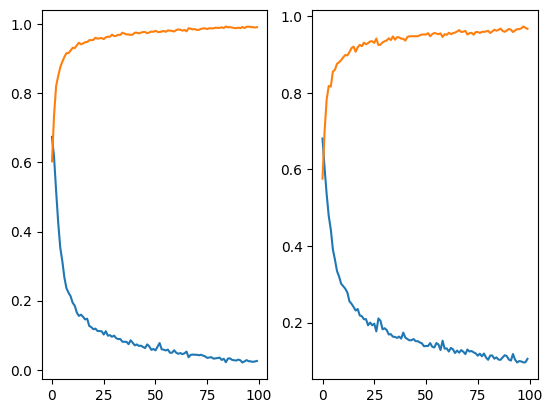

In [28]:
#YOUR CODE HERE
import matplotlib.pyplot as plt
fig,axis=plt.subplots(nrows=1,ncols=2)
axis[0].plot(model_history1.history['loss'])
axis[0].plot(model_history1.history['accuracy'])
axis[1].plot(model_history2.history['loss'])
axis[1].plot(model_history2.history['accuracy'])
plt.show()


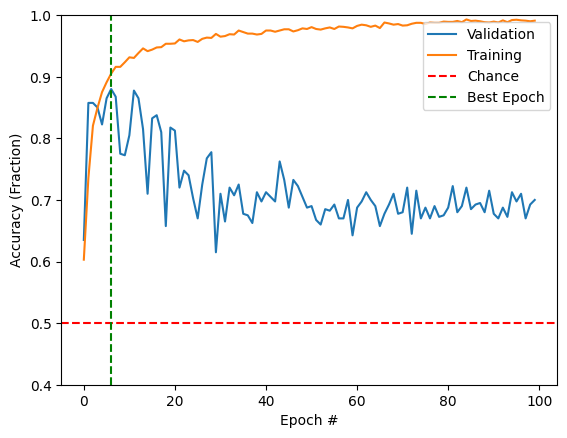

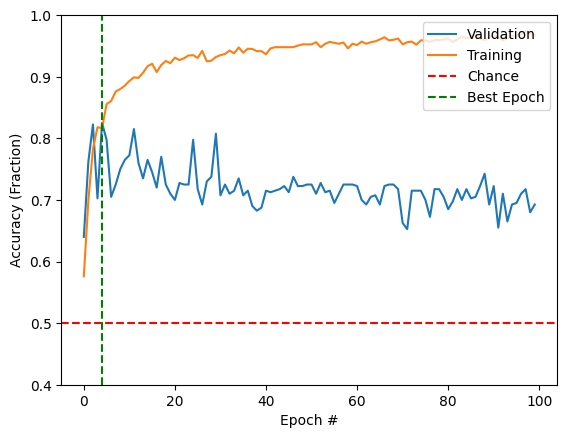

In [29]:
#@title Sample Solution
plot_acc(model_history1)
plot_acc(model_history2)


# **Milestone 4. Expert models: Transfer learning**

For all of the machine learning we've done thus far, we've used models that were built from 'scratch'. All of these models are like newborn babies that have neither seen nor explored the world.

Unfortunately, our training manual is pretty small to all the things in the big wide world. So, just training on our manual is going to be inherently limited.


Luckily, there are **"experts"** who have much more training! While these **"experts"** haven't seen our task, they have experience with a lot of other things. We can hand them our training manual and reasonably expect that they will pick up our task fairly quickly.

In deep learning, the idea of using a model trained on another task as a starting point for your model is known as **transfer learning**.

### VGG 16

For our transfer learning, we're going to use 'experts' built upon the famous 'ImageNet' classification problem.

In ImageNet, participants were challenged to build machine learning models that could distinguish 14 million images' categories, where there were > 20,000 categories available.

Below, we see examples of 4 different categories.

![](http://cs231n.github.io/assets/trainset.jpg)



One of the experts we can use is VGG 16. VGG 16 was a network that was allowed to study the 14 million images 74 times.

After its studying, VGG 16 was able to guess something close to the real label (top-5 accuracy) better than a human can.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

We're going to take an expert model like VGG16 and let it train on OUR x-rays. Hopefully, their experience with those 14 million images will help it understand pneumonia from our x-rays.

### Exercise (Coding)

Let's tap an expert model to help us out with our pneumonia prediction!

We provide a wrapper that lets you 'call' up and employ expert models. You can call it like...

```
transfer = TransferClassifier(name = 'VGG16')
```

The experts we have on hand are:
* `VGG16`
* `VGG19`
* `ResNet50`
* `DenseNet121`

There are default arguments/parameters to model.fit you can call:

`model.fit(train_data, train_labels, epochs = N, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])`

The shuffle parameter is important for shuffling the training data before each epoch. The monitor callback is used to get a view on internal states and statistics of the model during training. Do not change these parameters!

**Experiment with using these experts. Remember to fit and score your model, and to take a look at the training history.**




In [ ]:
### YOUR CODE HERE

### END CODE

58889256/58889256 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10


 1/63 [..............................] - ETA: 2:40 - loss: 0.7076 - accuracy: 0.4375

 2/63 [..............................] - ETA: 3s - loss: 0.7512 - accuracy: 0.3906  

 3/63 [>.............................] - ETA: 3s - loss: 0.7417 - accuracy: 0.4271

 5/63 [=>............................] - ETA: 2s - loss: 0.7401 - accuracy: 0.4563

 6/63 [=>............................] - ETA: 2s - loss: 0.7295 - accuracy: 0.4740

 7/63 [==>...........................] - ETA: 2s - loss: 0.7324 - accuracy: 0.4598

 8/63 [==>...........................] - ETA: 2s - loss: 0.7238 - accuracy: 0.4727

 9/63 [===>..........................] - ETA: 2s - loss: 0.7259 - accuracy: 0.4688

10/63 [===>..........................] - ETA: 2s - loss: 0.7299 - accuracy: 0.4625

12/63 [====>.........................] - ETA: 2s - loss: 0.7278 - accuracy: 0.4766

13/63 [=====>........................] - ETA: 2s - loss: 0.7264 - accuracy: 0.4760

15/63 [======>.......................] - ETA: 2s - loss: 0.7166 - accuracy: 0.4979

17/63 [=======>......................] - ETA: 2s - loss: 0.7148 - accuracy: 0.4982

18/63 [=======>......................] - ETA: 2s - loss: 0.7106 - accuracy: 0.5087

20/63 [========>.....................] - ETA: 2s - loss: 0.7106 - accuracy: 0.5094

22/63 [=========>....................] - ETA: 2s - loss: 0.7084 - accuracy: 0.5142

23/63 [=========>....................] - ETA: 1s - loss: 0.7083 - accuracy: 0.5163

25/63 [==========>...................] - ETA: 1s - loss: 0.7063 - accuracy: 0.5263

26/63 [===========>..................] - ETA: 1s - loss: 0.7042 - accuracy: 0.5264

28/63 [============>.................] - ETA: 1s - loss: 0.7023 - accuracy: 0.5268

29/63 [============>.................] - ETA: 1s - loss: 0.7010 - accuracy: 0.5312

30/63 [=============>................] - ETA: 1s - loss: 0.6998 - accuracy: 0.5323

32/63 [==============>...............] - ETA: 1s - loss: 0.6955 - accuracy: 0.5430

34/63 [===============>..............] - ETA: 1s - loss: 0.6946 - accuracy: 0.5441

35/63 [===============>..............] - ETA: 1s - loss: 0.6939 - accuracy: 0.5455

36/63 [================>.............] - ETA: 1s - loss: 0.6911 - accuracy: 0.5503

38/63 [=================>............] - ETA: 1s - loss: 0.6894 - accuracy: 0.5502

39/63 [=================>............] - ETA: 1s - loss: 0.6870 - accuracy: 0.5537

41/63 [==================>...........] - ETA: 1s - loss: 0.6842 - accuracy: 0.5564

43/63 [===================>..........] - ETA: 0s - loss: 0.6809 - accuracy: 0.5640

44/63 [===================>..........] - ETA: 0s - loss: 0.6791 - accuracy: 0.5689

45/63 [====================>.........] - ETA: 0s - loss: 0.6768 - accuracy: 0.5736

47/63 [=====================>........] - ETA: 0s - loss: 0.6730 - accuracy: 0.5805

48/63 [=====================>........] - ETA: 0s - loss: 0.6731 - accuracy: 0.5814

50/63 [======================>.......] - ETA: 0s - loss: 0.6693 - accuracy: 0.5894

51/63 [=======================>......] - ETA: 0s - loss: 0.6669 - accuracy: 0.5944

52/63 [=======================>......] - ETA: 0s - loss: 0.6658 - accuracy: 0.5944

54/63 [========================>.....] - ETA: 0s - loss: 0.6619 - accuracy: 0.5995

56/63 [=========================>....] - ETA: 0s - loss: 0.6566 - accuracy: 0.6083

58/63 [==========================>...] - ETA: 0s - loss: 0.6537 - accuracy: 0.6142

60/63 [===========================>..] - ETA: 0s - loss: 0.6494 - accuracy: 0.6214

62/63 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6305

63/63 [==============================] - 7s 75ms/step - loss: 0.6437 - accuracy: 0.6305 - val_loss: 0.4865 - val_accuracy: 0.8375
Epoch 2/10


 1/63 [..............................] - ETA: 3s - loss: 0.5077 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 2s - loss: 0.4683 - accuracy: 0.8438

 4/63 [>.............................] - ETA: 2s - loss: 0.4956 - accuracy: 0.8047

 5/63 [=>............................] - ETA: 2s - loss: 0.4767 - accuracy: 0.8313

 6/63 [=>............................] - ETA: 2s - loss: 0.4698 - accuracy: 0.8490

 7/63 [==>...........................] - ETA: 2s - loss: 0.4675 - accuracy: 0.8527

 8/63 [==>...........................] - ETA: 2s - loss: 0.4631 - accuracy: 0.8555

 9/63 [===>..........................] - ETA: 2s - loss: 0.4522 - accuracy: 0.8646

10/63 [===>..........................] - ETA: 2s - loss: 0.4598 - accuracy: 0.8562

11/63 [====>.........................] - ETA: 2s - loss: 0.4548 - accuracy: 0.8608

12/63 [====>.........................] - ETA: 2s - loss: 0.4539 - accuracy: 0.8568

13/63 [=====>........................] - ETA: 2s - loss: 0.4486 - accuracy: 0.8606

14/63 [=====>........................] - ETA: 2s - loss: 0.4416 - accuracy: 0.8638

15/63 [======>.......................] - ETA: 2s - loss: 0.4365 - accuracy: 0.8667

16/63 [======>.......................] - ETA: 2s - loss: 0.4305 - accuracy: 0.8691

17/63 [=======>......................] - ETA: 2s - loss: 0.4285 - accuracy: 0.8695

18/63 [=======>......................] - ETA: 2s - loss: 0.4259 - accuracy: 0.8681

19/63 [========>.....................] - ETA: 2s - loss: 0.4175 - accuracy: 0.8717

21/63 [=========>....................] - ETA: 2s - loss: 0.4049 - accuracy: 0.8765

22/63 [=========>....................] - ETA: 2s - loss: 0.4019 - accuracy: 0.8778

23/63 [=========>....................] - ETA: 2s - loss: 0.4004 - accuracy: 0.8764

25/63 [==========>...................] - ETA: 2s - loss: 0.3950 - accuracy: 0.8763

26/63 [===========>..................] - ETA: 2s - loss: 0.3908 - accuracy: 0.8786

27/63 [===========>..................] - ETA: 1s - loss: 0.3840 - accuracy: 0.8819

28/63 [============>.................] - ETA: 1s - loss: 0.3772 - accuracy: 0.8850

29/63 [============>.................] - ETA: 1s - loss: 0.3750 - accuracy: 0.8858

30/63 [=============>................] - ETA: 1s - loss: 0.3754 - accuracy: 0.8833

31/63 [=============>................] - ETA: 1s - loss: 0.3673 - accuracy: 0.8871

32/63 [==============>...............] - ETA: 1s - loss: 0.3661 - accuracy: 0.8867

33/63 [==============>...............] - ETA: 1s - loss: 0.3595 - accuracy: 0.8902

34/63 [===============>..............] - ETA: 1s - loss: 0.3557 - accuracy: 0.8906

35/63 [===============>..............] - ETA: 1s - loss: 0.3506 - accuracy: 0.8920

36/63 [================>.............] - ETA: 1s - loss: 0.3451 - accuracy: 0.8932

37/63 [================>.............] - ETA: 1s - loss: 0.3396 - accuracy: 0.8953

38/63 [=================>............] - ETA: 1s - loss: 0.3376 - accuracy: 0.8956

39/63 [=================>............] - ETA: 1s - loss: 0.3358 - accuracy: 0.8966

40/63 [==================>...........] - ETA: 1s - loss: 0.3330 - accuracy: 0.8969

41/63 [==================>...........] - ETA: 1s - loss: 0.3276 - accuracy: 0.8994

42/63 [===================>..........] - ETA: 1s - loss: 0.3252 - accuracy: 0.8996

43/63 [===================>..........] - ETA: 1s - loss: 0.3196 - accuracy: 0.9019

44/63 [===================>..........] - ETA: 1s - loss: 0.3153 - accuracy: 0.9034

45/63 [====================>.........] - ETA: 0s - loss: 0.3111 - accuracy: 0.9049

46/63 [====================>.........] - ETA: 0s - loss: 0.3082 - accuracy: 0.9056

47/63 [=====================>........] - ETA: 0s - loss: 0.3058 - accuracy: 0.9062

48/63 [=====================>........] - ETA: 0s - loss: 0.3055 - accuracy: 0.9056

49/63 [======================>.......] - ETA: 0s - loss: 0.3062 - accuracy: 0.9056

50/63 [======================>.......] - ETA: 0s - loss: 0.3042 - accuracy: 0.9062

51/63 [=======================>......] - ETA: 0s - loss: 0.3049 - accuracy: 0.9044

53/63 [========================>.....] - ETA: 0s - loss: 0.3008 - accuracy: 0.9051

54/63 [========================>.....] - ETA: 0s - loss: 0.2967 - accuracy: 0.9062

55/63 [=========================>....] - ETA: 0s - loss: 0.2942 - accuracy: 0.9068

56/63 [=========================>....] - ETA: 0s - loss: 0.2909 - accuracy: 0.9074

58/63 [==========================>...] - ETA: 0s - loss: 0.2894 - accuracy: 0.9068

59/63 [===========================>..] - ETA: 0s - loss: 0.2888 - accuracy: 0.9068

61/63 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.9068

62/63 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.9057

63/63 [==============================] - 4s 56ms/step - loss: 0.2852 - accuracy: 0.9055 - val_loss: 0.5965 - val_accuracy: 0.7875
Epoch 3/10


 1/63 [..............................] - ETA: 3s - loss: 0.1139 - accuracy: 0.9688

 2/63 [..............................] - ETA: 3s - loss: 0.1260 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 3s - loss: 0.1005 - accuracy: 0.9766

 6/63 [=>............................] - ETA: 2s - loss: 0.1332 - accuracy: 0.9583

 7/63 [==>...........................] - ETA: 2s - loss: 0.1362 - accuracy: 0.9554

 9/63 [===>..........................] - ETA: 2s - loss: 0.1393 - accuracy: 0.9479

10/63 [===>..........................] - ETA: 2s - loss: 0.1571 - accuracy: 0.9438

11/63 [====>.........................] - ETA: 2s - loss: 0.1508 - accuracy: 0.9460

12/63 [====>.........................] - ETA: 2s - loss: 0.1426 - accuracy: 0.9505

13/63 [=====>........................] - ETA: 2s - loss: 0.1578 - accuracy: 0.9447

14/63 [=====>........................] - ETA: 2s - loss: 0.1760 - accuracy: 0.9353

15/63 [======>.......................] - ETA: 2s - loss: 0.1701 - accuracy: 0.9354

16/63 [======>.......................] - ETA: 2s - loss: 0.1682 - accuracy: 0.9355

18/63 [=======>......................] - ETA: 2s - loss: 0.1801 - accuracy: 0.9306

19/63 [========>.....................] - ETA: 2s - loss: 0.1819 - accuracy: 0.9309

21/63 [=========>....................] - ETA: 2s - loss: 0.1881 - accuracy: 0.9271

22/63 [=========>....................] - ETA: 2s - loss: 0.1910 - accuracy: 0.9261

24/63 [==========>...................] - ETA: 1s - loss: 0.1922 - accuracy: 0.9232

25/63 [==========>...................] - ETA: 1s - loss: 0.1977 - accuracy: 0.9212

27/63 [===========>..................] - ETA: 1s - loss: 0.1909 - accuracy: 0.9259

28/63 [============>.................] - ETA: 1s - loss: 0.1917 - accuracy: 0.9263

29/63 [============>.................] - ETA: 1s - loss: 0.2010 - accuracy: 0.9235

31/63 [=============>................] - ETA: 1s - loss: 0.2053 - accuracy: 0.9204

32/63 [==============>...............] - ETA: 1s - loss: 0.2053 - accuracy: 0.9209

33/63 [==============>...............] - ETA: 1s - loss: 0.2102 - accuracy: 0.9195

35/63 [===============>..............] - ETA: 1s - loss: 0.2212 - accuracy: 0.9125

37/63 [================>.............] - ETA: 1s - loss: 0.2218 - accuracy: 0.9113

38/63 [=================>............] - ETA: 1s - loss: 0.2190 - accuracy: 0.9128

40/63 [==================>...........] - ETA: 1s - loss: 0.2160 - accuracy: 0.9141

42/63 [===================>..........] - ETA: 1s - loss: 0.2197 - accuracy: 0.9129

43/63 [===================>..........] - ETA: 1s - loss: 0.2239 - accuracy: 0.9099

45/63 [====================>.........] - ETA: 0s - loss: 0.2191 - accuracy: 0.9132

46/63 [====================>.........] - ETA: 0s - loss: 0.2183 - accuracy: 0.9130

48/63 [=====================>........] - ETA: 0s - loss: 0.2217 - accuracy: 0.9115

49/63 [======================>.......] - ETA: 0s - loss: 0.2215 - accuracy: 0.9114

51/63 [=======================>......] - ETA: 0s - loss: 0.2284 - accuracy: 0.9093

52/63 [=======================>......] - ETA: 0s - loss: 0.2282 - accuracy: 0.9093

54/63 [========================>.....] - ETA: 0s - loss: 0.2260 - accuracy: 0.9115

55/63 [=========================>....] - ETA: 0s - loss: 0.2244 - accuracy: 0.9125

57/63 [==========================>...] - ETA: 0s - loss: 0.2214 - accuracy: 0.9150

58/63 [==========================>...] - ETA: 0s - loss: 0.2213 - accuracy: 0.9154

59/63 [===========================>..] - ETA: 0s - loss: 0.2212 - accuracy: 0.9147

61/63 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9150

62/63 [============================>.] - ETA: 0s - loss: 0.2192 - accuracy: 0.9158

63/63 [==============================] - 3s 55ms/step - loss: 0.2181 - accuracy: 0.9165 - val_loss: 0.5043 - val_accuracy: 0.8175
Epoch 4/10


 1/63 [..............................] - ETA: 3s - loss: 0.2438 - accuracy: 0.8750

 2/63 [..............................] - ETA: 3s - loss: 0.2148 - accuracy: 0.8906

 4/63 [>.............................] - ETA: 3s - loss: 0.1770 - accuracy: 0.9141

 5/63 [=>............................] - ETA: 2s - loss: 0.1755 - accuracy: 0.9187

 6/63 [=>............................] - ETA: 2s - loss: 0.1724 - accuracy: 0.9167

 7/63 [==>...........................] - ETA: 2s - loss: 0.1690 - accuracy: 0.9196

 8/63 [==>...........................] - ETA: 2s - loss: 0.1572 - accuracy: 0.9258

 9/63 [===>..........................] - ETA: 2s - loss: 0.1668 - accuracy: 0.9201

11/63 [====>.........................] - ETA: 2s - loss: 0.1575 - accuracy: 0.9290

13/63 [=====>........................] - ETA: 2s - loss: 0.1525 - accuracy: 0.9351

14/63 [=====>........................] - ETA: 2s - loss: 0.1496 - accuracy: 0.9375

16/63 [======>.......................] - ETA: 2s - loss: 0.1455 - accuracy: 0.9414

17/63 [=======>......................] - ETA: 2s - loss: 0.1411 - accuracy: 0.9449

19/63 [========>.....................] - ETA: 2s - loss: 0.1457 - accuracy: 0.9457

20/63 [========>.....................] - ETA: 2s - loss: 0.1516 - accuracy: 0.9422

22/63 [=========>....................] - ETA: 2s - loss: 0.1411 - accuracy: 0.9474

23/63 [=========>....................] - ETA: 2s - loss: 0.1396 - accuracy: 0.9484

25/63 [==========>...................] - ETA: 1s - loss: 0.1490 - accuracy: 0.9450

27/63 [===========>..................] - ETA: 1s - loss: 0.1557 - accuracy: 0.9410

28/63 [============>.................] - ETA: 1s - loss: 0.1567 - accuracy: 0.9397

30/63 [=============>................] - ETA: 1s - loss: 0.1482 - accuracy: 0.9438

31/63 [=============>................] - ETA: 1s - loss: 0.1474 - accuracy: 0.9435

33/63 [==============>...............] - ETA: 1s - loss: 0.1459 - accuracy: 0.9432

35/63 [===============>..............] - ETA: 1s - loss: 0.1581 - accuracy: 0.9393

36/63 [================>.............] - ETA: 1s - loss: 0.1556 - accuracy: 0.9410

38/63 [=================>............] - ETA: 1s - loss: 0.1536 - accuracy: 0.9424

39/63 [=================>............] - ETA: 1s - loss: 0.1527 - accuracy: 0.9431

41/63 [==================>...........] - ETA: 1s - loss: 0.1597 - accuracy: 0.9413

42/63 [===================>..........] - ETA: 1s - loss: 0.1582 - accuracy: 0.9420

43/63 [===================>..........] - ETA: 0s - loss: 0.1558 - accuracy: 0.9433

45/63 [====================>.........] - ETA: 0s - loss: 0.1592 - accuracy: 0.9417

46/63 [====================>.........] - ETA: 0s - loss: 0.1619 - accuracy: 0.9402

48/63 [=====================>........] - ETA: 0s - loss: 0.1616 - accuracy: 0.9395

50/63 [======================>.......] - ETA: 0s - loss: 0.1628 - accuracy: 0.9394

51/63 [=======================>......] - ETA: 0s - loss: 0.1639 - accuracy: 0.9387

53/63 [========================>.....] - ETA: 0s - loss: 0.1613 - accuracy: 0.9399

54/63 [========================>.....] - ETA: 0s - loss: 0.1618 - accuracy: 0.9387

56/63 [=========================>....] - ETA: 0s - loss: 0.1633 - accuracy: 0.9369

57/63 [==========================>...] - ETA: 0s - loss: 0.1636 - accuracy: 0.9375

59/63 [===========================>..] - ETA: 0s - loss: 0.1619 - accuracy: 0.9386

60/63 [===========================>..] - ETA: 0s - loss: 0.1607 - accuracy: 0.9391

61/63 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9385

63/63 [==============================] - 3s 55ms/step - loss: 0.1595 - accuracy: 0.9395 - val_loss: 0.3946 - val_accuracy: 0.8500
Epoch 5/10


 1/63 [..............................] - ETA: 2s - loss: 0.0676 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0910 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0975 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 2s - loss: 0.0956 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 2s - loss: 0.1018 - accuracy: 0.9643

 9/63 [===>..........................] - ETA: 2s - loss: 0.1000 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 2s - loss: 0.1003 - accuracy: 0.9716

12/63 [====>.........................] - ETA: 2s - loss: 0.0974 - accuracy: 0.9714

14/63 [=====>........................] - ETA: 2s - loss: 0.0989 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 2s - loss: 0.0933 - accuracy: 0.9707

18/63 [=======>......................] - ETA: 2s - loss: 0.0929 - accuracy: 0.9670

19/63 [========>.....................] - ETA: 2s - loss: 0.0925 - accuracy: 0.9671

20/63 [========>.....................] - ETA: 2s - loss: 0.0939 - accuracy: 0.9672

21/63 [=========>....................] - ETA: 2s - loss: 0.0945 - accuracy: 0.9673

22/63 [=========>....................] - ETA: 2s - loss: 0.0953 - accuracy: 0.9673

23/63 [=========>....................] - ETA: 2s - loss: 0.1045 - accuracy: 0.9647

24/63 [==========>...................] - ETA: 1s - loss: 0.1059 - accuracy: 0.9635

25/63 [==========>...................] - ETA: 1s - loss: 0.1036 - accuracy: 0.9650

26/63 [===========>..................] - ETA: 1s - loss: 0.1027 - accuracy: 0.9651

27/63 [===========>..................] - ETA: 1s - loss: 0.1060 - accuracy: 0.9653

28/63 [============>.................] - ETA: 1s - loss: 0.1038 - accuracy: 0.9654

29/63 [============>.................] - ETA: 1s - loss: 0.1025 - accuracy: 0.9655

30/63 [=============>................] - ETA: 1s - loss: 0.1002 - accuracy: 0.9667

31/63 [=============>................] - ETA: 1s - loss: 0.0976 - accuracy: 0.9677

33/63 [==============>...............] - ETA: 1s - loss: 0.0975 - accuracy: 0.9678

34/63 [===============>..............] - ETA: 1s - loss: 0.0962 - accuracy: 0.9678

35/63 [===============>..............] - ETA: 1s - loss: 0.0948 - accuracy: 0.9688

36/63 [================>.............] - ETA: 1s - loss: 0.0933 - accuracy: 0.9696

38/63 [=================>............] - ETA: 1s - loss: 0.0927 - accuracy: 0.9696

39/63 [=================>............] - ETA: 1s - loss: 0.0911 - accuracy: 0.9704

41/63 [==================>...........] - ETA: 1s - loss: 0.0923 - accuracy: 0.9703

42/63 [===================>..........] - ETA: 1s - loss: 0.0918 - accuracy: 0.9702

44/63 [===================>..........] - ETA: 0s - loss: 0.0885 - accuracy: 0.9716

46/63 [====================>.........] - ETA: 0s - loss: 0.0892 - accuracy: 0.9721

47/63 [=====================>........] - ETA: 0s - loss: 0.0897 - accuracy: 0.9721

48/63 [=====================>........] - ETA: 0s - loss: 0.0924 - accuracy: 0.9714

50/63 [======================>.......] - ETA: 0s - loss: 0.0930 - accuracy: 0.9706

51/63 [=======================>......] - ETA: 0s - loss: 0.0938 - accuracy: 0.9706

52/63 [=======================>......] - ETA: 0s - loss: 0.0933 - accuracy: 0.9712

53/63 [========================>.....] - ETA: 0s - loss: 0.0927 - accuracy: 0.9711

54/63 [========================>.....] - ETA: 0s - loss: 0.0923 - accuracy: 0.9705

55/63 [=========================>....] - ETA: 0s - loss: 0.0916 - accuracy: 0.9705

56/63 [=========================>....] - ETA: 0s - loss: 0.0925 - accuracy: 0.9699

57/63 [==========================>...] - ETA: 0s - loss: 0.0919 - accuracy: 0.9698

58/63 [==========================>...] - ETA: 0s - loss: 0.0909 - accuracy: 0.9704

59/63 [===========================>..] - ETA: 0s - loss: 0.0907 - accuracy: 0.9703

61/63 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9708

62/63 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9708

63/63 [==============================] - 4s 57ms/step - loss: 0.0890 - accuracy: 0.9710 - val_loss: 0.4229 - val_accuracy: 0.8675
Epoch 6/10


 1/63 [..............................] - ETA: 3s - loss: 0.3100 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.1832 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 3s - loss: 0.1283 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 3s - loss: 0.1125 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.1214 - accuracy: 0.9563

 6/63 [=>............................] - ETA: 2s - loss: 0.1130 - accuracy: 0.9583

 7/63 [==>...........................] - ETA: 2s - loss: 0.1041 - accuracy: 0.9598

 8/63 [==>...........................] - ETA: 2s - loss: 0.0950 - accuracy: 0.9648

 9/63 [===>..........................] - ETA: 2s - loss: 0.0871 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 2s - loss: 0.0948 - accuracy: 0.9656

12/63 [====>.........................] - ETA: 2s - loss: 0.1080 - accuracy: 0.9583

13/63 [=====>........................] - ETA: 2s - loss: 0.1091 - accuracy: 0.9591

14/63 [=====>........................] - ETA: 2s - loss: 0.1020 - accuracy: 0.9621

15/63 [======>.......................] - ETA: 2s - loss: 0.0997 - accuracy: 0.9625

16/63 [======>.......................] - ETA: 2s - loss: 0.0946 - accuracy: 0.9648

18/63 [=======>......................] - ETA: 2s - loss: 0.0968 - accuracy: 0.9635

19/63 [========>.....................] - ETA: 2s - loss: 0.1028 - accuracy: 0.9622

20/63 [========>.....................] - ETA: 2s - loss: 0.1079 - accuracy: 0.9609

21/63 [=========>....................] - ETA: 2s - loss: 0.1085 - accuracy: 0.9598

22/63 [=========>....................] - ETA: 2s - loss: 0.1123 - accuracy: 0.9574

23/63 [=========>....................] - ETA: 2s - loss: 0.1107 - accuracy: 0.9579

24/63 [==========>...................] - ETA: 2s - loss: 0.1079 - accuracy: 0.9596

25/63 [==========>...................] - ETA: 1s - loss: 0.1044 - accuracy: 0.9613

26/63 [===========>..................] - ETA: 1s - loss: 0.1089 - accuracy: 0.9603

27/63 [===========>..................] - ETA: 1s - loss: 0.1065 - accuracy: 0.9618

29/63 [============>.................] - ETA: 1s - loss: 0.1069 - accuracy: 0.9623

30/63 [=============>................] - ETA: 1s - loss: 0.1091 - accuracy: 0.9615

31/63 [=============>................] - ETA: 1s - loss: 0.1073 - accuracy: 0.9617

32/63 [==============>...............] - ETA: 1s - loss: 0.1070 - accuracy: 0.9609

33/63 [==============>...............] - ETA: 1s - loss: 0.1046 - accuracy: 0.9621

34/63 [===============>..............] - ETA: 1s - loss: 0.1037 - accuracy: 0.9623

35/63 [===============>..............] - ETA: 1s - loss: 0.1058 - accuracy: 0.9625

37/63 [================>.............] - ETA: 1s - loss: 0.1040 - accuracy: 0.9620

38/63 [=================>............] - ETA: 1s - loss: 0.1059 - accuracy: 0.9622

40/63 [==================>...........] - ETA: 1s - loss: 0.1028 - accuracy: 0.9625

41/63 [==================>...........] - ETA: 1s - loss: 0.1016 - accuracy: 0.9627

43/63 [===================>..........] - ETA: 1s - loss: 0.1007 - accuracy: 0.9629

44/63 [===================>..........] - ETA: 0s - loss: 0.1015 - accuracy: 0.9624

45/63 [====================>.........] - ETA: 0s - loss: 0.1012 - accuracy: 0.9625

46/63 [====================>.........] - ETA: 0s - loss: 0.1020 - accuracy: 0.9620

47/63 [=====================>........] - ETA: 0s - loss: 0.1010 - accuracy: 0.9621

49/63 [======================>.......] - ETA: 0s - loss: 0.0995 - accuracy: 0.9630

50/63 [======================>.......] - ETA: 0s - loss: 0.0997 - accuracy: 0.9631

52/63 [=======================>......] - ETA: 0s - loss: 0.0968 - accuracy: 0.9645

53/63 [========================>.....] - ETA: 0s - loss: 0.0957 - accuracy: 0.9652

55/63 [=========================>....] - ETA: 0s - loss: 0.0950 - accuracy: 0.9653

56/63 [=========================>....] - ETA: 0s - loss: 0.0938 - accuracy: 0.9660

57/63 [==========================>...] - ETA: 0s - loss: 0.0931 - accuracy: 0.9660

59/63 [===========================>..] - ETA: 0s - loss: 0.0906 - accuracy: 0.9672

61/63 [============================>.] - ETA: 0s - loss: 0.0940 - accuracy: 0.9657

62/63 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9662

63/63 [==============================] - 3s 54ms/step - loss: 0.0929 - accuracy: 0.9665 - val_loss: 1.1441 - val_accuracy: 0.6850
Epoch 7/10


 1/63 [..............................] - ETA: 3s - loss: 0.1257 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.1091 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 2s - loss: 0.1075 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 2s - loss: 0.1159 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 2s - loss: 0.0953 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 2s - loss: 0.0897 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 2s - loss: 0.0837 - accuracy: 0.9719

12/63 [====>.........................] - ETA: 2s - loss: 0.0813 - accuracy: 0.9740

14/63 [=====>........................] - ETA: 2s - loss: 0.0722 - accuracy: 0.9777

15/63 [======>.......................] - ETA: 2s - loss: 0.0766 - accuracy: 0.9771

17/63 [=======>......................] - ETA: 2s - loss: 0.0718 - accuracy: 0.9779

18/63 [=======>......................] - ETA: 2s - loss: 0.0702 - accuracy: 0.9792

20/63 [========>.....................] - ETA: 2s - loss: 0.0690 - accuracy: 0.9781

21/63 [=========>....................] - ETA: 2s - loss: 0.0679 - accuracy: 0.9792

22/63 [=========>....................] - ETA: 2s - loss: 0.0724 - accuracy: 0.9773

24/63 [==========>...................] - ETA: 1s - loss: 0.0681 - accuracy: 0.9792

25/63 [==========>...................] - ETA: 1s - loss: 0.0676 - accuracy: 0.9787

26/63 [===========>..................] - ETA: 1s - loss: 0.0685 - accuracy: 0.9784

28/63 [============>.................] - ETA: 1s - loss: 0.0694 - accuracy: 0.9777

29/63 [============>.................] - ETA: 1s - loss: 0.0696 - accuracy: 0.9774

31/63 [=============>................] - ETA: 1s - loss: 0.0713 - accuracy: 0.9768

32/63 [==============>...............] - ETA: 1s - loss: 0.0733 - accuracy: 0.9766

34/63 [===============>..............] - ETA: 1s - loss: 0.0705 - accuracy: 0.9779

35/63 [===============>..............] - ETA: 1s - loss: 0.0723 - accuracy: 0.9759

36/63 [================>.............] - ETA: 1s - loss: 0.0713 - accuracy: 0.9766

37/63 [================>.............] - ETA: 1s - loss: 0.0701 - accuracy: 0.9772

38/63 [=================>............] - ETA: 1s - loss: 0.0727 - accuracy: 0.9762

40/63 [==================>...........] - ETA: 1s - loss: 0.0754 - accuracy: 0.9742

41/63 [==================>...........] - ETA: 1s - loss: 0.0758 - accuracy: 0.9733

43/63 [===================>..........] - ETA: 0s - loss: 0.0802 - accuracy: 0.9709

44/63 [===================>..........] - ETA: 0s - loss: 0.0786 - accuracy: 0.9716

46/63 [====================>.........] - ETA: 0s - loss: 0.0773 - accuracy: 0.9721

47/63 [=====================>........] - ETA: 0s - loss: 0.0765 - accuracy: 0.9727

49/63 [======================>.......] - ETA: 0s - loss: 0.0789 - accuracy: 0.9713

51/63 [=======================>......] - ETA: 0s - loss: 0.0808 - accuracy: 0.9712

52/63 [=======================>......] - ETA: 0s - loss: 0.0823 - accuracy: 0.9700

54/63 [========================>.....] - ETA: 0s - loss: 0.0825 - accuracy: 0.9699

55/63 [=========================>....] - ETA: 0s - loss: 0.0811 - accuracy: 0.9705

57/63 [==========================>...] - ETA: 0s - loss: 0.0846 - accuracy: 0.9698

58/63 [==========================>...] - ETA: 0s - loss: 0.0848 - accuracy: 0.9693

59/63 [===========================>..] - ETA: 0s - loss: 0.0912 - accuracy: 0.9672

61/63 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9677

63/63 [==============================] - 3s 55ms/step - loss: 0.0892 - accuracy: 0.9680 - val_loss: 0.7575 - val_accuracy: 0.7950
Epoch 8/10


 1/63 [..............................] - ETA: 2s - loss: 0.1034 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.0609 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.0762 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 3s - loss: 0.0633 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 2s - loss: 0.0732 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 2s - loss: 0.0704 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 2s - loss: 0.0690 - accuracy: 0.9722

10/63 [===>..........................] - ETA: 2s - loss: 0.0637 - accuracy: 0.9750

11/63 [====>.........................] - ETA: 2s - loss: 0.0594 - accuracy: 0.9773

12/63 [====>.........................] - ETA: 2s - loss: 0.0586 - accuracy: 0.9766

13/63 [=====>........................] - ETA: 2s - loss: 0.0581 - accuracy: 0.9760

14/63 [=====>........................] - ETA: 2s - loss: 0.0581 - accuracy: 0.9754

15/63 [======>.......................] - ETA: 2s - loss: 0.0635 - accuracy: 0.9729

16/63 [======>.......................] - ETA: 2s - loss: 0.0698 - accuracy: 0.9707

18/63 [=======>......................] - ETA: 2s - loss: 0.0715 - accuracy: 0.9705

19/63 [========>.....................] - ETA: 2s - loss: 0.0712 - accuracy: 0.9704

20/63 [========>.....................] - ETA: 2s - loss: 0.0692 - accuracy: 0.9719

22/63 [=========>....................] - ETA: 2s - loss: 0.0711 - accuracy: 0.9702

23/63 [=========>....................] - ETA: 2s - loss: 0.0703 - accuracy: 0.9715

24/63 [==========>...................] - ETA: 2s - loss: 0.0701 - accuracy: 0.9727

25/63 [==========>...................] - ETA: 1s - loss: 0.0687 - accuracy: 0.9737

26/63 [===========>..................] - ETA: 1s - loss: 0.0712 - accuracy: 0.9736

27/63 [===========>..................] - ETA: 1s - loss: 0.0728 - accuracy: 0.9734

28/63 [============>.................] - ETA: 1s - loss: 0.0747 - accuracy: 0.9732

29/63 [============>.................] - ETA: 1s - loss: 0.0740 - accuracy: 0.9731

30/63 [=============>................] - ETA: 1s - loss: 0.0732 - accuracy: 0.9729

32/63 [==============>...............] - ETA: 1s - loss: 0.0756 - accuracy: 0.9707

33/63 [==============>...............] - ETA: 1s - loss: 0.0745 - accuracy: 0.9716

35/63 [===============>..............] - ETA: 1s - loss: 0.0725 - accuracy: 0.9732

36/63 [================>.............] - ETA: 1s - loss: 0.0744 - accuracy: 0.9722

38/63 [=================>............] - ETA: 1s - loss: 0.0739 - accuracy: 0.9729

40/63 [==================>...........] - ETA: 1s - loss: 0.0717 - accuracy: 0.9734

41/63 [==================>...........] - ETA: 1s - loss: 0.0708 - accuracy: 0.9741

43/63 [===================>..........] - ETA: 1s - loss: 0.0730 - accuracy: 0.9738

45/63 [====================>.........] - ETA: 0s - loss: 0.0741 - accuracy: 0.9736

46/63 [====================>.........] - ETA: 0s - loss: 0.0767 - accuracy: 0.9721

47/63 [=====================>........] - ETA: 0s - loss: 0.0786 - accuracy: 0.9707

49/63 [======================>.......] - ETA: 0s - loss: 0.0764 - accuracy: 0.9719

50/63 [======================>.......] - ETA: 0s - loss: 0.0753 - accuracy: 0.9725

51/63 [=======================>......] - ETA: 0s - loss: 0.0755 - accuracy: 0.9724

52/63 [=======================>......] - ETA: 0s - loss: 0.0744 - accuracy: 0.9730

54/63 [========================>.....] - ETA: 0s - loss: 0.0728 - accuracy: 0.9734

55/63 [=========================>....] - ETA: 0s - loss: 0.0745 - accuracy: 0.9727

56/63 [=========================>....] - ETA: 0s - loss: 0.0740 - accuracy: 0.9732

57/63 [==========================>...] - ETA: 0s - loss: 0.0728 - accuracy: 0.9737

59/63 [===========================>..] - ETA: 0s - loss: 0.0719 - accuracy: 0.9740

60/63 [===========================>..] - ETA: 0s - loss: 0.0729 - accuracy: 0.9740

61/63 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9739

62/63 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9733

63/63 [==============================] - 3s 55ms/step - loss: 0.0731 - accuracy: 0.9735 - val_loss: 1.0514 - val_accuracy: 0.7075
Epoch 9/10


 1/63 [..............................] - ETA: 3s - loss: 0.0121 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0121 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 3s - loss: 0.0308 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 3s - loss: 0.0357 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 3s - loss: 0.0675 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 3s - loss: 0.0580 - accuracy: 0.9866

 9/63 [===>..........................] - ETA: 2s - loss: 0.0709 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 2s - loss: 0.0639 - accuracy: 0.9801

12/63 [====>.........................] - ETA: 2s - loss: 0.0805 - accuracy: 0.9766

13/63 [=====>........................] - ETA: 2s - loss: 0.0852 - accuracy: 0.9736

14/63 [=====>........................] - ETA: 2s - loss: 0.0804 - accuracy: 0.9754

16/63 [======>.......................] - ETA: 2s - loss: 0.0750 - accuracy: 0.9766

17/63 [=======>......................] - ETA: 2s - loss: 0.0741 - accuracy: 0.9761

19/63 [========>.....................] - ETA: 2s - loss: 0.0699 - accuracy: 0.9770

20/63 [========>.....................] - ETA: 2s - loss: 0.0673 - accuracy: 0.9781

21/63 [=========>....................] - ETA: 2s - loss: 0.0654 - accuracy: 0.9792

23/63 [=========>....................] - ETA: 2s - loss: 0.0613 - accuracy: 0.9810

24/63 [==========>...................] - ETA: 1s - loss: 0.0593 - accuracy: 0.9818

26/63 [===========>..................] - ETA: 1s - loss: 0.0565 - accuracy: 0.9832

27/63 [===========>..................] - ETA: 1s - loss: 0.0580 - accuracy: 0.9815

28/63 [============>.................] - ETA: 1s - loss: 0.0595 - accuracy: 0.9810

29/63 [============>.................] - ETA: 1s - loss: 0.0585 - accuracy: 0.9817

30/63 [=============>................] - ETA: 1s - loss: 0.0598 - accuracy: 0.9802

31/63 [=============>................] - ETA: 1s - loss: 0.0583 - accuracy: 0.9808

32/63 [==============>...............] - ETA: 1s - loss: 0.0568 - accuracy: 0.9814

33/63 [==============>...............] - ETA: 1s - loss: 0.0567 - accuracy: 0.9811

34/63 [===============>..............] - ETA: 1s - loss: 0.0553 - accuracy: 0.9816

35/63 [===============>..............] - ETA: 1s - loss: 0.0553 - accuracy: 0.9812

36/63 [================>.............] - ETA: 1s - loss: 0.0575 - accuracy: 0.9809

37/63 [================>.............] - ETA: 1s - loss: 0.0572 - accuracy: 0.9806

38/63 [=================>............] - ETA: 1s - loss: 0.0561 - accuracy: 0.9811

39/63 [=================>............] - ETA: 1s - loss: 0.0548 - accuracy: 0.9816

40/63 [==================>...........] - ETA: 1s - loss: 0.0572 - accuracy: 0.9805

41/63 [==================>...........] - ETA: 1s - loss: 0.0562 - accuracy: 0.9809

42/63 [===================>..........] - ETA: 1s - loss: 0.0553 - accuracy: 0.9814

43/63 [===================>..........] - ETA: 1s - loss: 0.0543 - accuracy: 0.9818

44/63 [===================>..........] - ETA: 1s - loss: 0.0535 - accuracy: 0.9822

45/63 [====================>.........] - ETA: 1s - loss: 0.0546 - accuracy: 0.9812

46/63 [====================>.........] - ETA: 1s - loss: 0.0539 - accuracy: 0.9817

47/63 [=====================>........] - ETA: 0s - loss: 0.0529 - accuracy: 0.9820

48/63 [=====================>........] - ETA: 0s - loss: 0.0529 - accuracy: 0.9818

49/63 [======================>.......] - ETA: 0s - loss: 0.0522 - accuracy: 0.9821

50/63 [======================>.......] - ETA: 0s - loss: 0.0512 - accuracy: 0.9825

51/63 [=======================>......] - ETA: 0s - loss: 0.0505 - accuracy: 0.9828

52/63 [=======================>......] - ETA: 0s - loss: 0.0506 - accuracy: 0.9832

53/63 [========================>.....] - ETA: 0s - loss: 0.0498 - accuracy: 0.9835

54/63 [========================>.....] - ETA: 0s - loss: 0.0493 - accuracy: 0.9838

55/63 [=========================>....] - ETA: 0s - loss: 0.0487 - accuracy: 0.9841

56/63 [=========================>....] - ETA: 0s - loss: 0.0483 - accuracy: 0.9844

57/63 [==========================>...] - ETA: 0s - loss: 0.0477 - accuracy: 0.9846

58/63 [==========================>...] - ETA: 0s - loss: 0.0494 - accuracy: 0.9844

59/63 [===========================>..] - ETA: 0s - loss: 0.0508 - accuracy: 0.9836

60/63 [===========================>..] - ETA: 0s - loss: 0.0518 - accuracy: 0.9823

61/63 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9826

62/63 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9824

63/63 [==============================] - 5s 74ms/step - loss: 0.0509 - accuracy: 0.9825 - val_loss: 0.7732 - val_accuracy: 0.8000
Epoch 10/10


 1/63 [..............................] - ETA: 4s - loss: 0.1961 - accuracy: 0.9375

 2/63 [..............................] - ETA: 4s - loss: 0.0994 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 4s - loss: 0.0711 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 4s - loss: 0.0651 - accuracy: 0.9766

 5/63 [=>............................] - ETA: 4s - loss: 0.0531 - accuracy: 0.9812

 6/63 [=>............................] - ETA: 4s - loss: 0.0751 - accuracy: 0.9792

 7/63 [==>...........................] - ETA: 4s - loss: 0.0652 - accuracy: 0.9821

 8/63 [==>...........................] - ETA: 4s - loss: 0.0710 - accuracy: 0.9766

 9/63 [===>..........................] - ETA: 4s - loss: 0.0783 - accuracy: 0.9757

10/63 [===>..........................] - ETA: 4s - loss: 0.0770 - accuracy: 0.9719

11/63 [====>.........................] - ETA: 4s - loss: 0.0709 - accuracy: 0.9744

12/63 [====>.........................] - ETA: 3s - loss: 0.0711 - accuracy: 0.9740

13/63 [=====>........................] - ETA: 3s - loss: 0.0673 - accuracy: 0.9760

14/63 [=====>........................] - ETA: 3s - loss: 0.0643 - accuracy: 0.9777

15/63 [======>.......................] - ETA: 3s - loss: 0.0814 - accuracy: 0.9729

16/63 [======>.......................] - ETA: 3s - loss: 0.0823 - accuracy: 0.9727

17/63 [=======>......................] - ETA: 3s - loss: 0.0805 - accuracy: 0.9743

18/63 [=======>......................] - ETA: 3s - loss: 0.0786 - accuracy: 0.9740

19/63 [========>.....................] - ETA: 3s - loss: 0.0786 - accuracy: 0.9737

20/63 [========>.....................] - ETA: 3s - loss: 0.0763 - accuracy: 0.9750

21/63 [=========>....................] - ETA: 2s - loss: 0.0749 - accuracy: 0.9747

22/63 [=========>....................] - ETA: 2s - loss: 0.0739 - accuracy: 0.9744

23/63 [=========>....................] - ETA: 2s - loss: 0.0764 - accuracy: 0.9742

24/63 [==========>...................] - ETA: 2s - loss: 0.0850 - accuracy: 0.9714

26/63 [===========>..................] - ETA: 2s - loss: 0.0913 - accuracy: 0.9700

27/63 [===========>..................] - ETA: 2s - loss: 0.0959 - accuracy: 0.9676

28/63 [============>.................] - ETA: 2s - loss: 0.0951 - accuracy: 0.9665

29/63 [============>.................] - ETA: 2s - loss: 0.0949 - accuracy: 0.9666

30/63 [=============>................] - ETA: 2s - loss: 0.0935 - accuracy: 0.9667

31/63 [=============>................] - ETA: 2s - loss: 0.0935 - accuracy: 0.9657

32/63 [==============>...............] - ETA: 1s - loss: 0.1041 - accuracy: 0.9639

34/63 [===============>..............] - ETA: 1s - loss: 0.1051 - accuracy: 0.9642

35/63 [===============>..............] - ETA: 1s - loss: 0.1036 - accuracy: 0.9652

36/63 [================>.............] - ETA: 1s - loss: 0.1013 - accuracy: 0.9661

38/63 [=================>............] - ETA: 1s - loss: 0.0972 - accuracy: 0.9679

39/63 [=================>............] - ETA: 1s - loss: 0.0972 - accuracy: 0.9671

40/63 [==================>...........] - ETA: 1s - loss: 0.0954 - accuracy: 0.9680

42/63 [===================>..........] - ETA: 1s - loss: 0.0975 - accuracy: 0.9673

43/63 [===================>..........] - ETA: 1s - loss: 0.0993 - accuracy: 0.9658

45/63 [====================>.........] - ETA: 1s - loss: 0.1008 - accuracy: 0.9660

46/63 [====================>.........] - ETA: 1s - loss: 0.0993 - accuracy: 0.9660

47/63 [=====================>........] - ETA: 0s - loss: 0.0987 - accuracy: 0.9661

49/63 [======================>.......] - ETA: 0s - loss: 0.0957 - accuracy: 0.9675

50/63 [======================>.......] - ETA: 0s - loss: 0.0957 - accuracy: 0.9669

51/63 [=======================>......] - ETA: 0s - loss: 0.0957 - accuracy: 0.9669

53/63 [========================>.....] - ETA: 0s - loss: 0.0983 - accuracy: 0.9652

54/63 [========================>.....] - ETA: 0s - loss: 0.0974 - accuracy: 0.9659

56/63 [=========================>....] - ETA: 0s - loss: 0.0953 - accuracy: 0.9665

57/63 [==========================>...] - ETA: 0s - loss: 0.0941 - accuracy: 0.9671

58/63 [==========================>...] - ETA: 0s - loss: 0.0931 - accuracy: 0.9677

60/63 [===========================>..] - ETA: 0s - loss: 0.0922 - accuracy: 0.9682

62/63 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9682

63/63 [==============================] - 4s 60ms/step - loss: 0.0901 - accuracy: 0.9685 - val_loss: 0.5501 - val_accuracy: 0.8300


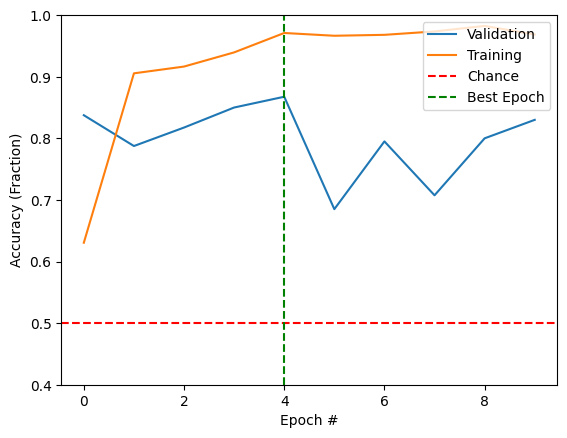

In [30]:
#@title Sample Solution { display-mode: "form" }
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()
transfer = TransferClassifier(name = 'VGG16')
transfer.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
plot_acc(transfer.history)

**This sample solution only uses VGG16. Now try using the other expert models.**

# **Milestone 5. Model Evaluation**



### Exercise (Coding)

Set your best model to the one you have trained (e.g., the transfer learning model).

In [ ]:
## Fill in the blank with the model that did best based on accuracy.
best_model = ______

Total accuracy does not reflect all that we want to know about a model's performance. It's just one metric out of many possible metrics for evaluating models.

In the case of pneumonia prediction, we may be more interested in other quantities, such as 'how accurate were we on the pneumonia category?' or 'how accurate were we on the normal category?' or 'how much of pneumonia were confused for normal?' or vice versa.



Our metrics for classification can be described in terms of a 'confusion matrix', shown below.

![Confusion Matrix](https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

In a confusion matrix, we think in terms of 'actual' and 'predicted values'. If we take Pneumonia = 1/Positive and Normal = 0/Negative, then **what do TP, FP, TN, and FN mean?**

Answer:
1. TP: True positive (True pneumonia): Pneumonia predicted as pneumonia
2. TN: True negative (True normal): Normal predicted as normal
3. FP: False positive (False pneumonia): Normal mistaken as pneumonia
4. FN: False negative (False normal): Pneumonia mistaken as normal




The `sklearn` package makes calculating confusion matrices very quick. Its `metrics` submodule actually comes with a `confusion_matrix` tool. Let's start by grabbing that.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

To use `confusion_matrix`, we need:
* `labels`: the labels of the data (1 - PNEUMONIA or 0 - NORMAL)
* `predictions`: what our model thinks the labels are

To get `predictions`, you'll want to use ```best_model.predict_classes(test_data)```.

Please get the `predictions`, and use `accuracy_score` to print the overall test accuracy:

In [ ]:
#YOUR CODE HERE

In [ ]:
#@title Sample Solution
predictions = (best_model.predict(test_data) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(test_labels, predictions)*100.0)

Now let's get our confusion matrix, and split it out into true positive, true negative, false positive, and false negative!

In [ ]:
confusion = confusion_matrix(test_labels, predictions)
print(confusion)

**How do you interpret each number?**

In [ ]:
tp  = confusion[1][1]
tn  = confusion[0][0]
fp = confusion[0][1]
fn = confusion[1][0]

print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

We can visualize the confusion matrix with seaborn to make it easier for our eyes...

In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');

**Now that we have our confusion matrix, let's take a step back and think about these questions**

What did our model confuse more?
* PNEUMONIA for NORMAL or...
* NORMAL for PNEUMONIA

Why do you think it might have confused one for the other?

What is more problematic? False positives or False negatives?

Which of these metrics do we want to keep low?

# End!


To recap, we learned what neural network models are, learned how to create/build them, and explored different types of neural networks. By introducing convolutions and more complex methods to our networks (making the convolutional neural networks and expert models), we can improve our models quite a lot.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)